<a href="https://www.kaggle.com/code/priyankapalshetkar/playground-s3-e5?scriptVersionId=118290664" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-quality-dataset/WineQT.csv
/kaggle/input/playground-series-s3e5/sample_submission.csv
/kaggle/input/playground-series-s3e5/train.csv
/kaggle/input/playground-series-s3e5/test.csv


## Must Know Things before moving on

#### Goal - The dataset describes the amount of various chemicals present in wine and their effect on it's quality. Our goal is to predict the quality (on a score of 0-10) of wine using the given data.


* Kappa Co-efficient - https://medium.com/x8-the-ai-community/kappa-coefficient-for-dummies-84d98b6f13ee
* Sklearn metric reference - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html
* Information on original dataset - https://www.kaggle.com/datasets/yasserh/wine-quality-dataset
* Stratified k-fold Cross-validation - When we are dealing with classification problem of imbalance class distribution, we have to use StratifiedKFold.
https://towardsdatascience.com/what-is-stratified-cross-validation-in-machine-learning-8844f3e7ae8e

## Setup

In [2]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas #Upgrading pandas

clear_output()

In [3]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from typing import List, Union, Tuple

# Metric import
from sklearn.metrics import cohen_kappa_score

# Preprocessing imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Modeling imports
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.samplers import TPESampler

# Palette
palette = sns.color_palette('plasma')

# Suppress Warnings
import warnings
warnings.simplefilter('ignore')

In [4]:
SEED = 42

def seed_everything(seed = 42):
    import random, os
    import numpy as np

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [60]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e5/train.csv", index_col='Id')
test_df = pd.read_csv("/kaggle/input/playground-series-s3e5/test.csv", index_col='Id')
original_df = pd.read_csv("/kaggle/input/wine-quality-dataset/WineQT.csv", index_col='Id')
sample_submission = pd.read_csv("/kaggle/input/playground-series-s3e5/sample_submission.csv")

## Exploratory Data Analysis

In [6]:
display(train_df.info())
display(test_df.info())
display(original_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 0 to 2055
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         2056 non-null   float64
 1   volatile acidity      2056 non-null   float64
 2   citric acid           2056 non-null   float64
 3   residual sugar        2056 non-null   float64
 4   chlorides             2056 non-null   float64
 5   free sulfur dioxide   2056 non-null   float64
 6   total sulfur dioxide  2056 non-null   float64
 7   density               2056 non-null   float64
 8   pH                    2056 non-null   float64
 9   sulphates             2056 non-null   float64
 10  alcohol               2056 non-null   float64
 11  quality               2056 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 208.8 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1372 entries, 2056 to 3427
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1372 non-null   float64
 1   volatile acidity      1372 non-null   float64
 2   citric acid           1372 non-null   float64
 3   residual sugar        1372 non-null   float64
 4   chlorides             1372 non-null   float64
 5   free sulfur dioxide   1372 non-null   float64
 6   total sulfur dioxide  1372 non-null   float64
 7   density               1372 non-null   float64
 8   pH                    1372 non-null   float64
 9   sulphates             1372 non-null   float64
 10  alcohol               1372 non-null   float64
dtypes: float64(11)
memory usage: 128.6 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143 entries, 0 to 1597
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 116.1 KB


None

In [7]:
display(train_df.head())
display(test_df.head())
display(original_df.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,8.00,0.50,0.39,2.20,0.07,30.00,39.00,1.00,3.33,0.77,12.10,6
1,9.30,0.30,0.73,2.30,0.09,30.00,67.00,1.00,3.32,0.67,12.80,6
2,7.10,0.51,0.03,2.10,0.06,3.00,12.00,1.00,3.52,0.73,11.30,7
3,8.10,0.87,0.22,2.60,0.08,11.00,65.00,1.00,3.20,0.53,9.80,5
4,8.50,0.36,0.30,2.30,0.08,10.00,45.00,0.99,3.20,1.36,9.50,6


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
Id,,,,,,,,,,,
2056,7.20,0.51,0.01,2.00,0.08,31.00,54.00,1.00,3.39,0.59,9.80
2057,7.20,0.76,0.15,2.00,0.10,14.00,35.00,1.00,3.33,0.68,10.00
2058,8.40,0.46,0.40,2.00,0.07,21.00,50.00,1.00,3.08,0.65,9.50
2059,8.00,0.47,0.40,1.80,0.06,14.00,25.00,0.99,3.30,0.65,11.70
2060,6.50,0.34,0.32,2.10,0.04,8.00,94.00,0.99,3.23,0.48,12.80


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5


In [8]:
TARGET = 'quality'
pd.concat([
    pd.DataFrame(train_df.drop(columns=[TARGET]).isnull().sum(), columns=['missing train']),
    pd.DataFrame(test_df.isnull().sum(), columns=['missing test']),
    pd.DataFrame(original_df.drop(columns=[TARGET]).isnull().sum(), columns=['missing original'])
], axis=1)

,missing train,missing test,missing original
fixed acidity,0,0,0
volatile acidity,0,0,0
citric acid,0,0,0
residual sugar,0,0,0
chlorides,0,0,0
free sulfur dioxide,0,0,0
total sulfur dioxide,0,0,0
density,0,0,0
pH,0,0,0
sulphates,0,0,0


### Observations so far:
* No Null Values in Dataset
* All Numerical Columns
* Target Variable is an integer value
* Fewer samples in dataset

### Features Descriptions
* Fixed acidity : most acids involved with wine or fixed or nonvolatile (do not evaporate readily).

* Volatile acidity : the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.

* Citric acid : found in small quantities, citric acid can add 'freshness' and flavor to wines.

* Residual sugar : the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet.

* Chlorides : the amount of salt in the wine.

* Free sulfur dioxide : the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.

* Total sulfur dioxide : amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine.

* Density : the density of wine is close to that of water depending on the percent alcohol and sugar content.

* pH : describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.

* Sulphates : a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant.

* Alcohol : the percent alcohol content of the wine.

* Quality : wine quality rating

In [9]:
display(train_df.describe())
display(test_df.describe())
display(original_df.describe())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00,2056.00
mean,8.37,0.53,0.27,2.40,0.08,16.96,49.24,1.00,3.31,0.64,10.41,5.72
std,1.71,0.17,0.19,0.86,0.02,10.01,32.96,0.00,0.14,0.14,1.03,0.85
min,5.00,0.18,0.00,1.20,0.01,1.00,7.00,0.99,2.74,0.39,8.70,3.00
25%,7.20,0.39,0.09,1.90,0.07,8.00,22.00,1.00,3.20,0.55,9.50,5.00
50%,7.95,0.52,0.25,2.20,0.08,16.00,44.00,1.00,3.31,0.61,10.10,6.00
75%,9.20,0.64,0.42,2.60,0.09,24.00,65.00,1.00,3.39,0.72,11.00,6.00
max,15.90,1.58,0.76,14.00,0.41,68.00,289.00,1.00,3.78,1.95,14.00,8.00


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00,1372.00
mean,8.37,0.52,0.27,2.42,0.08,17.16,49.09,1.00,3.31,0.65,10.47
std,1.66,0.18,0.19,0.92,0.03,9.97,32.80,0.00,0.14,0.13,1.03
min,4.90,0.12,0.00,1.30,0.01,1.00,8.00,0.99,2.74,0.39,8.80
25%,7.10,0.39,0.11,2.00,0.07,8.00,23.00,1.00,3.21,0.55,9.60
50%,7.90,0.50,0.26,2.20,0.08,16.00,43.00,1.00,3.31,0.62,10.20
75%,9.10,0.64,0.42,2.50,0.09,24.00,66.00,1.00,3.39,0.73,11.20
max,15.60,1.33,0.76,8.30,0.47,68.00,165.00,1.00,4.01,1.62,14.00


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00,1143.00
mean,8.31,0.53,0.27,2.53,0.09,15.62,45.91,1.00,3.31,0.66,10.44,5.66
std,1.75,0.18,0.20,1.36,0.05,10.25,32.78,0.00,0.16,0.17,1.08,0.81
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,21.00,1.00,3.21,0.55,9.50,5.00
50%,7.90,0.52,0.25,2.20,0.08,13.00,37.00,1.00,3.31,0.62,10.20,6.00
75%,9.10,0.64,0.42,2.60,0.09,21.00,61.00,1.00,3.40,0.73,11.10,6.00
max,15.90,1.58,1.00,15.50,0.61,68.00,289.00,1.00,4.01,2.00,14.90,8.00


#### Distribution of each of the columns

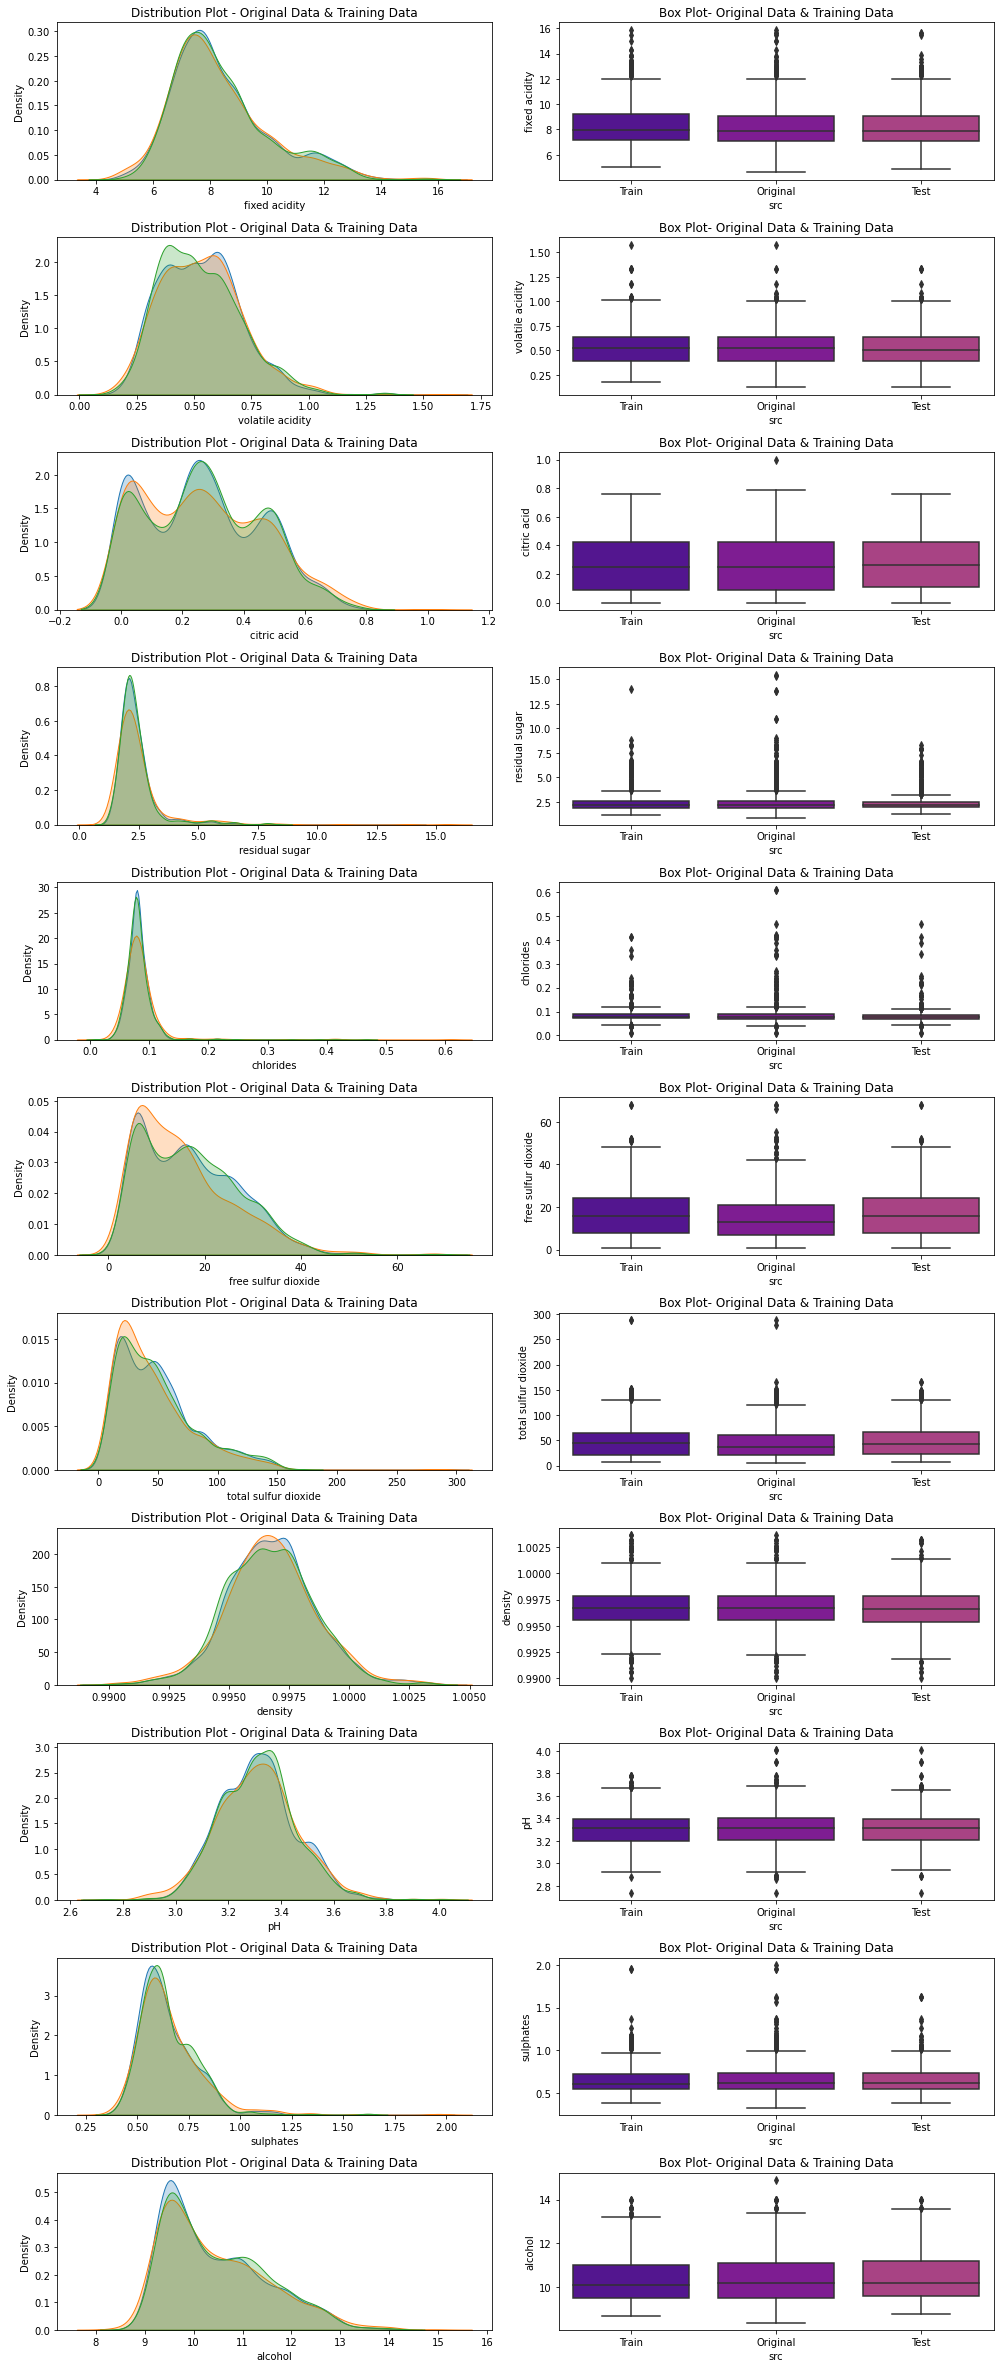

In [42]:
ncols = 2
cont_features=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

nrows = len(cont_features)
df_temp=pd.concat([train_df.assign(src='Train'),original_df.assign(src='Original'),test_df.assign(src='Test')])
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3*nrows))

for r in range(nrows):
    row = cont_features[r]
   
    sns.kdeplot(x=train_df[row], ax=axes[r,0], palette=palette, label='Train data', fill =True)
    sns.kdeplot(x=original_df[row], ax=axes[r,0], palette=palette, label='Original data' , fill =True )
    sns.kdeplot(x=test_df[row], ax=axes[r,0], palette=palette, label='Test data', fill =True)
    
    sns.boxplot(data=df_temp, y=row,x='src' ,ax=axes[r,1],palette=palette)


    axes[r,0].title.set_text("Distribution Plot - Original Data & Training Data")
    axes[r,1].title.set_text("Box Plot- Original Data & Training Data")
fig.tight_layout()
plt.show()

#### Insight:
* All variables except Quality are continuous.
* Original and Training Data follow the same distribution so they can be combined.
* Some columns - chlorides, residual sugar, sulphates are skewed
* We can also see the presence of outliers in some of the columns.

#### Combining original and train datasets

In [61]:
combined_df = pd.concat([train_df, original_df], ignore_index=True)

#### Removing Skewness from data

<AxesSubplot:xlabel='chlorides', ylabel='Density'>

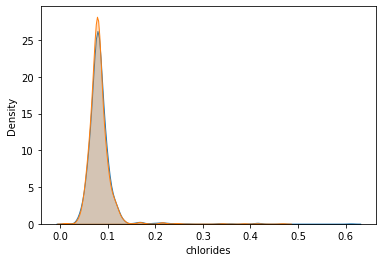

In [62]:
# Checking skewness in chlorides
sns.kdeplot(x=combined_df["chlorides"], palette=palette, fill =True)
sns.kdeplot(x=test_df["chlorides"], palette=palette, fill =True)

In [63]:
combined_df[cont_features] = np.log(combined_df[cont_features])
test_df[cont_features] = np.log(test_df[cont_features])

<AxesSubplot:xlabel='chlorides', ylabel='Density'>

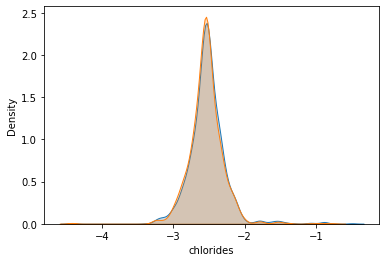

In [64]:
# Checking skewness in chlorides
sns.kdeplot(x=combined_df["chlorides"], palette=palette, fill =True)
sns.kdeplot(x=test_df["chlorides"], palette=palette, fill =True)

#### Handling Outliers

In [65]:
def handle_outliers(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr_range = q3 - q1
        
        upper_cap = q3 + 2.5*iqr_range
        lower_cap = q1 - 2.5*iqr_range
        
        df[column] = np.clip(df[column], lower_cap, upper_cap)
    return df

In [66]:
combined_df = handle_outliers(combined_df, features)

In [67]:
display(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3199 non-null   float64
 1   volatile acidity      3199 non-null   float64
 2   citric acid           3199 non-null   float64
 3   residual sugar        3199 non-null   float64
 4   chlorides             3199 non-null   float64
 5   free sulfur dioxide   3199 non-null   float64
 6   total sulfur dioxide  3199 non-null   float64
 7   density               3199 non-null   float64
 8   pH                    3199 non-null   float64
 9   sulphates             3199 non-null   float64
 10  alcohol               3199 non-null   float64
 11  quality               3199 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 300.0 KB


None

#### Correlation Matrix


In [68]:
correlation = combined_df.corr()

print(correlation[TARGET].sort_values(ascending=False),'\n')

quality                 1.00
alcohol                 0.49
sulphates               0.37
citric acid             0.11
fixed acidity           0.08
residual sugar          0.04
pH                     -0.01
free sulfur dioxide    -0.06
chlorides              -0.11
density                -0.16
total sulfur dioxide   -0.18
volatile acidity       -0.29
Name: quality, dtype: float64 



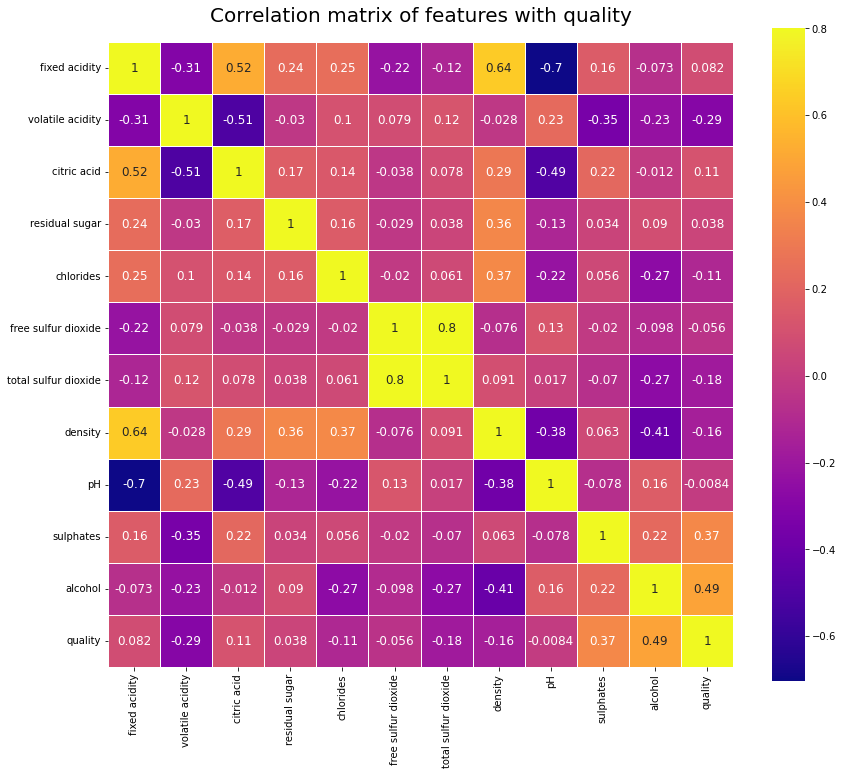

In [69]:
cols = correlation.index
corr_matrix = np.corrcoef(combined_df.to_numpy().T)

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, vmax=.8, linewidths=0.5, square=True, annot=True,
            cmap='plasma', annot_kws={'size': 12}, xticklabels=cols, yticklabels=cols)

# Add title to the plot
plt.title(f'Correlation matrix of features with {TARGET}', fontsize=20, pad=20)

# Increase the size of axes values
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)

plt.show()

In [70]:
# Threshold for correlation value
threshold = 0.5

# Get the high-correlated pairs of columns, excluding auto-correlations
corr_pairs = (
    correlation[abs(correlation) > threshold][correlation != 1.0]
).unstack().dropna().to_dict()

# Remove duplicate pairs and create a dataframe with unique pairs
unique_corr_pairs = pd.DataFrame(
    list(
        set([(tuple(sorted(key)), corr_pairs[key]) for key in corr_pairs])
    ), columns=['pair', 'corr']
)

# Show the unique pairs and their correlation value
unique_corr_pairs

,pair,corr
0,"(density, fixed acidity)",0.64
1,"(citric acid, volatile acidity)",-0.51
2,"(free sulfur dioxide, total sulfur dioxide)",0.80
3,"(fixed acidity, pH)",-0.70
4,"(citric acid, fixed acidity)",0.52


#### Insights
* Alcohol and sulphates are positively correlated with quality.
* Many columns (as above) have a high degree of correlation among themselves

#### Studying the Target Variable

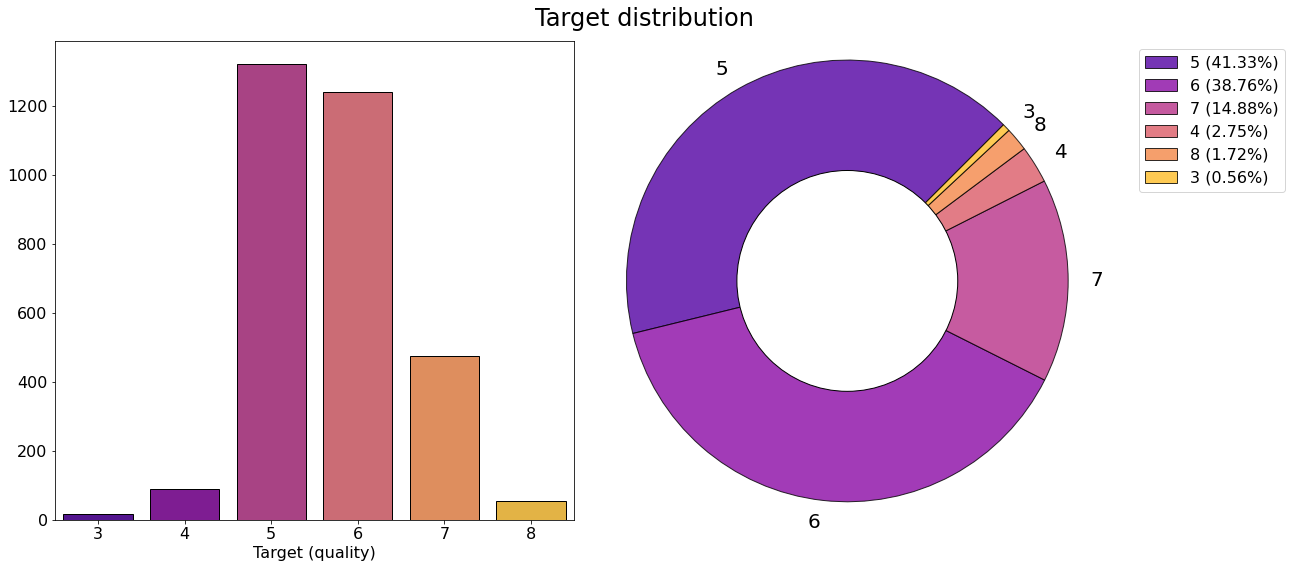

In [71]:
# Create the figure and subplots
TARGET = 'quality'
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Target distribution', fontsize=24)

# Plot the countplot
sns.countplot(x=TARGET, data=combined_df, alpha=1, palette=palette, edgecolor='black', ax=ax[0])
ax[0].set_xlabel(f'Target ({TARGET})', fontsize=16)
ax[0].set_ylabel('')
ax[0].tick_params(axis='both', labelsize=16)

# Get the counts of each class in the target column
target_counts = combined_df[TARGET].value_counts()

# Plot the pie chart
ax[1].pie(target_counts, labels=target_counts.index, startangle=45, colors=palette, pctdistance=0.3,
          textprops={'fontsize': 20}, wedgeprops={'alpha': 0.8, 'edgecolor': 'black', 'linewidth': 1})
ax[1].axis('equal')  # Ensure the pie is drawn as a circle

# Add the legend with target values and percentage
legend_entries = [f'{label} ({count/len(combined_df)*100:.2f}%)' for label, count in target_counts.items()]
ax[1].legend(legend_entries, bbox_to_anchor=(1.05, 1), loc='best', fontsize=16)

# Draw circle
centre_circle = plt.Circle((0, 0), 0.5, fc='white', edgecolor='black')
fig = plt.gcf()
  
# Adding circle in Pie chart
fig.gca().add_artist(centre_circle)

# Tighten the layout and show the figure
plt.tight_layout()
plt.show()

#### Insights:
* Target variable - quality is highly imbalanced. It makes sense because there are more number of normal quality wines than there are extremely bad or good wines. (94.97% have 5,6,7 quality rating)
* quality can range between 0-10 but actually the range is from 3-8 in the dataset

## Train-Test split

In [ ]:
# X = combined_df.drop(columns=['quality'])
# print(X.shape)
# y = combined_df.quality
# print(y.shape)

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(X,y,
#                                                         test_size=0.1, 
#                                                         stratify=y, 
#                                                         random_state=SEED)

## Modeling

## Hyperparameter Search with Optuna

In [72]:
target_clases = combined_df[TARGET].value_counts()
n_classes = target_clases.nunique()

In [73]:
def objective(trial):        
    params_optuna = {
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            #'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            #'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.01, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 1.0),
            'objective' : " multi:softmax",
            'num_class': n_classes,
        }

        
    n=trial.suggest_int('n_cv', 3, 10)
    cv = StratifiedKFold(n,shuffle=True, random_state=SEED)
    fold_scores = []
    for i, (train_idx,val_idx) in enumerate(cv.split(combined_df[features],combined_df[TARGET])):
        X_train, y_train = combined_df.loc[train_idx, features],combined_df.loc[train_idx, TARGET]
        X_val, y_val = combined_df.loc[val_idx, features],combined_df.loc[val_idx, TARGET]

        model = XGBClassifier(**params_optuna)
        model.fit(X_train,
                 y_train,
                 eval_set= [(X_val,y_val)],
                 early_stopping_rounds = 50,
                 verbose=500)

        pred_val = model.predict(X_val)

        score = cohen_kappa_score(y_val,pred_val, weights='quadratic')
        fold_scores.append(score)
    return np.mean(fold_scores)

In [74]:
combined_df[TARGET] = combined_df[TARGET]- 3 #xgb wants TARGET to start at 0

In [75]:
study = optuna.create_study(direction='maximize', sampler = TPESampler())
study.optimize(func=objective, n_trials=500)
study.best_params

[I 2023-02-05 14:37:10,799] A new study created in memory with name: no-name-915454bb-3643-4143-800c-2b117e39fa04


[0]	validation_0-mlogloss:1.38556
[59]	validation_0-mlogloss:1.22239
[0]	validation_0-mlogloss:1.37760
[59]	validation_0-mlogloss:1.12876
[0]	validation_0-mlogloss:1.45235
[61]	validation_0-mlogloss:1.27775
[0]	validation_0-mlogloss:1.34700
[59]	validation_0-mlogloss:1.17217
[0]	validation_0-mlogloss:1.42890
[63]	validation_0-mlogloss:1.21830
[0]	validation_0-mlogloss:1.41693
[59]	validation_0-mlogloss:1.15405
[0]	validation_0-mlogloss:1.38385
[60]	validation_0-mlogloss:1.04563
[0]	validation_0-mlogloss:1.44116
[59]	validation_0-mlogloss:1.26218
[0]	validation_0-mlogloss:1.40705
[57]	validation_0-mlogloss:1.19397
[0]	validation_0-mlogloss:1.42128
[57]	validation_0-mlogloss:1.21111


[I 2023-02-05 14:37:24,391] Trial 0 finished with value: 0.47474823116897963 and parameters: {'max_depth': 10, 'learning_rate': 0.5121241966958027, 'gamma': 0.6173936098579137, 'subsample': 0.5400843568139575, 'colsample_bytree': 0.6239079312952138, 'reg_alpha': 0.08585402502061935, 'reg_lambda': 0.5748579303066087, 'n_cv': 10}. Best is trial 0 with value: 0.47474823116897963.


[0]	validation_0-mlogloss:1.70012
[99]	validation_0-mlogloss:0.98765
[0]	validation_0-mlogloss:1.69605
[99]	validation_0-mlogloss:0.91757
[0]	validation_0-mlogloss:1.70437
[99]	validation_0-mlogloss:0.98617
[0]	validation_0-mlogloss:1.70107
[99]	validation_0-mlogloss:0.99538
[0]	validation_0-mlogloss:1.70407
[99]	validation_0-mlogloss:0.99301
[0]	validation_0-mlogloss:1.70048
[99]	validation_0-mlogloss:0.96248
[0]	validation_0-mlogloss:1.69654
[99]	validation_0-mlogloss:0.92695
[0]	validation_0-mlogloss:1.70162
[99]	validation_0-mlogloss:0.98966
[0]	validation_0-mlogloss:1.69883
[99]	validation_0-mlogloss:1.00155
[0]	validation_0-mlogloss:1.70253
[99]	validation_0-mlogloss:0.96989


[I 2023-02-05 14:37:36,319] Trial 1 finished with value: 0.5130646822987296 and parameters: {'max_depth': 4, 'learning_rate': 0.0892159671690125, 'gamma': 0.016334034959958825, 'subsample': 0.9920379593495112, 'colsample_bytree': 0.8374545115805153, 'reg_alpha': 0.6130826848056447, 'reg_lambda': 0.35569314113060757, 'n_cv': 10}. Best is trial 1 with value: 0.5130646822987296.


[0]	validation_0-mlogloss:1.34868
[56]	validation_0-mlogloss:1.13728
[0]	validation_0-mlogloss:1.31835
[57]	validation_0-mlogloss:1.05731
[0]	validation_0-mlogloss:1.37454
[60]	validation_0-mlogloss:1.21650
[0]	validation_0-mlogloss:1.34007
[61]	validation_0-mlogloss:1.11796
[0]	validation_0-mlogloss:1.37475
[59]	validation_0-mlogloss:1.10712
[0]	validation_0-mlogloss:1.35253
[60]	validation_0-mlogloss:1.12006
[0]	validation_0-mlogloss:1.32357
[63]	validation_0-mlogloss:1.03645
[0]	validation_0-mlogloss:1.37034
[62]	validation_0-mlogloss:1.18323
[0]	validation_0-mlogloss:1.34797
[57]	validation_0-mlogloss:1.15036
[0]	validation_0-mlogloss:1.34828
[58]	validation_0-mlogloss:1.07025


[I 2023-02-05 14:37:45,070] Trial 2 finished with value: 0.5005485777421766 and parameters: {'max_depth': 6, 'learning_rate': 0.5689705214940467, 'gamma': 0.03139223475186722, 'subsample': 0.9867376452205072, 'colsample_bytree': 0.5501379677199475, 'reg_alpha': 0.9347045839294484, 'reg_lambda': 0.4345706369242355, 'n_cv': 10}. Best is trial 1 with value: 0.5130646822987296.


[0]	validation_0-mlogloss:1.39746
[57]	validation_0-mlogloss:1.36169
[0]	validation_0-mlogloss:1.40555
[55]	validation_0-mlogloss:1.34765
[0]	validation_0-mlogloss:1.37845
[57]	validation_0-mlogloss:1.31667
[0]	validation_0-mlogloss:1.37049
[57]	validation_0-mlogloss:1.33162
[0]	validation_0-mlogloss:1.34482
[57]	validation_0-mlogloss:1.33396
[0]	validation_0-mlogloss:1.39810
[56]	validation_0-mlogloss:1.34889
[0]	validation_0-mlogloss:1.42909
[55]	validation_0-mlogloss:1.34540
[0]	validation_0-mlogloss:1.34558
[54]	validation_0-mlogloss:1.42882


[I 2023-02-05 14:37:54,503] Trial 3 finished with value: 0.48119022916311527 and parameters: {'max_depth': 8, 'learning_rate': 0.5384342279318609, 'gamma': 0.1569134431829534, 'subsample': 0.5496646921285461, 'colsample_bytree': 0.8915957928438751, 'reg_alpha': 0.02642095934952993, 'reg_lambda': 0.15775894949780345, 'n_cv': 8}. Best is trial 1 with value: 0.5130646822987296.


[0]	validation_0-mlogloss:1.25051
[52]	validation_0-mlogloss:1.33968
[0]	validation_0-mlogloss:1.30128
[52]	validation_0-mlogloss:1.29752
[0]	validation_0-mlogloss:1.28190
[54]	validation_0-mlogloss:1.35401
[0]	validation_0-mlogloss:1.24828
[55]	validation_0-mlogloss:1.24776
[0]	validation_0-mlogloss:1.24218
[53]	validation_0-mlogloss:1.34069


[I 2023-02-05 14:37:59,668] Trial 4 finished with value: 0.4598165331563962 and parameters: {'max_depth': 8, 'learning_rate': 0.8330685689248026, 'gamma': 0.3111921409278595, 'subsample': 0.6680883699929905, 'colsample_bytree': 0.9949546728443412, 'reg_alpha': 0.4702310199165701, 'reg_lambda': 0.2895242887456735, 'n_cv': 5}. Best is trial 1 with value: 0.5130646822987296.


[0]	validation_0-mlogloss:1.40122
[61]	validation_0-mlogloss:1.08545
[0]	validation_0-mlogloss:1.40505
[58]	validation_0-mlogloss:1.07923
[0]	validation_0-mlogloss:1.41942
[82]	validation_0-mlogloss:1.04555
[0]	validation_0-mlogloss:1.39925
[59]	validation_0-mlogloss:1.10407
[0]	validation_0-mlogloss:1.38037
[60]	validation_0-mlogloss:1.03270
[0]	validation_0-mlogloss:1.40266
[61]	validation_0-mlogloss:1.09268
[0]	validation_0-mlogloss:1.40439
[57]	validation_0-mlogloss:1.12868
[0]	validation_0-mlogloss:1.35017
[59]	validation_0-mlogloss:1.08710


[I 2023-02-05 14:38:07,454] Trial 5 finished with value: 0.5078579824002984 and parameters: {'max_depth': 6, 'learning_rate': 0.4917148898213845, 'gamma': 0.814251176492207, 'subsample': 0.8277396101739704, 'colsample_bytree': 0.6608443345962564, 'reg_alpha': 0.20026240709620055, 'reg_lambda': 0.5346698965304936, 'n_cv': 8}. Best is trial 1 with value: 0.5130646822987296.


[0]	validation_0-mlogloss:1.28479
[58]	validation_0-mlogloss:1.28401
[0]	validation_0-mlogloss:1.30815
[56]	validation_0-mlogloss:1.28451
[0]	validation_0-mlogloss:1.30068
[56]	validation_0-mlogloss:1.23681
[0]	validation_0-mlogloss:1.29266
[57]	validation_0-mlogloss:1.28043
[0]	validation_0-mlogloss:1.29566
[54]	validation_0-mlogloss:1.19083
[0]	validation_0-mlogloss:1.32081
[55]	validation_0-mlogloss:1.26251
[0]	validation_0-mlogloss:1.30722
[55]	validation_0-mlogloss:1.23872


[I 2023-02-05 14:38:13,560] Trial 6 finished with value: 0.5009678788684232 and parameters: {'max_depth': 6, 'learning_rate': 0.6756084958602674, 'gamma': 0.22881908707358226, 'subsample': 0.701762727455477, 'colsample_bytree': 0.7408134049978023, 'reg_alpha': 0.27837566175921413, 'reg_lambda': 0.32699964806956805, 'n_cv': 7}. Best is trial 1 with value: 0.5130646822987296.


[0]	validation_0-mlogloss:1.61343
[96]	validation_0-mlogloss:0.98649
[0]	validation_0-mlogloss:1.61366
[78]	validation_0-mlogloss:0.98129
[0]	validation_0-mlogloss:1.62065
[99]	validation_0-mlogloss:1.00066
[0]	validation_0-mlogloss:1.61407
[95]	validation_0-mlogloss:1.01664
[0]	validation_0-mlogloss:1.61434
[95]	validation_0-mlogloss:0.97113
[0]	validation_0-mlogloss:1.62107
[90]	validation_0-mlogloss:1.00403
[0]	validation_0-mlogloss:1.61726
[87]	validation_0-mlogloss:1.01244


[I 2023-02-05 14:38:22,435] Trial 7 finished with value: 0.5051819566665829 and parameters: {'max_depth': 5, 'learning_rate': 0.20122064110442422, 'gamma': 0.46177614765464264, 'subsample': 0.9324115027354385, 'colsample_bytree': 0.5415460636972631, 'reg_alpha': 0.9811746775812022, 'reg_lambda': 0.2647359191385869, 'n_cv': 7}. Best is trial 1 with value: 0.5130646822987296.


[0]	validation_0-mlogloss:1.68782
[99]	validation_0-mlogloss:0.96741
[0]	validation_0-mlogloss:1.68754
[99]	validation_0-mlogloss:0.98464
[0]	validation_0-mlogloss:1.68821
[99]	validation_0-mlogloss:0.97509


[I 2023-02-05 14:38:24,888] Trial 8 finished with value: 0.4972080686827334 and parameters: {'max_depth': 2, 'learning_rate': 0.10920494718300683, 'gamma': 0.9629140711542421, 'subsample': 0.927633644573825, 'colsample_bytree': 0.9427004544590687, 'reg_alpha': 0.9368990235420864, 'reg_lambda': 0.9151466323135444, 'n_cv': 3}. Best is trial 1 with value: 0.5130646822987296.


[0]	validation_0-mlogloss:1.42897
[99]	validation_0-mlogloss:0.94753
[0]	validation_0-mlogloss:1.43505
[99]	validation_0-mlogloss:0.95145
[0]	validation_0-mlogloss:1.44139
[92]	validation_0-mlogloss:0.98465
[0]	validation_0-mlogloss:1.43684
[96]	validation_0-mlogloss:1.01062
[0]	validation_0-mlogloss:1.45028
[99]	validation_0-mlogloss:0.95219
[0]	validation_0-mlogloss:1.44247
[99]	validation_0-mlogloss:0.98746
[0]	validation_0-mlogloss:1.44584
[76]	validation_0-mlogloss:0.97398


[I 2023-02-05 14:38:29,343] Trial 9 finished with value: 0.5156473413550159 and parameters: {'max_depth': 1, 'learning_rate': 0.5121528798621366, 'gamma': 0.5990135199888599, 'subsample': 0.6657017899456115, 'colsample_bytree': 0.6000334987971302, 'reg_alpha': 0.6815440305088285, 'reg_lambda': 0.18784810544468786, 'n_cv': 7}. Best is trial 9 with value: 0.5156473413550159.


[0]	validation_0-mlogloss:1.26200
[86]	validation_0-mlogloss:0.98050
[0]	validation_0-mlogloss:1.27895
[91]	validation_0-mlogloss:1.00341
[0]	validation_0-mlogloss:1.28939
[80]	validation_0-mlogloss:1.01988
[0]	validation_0-mlogloss:1.25902
[99]	validation_0-mlogloss:0.99799
[0]	validation_0-mlogloss:1.21523
[66]	validation_0-mlogloss:0.96611


[I 2023-02-05 14:38:32,156] Trial 10 finished with value: 0.5167924789025051 and parameters: {'max_depth': 1, 'learning_rate': 0.9200435644303289, 'gamma': 0.6267213410377857, 'subsample': 0.7842900102027879, 'colsample_bytree': 0.5105983805266122, 'reg_alpha': 0.6947668051639398, 'reg_lambda': 0.0344472613267377, 'n_cv': 5}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.24530
[94]	validation_0-mlogloss:0.97871
[0]	validation_0-mlogloss:1.26198
[96]	validation_0-mlogloss:1.01024
[0]	validation_0-mlogloss:1.27501
[91]	validation_0-mlogloss:1.03152
[0]	validation_0-mlogloss:1.24131
[99]	validation_0-mlogloss:1.00354
[0]	validation_0-mlogloss:1.19665
[65]	validation_0-mlogloss:0.97624


[I 2023-02-05 14:38:35,176] Trial 11 finished with value: 0.5156654387108344 and parameters: {'max_depth': 1, 'learning_rate': 0.9792869819169081, 'gamma': 0.6104210324209937, 'subsample': 0.7762664485473563, 'colsample_bytree': 0.5019470430965722, 'reg_alpha': 0.6909250531668135, 'reg_lambda': 0.01631942147480039, 'n_cv': 5}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.22070
[55]	validation_0-mlogloss:1.13404
[0]	validation_0-mlogloss:1.20721
[57]	validation_0-mlogloss:1.12399
[0]	validation_0-mlogloss:1.22278
[57]	validation_0-mlogloss:1.16040
[0]	validation_0-mlogloss:1.18738
[54]	validation_0-mlogloss:1.16852


[I 2023-02-05 14:38:37,212] Trial 12 finished with value: 0.4742097844530986 and parameters: {'max_depth': 3, 'learning_rate': 0.991146932348178, 'gamma': 0.7155673520200612, 'subsample': 0.7944272689623028, 'colsample_bytree': 0.5123621590779716, 'reg_alpha': 0.7926586337984698, 'reg_lambda': 0.017321761208350328, 'n_cv': 4}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.24024
[77]	validation_0-mlogloss:0.97451
[0]	validation_0-mlogloss:1.25804
[93]	validation_0-mlogloss:1.01827
[0]	validation_0-mlogloss:1.27101
[93]	validation_0-mlogloss:1.01651
[0]	validation_0-mlogloss:1.23665
[99]	validation_0-mlogloss:1.01859
[0]	validation_0-mlogloss:1.18900
[78]	validation_0-mlogloss:0.96136


[I 2023-02-05 14:38:40,216] Trial 13 finished with value: 0.5012205645597494 and parameters: {'max_depth': 1, 'learning_rate': 0.9936329746942189, 'gamma': 0.4346685126183605, 'subsample': 0.7873726074553475, 'colsample_bytree': 0.6854767666606757, 'reg_alpha': 0.5018747118694442, 'reg_lambda': 0.029808483709601496, 'n_cv': 5}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.22821
[55]	validation_0-mlogloss:1.08346
[0]	validation_0-mlogloss:1.25616
[55]	validation_0-mlogloss:1.10115
[0]	validation_0-mlogloss:1.25465
[59]	validation_0-mlogloss:1.14714
[0]	validation_0-mlogloss:1.24072
[59]	validation_0-mlogloss:1.08499
[0]	validation_0-mlogloss:1.20309
[56]	validation_0-mlogloss:1.08503


[I 2023-02-05 14:38:42,888] Trial 14 finished with value: 0.5015060106842223 and parameters: {'max_depth': 3, 'learning_rate': 0.843962950107781, 'gamma': 0.5662849563463966, 'subsample': 0.8447747689686549, 'colsample_bytree': 0.5076970838920146, 'reg_alpha': 0.7625455098972087, 'reg_lambda': 0.022568825214751287, 'n_cv': 5}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.26134
[90]	validation_0-mlogloss:0.99566
[0]	validation_0-mlogloss:1.33728
[65]	validation_0-mlogloss:1.02761
[0]	validation_0-mlogloss:1.31769
[82]	validation_0-mlogloss:1.00352


[I 2023-02-05 14:38:44,465] Trial 15 finished with value: 0.4912444677017093 and parameters: {'max_depth': 1, 'learning_rate': 0.8568355633342362, 'gamma': 0.7469334928368574, 'subsample': 0.7332746347249814, 'colsample_bytree': 0.5871212927069731, 'reg_alpha': 0.5470382289336607, 'reg_lambda': 0.1270760013577571, 'n_cv': 3}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.25641
[57]	validation_0-mlogloss:1.08710
[0]	validation_0-mlogloss:1.25746
[61]	validation_0-mlogloss:1.10492
[0]	validation_0-mlogloss:1.25275
[59]	validation_0-mlogloss:1.04471
[0]	validation_0-mlogloss:1.26618
[57]	validation_0-mlogloss:1.12842
[0]	validation_0-mlogloss:1.27736
[57]	validation_0-mlogloss:1.13822
[0]	validation_0-mlogloss:1.25149
[57]	validation_0-mlogloss:1.06641


[I 2023-02-05 14:38:47,881] Trial 16 finished with value: 0.48049952456126105 and parameters: {'max_depth': 3, 'learning_rate': 0.7552021062563674, 'gamma': 0.41021115102274947, 'subsample': 0.7515598332904261, 'colsample_bytree': 0.5013322716653706, 'reg_alpha': 0.7892186267432258, 'reg_lambda': 0.11149607782931786, 'n_cv': 6}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.24263
[62]	validation_0-mlogloss:1.05159
[0]	validation_0-mlogloss:1.23218
[65]	validation_0-mlogloss:1.06537
[0]	validation_0-mlogloss:1.21708
[64]	validation_0-mlogloss:1.05774
[0]	validation_0-mlogloss:1.20260
[59]	validation_0-mlogloss:1.08554


[I 2023-02-05 14:38:50,804] Trial 17 finished with value: 0.5032679472138268 and parameters: {'max_depth': 2, 'learning_rate': 0.9954008999464533, 'gamma': 0.5234626952586531, 'subsample': 0.863672249514921, 'colsample_bytree': 0.5759629960399171, 'reg_alpha': 0.6809566455774877, 'reg_lambda': 0.2047539386438415, 'n_cv': 4}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.19340
[54]	validation_0-mlogloss:1.27855
[0]	validation_0-mlogloss:1.22130
[54]	validation_0-mlogloss:1.30919
[0]	validation_0-mlogloss:1.19981
[57]	validation_0-mlogloss:1.33691
[0]	validation_0-mlogloss:1.22208
[52]	validation_0-mlogloss:1.32306
[0]	validation_0-mlogloss:1.25710
[51]	validation_0-mlogloss:1.28273
[0]	validation_0-mlogloss:1.19718
[52]	validation_0-mlogloss:1.35854


[I 2023-02-05 14:38:54,491] Trial 18 finished with value: 0.4736794551939931 and parameters: {'max_depth': 4, 'learning_rate': 0.9074284484704312, 'gamma': 0.6515213392222812, 'subsample': 0.6125091948873082, 'colsample_bytree': 0.6529974574160886, 'reg_alpha': 0.3924310160092158, 'reg_lambda': 0.0019024771960055656, 'n_cv': 6}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.32479
[70]	validation_0-mlogloss:1.02809
[0]	validation_0-mlogloss:1.31688
[78]	validation_0-mlogloss:1.03530
[0]	validation_0-mlogloss:1.31848
[59]	validation_0-mlogloss:1.03104
[0]	validation_0-mlogloss:1.28486
[61]	validation_0-mlogloss:1.02381


[I 2023-02-05 14:38:56,625] Trial 19 finished with value: 0.49661292520119704 and parameters: {'max_depth': 2, 'learning_rate': 0.7258631787153991, 'gamma': 0.8762371160746516, 'subsample': 0.753872801068257, 'colsample_bytree': 0.5669784410567735, 'reg_alpha': 0.5959677784159408, 'reg_lambda': 0.09748834760615693, 'n_cv': 4}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.18462
[57]	validation_0-mlogloss:1.17568
[0]	validation_0-mlogloss:1.19615
[53]	validation_0-mlogloss:1.21873
[0]	validation_0-mlogloss:1.17252
[56]	validation_0-mlogloss:1.18344
[0]	validation_0-mlogloss:1.20519
[52]	validation_0-mlogloss:1.16299
[0]	validation_0-mlogloss:1.21534
[55]	validation_0-mlogloss:1.18441
[0]	validation_0-mlogloss:1.17666
[53]	validation_0-mlogloss:1.16994


[I 2023-02-05 14:39:00,435] Trial 20 finished with value: 0.4913841524195815 and parameters: {'max_depth': 4, 'learning_rate': 0.9274564961654094, 'gamma': 0.646109321849182, 'subsample': 0.8796485056739709, 'colsample_bytree': 0.7043790820191923, 'reg_alpha': 0.4281401389068825, 'reg_lambda': 0.2232415730311299, 'n_cv': 6}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.52104
[99]	validation_0-mlogloss:0.96629
[0]	validation_0-mlogloss:1.52223
[91]	validation_0-mlogloss:0.96248
[0]	validation_0-mlogloss:1.52091
[99]	validation_0-mlogloss:0.95783
[0]	validation_0-mlogloss:1.53211
[99]	validation_0-mlogloss:0.99506
[0]	validation_0-mlogloss:1.52129
[99]	validation_0-mlogloss:0.96272
[0]	validation_0-mlogloss:1.51952
[99]	validation_0-mlogloss:0.98663
[0]	validation_0-mlogloss:1.52552
[82]	validation_0-mlogloss:0.99165
[0]	validation_0-mlogloss:1.50397
[99]	validation_0-mlogloss:0.95197


[I 2023-02-05 14:39:05,703] Trial 21 finished with value: 0.5092492498122698 and parameters: {'max_depth': 1, 'learning_rate': 0.36912838875853415, 'gamma': 0.5484950448552124, 'subsample': 0.6686923212753991, 'colsample_bytree': 0.6119863200509614, 'reg_alpha': 0.676662372293431, 'reg_lambda': 0.1353726715692265, 'n_cv': 8}. Best is trial 10 with value: 0.5167924789025051.


[0]	validation_0-mlogloss:1.30652
[87]	validation_0-mlogloss:0.95850
[0]	validation_0-mlogloss:1.30899
[80]	validation_0-mlogloss:0.98140
[0]	validation_0-mlogloss:1.32600
[93]	validation_0-mlogloss:0.99283
[0]	validation_0-mlogloss:1.31933
[98]	validation_0-mlogloss:1.02224
[0]	validation_0-mlogloss:1.34080
[99]	validation_0-mlogloss:0.95945
[0]	validation_0-mlogloss:1.32494
[99]	validation_0-mlogloss:0.98220
[0]	validation_0-mlogloss:1.32561
[73]	validation_0-mlogloss:0.98834


[I 2023-02-05 14:39:10,063] Trial 22 finished with value: 0.5240452736146944 and parameters: {'max_depth': 1, 'learning_rate': 0.7661716915655855, 'gamma': 0.727729295589808, 'subsample': 0.6990965898156727, 'colsample_bytree': 0.6120533105958614, 'reg_alpha': 0.7144190512781966, 'reg_lambda': 0.07911006470237777, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.26447
[67]	validation_0-mlogloss:0.99299
[0]	validation_0-mlogloss:1.28867
[73]	validation_0-mlogloss:1.03689
[0]	validation_0-mlogloss:1.29293
[61]	validation_0-mlogloss:1.03151
[0]	validation_0-mlogloss:1.27102
[66]	validation_0-mlogloss:1.05352
[0]	validation_0-mlogloss:1.22666
[59]	validation_0-mlogloss:1.01564


[I 2023-02-05 14:39:12,685] Trial 23 finished with value: 0.5025257508729191 and parameters: {'max_depth': 2, 'learning_rate': 0.7921297928989273, 'gamma': 0.7642820944621496, 'subsample': 0.792380347877615, 'colsample_bytree': 0.5405531154738695, 'reg_alpha': 0.8469841656715141, 'reg_lambda': 0.0839201336166561, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.28549
[64]	validation_0-mlogloss:1.00268
[0]	validation_0-mlogloss:1.27567
[79]	validation_0-mlogloss:0.94849
[0]	validation_0-mlogloss:1.30792
[81]	validation_0-mlogloss:0.99692
[0]	validation_0-mlogloss:1.32565
[99]	validation_0-mlogloss:1.00367
[0]	validation_0-mlogloss:1.27788
[99]	validation_0-mlogloss:0.99792
[0]	validation_0-mlogloss:1.26918
[92]	validation_0-mlogloss:1.01025
[0]	validation_0-mlogloss:1.28342
[99]	validation_0-mlogloss:1.01096
[0]	validation_0-mlogloss:1.27486
[83]	validation_0-mlogloss:0.98347
[0]	validation_0-mlogloss:1.25674
[82]	validation_0-mlogloss:0.98970


[I 2023-02-05 14:39:18,065] Trial 24 finished with value: 0.5004871701125938 and parameters: {'max_depth': 1, 'learning_rate': 0.8998836300892828, 'gamma': 0.6864177184445762, 'subsample': 0.7134042574392989, 'colsample_bytree': 0.5477840258980275, 'reg_alpha': 0.8593219275707845, 'reg_lambda': 0.08057237974279297, 'n_cv': 9}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.28594
[61]	validation_0-mlogloss:1.00072
[0]	validation_0-mlogloss:1.28529
[61]	validation_0-mlogloss:1.06391
[0]	validation_0-mlogloss:1.27491
[64]	validation_0-mlogloss:1.01283
[0]	validation_0-mlogloss:1.28900
[66]	validation_0-mlogloss:1.06071
[0]	validation_0-mlogloss:1.30732
[69]	validation_0-mlogloss:1.07664
[0]	validation_0-mlogloss:1.27592
[64]	validation_0-mlogloss:1.01787


[I 2023-02-05 14:39:22,242] Trial 25 finished with value: 0.49058834744578256 and parameters: {'max_depth': 2, 'learning_rate': 0.7269559861900875, 'gamma': 0.8434985225278628, 'subsample': 0.7733231312108879, 'colsample_bytree': 0.5019514625089552, 'reg_alpha': 0.7237106395965037, 'reg_lambda': 0.20902449418962799, 'n_cv': 6}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.24209
[54]	validation_0-mlogloss:1.13175
[0]	validation_0-mlogloss:1.22622
[58]	validation_0-mlogloss:1.14690
[0]	validation_0-mlogloss:1.23286
[59]	validation_0-mlogloss:1.16570
[0]	validation_0-mlogloss:1.21125
[54]	validation_0-mlogloss:1.14614


[I 2023-02-05 14:39:24,348] Trial 26 finished with value: 0.48806516697598756 and parameters: {'max_depth': 3, 'learning_rate': 0.9259034963616636, 'gamma': 0.7038636401154013, 'subsample': 0.8216994396957639, 'colsample_bytree': 0.6135694308712187, 'reg_alpha': 0.5876174529477107, 'reg_lambda': 0.006519978709991438, 'n_cv': 4}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.29963
[99]	validation_0-mlogloss:0.97131
[0]	validation_0-mlogloss:1.32923
[89]	validation_0-mlogloss:1.01099
[0]	validation_0-mlogloss:1.32750
[98]	validation_0-mlogloss:1.02423
[0]	validation_0-mlogloss:1.30265
[99]	validation_0-mlogloss:0.99316
[0]	validation_0-mlogloss:1.26517
[97]	validation_0-mlogloss:0.97204


[I 2023-02-05 14:39:27,567] Trial 27 finished with value: 0.5138076894711563 and parameters: {'max_depth': 1, 'learning_rate': 0.7924189681095193, 'gamma': 0.5077294700620824, 'subsample': 0.7305169995222479, 'colsample_bytree': 0.5739417157091617, 'reg_alpha': 0.658794765342251, 'reg_lambda': 0.15530061829585134, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.33991
[57]	validation_0-mlogloss:1.15217
[0]	validation_0-mlogloss:1.34189
[56]	validation_0-mlogloss:1.13618
[0]	validation_0-mlogloss:1.37465
[63]	validation_0-mlogloss:1.13949
[0]	validation_0-mlogloss:1.34406
[58]	validation_0-mlogloss:1.16321
[0]	validation_0-mlogloss:1.37508
[57]	validation_0-mlogloss:1.08465
[0]	validation_0-mlogloss:1.36391
[57]	validation_0-mlogloss:1.15575
[0]	validation_0-mlogloss:1.37587
[55]	validation_0-mlogloss:1.14725


[I 2023-02-05 14:39:35,162] Trial 28 finished with value: 0.4592442261629019 and parameters: {'max_depth': 8, 'learning_rate': 0.6260108851157183, 'gamma': 0.7776122951875793, 'subsample': 0.6978497860882681, 'colsample_bytree': 0.5340865936959099, 'reg_alpha': 0.7489870844620319, 'reg_lambda': 0.06489916690486813, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.24876
[55]	validation_0-mlogloss:1.22826
[0]	validation_0-mlogloss:1.22415
[55]	validation_0-mlogloss:1.19713
[0]	validation_0-mlogloss:1.22599
[54]	validation_0-mlogloss:1.20411
[0]	validation_0-mlogloss:1.26590
[55]	validation_0-mlogloss:1.20970
[0]	validation_0-mlogloss:1.26464
[53]	validation_0-mlogloss:1.23636
[0]	validation_0-mlogloss:1.23138
[53]	validation_0-mlogloss:1.21785


[I 2023-02-05 14:39:40,765] Trial 29 finished with value: 0.4622954676422974 and parameters: {'max_depth': 7, 'learning_rate': 0.8557401004637255, 'gamma': 0.6287001241793289, 'subsample': 0.7570278147562068, 'colsample_bytree': 0.6216748494025589, 'reg_alpha': 0.5349262247997194, 'reg_lambda': 0.3920954755646132, 'n_cv': 6}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.32126
[54]	validation_0-mlogloss:1.22542
[0]	validation_0-mlogloss:1.29846
[56]	validation_0-mlogloss:1.11771
[0]	validation_0-mlogloss:1.32996
[53]	validation_0-mlogloss:1.20424
[0]	validation_0-mlogloss:1.34683
[55]	validation_0-mlogloss:1.16651
[0]	validation_0-mlogloss:1.31746
[55]	validation_0-mlogloss:1.15411
[0]	validation_0-mlogloss:1.31415
[58]	validation_0-mlogloss:1.11681
[0]	validation_0-mlogloss:1.29432
[54]	validation_0-mlogloss:1.18463
[0]	validation_0-mlogloss:1.31244
[57]	validation_0-mlogloss:1.19370
[0]	validation_0-mlogloss:1.29027
[60]	validation_0-mlogloss:1.15011


[I 2023-02-05 14:39:52,940] Trial 30 finished with value: 0.48436715349014736 and parameters: {'max_depth': 9, 'learning_rate': 0.7800965610306565, 'gamma': 0.606366434837363, 'subsample': 0.8151453796827205, 'colsample_bytree': 0.6441397036480319, 'reg_alpha': 0.6290310249895725, 'reg_lambda': 0.29118412725356757, 'n_cv': 9}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.34255
[95]	validation_0-mlogloss:0.96517
[0]	validation_0-mlogloss:1.34830
[97]	validation_0-mlogloss:0.96610
[0]	validation_0-mlogloss:1.36335
[99]	validation_0-mlogloss:0.98828
[0]	validation_0-mlogloss:1.35445
[99]	validation_0-mlogloss:1.01416
[0]	validation_0-mlogloss:1.37071
[99]	validation_0-mlogloss:0.96909
[0]	validation_0-mlogloss:1.36621
[99]	validation_0-mlogloss:0.98881
[0]	validation_0-mlogloss:1.36461
[70]	validation_0-mlogloss:0.98491


[I 2023-02-05 14:39:57,471] Trial 31 finished with value: 0.5109877153293402 and parameters: {'max_depth': 1, 'learning_rate': 0.6806515731167846, 'gamma': 0.5807839765247488, 'subsample': 0.6403496902221735, 'colsample_bytree': 0.5846421543167705, 'reg_alpha': 0.7203410991851374, 'reg_lambda': 0.1940245688358615, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.22265
[54]	validation_0-mlogloss:1.07503
[0]	validation_0-mlogloss:1.21693
[77]	validation_0-mlogloss:1.06503
[0]	validation_0-mlogloss:1.20776
[70]	validation_0-mlogloss:1.05477
[0]	validation_0-mlogloss:1.26589
[56]	validation_0-mlogloss:1.08883
[0]	validation_0-mlogloss:1.22878
[57]	validation_0-mlogloss:1.04669
[0]	validation_0-mlogloss:1.24493
[62]	validation_0-mlogloss:1.11419
[0]	validation_0-mlogloss:1.23168
[57]	validation_0-mlogloss:1.08646
[0]	validation_0-mlogloss:1.16860
[56]	validation_0-mlogloss:1.04839


[I 2023-02-05 14:40:01,554] Trial 32 finished with value: 0.5107761380945697 and parameters: {'max_depth': 2, 'learning_rate': 0.9329032150382722, 'gamma': 0.6652915915305027, 'subsample': 0.682094876234392, 'colsample_bytree': 0.6037055860991914, 'reg_alpha': 0.6431534495840255, 'reg_lambda': 0.07652909926074725, 'n_cv': 8}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.42824
[59]	validation_0-mlogloss:1.08397
[0]	validation_0-mlogloss:1.45400
[57]	validation_0-mlogloss:1.11985
[0]	validation_0-mlogloss:1.44087
[62]	validation_0-mlogloss:1.07955
[0]	validation_0-mlogloss:1.44903
[60]	validation_0-mlogloss:1.12492
[0]	validation_0-mlogloss:1.45793
[63]	validation_0-mlogloss:1.04004
[0]	validation_0-mlogloss:1.45575
[68]	validation_0-mlogloss:1.08038
[0]	validation_0-mlogloss:1.45026
[60]	validation_0-mlogloss:1.08952


[I 2023-02-05 14:40:11,160] Trial 33 finished with value: 0.4833669183071529 and parameters: {'max_depth': 10, 'learning_rate': 0.4551890907850789, 'gamma': 0.5950590286676388, 'subsample': 0.730412039468329, 'colsample_bytree': 0.5593875433381447, 'reg_alpha': 0.8321513139517849, 'reg_lambda': 0.14841282960533392, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.38602
[76]	validation_0-mlogloss:0.98850
[0]	validation_0-mlogloss:1.38346
[99]	validation_0-mlogloss:0.95335
[0]	validation_0-mlogloss:1.41303
[98]	validation_0-mlogloss:1.00845
[0]	validation_0-mlogloss:1.42577
[99]	validation_0-mlogloss:0.99877
[0]	validation_0-mlogloss:1.38036
[99]	validation_0-mlogloss:0.98722
[0]	validation_0-mlogloss:1.37434
[99]	validation_0-mlogloss:0.98724
[0]	validation_0-mlogloss:1.38609
[99]	validation_0-mlogloss:0.99426
[0]	validation_0-mlogloss:1.38194
[81]	validation_0-mlogloss:0.97778
[0]	validation_0-mlogloss:1.36707
[81]	validation_0-mlogloss:0.96231


[I 2023-02-05 14:40:16,932] Trial 34 finished with value: 0.4987672470740871 and parameters: {'max_depth': 1, 'learning_rate': 0.6347842643163283, 'gamma': 0.7085003290282725, 'subsample': 0.620036636608839, 'colsample_bytree': 0.6358675734031451, 'reg_alpha': 0.6896400786386824, 'reg_lambda': 0.22215346563482244, 'n_cv': 9}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.34475
[58]	validation_0-mlogloss:1.06405
[0]	validation_0-mlogloss:1.33500
[60]	validation_0-mlogloss:1.13132
[0]	validation_0-mlogloss:1.33007
[64]	validation_0-mlogloss:1.07228
[0]	validation_0-mlogloss:1.33924
[62]	validation_0-mlogloss:1.07181
[0]	validation_0-mlogloss:1.34544
[57]	validation_0-mlogloss:1.07550
[0]	validation_0-mlogloss:1.32389
[61]	validation_0-mlogloss:1.10765


[I 2023-02-05 14:40:21,011] Trial 35 finished with value: 0.4848610055794092 and parameters: {'max_depth': 4, 'learning_rate': 0.5800212922717158, 'gamma': 0.49281198143384836, 'subsample': 0.7693663541836873, 'colsample_bytree': 0.5340396086321096, 'reg_alpha': 0.5698125356887538, 'reg_lambda': 0.06324761830418951, 'n_cv': 6}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.24170
[55]	validation_0-mlogloss:1.19074
[0]	validation_0-mlogloss:1.24928
[55]	validation_0-mlogloss:1.15474
[0]	validation_0-mlogloss:1.24593
[59]	validation_0-mlogloss:1.16511
[0]	validation_0-mlogloss:1.27189
[56]	validation_0-mlogloss:1.14467
[0]	validation_0-mlogloss:1.23853
[56]	validation_0-mlogloss:1.16221
[0]	validation_0-mlogloss:1.25514
[56]	validation_0-mlogloss:1.19899
[0]	validation_0-mlogloss:1.26894
[56]	validation_0-mlogloss:1.22256
[0]	validation_0-mlogloss:1.19471
[57]	validation_0-mlogloss:1.18402


[I 2023-02-05 14:40:26,690] Trial 36 finished with value: 0.49723697423820024 and parameters: {'max_depth': 3, 'learning_rate': 0.821651215468738, 'gamma': 0.6230000792262254, 'subsample': 0.5636754184866555, 'colsample_bytree': 0.8037031984783455, 'reg_alpha': 0.6273334252707683, 'reg_lambda': 0.4335670781251215, 'n_cv': 8}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.23430
[67]	validation_0-mlogloss:1.04968
[0]	validation_0-mlogloss:1.25930
[55]	validation_0-mlogloss:1.08455
[0]	validation_0-mlogloss:1.26758
[65]	validation_0-mlogloss:1.09858
[0]	validation_0-mlogloss:1.25093
[61]	validation_0-mlogloss:1.08869
[0]	validation_0-mlogloss:1.19844
[56]	validation_0-mlogloss:1.04072


[I 2023-02-05 14:40:29,263] Trial 37 finished with value: 0.5017088483285594 and parameters: {'max_depth': 2, 'learning_rate': 0.8742097131726194, 'gamma': 0.544124023042649, 'subsample': 0.6544561968702701, 'colsample_bytree': 0.5282314127539677, 'reg_alpha': 0.7195618329814332, 'reg_lambda': 0.00028279572963213484, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.19789
[53]	validation_0-mlogloss:1.32973
[0]	validation_0-mlogloss:1.21918
[54]	validation_0-mlogloss:1.27610
[0]	validation_0-mlogloss:1.23142
[54]	validation_0-mlogloss:1.30928
[0]	validation_0-mlogloss:1.22222
[54]	validation_0-mlogloss:1.33312
[0]	validation_0-mlogloss:1.23535
[55]	validation_0-mlogloss:1.22998
[0]	validation_0-mlogloss:1.27051
[58]	validation_0-mlogloss:1.31442
[0]	validation_0-mlogloss:1.23985
[52]	validation_0-mlogloss:1.26995


[I 2023-02-05 14:40:34,304] Trial 38 finished with value: 0.46727340313735194 and parameters: {'max_depth': 5, 'learning_rate': 0.9485560580642874, 'gamma': 0.3732186600451348, 'subsample': 0.6932993734741282, 'colsample_bytree': 0.5996812361173147, 'reg_alpha': 0.8762775519735658, 'reg_lambda': 0.16071588043688045, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.29224
[84]	validation_0-mlogloss:0.95974
[0]	validation_0-mlogloss:1.31785
[94]	validation_0-mlogloss:1.00979
[0]	validation_0-mlogloss:1.32059
[82]	validation_0-mlogloss:1.02139
[0]	validation_0-mlogloss:1.29503
[99]	validation_0-mlogloss:0.99135
[0]	validation_0-mlogloss:1.25762
[99]	validation_0-mlogloss:0.97514


[I 2023-02-05 14:40:37,474] Trial 39 finished with value: 0.5026064370364478 and parameters: {'max_depth': 1, 'learning_rate': 0.8132111697076672, 'gamma': 0.46795157696100786, 'subsample': 0.7261258816844313, 'colsample_bytree': 0.5619465741351719, 'reg_alpha': 0.7705901723866319, 'reg_lambda': 0.2719172177861686, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.21567
[58]	validation_0-mlogloss:1.07066
[0]	validation_0-mlogloss:1.16151
[58]	validation_0-mlogloss:0.96223
[0]	validation_0-mlogloss:1.23241
[61]	validation_0-mlogloss:1.06213
[0]	validation_0-mlogloss:1.18961
[66]	validation_0-mlogloss:1.04631
[0]	validation_0-mlogloss:1.22094
[62]	validation_0-mlogloss:1.03941
[0]	validation_0-mlogloss:1.19914
[77]	validation_0-mlogloss:1.08051
[0]	validation_0-mlogloss:1.17596
[70]	validation_0-mlogloss:0.99992
[0]	validation_0-mlogloss:1.21676
[60]	validation_0-mlogloss:1.04701
[0]	validation_0-mlogloss:1.17661
[56]	validation_0-mlogloss:1.06572
[0]	validation_0-mlogloss:1.20310
[57]	validation_0-mlogloss:1.01353


[I 2023-02-05 14:40:42,747] Trial 40 finished with value: 0.493513312056754 and parameters: {'max_depth': 2, 'learning_rate': 0.8856405469916627, 'gamma': 0.7803699817275953, 'subsample': 0.7014568509190331, 'colsample_bytree': 0.6795475864964227, 'reg_alpha': 0.8128675404511034, 'reg_lambda': 0.3104878047810069, 'n_cv': 10}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.30630
[71]	validation_0-mlogloss:0.95567
[0]	validation_0-mlogloss:1.33475
[89]	validation_0-mlogloss:1.01662
[0]	validation_0-mlogloss:1.33305
[76]	validation_0-mlogloss:1.03233
[0]	validation_0-mlogloss:1.30894
[99]	validation_0-mlogloss:0.98562
[0]	validation_0-mlogloss:1.27491
[99]	validation_0-mlogloss:0.97191


[I 2023-02-05 14:40:45,651] Trial 41 finished with value: 0.5085982665310274 and parameters: {'max_depth': 1, 'learning_rate': 0.7761005377256706, 'gamma': 0.5111196840747825, 'subsample': 0.728845608490442, 'colsample_bytree': 0.5647189304984577, 'reg_alpha': 0.6572432645078936, 'reg_lambda': 0.15752049184898326, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.34996
[80]	validation_0-mlogloss:0.98422
[0]	validation_0-mlogloss:1.34237
[87]	validation_0-mlogloss:1.00974
[0]	validation_0-mlogloss:1.33237
[86]	validation_0-mlogloss:0.99847
[0]	validation_0-mlogloss:1.32667
[82]	validation_0-mlogloss:1.00326


[I 2023-02-05 14:40:48,025] Trial 42 finished with value: 0.5057102305009221 and parameters: {'max_depth': 1, 'learning_rate': 0.7269248319361852, 'gamma': 0.5801938126865847, 'subsample': 0.675245624279174, 'colsample_bytree': 0.583415248486381, 'reg_alpha': 0.6080376356712418, 'reg_lambda': 0.11637311157147781, 'n_cv': 4}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.28172
[87]	validation_0-mlogloss:0.95627
[0]	validation_0-mlogloss:1.27238
[92]	validation_0-mlogloss:0.99900
[0]	validation_0-mlogloss:1.28155
[99]	validation_0-mlogloss:0.99225
[0]	validation_0-mlogloss:1.28602
[73]	validation_0-mlogloss:1.00627
[0]	validation_0-mlogloss:1.32594
[83]	validation_0-mlogloss:1.00592
[0]	validation_0-mlogloss:1.27633
[70]	validation_0-mlogloss:0.97926


[I 2023-02-05 14:40:51,396] Trial 43 finished with value: 0.5084375052291435 and parameters: {'max_depth': 1, 'learning_rate': 0.8205171071431392, 'gamma': 0.667450595965433, 'subsample': 0.7756475051450236, 'colsample_bytree': 0.5289502719980309, 'reg_alpha': 0.7114764085987727, 'reg_lambda': 0.05183538719946787, 'n_cv': 6}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.19620
[55]	validation_0-mlogloss:1.05536
[0]	validation_0-mlogloss:1.22558
[55]	validation_0-mlogloss:1.09475
[0]	validation_0-mlogloss:1.23275
[63]	validation_0-mlogloss:1.09023
[0]	validation_0-mlogloss:1.22084
[58]	validation_0-mlogloss:1.09856
[0]	validation_0-mlogloss:1.16682
[56]	validation_0-mlogloss:1.04535


[I 2023-02-05 14:40:54,609] Trial 44 finished with value: 0.48659420670255693 and parameters: {'max_depth': 2, 'learning_rate': 0.9665527515303239, 'gamma': 0.5012772436244798, 'subsample': 0.7388128151889974, 'colsample_bytree': 0.5210784628213105, 'reg_alpha': 0.7548848346115848, 'reg_lambda': 0.357573817026697, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.18774
[54]	validation_0-mlogloss:1.20752
[0]	validation_0-mlogloss:1.24882
[54]	validation_0-mlogloss:1.20304
[0]	validation_0-mlogloss:1.25466
[54]	validation_0-mlogloss:1.16676


[I 2023-02-05 14:40:56,091] Trial 45 finished with value: 0.47464415950631617 and parameters: {'max_depth': 3, 'learning_rate': 0.8771236668158549, 'gamma': 0.5493969803650728, 'subsample': 0.7150524285728309, 'colsample_bytree': 0.6273459848564267, 'reg_alpha': 0.6549070173270414, 'reg_lambda': 0.04654261184693344, 'n_cv': 3}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.23899
[89]	validation_0-mlogloss:0.96207
[0]	validation_0-mlogloss:1.23638
[71]	validation_0-mlogloss:0.97858
[0]	validation_0-mlogloss:1.26314
[99]	validation_0-mlogloss:0.99383
[0]	validation_0-mlogloss:1.25118
[66]	validation_0-mlogloss:1.04234
[0]	validation_0-mlogloss:1.26613
[99]	validation_0-mlogloss:0.97211
[0]	validation_0-mlogloss:1.27253
[99]	validation_0-mlogloss:0.99833
[0]	validation_0-mlogloss:1.25574
[63]	validation_0-mlogloss:1.00203


[I 2023-02-05 14:41:00,094] Trial 46 finished with value: 0.5110877569997221 and parameters: {'max_depth': 1, 'learning_rate': 0.9650208901717496, 'gamma': 0.6190352239895421, 'subsample': 0.811881534417179, 'colsample_bytree': 0.5021055485061507, 'reg_alpha': 0.5200941124389146, 'reg_lambda': 0.17869315417080767, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.27876
[58]	validation_0-mlogloss:1.05183
[0]	validation_0-mlogloss:1.26681
[80]	validation_0-mlogloss:1.03037
[0]	validation_0-mlogloss:1.27130
[57]	validation_0-mlogloss:1.03692
[0]	validation_0-mlogloss:1.23325
[57]	validation_0-mlogloss:1.03996


[I 2023-02-05 14:41:02,095] Trial 47 finished with value: 0.5056635933312827 and parameters: {'max_depth': 2, 'learning_rate': 0.8506668264584789, 'gamma': 0.7307873061211216, 'subsample': 0.7447742162416963, 'colsample_bytree': 0.5552898714498944, 'reg_alpha': 0.905741031165393, 'reg_lambda': 0.11404666854311553, 'n_cv': 4}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.26502
[69]	validation_0-mlogloss:0.96334
[0]	validation_0-mlogloss:1.28235
[98]	validation_0-mlogloss:0.99376
[0]	validation_0-mlogloss:1.29253
[99]	validation_0-mlogloss:1.01964
[0]	validation_0-mlogloss:1.26221
[99]	validation_0-mlogloss:0.99403
[0]	validation_0-mlogloss:1.21795
[65]	validation_0-mlogloss:0.96470


[I 2023-02-05 14:41:04,971] Trial 48 finished with value: 0.5100241979631844 and parameters: {'max_depth': 1, 'learning_rate': 0.9105230721654195, 'gamma': 0.6886449506335212, 'subsample': 0.7892146186488853, 'colsample_bytree': 0.595051242441158, 'reg_alpha': 0.7989903182926863, 'reg_lambda': 0.24346112141782963, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.17148
[59]	validation_0-mlogloss:1.13055
[0]	validation_0-mlogloss:1.17189
[55]	validation_0-mlogloss:1.16878
[0]	validation_0-mlogloss:1.16159
[56]	validation_0-mlogloss:1.13601
[0]	validation_0-mlogloss:1.20064
[57]	validation_0-mlogloss:1.21446
[0]	validation_0-mlogloss:1.21873
[54]	validation_0-mlogloss:1.20187
[0]	validation_0-mlogloss:1.17023
[54]	validation_0-mlogloss:1.18182


[I 2023-02-05 14:41:08,179] Trial 49 finished with value: 0.4856109563748723 and parameters: {'max_depth': 3, 'learning_rate': 0.9972783794281834, 'gamma': 0.4193298452493077, 'subsample': 0.75651023777584, 'colsample_bytree': 0.5759280826467489, 'reg_alpha': 0.5679484319889263, 'reg_lambda': 0.17132271733280113, 'n_cv': 6}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.30311
[59]	validation_0-mlogloss:1.03512
[0]	validation_0-mlogloss:1.27142
[61]	validation_0-mlogloss:1.04018
[0]	validation_0-mlogloss:1.28602
[60]	validation_0-mlogloss:1.03116
[0]	validation_0-mlogloss:1.29780
[58]	validation_0-mlogloss:1.05808
[0]	validation_0-mlogloss:1.27918
[57]	validation_0-mlogloss:1.02731
[0]	validation_0-mlogloss:1.29876
[60]	validation_0-mlogloss:1.07871
[0]	validation_0-mlogloss:1.28955
[64]	validation_0-mlogloss:1.07337
[0]	validation_0-mlogloss:1.21359
[59]	validation_0-mlogloss:1.02490


[I 2023-02-05 14:41:12,332] Trial 50 finished with value: 0.5063823867625272 and parameters: {'max_depth': 2, 'learning_rate': 0.8072836472470647, 'gamma': 0.47773256572039957, 'subsample': 0.7126480014607159, 'colsample_bytree': 0.5249504610798962, 'reg_alpha': 0.6932844458717725, 'reg_lambda': 0.25563158040930506, 'n_cv': 8}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.76970
[99]	validation_0-mlogloss:1.08227
[0]	validation_0-mlogloss:1.76937
[99]	validation_0-mlogloss:1.03184
[0]	validation_0-mlogloss:1.77057
[99]	validation_0-mlogloss:1.09789
[0]	validation_0-mlogloss:1.77074
[99]	validation_0-mlogloss:1.09206
[0]	validation_0-mlogloss:1.77113
[99]	validation_0-mlogloss:1.10844
[0]	validation_0-mlogloss:1.76953
[99]	validation_0-mlogloss:1.07882
[0]	validation_0-mlogloss:1.76924
[99]	validation_0-mlogloss:1.04721
[0]	validation_0-mlogloss:1.77074
[99]	validation_0-mlogloss:1.09595
[0]	validation_0-mlogloss:1.77021
[99]	validation_0-mlogloss:1.09269
[0]	validation_0-mlogloss:1.77033
[99]	validation_0-mlogloss:1.07623


[I 2023-02-05 14:41:27,423] Trial 51 finished with value: 0.5100706525530774 and parameters: {'max_depth': 5, 'learning_rate': 0.020103203613953458, 'gamma': 0.11725646782926791, 'subsample': 0.9935902800137081, 'colsample_bytree': 0.8302868973385874, 'reg_alpha': 0.6157852378258997, 'reg_lambda': 0.04031143109423481, 'n_cv': 10}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.61429
[75]	validation_0-mlogloss:1.04171
[0]	validation_0-mlogloss:1.61251
[72]	validation_0-mlogloss:1.05685
[0]	validation_0-mlogloss:1.61013
[82]	validation_0-mlogloss:1.02936
[0]	validation_0-mlogloss:1.59402
[74]	validation_0-mlogloss:1.05008


[I 2023-02-05 14:41:32,632] Trial 52 finished with value: 0.502741886689406 and parameters: {'max_depth': 7, 'learning_rate': 0.2067440672765215, 'gamma': 0.24274867774965941, 'subsample': 0.9670473316753952, 'colsample_bytree': 0.6614716048786521, 'reg_alpha': 0.6628220012310505, 'reg_lambda': 0.11253271529000998, 'n_cv': 4}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.44047
[96]	validation_0-mlogloss:0.98241
[0]	validation_0-mlogloss:1.44382
[80]	validation_0-mlogloss:0.94358
[0]	validation_0-mlogloss:1.45773
[99]	validation_0-mlogloss:0.97514
[0]	validation_0-mlogloss:1.46699
[99]	validation_0-mlogloss:0.97576
[0]	validation_0-mlogloss:1.43678
[99]	validation_0-mlogloss:0.97384
[0]	validation_0-mlogloss:1.43043
[93]	validation_0-mlogloss:0.97647
[0]	validation_0-mlogloss:1.43446
[99]	validation_0-mlogloss:0.99044
[0]	validation_0-mlogloss:1.43560
[94]	validation_0-mlogloss:0.95655
[0]	validation_0-mlogloss:1.42162
[92]	validation_0-mlogloss:0.96142


[I 2023-02-05 14:41:38,326] Trial 53 finished with value: 0.5038590978717135 and parameters: {'max_depth': 1, 'learning_rate': 0.5297051171981453, 'gamma': 0.02796038364267352, 'subsample': 0.8851624218903709, 'colsample_bytree': 0.5474693822060521, 'reg_alpha': 0.7582559349181246, 'reg_lambda': 0.13703334298340974, 'n_cv': 9}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.43879
[67]	validation_0-mlogloss:1.02020
[0]	validation_0-mlogloss:1.45297
[74]	validation_0-mlogloss:1.06723
[0]	validation_0-mlogloss:1.45127
[64]	validation_0-mlogloss:1.06806
[0]	validation_0-mlogloss:1.43860
[71]	validation_0-mlogloss:1.03234
[0]	validation_0-mlogloss:1.41297
[66]	validation_0-mlogloss:1.04185


[I 2023-02-05 14:41:42,042] Trial 54 finished with value: 0.5117275808967244 and parameters: {'max_depth': 4, 'learning_rate': 0.43680821473828096, 'gamma': 0.5309285996495441, 'subsample': 0.8330198073562034, 'colsample_bytree': 0.5171511090335071, 'reg_alpha': 0.5624074497075067, 'reg_lambda': 0.32631627329857893, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.25330
[65]	validation_0-mlogloss:1.07359
[0]	validation_0-mlogloss:1.31054
[62]	validation_0-mlogloss:1.05824
[0]	validation_0-mlogloss:1.30695
[62]	validation_0-mlogloss:1.07398


[I 2023-02-05 14:41:43,721] Trial 55 finished with value: 0.5003426053942363 and parameters: {'max_depth': 2, 'learning_rate': 0.7531710663414214, 'gamma': 0.08679266285370035, 'subsample': 0.908225652434611, 'colsample_bytree': 0.6039799619852787, 'reg_alpha': 0.49080893532463665, 'reg_lambda': 0.08429099143869609, 'n_cv': 3}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.50056
[64]	validation_0-mlogloss:1.06895
[0]	validation_0-mlogloss:1.47275
[66]	validation_0-mlogloss:0.99967
[0]	validation_0-mlogloss:1.50192
[65]	validation_0-mlogloss:1.06166
[0]	validation_0-mlogloss:1.48774
[67]	validation_0-mlogloss:1.04402
[0]	validation_0-mlogloss:1.51085
[65]	validation_0-mlogloss:1.05197
[0]	validation_0-mlogloss:1.48740
[67]	validation_0-mlogloss:1.00546
[0]	validation_0-mlogloss:1.47309
[76]	validation_0-mlogloss:0.93791
[0]	validation_0-mlogloss:1.50681
[71]	validation_0-mlogloss:1.05327
[0]	validation_0-mlogloss:1.48791
[63]	validation_0-mlogloss:1.07421
[0]	validation_0-mlogloss:1.50059
[72]	validation_0-mlogloss:0.99859


[I 2023-02-05 14:41:54,304] Trial 56 finished with value: 0.504169288236043 and parameters: {'max_depth': 6, 'learning_rate': 0.3400677683608634, 'gamma': 0.3647949312498721, 'subsample': 0.9434233687294548, 'colsample_bytree': 0.5751878724683431, 'reg_alpha': 0.6778313830430125, 'reg_lambda': 0.026245636530638883, 'n_cv': 10}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.39947
[99]	validation_0-mlogloss:0.95610
[0]	validation_0-mlogloss:1.39044
[99]	validation_0-mlogloss:0.96917
[0]	validation_0-mlogloss:1.39810
[99]	validation_0-mlogloss:0.98229
[0]	validation_0-mlogloss:1.40095
[76]	validation_0-mlogloss:0.99418
[0]	validation_0-mlogloss:1.41567
[99]	validation_0-mlogloss:0.98573
[0]	validation_0-mlogloss:1.39122
[75]	validation_0-mlogloss:0.97191


[I 2023-02-05 14:41:58,867] Trial 57 finished with value: 0.5029353111193827 and parameters: {'max_depth': 1, 'learning_rate': 0.5621615183406109, 'gamma': 0.44587111448692124, 'subsample': 0.8441600307732169, 'colsample_bytree': 0.5005837663994044, 'reg_alpha': 0.5904036266616534, 'reg_lambda': 0.2402050566037507, 'n_cv': 6}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.30287
[62]	validation_0-mlogloss:1.05686
[0]	validation_0-mlogloss:1.31510
[58]	validation_0-mlogloss:1.06416
[0]	validation_0-mlogloss:1.32292
[68]	validation_0-mlogloss:1.09389
[0]	validation_0-mlogloss:1.30619
[60]	validation_0-mlogloss:1.05922
[0]	validation_0-mlogloss:1.26633
[60]	validation_0-mlogloss:1.05875


[I 2023-02-05 14:42:01,721] Trial 58 finished with value: 0.5020018648547957 and parameters: {'max_depth': 3, 'learning_rate': 0.6823785168782, 'gamma': 0.5917306730208691, 'subsample': 0.8013910502950281, 'colsample_bytree': 0.5445893997981812, 'reg_alpha': 0.7915655757933738, 'reg_lambda': 0.17565907359575486, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.22265
[61]	validation_0-mlogloss:0.99956
[0]	validation_0-mlogloss:1.22655
[60]	validation_0-mlogloss:1.03591
[0]	validation_0-mlogloss:1.25705
[72]	validation_0-mlogloss:1.03380
[0]	validation_0-mlogloss:1.24823
[60]	validation_0-mlogloss:1.10126
[0]	validation_0-mlogloss:1.25212
[58]	validation_0-mlogloss:1.02949
[0]	validation_0-mlogloss:1.25800
[57]	validation_0-mlogloss:1.05113
[0]	validation_0-mlogloss:1.23906
[62]	validation_0-mlogloss:1.05747


[I 2023-02-05 14:42:05,388] Trial 59 finished with value: 0.4900289099361657 and parameters: {'max_depth': 2, 'learning_rate': 0.8468211972766657, 'gamma': 0.22365677733285977, 'subsample': 0.8542340180667518, 'colsample_bytree': 0.7387376209110426, 'reg_alpha': 0.7327138002475762, 'reg_lambda': 0.19969844668234016, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.29203
[52]	validation_0-mlogloss:1.29803
[0]	validation_0-mlogloss:1.25408
[52]	validation_0-mlogloss:1.31243
[0]	validation_0-mlogloss:1.30156
[52]	validation_0-mlogloss:1.28949
[0]	validation_0-mlogloss:1.31460
[58]	validation_0-mlogloss:1.20502
[0]	validation_0-mlogloss:1.26890
[53]	validation_0-mlogloss:1.25010
[0]	validation_0-mlogloss:1.31482
[52]	validation_0-mlogloss:1.26405
[0]	validation_0-mlogloss:1.29863
[52]	validation_0-mlogloss:1.34507
[0]	validation_0-mlogloss:1.21690
[52]	validation_0-mlogloss:1.31811


[I 2023-02-05 14:42:13,644] Trial 60 finished with value: 0.4459571928235826 and parameters: {'max_depth': 9, 'learning_rate': 0.908067471044377, 'gamma': 0.6325750380555826, 'subsample': 0.6876216189019353, 'colsample_bytree': 0.517471043312714, 'reg_alpha': 0.6336511750438915, 'reg_lambda': 0.0995167721602847, 'n_cv': 8}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.43435
[64]	validation_0-mlogloss:1.04321
[0]	validation_0-mlogloss:1.44860
[81]	validation_0-mlogloss:1.08993
[0]	validation_0-mlogloss:1.44770
[60]	validation_0-mlogloss:1.09065
[0]	validation_0-mlogloss:1.43295
[70]	validation_0-mlogloss:1.04665
[0]	validation_0-mlogloss:1.40610
[68]	validation_0-mlogloss:1.05523


[I 2023-02-05 14:42:17,522] Trial 61 finished with value: 0.49985411568935023 and parameters: {'max_depth': 4, 'learning_rate': 0.4447066446095795, 'gamma': 0.5223897711641624, 'subsample': 0.84034474274231, 'colsample_bytree': 0.5170787243062456, 'reg_alpha': 0.5520552190830348, 'reg_lambda': 0.2978921091923446, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.42290
[61]	validation_0-mlogloss:1.11718
[0]	validation_0-mlogloss:1.40594
[60]	validation_0-mlogloss:1.08452
[0]	validation_0-mlogloss:1.40875
[64]	validation_0-mlogloss:1.05289
[0]	validation_0-mlogloss:1.38163
[62]	validation_0-mlogloss:1.08984


[I 2023-02-05 14:42:21,020] Trial 62 finished with value: 0.4836885889482827 and parameters: {'max_depth': 5, 'learning_rate': 0.48927425033949723, 'gamma': 0.5578590484295275, 'subsample': 0.780189927530124, 'colsample_bytree': 0.5620143725528252, 'reg_alpha': 0.5975456624410855, 'reg_lambda': 0.3335423433442652, 'n_cv': 4}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.20196
[54]	validation_0-mlogloss:1.17401
[0]	validation_0-mlogloss:1.24678
[54]	validation_0-mlogloss:1.23072
[0]	validation_0-mlogloss:1.21484
[52]	validation_0-mlogloss:1.20415
[0]	validation_0-mlogloss:1.20479
[57]	validation_0-mlogloss:1.17443
[0]	validation_0-mlogloss:1.20876
[52]	validation_0-mlogloss:1.20830
[0]	validation_0-mlogloss:1.20597
[53]	validation_0-mlogloss:1.20308


[I 2023-02-05 14:42:26,237] Trial 63 finished with value: 0.4507540521627423 and parameters: {'max_depth': 7, 'learning_rate': 0.9568536962921791, 'gamma': 0.6573277219021998, 'subsample': 0.8257257705997342, 'colsample_bytree': 0.5413974384791779, 'reg_alpha': 0.7044970018851596, 'reg_lambda': 0.13797376820579976, 'n_cv': 6}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.31377
[60]	validation_0-mlogloss:1.14339
[0]	validation_0-mlogloss:1.30114
[55]	validation_0-mlogloss:1.13448
[0]	validation_0-mlogloss:1.31607
[59]	validation_0-mlogloss:1.11846
[0]	validation_0-mlogloss:1.27392
[57]	validation_0-mlogloss:1.14745


[I 2023-02-05 14:42:29,668] Trial 64 finished with value: 0.4919651048552524 and parameters: {'max_depth': 4, 'learning_rate': 0.7047139208427643, 'gamma': 0.5364940910251911, 'subsample': 0.8057216882401218, 'colsample_bytree': 0.61907330207147, 'reg_alpha': 0.5188641702949961, 'reg_lambda': 0.5123981448212719, 'n_cv': 4}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.37912
[87]	validation_0-mlogloss:0.95985
[0]	validation_0-mlogloss:1.39705
[89]	validation_0-mlogloss:0.99734
[0]	validation_0-mlogloss:1.39669
[99]	validation_0-mlogloss:1.00890
[0]	validation_0-mlogloss:1.37657
[99]	validation_0-mlogloss:0.99124
[0]	validation_0-mlogloss:1.34134
[70]	validation_0-mlogloss:0.96458


[I 2023-02-05 14:42:32,616] Trial 65 finished with value: 0.5122926921909496 and parameters: {'max_depth': 1, 'learning_rate': 0.6231837425274496, 'gamma': 0.5783146738839244, 'subsample': 0.7607649602444303, 'colsample_bytree': 0.5867620818477486, 'reg_alpha': 0.6677934272370007, 'reg_lambda': 0.045337644574939835, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.36505
[86]	validation_0-mlogloss:0.95681
[0]	validation_0-mlogloss:1.38303
[94]	validation_0-mlogloss:0.99216
[0]	validation_0-mlogloss:1.38719
[73]	validation_0-mlogloss:1.01877
[0]	validation_0-mlogloss:1.36605
[99]	validation_0-mlogloss:0.98835
[0]	validation_0-mlogloss:1.33047
[70]	validation_0-mlogloss:0.97407


[I 2023-02-05 14:42:35,421] Trial 66 finished with value: 0.5080011969781852 and parameters: {'max_depth': 1, 'learning_rate': 0.64471143903088, 'gamma': 0.7357675231715539, 'subsample': 0.7581075897208587, 'colsample_bytree': 0.5953477514955502, 'reg_alpha': 0.6763851951171604, 'reg_lambda': 0.03781282220057157, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.37156
[99]	validation_0-mlogloss:0.97202
[0]	validation_0-mlogloss:1.36287
[94]	validation_0-mlogloss:0.98799
[0]	validation_0-mlogloss:1.37307
[94]	validation_0-mlogloss:0.98869
[0]	validation_0-mlogloss:1.37305
[73]	validation_0-mlogloss:1.00073
[0]	validation_0-mlogloss:1.39624
[96]	validation_0-mlogloss:0.99333
[0]	validation_0-mlogloss:1.36550
[81]	validation_0-mlogloss:0.98885


[I 2023-02-05 14:42:39,134] Trial 67 finished with value: 0.5095601082154912 and parameters: {'max_depth': 1, 'learning_rate': 0.6123931837114629, 'gamma': 0.5779939148832048, 'subsample': 0.6619799827005681, 'colsample_bytree': 0.5875458795639745, 'reg_alpha': 0.6398769976954501, 'reg_lambda': 0.002794373116279787, 'n_cv': 6}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.33745
[80]	validation_0-mlogloss:0.98435
[0]	validation_0-mlogloss:1.33215
[99]	validation_0-mlogloss:0.99948
[0]	validation_0-mlogloss:1.31963
[94]	validation_0-mlogloss:0.99602
[0]	validation_0-mlogloss:1.31164
[61]	validation_0-mlogloss:0.98657


[I 2023-02-05 14:42:41,383] Trial 68 finished with value: 0.5108324696475416 and parameters: {'max_depth': 1, 'learning_rate': 0.760496450379924, 'gamma': 0.6554184882657912, 'subsample': 0.7413963071221532, 'colsample_bytree': 0.6350699418927271, 'reg_alpha': 0.7351817531636182, 'reg_lambda': 0.06974223767465489, 'n_cv': 4}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.28055
[60]	validation_0-mlogloss:1.01923
[0]	validation_0-mlogloss:1.28070
[61]	validation_0-mlogloss:0.98178
[0]	validation_0-mlogloss:1.31744
[77]	validation_0-mlogloss:1.02392
[0]	validation_0-mlogloss:1.31305
[71]	validation_0-mlogloss:1.01334
[0]	validation_0-mlogloss:1.27497
[61]	validation_0-mlogloss:1.02957
[0]	validation_0-mlogloss:1.29715
[59]	validation_0-mlogloss:1.01302
[0]	validation_0-mlogloss:1.28725
[70]	validation_0-mlogloss:1.02113
[0]	validation_0-mlogloss:1.27917
[68]	validation_0-mlogloss:0.99467
[0]	validation_0-mlogloss:1.25411
[67]	validation_0-mlogloss:0.97862


[I 2023-02-05 14:42:46,013] Trial 69 finished with value: 0.49688806579696326 and parameters: {'max_depth': 2, 'learning_rate': 0.7948605315934438, 'gamma': 0.6102941209846615, 'subsample': 0.9996245472600247, 'colsample_bytree': 0.6110619932167259, 'reg_alpha': 0.7000131141759054, 'reg_lambda': 0.09586009200033632, 'n_cv': 9}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.36834
[68]	validation_0-mlogloss:0.98587
[0]	validation_0-mlogloss:1.38425
[68]	validation_0-mlogloss:1.03423
[0]	validation_0-mlogloss:1.38691
[59]	validation_0-mlogloss:1.02419
[0]	validation_0-mlogloss:1.37683
[66]	validation_0-mlogloss:1.03278
[0]	validation_0-mlogloss:1.32299
[62]	validation_0-mlogloss:0.99507


[I 2023-02-05 14:42:48,723] Trial 70 finished with value: 0.4965716944479368 and parameters: {'max_depth': 2, 'learning_rate': 0.5760776536264113, 'gamma': 0.48342450599322445, 'subsample': 0.7677025318196411, 'colsample_bytree': 0.5694232403213002, 'reg_alpha': 0.7425658707544975, 'reg_lambda': 0.06706264804575572, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.30981
[59]	validation_0-mlogloss:1.15412
[0]	validation_0-mlogloss:1.33276
[58]	validation_0-mlogloss:1.15981
[0]	validation_0-mlogloss:1.33032
[59]	validation_0-mlogloss:1.17253
[0]	validation_0-mlogloss:1.32812
[59]	validation_0-mlogloss:1.20633
[0]	validation_0-mlogloss:1.29583
[57]	validation_0-mlogloss:1.17187


[I 2023-02-05 14:42:52,760] Trial 71 finished with value: 0.49250664277402245 and parameters: {'max_depth': 6, 'learning_rate': 0.6605241614022075, 'gamma': 0.5152412282276079, 'subsample': 0.7861960173772979, 'colsample_bytree': 0.5116426791315263, 'reg_alpha': 0.5711279561409472, 'reg_lambda': 0.1422187604970025, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.36785
[99]	validation_0-mlogloss:0.96272
[0]	validation_0-mlogloss:1.36269
[92]	validation_0-mlogloss:0.98299
[0]	validation_0-mlogloss:1.36762
[99]	validation_0-mlogloss:0.97999
[0]	validation_0-mlogloss:1.37078
[75]	validation_0-mlogloss:1.00485
[0]	validation_0-mlogloss:1.39445
[87]	validation_0-mlogloss:0.99124
[0]	validation_0-mlogloss:1.36212
[75]	validation_0-mlogloss:0.97467


[I 2023-02-05 14:42:56,260] Trial 72 finished with value: 0.49159604385695266 and parameters: {'max_depth': 1, 'learning_rate': 0.617489343172369, 'gamma': 0.5605704654527884, 'subsample': 0.8020388819963172, 'colsample_bytree': 0.5504390762534478, 'reg_alpha': 0.6237692962757241, 'reg_lambda': 0.20349667025283685, 'n_cv': 6}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.30020
[57]	validation_0-mlogloss:1.07032
[0]	validation_0-mlogloss:1.31777
[58]	validation_0-mlogloss:1.10464
[0]	validation_0-mlogloss:1.32782
[63]	validation_0-mlogloss:1.13910
[0]	validation_0-mlogloss:1.29925
[59]	validation_0-mlogloss:1.08303
[0]	validation_0-mlogloss:1.26884
[59]	validation_0-mlogloss:1.12333


[I 2023-02-05 14:43:00,420] Trial 73 finished with value: 0.48290146770557796 and parameters: {'max_depth': 4, 'learning_rate': 0.6797540634713823, 'gamma': 0.6923986844979487, 'subsample': 0.8282316219561677, 'colsample_bytree': 0.5354538726434657, 'reg_alpha': 0.6534754398094595, 'reg_lambda': 0.029151058134247523, 'n_cv': 5}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.33396
[99]	validation_0-mlogloss:0.94946
[0]	validation_0-mlogloss:1.33696
[72]	validation_0-mlogloss:0.96703
[0]	validation_0-mlogloss:1.35199
[90]	validation_0-mlogloss:0.98265
[0]	validation_0-mlogloss:1.34525
[97]	validation_0-mlogloss:1.01930
[0]	validation_0-mlogloss:1.36057
[99]	validation_0-mlogloss:0.96468
[0]	validation_0-mlogloss:1.35073
[99]	validation_0-mlogloss:0.98314
[0]	validation_0-mlogloss:1.35273
[73]	validation_0-mlogloss:0.98230


[I 2023-02-05 14:43:04,689] Trial 74 finished with value: 0.5125139196299121 and parameters: {'max_depth': 1, 'learning_rate': 0.7028225348835546, 'gamma': 0.6000060952204412, 'subsample': 0.7143870924897784, 'colsample_bytree': 0.5545889077359458, 'reg_alpha': 0.7728064269021726, 'reg_lambda': 0.28133583163958165, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.32922
[93]	validation_0-mlogloss:0.96533
[0]	validation_0-mlogloss:1.33565
[99]	validation_0-mlogloss:0.96548
[0]	validation_0-mlogloss:1.34848
[92]	validation_0-mlogloss:0.98421
[0]	validation_0-mlogloss:1.34156
[97]	validation_0-mlogloss:1.01703
[0]	validation_0-mlogloss:1.36458
[99]	validation_0-mlogloss:0.95768
[0]	validation_0-mlogloss:1.34705
[99]	validation_0-mlogloss:0.98532
[0]	validation_0-mlogloss:1.34954
[73]	validation_0-mlogloss:0.98236


[I 2023-02-05 14:43:09,098] Trial 75 finished with value: 0.5174035529411898 and parameters: {'max_depth': 1, 'learning_rate': 0.71107343529329, 'gamma': 0.6094281220745703, 'subsample': 0.6847909221546709, 'colsample_bytree': 0.5542604116610571, 'reg_alpha': 0.8229354030521958, 'reg_lambda': 0.2780439590993905, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.31082
[93]	validation_0-mlogloss:0.96835
[0]	validation_0-mlogloss:1.31520
[99]	validation_0-mlogloss:0.97002
[0]	validation_0-mlogloss:1.32884
[99]	validation_0-mlogloss:0.99268
[0]	validation_0-mlogloss:1.32338
[97]	validation_0-mlogloss:1.02052
[0]	validation_0-mlogloss:1.34800
[67]	validation_0-mlogloss:0.97475
[0]	validation_0-mlogloss:1.33083
[99]	validation_0-mlogloss:0.98018
[0]	validation_0-mlogloss:1.33237
[63]	validation_0-mlogloss:0.99017


[I 2023-02-05 14:43:13,412] Trial 76 finished with value: 0.5133230273895768 and parameters: {'max_depth': 1, 'learning_rate': 0.7523103131273877, 'gamma': 0.6408326282371831, 'subsample': 0.6752289365442917, 'colsample_bytree': 0.573936424643131, 'reg_alpha': 0.7806235057881273, 'reg_lambda': 0.22226305283768513, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.23433
[58]	validation_0-mlogloss:1.03299
[0]	validation_0-mlogloss:1.24782
[62]	validation_0-mlogloss:1.06421
[0]	validation_0-mlogloss:1.26836
[74]	validation_0-mlogloss:1.02626
[0]	validation_0-mlogloss:1.25462
[62]	validation_0-mlogloss:1.07534
[0]	validation_0-mlogloss:1.26122
[72]	validation_0-mlogloss:1.01390
[0]	validation_0-mlogloss:1.27568
[57]	validation_0-mlogloss:1.06783
[0]	validation_0-mlogloss:1.25451
[56]	validation_0-mlogloss:1.07298


[I 2023-02-05 14:43:17,005] Trial 77 finished with value: 0.5042835585964808 and parameters: {'max_depth': 2, 'learning_rate': 0.8313522666373218, 'gamma': 0.632053968972792, 'subsample': 0.6746534288613927, 'colsample_bytree': 0.5359186893841663, 'reg_alpha': 0.8259401818549787, 'reg_lambda': 0.2547884066454833, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.31395
[94]	validation_0-mlogloss:0.96085
[0]	validation_0-mlogloss:1.32155
[79]	validation_0-mlogloss:0.97630
[0]	validation_0-mlogloss:1.33423
[92]	validation_0-mlogloss:0.98981
[0]	validation_0-mlogloss:1.32811
[99]	validation_0-mlogloss:1.02242
[0]	validation_0-mlogloss:1.35144
[66]	validation_0-mlogloss:0.97112
[0]	validation_0-mlogloss:1.33346
[99]	validation_0-mlogloss:0.97917
[0]	validation_0-mlogloss:1.33473
[71]	validation_0-mlogloss:0.98215


[I 2023-02-05 14:43:21,146] Trial 78 finished with value: 0.5119572888513596 and parameters: {'max_depth': 1, 'learning_rate': 0.7446327350487235, 'gamma': 0.7180204676920482, 'subsample': 0.688392579088036, 'colsample_bytree': 0.6115776372030826, 'reg_alpha': 0.7792020608366326, 'reg_lambda': 0.2343340614421875, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.30968
[79]	validation_0-mlogloss:0.97617
[0]	validation_0-mlogloss:1.30744
[99]	validation_0-mlogloss:0.97553
[0]	validation_0-mlogloss:1.30877
[99]	validation_0-mlogloss:0.97912
[0]	validation_0-mlogloss:1.33069
[99]	validation_0-mlogloss:1.00803
[0]	validation_0-mlogloss:1.30214
[84]	validation_0-mlogloss:0.98232
[0]	validation_0-mlogloss:1.30526
[99]	validation_0-mlogloss:1.00959
[0]	validation_0-mlogloss:1.30860
[73]	validation_0-mlogloss:1.00567
[0]	validation_0-mlogloss:1.28988
[81]	validation_0-mlogloss:0.98264


[I 2023-02-05 14:43:26,046] Trial 79 finished with value: 0.5148291176681532 and parameters: {'max_depth': 1, 'learning_rate': 0.7890020698737495, 'gamma': 0.6772116652275844, 'subsample': 0.6549320022474143, 'colsample_bytree': 0.5731563299034452, 'reg_alpha': 0.8151346482481696, 'reg_lambda': 0.1900171293558177, 'n_cv': 8}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.30796
[67]	validation_0-mlogloss:0.97419
[0]	validation_0-mlogloss:1.31095
[93]	validation_0-mlogloss:0.97471
[0]	validation_0-mlogloss:1.31133
[85]	validation_0-mlogloss:0.96979
[0]	validation_0-mlogloss:1.33377
[99]	validation_0-mlogloss:1.01486
[0]	validation_0-mlogloss:1.30478
[85]	validation_0-mlogloss:0.96523
[0]	validation_0-mlogloss:1.30858
[65]	validation_0-mlogloss:1.00444
[0]	validation_0-mlogloss:1.31287
[69]	validation_0-mlogloss:1.00644
[0]	validation_0-mlogloss:1.29306
[82]	validation_0-mlogloss:0.97791


[I 2023-02-05 14:43:31,381] Trial 80 finished with value: 0.5088989494305698 and parameters: {'max_depth': 1, 'learning_rate': 0.7813765354551415, 'gamma': 0.688156411912017, 'subsample': 0.6466870760181656, 'colsample_bytree': 0.5720080400110463, 'reg_alpha': 0.8578885887048164, 'reg_lambda': 0.18929232218930783, 'n_cv': 8}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.31779
[93]	validation_0-mlogloss:0.95851
[0]	validation_0-mlogloss:1.32495
[99]	validation_0-mlogloss:0.97224
[0]	validation_0-mlogloss:1.33603
[99]	validation_0-mlogloss:0.98974
[0]	validation_0-mlogloss:1.32996
[97]	validation_0-mlogloss:1.02112
[0]	validation_0-mlogloss:1.34822
[99]	validation_0-mlogloss:0.95467
[0]	validation_0-mlogloss:1.33618
[99]	validation_0-mlogloss:0.98251
[0]	validation_0-mlogloss:1.33949
[72]	validation_0-mlogloss:0.99112


[I 2023-02-05 14:43:35,902] Trial 81 finished with value: 0.5161144037378473 and parameters: {'max_depth': 1, 'learning_rate': 0.7364110622583587, 'gamma': 0.660874141218358, 'subsample': 0.665369016460411, 'colsample_bytree': 0.5799727880039266, 'reg_alpha': 0.7535534546183131, 'reg_lambda': 0.22099507132676566, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.26544
[90]	validation_0-mlogloss:0.97324
[0]	validation_0-mlogloss:1.27353
[96]	validation_0-mlogloss:0.97737
[0]	validation_0-mlogloss:1.28718
[99]	validation_0-mlogloss:0.99162
[0]	validation_0-mlogloss:1.28048
[96]	validation_0-mlogloss:1.03301
[0]	validation_0-mlogloss:1.30146
[67]	validation_0-mlogloss:0.96665
[0]	validation_0-mlogloss:1.29668
[99]	validation_0-mlogloss:0.99155
[0]	validation_0-mlogloss:1.28958
[76]	validation_0-mlogloss:0.98536


[I 2023-02-05 14:43:40,096] Trial 82 finished with value: 0.5063123284113641 and parameters: {'max_depth': 1, 'learning_rate': 0.8704148288927472, 'gamma': 0.6458338503300683, 'subsample': 0.6645820711507001, 'colsample_bytree': 0.5803064938452082, 'reg_alpha': 0.8200224415384743, 'reg_lambda': 0.22027790882263013, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.31723
[99]	validation_0-mlogloss:0.98699
[0]	validation_0-mlogloss:1.31420
[88]	validation_0-mlogloss:0.97814
[0]	validation_0-mlogloss:1.31707
[86]	validation_0-mlogloss:0.97186
[0]	validation_0-mlogloss:1.33854
[97]	validation_0-mlogloss:1.02799
[0]	validation_0-mlogloss:1.31848
[82]	validation_0-mlogloss:0.98444
[0]	validation_0-mlogloss:1.31341
[70]	validation_0-mlogloss:1.00906
[0]	validation_0-mlogloss:1.31430
[71]	validation_0-mlogloss:1.01511
[0]	validation_0-mlogloss:1.29848
[82]	validation_0-mlogloss:0.98050


[I 2023-02-05 14:43:44,754] Trial 83 finished with value: 0.5136321323412019 and parameters: {'max_depth': 1, 'learning_rate': 0.7689322046800269, 'gamma': 0.6134647882041886, 'subsample': 0.6988465155705388, 'colsample_bytree': 0.563714299214465, 'reg_alpha': 0.8109126546854847, 'reg_lambda': 0.12231984234481456, 'n_cv': 8}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.26596
[57]	validation_0-mlogloss:1.03013
[0]	validation_0-mlogloss:1.26667
[62]	validation_0-mlogloss:1.04449
[0]	validation_0-mlogloss:1.26515
[68]	validation_0-mlogloss:1.02369
[0]	validation_0-mlogloss:1.30620
[74]	validation_0-mlogloss:1.08961
[0]	validation_0-mlogloss:1.27049
[67]	validation_0-mlogloss:1.02397
[0]	validation_0-mlogloss:1.28696
[59]	validation_0-mlogloss:1.10179
[0]	validation_0-mlogloss:1.27042
[59]	validation_0-mlogloss:1.08343
[0]	validation_0-mlogloss:1.21567
[61]	validation_0-mlogloss:1.06204


[I 2023-02-05 14:43:48,928] Trial 84 finished with value: 0.507590203957391 and parameters: {'max_depth': 2, 'learning_rate': 0.8020810302950353, 'gamma': 0.612684372888269, 'subsample': 0.7030648828396748, 'colsample_bytree': 0.5571628810419854, 'reg_alpha': 0.8105236763581463, 'reg_lambda': 0.12850637490674408, 'n_cv': 8}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.31238
[70]	validation_0-mlogloss:0.99042
[0]	validation_0-mlogloss:1.30584
[90]	validation_0-mlogloss:0.98039
[0]	validation_0-mlogloss:1.30569
[72]	validation_0-mlogloss:0.96412
[0]	validation_0-mlogloss:1.32347
[99]	validation_0-mlogloss:1.00221
[0]	validation_0-mlogloss:1.29764
[99]	validation_0-mlogloss:0.96466
[0]	validation_0-mlogloss:1.32287
[96]	validation_0-mlogloss:1.02357
[0]	validation_0-mlogloss:1.31337
[76]	validation_0-mlogloss:1.00746
[0]	validation_0-mlogloss:1.28742
[80]	validation_0-mlogloss:0.97621


[I 2023-02-05 14:43:53,558] Trial 85 finished with value: 0.5022695376765121 and parameters: {'max_depth': 1, 'learning_rate': 0.8263812388166517, 'gamma': 0.6723059415491098, 'subsample': 0.6397887677906957, 'colsample_bytree': 0.5271776713507039, 'reg_alpha': 0.8849132901193855, 'reg_lambda': 0.15557266811664952, 'n_cv': 8}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.32833
[99]	validation_0-mlogloss:0.95437
[0]	validation_0-mlogloss:1.33115
[99]	validation_0-mlogloss:0.97290
[0]	validation_0-mlogloss:1.34653
[90]	validation_0-mlogloss:0.98760
[0]	validation_0-mlogloss:1.33897
[99]	validation_0-mlogloss:1.01201
[0]	validation_0-mlogloss:1.35537
[99]	validation_0-mlogloss:0.96244
[0]	validation_0-mlogloss:1.34377
[99]	validation_0-mlogloss:0.97700
[0]	validation_0-mlogloss:1.34576
[71]	validation_0-mlogloss:0.97482


[I 2023-02-05 14:43:58,024] Trial 86 finished with value: 0.5149532010066096 and parameters: {'max_depth': 1, 'learning_rate': 0.71640780276954, 'gamma': 0.7577274041762018, 'subsample': 0.7254732070303823, 'colsample_bytree': 0.5946372916154542, 'reg_alpha': 0.8375672128946064, 'reg_lambda': 0.09039296718354203, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.28341
[64]	validation_0-mlogloss:0.99503
[0]	validation_0-mlogloss:1.28989
[62]	validation_0-mlogloss:1.02966
[0]	validation_0-mlogloss:1.31199
[71]	validation_0-mlogloss:1.03429
[0]	validation_0-mlogloss:1.30845
[99]	validation_0-mlogloss:1.07461
[0]	validation_0-mlogloss:1.30971
[58]	validation_0-mlogloss:1.01679
[0]	validation_0-mlogloss:1.31992
[76]	validation_0-mlogloss:1.03730
[0]	validation_0-mlogloss:1.30021
[62]	validation_0-mlogloss:1.04776


[I 2023-02-05 14:44:02,963] Trial 87 finished with value: 0.5087512866622862 and parameters: {'max_depth': 2, 'learning_rate': 0.7176583230328838, 'gamma': 0.7481879579077014, 'subsample': 0.7214762540704508, 'colsample_bytree': 0.6242731319372806, 'reg_alpha': 0.7495937184391732, 'reg_lambda': 0.10127284911677313, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.32236
[99]	validation_0-mlogloss:0.96050
[0]	validation_0-mlogloss:1.32381
[79]	validation_0-mlogloss:0.97041
[0]	validation_0-mlogloss:1.34030
[91]	validation_0-mlogloss:0.99034
[0]	validation_0-mlogloss:1.33363
[99]	validation_0-mlogloss:1.01831
[0]	validation_0-mlogloss:1.34874
[99]	validation_0-mlogloss:0.95707
[0]	validation_0-mlogloss:1.33808
[99]	validation_0-mlogloss:0.98658
[0]	validation_0-mlogloss:1.33924
[69]	validation_0-mlogloss:0.98704


[I 2023-02-05 14:44:07,318] Trial 88 finished with value: 0.5219538488957634 and parameters: {'max_depth': 1, 'learning_rate': 0.7308034306784459, 'gamma': 0.7163161566530836, 'subsample': 0.7299619768266822, 'colsample_bytree': 0.5909613643860108, 'reg_alpha': 0.7176461905953087, 'reg_lambda': 0.1729102986489599, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.31865
[94]	validation_0-mlogloss:0.95955
[0]	validation_0-mlogloss:1.32510
[99]	validation_0-mlogloss:0.96970
[0]	validation_0-mlogloss:1.33639
[99]	validation_0-mlogloss:0.98608
[0]	validation_0-mlogloss:1.33180
[99]	validation_0-mlogloss:1.01958
[0]	validation_0-mlogloss:1.35013
[99]	validation_0-mlogloss:0.95303
[0]	validation_0-mlogloss:1.33747
[99]	validation_0-mlogloss:0.98576
[0]	validation_0-mlogloss:1.34006
[73]	validation_0-mlogloss:0.98342


[I 2023-02-05 14:44:11,744] Trial 89 finished with value: 0.5150029809762726 and parameters: {'max_depth': 1, 'learning_rate': 0.734045642477069, 'gamma': 0.7115879927685608, 'subsample': 0.683036749650113, 'colsample_bytree': 0.5969686270865172, 'reg_alpha': 0.8520474113980975, 'reg_lambda': 0.17850447574090847, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.27955
[62]	validation_0-mlogloss:0.99745
[0]	validation_0-mlogloss:1.28285
[62]	validation_0-mlogloss:0.99903
[0]	validation_0-mlogloss:1.30844
[72]	validation_0-mlogloss:1.02609
[0]	validation_0-mlogloss:1.30364
[59]	validation_0-mlogloss:1.03146
[0]	validation_0-mlogloss:1.30409
[57]	validation_0-mlogloss:1.02473
[0]	validation_0-mlogloss:1.31023
[57]	validation_0-mlogloss:1.03504
[0]	validation_0-mlogloss:1.29424
[60]	validation_0-mlogloss:1.03185


[I 2023-02-05 14:44:15,248] Trial 90 finished with value: 0.5106896590479774 and parameters: {'max_depth': 2, 'learning_rate': 0.7325844507298747, 'gamma': 0.7122097643321323, 'subsample': 0.7434076236303768, 'colsample_bytree': 0.5966837215643143, 'reg_alpha': 0.9367448342321183, 'reg_lambda': 0.08636732228951816, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.33586
[93]	validation_0-mlogloss:0.95653
[0]	validation_0-mlogloss:1.34262
[81]	validation_0-mlogloss:0.96777
[0]	validation_0-mlogloss:1.35496
[99]	validation_0-mlogloss:0.98506
[0]	validation_0-mlogloss:1.34834
[96]	validation_0-mlogloss:1.01776
[0]	validation_0-mlogloss:1.37061
[66]	validation_0-mlogloss:0.97451
[0]	validation_0-mlogloss:1.35364
[99]	validation_0-mlogloss:0.98355
[0]	validation_0-mlogloss:1.35608
[75]	validation_0-mlogloss:0.97313


[I 2023-02-05 14:44:19,457] Trial 91 finished with value: 0.5032362940367742 and parameters: {'max_depth': 1, 'learning_rate': 0.6957096646093694, 'gamma': 0.7712259073044159, 'subsample': 0.6860126854769998, 'colsample_bytree': 0.6048028391087451, 'reg_alpha': 0.8576304541897953, 'reg_lambda': 0.18346509114656415, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.32625
[95]	validation_0-mlogloss:0.95073
[0]	validation_0-mlogloss:1.33035
[78]	validation_0-mlogloss:0.96928
[0]	validation_0-mlogloss:1.34530
[92]	validation_0-mlogloss:0.98849
[0]	validation_0-mlogloss:1.33877
[93]	validation_0-mlogloss:1.00773
[0]	validation_0-mlogloss:1.36232
[99]	validation_0-mlogloss:0.96092
[0]	validation_0-mlogloss:1.34423
[99]	validation_0-mlogloss:0.98095
[0]	validation_0-mlogloss:1.34594
[73]	validation_0-mlogloss:0.97566


[I 2023-02-05 14:44:23,825] Trial 92 finished with value: 0.510922861027681 and parameters: {'max_depth': 1, 'learning_rate': 0.7185871503495387, 'gamma': 0.7966334419257101, 'subsample': 0.7073734933947639, 'colsample_bytree': 0.5874614618275962, 'reg_alpha': 0.8367922295263249, 'reg_lambda': 0.17231568353933924, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.33877
[90]	validation_0-mlogloss:0.96504
[0]	validation_0-mlogloss:1.34512
[78]	validation_0-mlogloss:0.96990
[0]	validation_0-mlogloss:1.36804
[99]	validation_0-mlogloss:0.99678
[0]	validation_0-mlogloss:1.35236
[99]	validation_0-mlogloss:1.01092
[0]	validation_0-mlogloss:1.37105
[99]	validation_0-mlogloss:0.96893
[0]	validation_0-mlogloss:1.36169
[99]	validation_0-mlogloss:0.98739
[0]	validation_0-mlogloss:1.36636
[75]	validation_0-mlogloss:0.98445


[I 2023-02-05 14:44:28,302] Trial 93 finished with value: 0.5170924117682059 and parameters: {'max_depth': 1, 'learning_rate': 0.6634722092753831, 'gamma': 0.7555785977231828, 'subsample': 0.6538577249501397, 'colsample_bytree': 0.6471192491057896, 'reg_alpha': 0.7275281752793643, 'reg_lambda': 0.057238910535571105, 'n_cv': 7}. Best is trial 22 with value: 0.5240452736146944.


[0]	validation_0-mlogloss:1.34850
[99]	validation_0-mlogloss:0.94430
[0]	validation_0-mlogloss:1.35083
[95]	validation_0-mlogloss:0.98186
[0]	validation_0-mlogloss:1.36494
[96]	validation_0-mlogloss:0.98677
[0]	validation_0-mlogloss:1.35865
[99]	validation_0-mlogloss:1.00638
[0]	validation_0-mlogloss:1.37370
[88]	validation_0-mlogloss:0.95979
[0]	validation_0-mlogloss:1.36331
[99]	validation_0-mlogloss:0.98969
[0]	validation_0-mlogloss:1.36571
[71]	validation_0-mlogloss:0.97948


[I 2023-02-05 14:44:33,600] Trial 94 finished with value: 0.5279221285187744 and parameters: {'max_depth': 1, 'learning_rate': 0.6713372506833587, 'gamma': 0.7501366385809652, 'subsample': 0.7193513176244031, 'colsample_bytree': 0.6323259893643001, 'reg_alpha': 0.7153912219396927, 'reg_lambda': 0.06518121531144841, 'n_cv': 7}. Best is trial 94 with value: 0.5279221285187744.


[0]	validation_0-mlogloss:1.30156
[67]	validation_0-mlogloss:0.97511
[0]	validation_0-mlogloss:1.31555
[63]	validation_0-mlogloss:1.02192
[0]	validation_0-mlogloss:1.32890
[73]	validation_0-mlogloss:1.02862
[0]	validation_0-mlogloss:1.32713
[65]	validation_0-mlogloss:1.08220
[0]	validation_0-mlogloss:1.32541
[71]	validation_0-mlogloss:1.00045
[0]	validation_0-mlogloss:1.34110
[76]	validation_0-mlogloss:1.04678
[0]	validation_0-mlogloss:1.32416
[62]	validation_0-mlogloss:1.04045


[I 2023-02-05 14:44:37,512] Trial 95 finished with value: 0.50841284385812 and parameters: {'max_depth': 2, 'learning_rate': 0.6592493344692265, 'gamma': 0.7311326557220175, 'subsample': 0.6951113869939943, 'colsample_bytree': 0.6464789623985644, 'reg_alpha': 0.7165387232354681, 'reg_lambda': 0.02286824986757407, 'n_cv': 7}. Best is trial 94 with value: 0.5279221285187744.


[0]	validation_0-mlogloss:1.31696
[90]	validation_0-mlogloss:0.96633
[0]	validation_0-mlogloss:1.32111
[81]	validation_0-mlogloss:0.97589
[0]	validation_0-mlogloss:1.33438
[99]	validation_0-mlogloss:0.99098
[0]	validation_0-mlogloss:1.32929
[97]	validation_0-mlogloss:1.02267
[0]	validation_0-mlogloss:1.35333
[99]	validation_0-mlogloss:0.95659
[0]	validation_0-mlogloss:1.33641
[99]	validation_0-mlogloss:0.97958
[0]	validation_0-mlogloss:1.33807
[70]	validation_0-mlogloss:0.98812


[I 2023-02-05 14:44:41,930] Trial 96 finished with value: 0.5096968563034784 and parameters: {'max_depth': 1, 'learning_rate': 0.7374137199002289, 'gamma': 0.7039676984221159, 'subsample': 0.6750635559421582, 'colsample_bytree': 0.6301982772042757, 'reg_alpha': 0.6987125434927922, 'reg_lambda': 0.07360309848412211, 'n_cv': 7}. Best is trial 94 with value: 0.5279221285187744.


[0]	validation_0-mlogloss:1.34629
[99]	validation_0-mlogloss:0.96375
[0]	validation_0-mlogloss:1.34047
[99]	validation_0-mlogloss:0.99244
[0]	validation_0-mlogloss:1.34989
[99]	validation_0-mlogloss:0.97740
[0]	validation_0-mlogloss:1.35337
[73]	validation_0-mlogloss:0.99653
[0]	validation_0-mlogloss:1.38129
[99]	validation_0-mlogloss:0.99955
[0]	validation_0-mlogloss:1.34243
[65]	validation_0-mlogloss:0.98304


[I 2023-02-05 14:44:45,542] Trial 97 finished with value: 0.49801302335654224 and parameters: {'max_depth': 1, 'learning_rate': 0.6598637045088493, 'gamma': 0.823631527436836, 'subsample': 0.7064520405051674, 'colsample_bytree': 0.6599389951006012, 'reg_alpha': 0.7269740302809589, 'reg_lambda': 0.015956335135025285, 'n_cv': 6}. Best is trial 94 with value: 0.5279221285187744.


[0]	validation_0-mlogloss:1.29367
[69]	validation_0-mlogloss:1.01227
[0]	validation_0-mlogloss:1.31006
[62]	validation_0-mlogloss:1.02277
[0]	validation_0-mlogloss:1.32448
[97]	validation_0-mlogloss:1.00547
[0]	validation_0-mlogloss:1.32351
[61]	validation_0-mlogloss:1.05264
[0]	validation_0-mlogloss:1.32374
[80]	validation_0-mlogloss:1.01003
[0]	validation_0-mlogloss:1.32980
[83]	validation_0-mlogloss:1.03833
[0]	validation_0-mlogloss:1.31625
[63]	validation_0-mlogloss:1.05515


[I 2023-02-05 14:44:49,881] Trial 98 finished with value: 0.5119702191469652 and parameters: {'max_depth': 2, 'learning_rate': 0.6894372767462572, 'gamma': 0.7507997080908518, 'subsample': 0.6837957427980704, 'colsample_bytree': 0.6150436909624708, 'reg_alpha': 0.7742906289968726, 'reg_lambda': 0.058805649388600424, 'n_cv': 7}. Best is trial 94 with value: 0.5279221285187744.


[0]	validation_0-mlogloss:1.30511
[77]	validation_0-mlogloss:0.95093
[0]	validation_0-mlogloss:1.30612
[79]	validation_0-mlogloss:0.98152
[0]	validation_0-mlogloss:1.32561
[90]	validation_0-mlogloss:0.99497
[0]	validation_0-mlogloss:1.31736
[95]	validation_0-mlogloss:1.02615
[0]	validation_0-mlogloss:1.33269
[99]	validation_0-mlogloss:0.95728
[0]	validation_0-mlogloss:1.32447
[99]	validation_0-mlogloss:0.98199
[0]	validation_0-mlogloss:1.32283
[70]	validation_0-mlogloss:0.97682


[I 2023-02-05 14:44:54,048] Trial 99 finished with value: 0.5180210096590275 and parameters: {'max_depth': 1, 'learning_rate': 0.7709073442693157, 'gamma': 0.6685210402049122, 'subsample': 0.7363169368520486, 'colsample_bytree': 0.6226505707216041, 'reg_alpha': 0.7532813162990826, 'reg_lambda': 0.12049471154568919, 'n_cv': 7}. Best is trial 94 with value: 0.5279221285187744.


[0]	validation_0-mlogloss:1.29999
[99]	validation_0-mlogloss:0.97398
[0]	validation_0-mlogloss:1.29576
[86]	validation_0-mlogloss:0.98792
[0]	validation_0-mlogloss:1.30239
[99]	validation_0-mlogloss:0.98464
[0]	validation_0-mlogloss:1.31355
[74]	validation_0-mlogloss:1.01112
[0]	validation_0-mlogloss:1.34236
[86]	validation_0-mlogloss:1.00052
[0]	validation_0-mlogloss:1.30116
[79]	validation_0-mlogloss:0.98950


[I 2023-02-05 14:44:57,599] Trial 100 finished with value: 0.510377577143321 and parameters: {'max_depth': 1, 'learning_rate': 0.7664925343591298, 'gamma': 0.6863054902843304, 'subsample': 0.7486663571795272, 'colsample_bytree': 0.6432544928502978, 'reg_alpha': 0.7571341643172776, 'reg_lambda': 0.05446422370842052, 'n_cv': 6}. Best is trial 94 with value: 0.5279221285187744.


[0]	validation_0-mlogloss:1.33267
[93]	validation_0-mlogloss:0.96097
[0]	validation_0-mlogloss:1.33378
[99]	validation_0-mlogloss:0.97178
[0]	validation_0-mlogloss:1.35100
[99]	validation_0-mlogloss:0.98122
[0]	validation_0-mlogloss:1.34339
[91]	validation_0-mlogloss:1.01770
[0]	validation_0-mlogloss:1.35794
[99]	validation_0-mlogloss:0.96492
[0]	validation_0-mlogloss:1.35002
[78]	validation_0-mlogloss:0.99421
[0]	validation_0-mlogloss:1.34902
[71]	validation_0-mlogloss:0.97970


[I 2023-02-05 14:45:01,950] Trial 101 finished with value: 0.5097140856674491 and parameters: {'max_depth': 1, 'learning_rate': 0.7073251301815211, 'gamma': 0.6635868700306308, 'subsample': 0.7348350366310565, 'colsample_bytree': 0.6109385958377709, 'reg_alpha': 0.6901890984585725, 'reg_lambda': 0.11582537531254708, 'n_cv': 7}. Best is trial 94 with value: 0.5279221285187744.


[0]	validation_0-mlogloss:1.30977
[94]	validation_0-mlogloss:0.95010
[0]	validation_0-mlogloss:1.31329
[72]	validation_0-mlogloss:0.97713
[0]	validation_0-mlogloss:1.32897
[91]	validation_0-mlogloss:0.99004
[0]	validation_0-mlogloss:1.32184
[97]	validation_0-mlogloss:1.03043
[0]	validation_0-mlogloss:1.33826
[99]	validation_0-mlogloss:0.96239
[0]	validation_0-mlogloss:1.32688
[99]	validation_0-mlogloss:0.98257
[0]	validation_0-mlogloss:1.32926
[73]	validation_0-mlogloss:0.98038


[I 2023-02-05 14:45:07,084] Trial 102 finished with value: 0.5279814013026959 and parameters: {'max_depth': 1, 'learning_rate': 0.7587023933781322, 'gamma': 0.7322102234589531, 'subsample': 0.7183405179841237, 'colsample_bytree': 0.6241083083901108, 'reg_alpha': 0.7939925868175376, 'reg_lambda': 0.14373159835859817, 'n_cv': 7}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.24462
[63]	validation_0-mlogloss:1.01080
[0]	validation_0-mlogloss:1.25196
[63]	validation_0-mlogloss:1.00805
[0]	validation_0-mlogloss:1.27428
[60]	validation_0-mlogloss:1.04367
[0]	validation_0-mlogloss:1.27609
[61]	validation_0-mlogloss:1.06914
[0]	validation_0-mlogloss:1.27089
[58]	validation_0-mlogloss:1.03361
[0]	validation_0-mlogloss:1.28434
[56]	validation_0-mlogloss:1.08055
[0]	validation_0-mlogloss:1.26209
[61]	validation_0-mlogloss:1.06161


[I 2023-02-05 14:45:10,528] Trial 103 finished with value: 0.510259102021376 and parameters: {'max_depth': 2, 'learning_rate': 0.8076518289040636, 'gamma': 0.7863032218623428, 'subsample': 0.7164636530709041, 'colsample_bytree': 0.6210539130665481, 'reg_alpha': 0.7307522670026078, 'reg_lambda': 0.14746679018769648, 'n_cv': 7}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.26111
[77]	validation_0-mlogloss:0.96991
[0]	validation_0-mlogloss:1.26212
[99]	validation_0-mlogloss:0.97592
[0]	validation_0-mlogloss:1.28387
[99]	validation_0-mlogloss:1.00675
[0]	validation_0-mlogloss:1.27470
[96]	validation_0-mlogloss:1.04136
[0]	validation_0-mlogloss:1.29170
[62]	validation_0-mlogloss:0.96907
[0]	validation_0-mlogloss:1.28315
[99]	validation_0-mlogloss:0.99249
[0]	validation_0-mlogloss:1.28021
[75]	validation_0-mlogloss:0.99012


[I 2023-02-05 14:45:14,675] Trial 104 finished with value: 0.5164775133703128 and parameters: {'max_depth': 1, 'learning_rate': 0.8896433454479011, 'gamma': 0.7319671831274744, 'subsample': 0.734869639713548, 'colsample_bytree': 0.6352388706160392, 'reg_alpha': 0.7956427042813368, 'reg_lambda': 0.10935857643300609, 'n_cv': 7}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.24357
[67]	validation_0-mlogloss:0.96744
[0]	validation_0-mlogloss:1.24530
[79]	validation_0-mlogloss:0.97483
[0]	validation_0-mlogloss:1.28468
[90]	validation_0-mlogloss:0.99277
[0]	validation_0-mlogloss:1.25467
[96]	validation_0-mlogloss:1.03166
[0]	validation_0-mlogloss:1.28725
[92]	validation_0-mlogloss:0.98008
[0]	validation_0-mlogloss:1.27375
[99]	validation_0-mlogloss:0.99873
[0]	validation_0-mlogloss:1.27299
[72]	validation_0-mlogloss:0.98338


[I 2023-02-05 14:45:18,685] Trial 105 finished with value: 0.5146801690276326 and parameters: {'max_depth': 1, 'learning_rate': 0.9266700399591138, 'gamma': 0.7320714984004661, 'subsample': 0.7339304132133231, 'colsample_bytree': 0.6366591881596527, 'reg_alpha': 0.785021363604103, 'reg_lambda': 0.10502800248070103, 'n_cv': 7}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.25390
[96]	validation_0-mlogloss:0.96054
[0]	validation_0-mlogloss:1.25697
[79]	validation_0-mlogloss:0.98248
[0]	validation_0-mlogloss:1.29241
[92]	validation_0-mlogloss:1.00440
[0]	validation_0-mlogloss:1.26881
[99]	validation_0-mlogloss:1.01234
[0]	validation_0-mlogloss:1.29644
[80]	validation_0-mlogloss:0.97150
[0]	validation_0-mlogloss:1.28312
[99]	validation_0-mlogloss:0.98915
[0]	validation_0-mlogloss:1.28266
[72]	validation_0-mlogloss:0.98565


[I 2023-02-05 14:45:23,061] Trial 106 finished with value: 0.5213023964260632 and parameters: {'max_depth': 1, 'learning_rate': 0.8905065292610168, 'gamma': 0.7611494357968561, 'subsample': 0.7196215087427025, 'colsample_bytree': 0.655304714742805, 'reg_alpha': 0.7981941713111844, 'reg_lambda': 0.04047873911309652, 'n_cv': 7}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.22016
[62]	validation_0-mlogloss:0.99321
[0]	validation_0-mlogloss:1.22903
[62]	validation_0-mlogloss:1.06511
[0]	validation_0-mlogloss:1.25233
[61]	validation_0-mlogloss:1.02038
[0]	validation_0-mlogloss:1.24581
[70]	validation_0-mlogloss:1.07023
[0]	validation_0-mlogloss:1.24218
[57]	validation_0-mlogloss:1.03745
[0]	validation_0-mlogloss:1.26510
[56]	validation_0-mlogloss:1.09563
[0]	validation_0-mlogloss:1.23890
[61]	validation_0-mlogloss:1.04196


[I 2023-02-05 14:45:26,792] Trial 107 finished with value: 0.5252306319084119 and parameters: {'max_depth': 2, 'learning_rate': 0.8617407227002516, 'gamma': 0.7632440607349, 'subsample': 0.7295304768223781, 'colsample_bytree': 0.656051885890861, 'reg_alpha': 0.8006732707310329, 'reg_lambda': 0.048295426862536524, 'n_cv': 7}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.21139
[62]	validation_0-mlogloss:1.03222
[0]	validation_0-mlogloss:1.22116
[56]	validation_0-mlogloss:1.05489
[0]	validation_0-mlogloss:1.24429
[57]	validation_0-mlogloss:1.05574
[0]	validation_0-mlogloss:1.23749
[67]	validation_0-mlogloss:1.07245
[0]	validation_0-mlogloss:1.23701
[60]	validation_0-mlogloss:1.05336
[0]	validation_0-mlogloss:1.25688
[56]	validation_0-mlogloss:1.07523
[0]	validation_0-mlogloss:1.23010
[56]	validation_0-mlogloss:1.06892


[I 2023-02-05 14:45:30,246] Trial 108 finished with value: 0.5156596824254094 and parameters: {'max_depth': 2, 'learning_rate': 0.8893797870762155, 'gamma': 0.7638133248931702, 'subsample': 0.7276971995102361, 'colsample_bytree': 0.6714663427203653, 'reg_alpha': 0.8017070311627853, 'reg_lambda': 0.05244781412801082, 'n_cv': 7}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.28897
[72]	validation_0-mlogloss:0.98238
[0]	validation_0-mlogloss:1.29884
[97]	validation_0-mlogloss:0.98272
[0]	validation_0-mlogloss:1.29029
[99]	validation_0-mlogloss:0.96967
[0]	validation_0-mlogloss:1.31442
[97]	validation_0-mlogloss:1.01166
[0]	validation_0-mlogloss:1.28420
[99]	validation_0-mlogloss:0.96694
[0]	validation_0-mlogloss:1.27850
[99]	validation_0-mlogloss:0.99082
[0]	validation_0-mlogloss:1.28722
[70]	validation_0-mlogloss:1.00553
[0]	validation_0-mlogloss:1.27391
[83]	validation_0-mlogloss:0.98201


[I 2023-02-05 14:45:36,070] Trial 109 finished with value: 0.5195021459857159 and parameters: {'max_depth': 1, 'learning_rate': 0.8408465919966361, 'gamma': 0.7980353903416956, 'subsample': 0.7212750479309313, 'colsample_bytree': 0.6510718581596054, 'reg_alpha': 0.8018659328890202, 'reg_lambda': 0.07778887941851037, 'n_cv': 8}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.25402
[57]	validation_0-mlogloss:1.06006
[0]	validation_0-mlogloss:1.25631
[68]	validation_0-mlogloss:1.08166
[0]	validation_0-mlogloss:1.25112
[60]	validation_0-mlogloss:1.02786
[0]	validation_0-mlogloss:1.29402
[64]	validation_0-mlogloss:1.08536
[0]	validation_0-mlogloss:1.26086
[69]	validation_0-mlogloss:1.03813
[0]	validation_0-mlogloss:1.27423
[56]	validation_0-mlogloss:1.07439
[0]	validation_0-mlogloss:1.25778
[56]	validation_0-mlogloss:1.07950
[0]	validation_0-mlogloss:1.20236
[59]	validation_0-mlogloss:1.02879


[I 2023-02-05 14:45:40,158] Trial 110 finished with value: 0.503664920989031 and parameters: {'max_depth': 2, 'learning_rate': 0.8364688532631256, 'gamma': 0.8292069030019601, 'subsample': 0.7093017329685675, 'colsample_bytree': 0.6542836809745658, 'reg_alpha': 0.7632896335492036, 'reg_lambda': 0.07665500961307337, 'n_cv': 8}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.27271
[68]	validation_0-mlogloss:0.98720
[0]	validation_0-mlogloss:1.28785
[92]	validation_0-mlogloss:0.98343
[0]	validation_0-mlogloss:1.28079
[71]	validation_0-mlogloss:0.96494
[0]	validation_0-mlogloss:1.30318
[99]	validation_0-mlogloss:1.02227
[0]	validation_0-mlogloss:1.28022
[84]	validation_0-mlogloss:0.98725
[0]	validation_0-mlogloss:1.26670
[99]	validation_0-mlogloss:1.00203
[0]	validation_0-mlogloss:1.27456
[83]	validation_0-mlogloss:1.01604
[0]	validation_0-mlogloss:1.26143
[79]	validation_0-mlogloss:0.97399


[I 2023-02-05 14:45:44,823] Trial 111 finished with value: 0.5237051995431914 and parameters: {'max_depth': 1, 'learning_rate': 0.873748777468956, 'gamma': 0.7906184537902118, 'subsample': 0.7488368812503752, 'colsample_bytree': 0.6294869473786543, 'reg_alpha': 0.7144817571950624, 'reg_lambda': 0.035926904159732036, 'n_cv': 8}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.28658
[77]	validation_0-mlogloss:0.98613
[0]	validation_0-mlogloss:1.29666
[92]	validation_0-mlogloss:0.98526
[0]	validation_0-mlogloss:1.28773
[72]	validation_0-mlogloss:0.97385
[0]	validation_0-mlogloss:1.31226
[90]	validation_0-mlogloss:1.01401
[0]	validation_0-mlogloss:1.28164
[85]	validation_0-mlogloss:0.96567
[0]	validation_0-mlogloss:1.27592
[58]	validation_0-mlogloss:0.99454
[0]	validation_0-mlogloss:1.28491
[77]	validation_0-mlogloss:1.01013
[0]	validation_0-mlogloss:1.27182
[81]	validation_0-mlogloss:0.98007


[I 2023-02-05 14:45:49,215] Trial 112 finished with value: 0.5105448497109757 and parameters: {'max_depth': 1, 'learning_rate': 0.8470802330042312, 'gamma': 0.8005882118863338, 'subsample': 0.7198334860755247, 'colsample_bytree': 0.6472622566291644, 'reg_alpha': 0.7073506702934385, 'reg_lambda': 0.0011118055420166612, 'n_cv': 8}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.27615
[88]	validation_0-mlogloss:0.98220
[0]	validation_0-mlogloss:1.29329
[99]	validation_0-mlogloss:0.96992
[0]	validation_0-mlogloss:1.28562
[99]	validation_0-mlogloss:0.96967
[0]	validation_0-mlogloss:1.30770
[99]	validation_0-mlogloss:1.01413
[0]	validation_0-mlogloss:1.28683
[74]	validation_0-mlogloss:0.98492
[0]	validation_0-mlogloss:1.27090
[99]	validation_0-mlogloss:0.99074
[0]	validation_0-mlogloss:1.27969
[85]	validation_0-mlogloss:1.02417
[0]	validation_0-mlogloss:1.26652
[92]	validation_0-mlogloss:0.97408


[I 2023-02-05 14:45:54,140] Trial 113 finished with value: 0.5073172811893715 and parameters: {'max_depth': 1, 'learning_rate': 0.8598798078743317, 'gamma': 0.8075302978960079, 'subsample': 0.7642934478047254, 'colsample_bytree': 0.6255930993345578, 'reg_alpha': 0.7280848451912673, 'reg_lambda': 0.03686457754376312, 'n_cv': 8}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.26190
[71]	validation_0-mlogloss:0.98306
[0]	validation_0-mlogloss:1.27601
[69]	validation_0-mlogloss:0.98499
[0]	validation_0-mlogloss:1.27038
[99]	validation_0-mlogloss:0.96054
[0]	validation_0-mlogloss:1.29470
[99]	validation_0-mlogloss:1.02393
[0]	validation_0-mlogloss:1.26970
[81]	validation_0-mlogloss:0.97075
[0]	validation_0-mlogloss:1.25517
[99]	validation_0-mlogloss:1.00406
[0]	validation_0-mlogloss:1.26455
[84]	validation_0-mlogloss:1.02870
[0]	validation_0-mlogloss:1.25273
[79]	validation_0-mlogloss:0.96742


[I 2023-02-05 14:45:58,844] Trial 114 finished with value: 0.5133174959912106 and parameters: {'max_depth': 1, 'learning_rate': 0.9042698765631496, 'gamma': 0.8566952040181677, 'subsample': 0.7463574521450328, 'colsample_bytree': 0.6744082844415948, 'reg_alpha': 0.7425261225437803, 'reg_lambda': 0.02217516038225594, 'n_cv': 8}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.26330
[74]	validation_0-mlogloss:0.96092
[0]	validation_0-mlogloss:1.26362
[83]	validation_0-mlogloss:0.97029
[0]	validation_0-mlogloss:1.30198
[92]	validation_0-mlogloss:1.00114
[0]	validation_0-mlogloss:1.27306
[74]	validation_0-mlogloss:1.01616
[0]	validation_0-mlogloss:1.31097
[99]	validation_0-mlogloss:0.97797
[0]	validation_0-mlogloss:1.29085
[99]	validation_0-mlogloss:0.98844
[0]	validation_0-mlogloss:1.28832
[75]	validation_0-mlogloss:0.97546


[I 2023-02-05 14:46:02,904] Trial 115 finished with value: 0.5121705778369985 and parameters: {'max_depth': 1, 'learning_rate': 0.8627469555081535, 'gamma': 0.7744041820609332, 'subsample': 0.7515457062487884, 'colsample_bytree': 0.6886141236522932, 'reg_alpha': 0.7884619427230573, 'reg_lambda': 0.051034951932637254, 'n_cv': 7}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.23353
[62]	validation_0-mlogloss:1.00140
[0]	validation_0-mlogloss:1.24428
[62]	validation_0-mlogloss:1.05173
[0]	validation_0-mlogloss:1.26587
[70]	validation_0-mlogloss:1.01345
[0]	validation_0-mlogloss:1.26085
[59]	validation_0-mlogloss:1.08880
[0]	validation_0-mlogloss:1.25907
[57]	validation_0-mlogloss:1.04163
[0]	validation_0-mlogloss:1.27788
[70]	validation_0-mlogloss:1.07120
[0]	validation_0-mlogloss:1.25382
[62]	validation_0-mlogloss:1.04834


[I 2023-02-05 14:46:07,536] Trial 116 finished with value: 0.5048969189078149 and parameters: {'max_depth': 2, 'learning_rate': 0.8197753402691205, 'gamma': 0.7841268936133765, 'subsample': 0.7222662731454349, 'colsample_bytree': 0.6516156099343058, 'reg_alpha': 0.8324714396213401, 'reg_lambda': 0.0851496556754883, 'n_cv': 7}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.27900
[70]	validation_0-mlogloss:0.98200
[0]	validation_0-mlogloss:1.27465
[93]	validation_0-mlogloss:0.97970
[0]	validation_0-mlogloss:1.27798
[74]	validation_0-mlogloss:0.96807
[0]	validation_0-mlogloss:1.30289
[92]	validation_0-mlogloss:1.01827
[0]	validation_0-mlogloss:1.27861
[81]	validation_0-mlogloss:0.97735
[0]	validation_0-mlogloss:1.27426
[99]	validation_0-mlogloss:1.00121
[0]	validation_0-mlogloss:1.27277
[93]	validation_0-mlogloss:1.02137
[0]	validation_0-mlogloss:1.26369
[84]	validation_0-mlogloss:0.97209


[I 2023-02-05 14:46:12,249] Trial 117 finished with value: 0.5060335313135873 and parameters: {'max_depth': 1, 'learning_rate': 0.8750742304860739, 'gamma': 0.7513913260328058, 'subsample': 0.696774796820574, 'colsample_bytree': 0.6647139522682443, 'reg_alpha': 0.7660300143831128, 'reg_lambda': 0.07184662811577446, 'n_cv': 8}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.33063
[71]	validation_0-mlogloss:0.98687
[0]	validation_0-mlogloss:1.32276
[66]	validation_0-mlogloss:0.94524
[0]	validation_0-mlogloss:1.35438
[85]	validation_0-mlogloss:0.99942
[0]	validation_0-mlogloss:1.36830
[89]	validation_0-mlogloss:1.00156
[0]	validation_0-mlogloss:1.32564
[99]	validation_0-mlogloss:0.99198
[0]	validation_0-mlogloss:1.33221
[99]	validation_0-mlogloss:1.00475
[0]	validation_0-mlogloss:1.32442
[99]	validation_0-mlogloss:0.99269
[0]	validation_0-mlogloss:1.31893
[91]	validation_0-mlogloss:0.97595
[0]	validation_0-mlogloss:1.30283
[99]	validation_0-mlogloss:0.97098


[I 2023-02-05 14:46:17,753] Trial 118 finished with value: 0.5068554291088608 and parameters: {'max_depth': 1, 'learning_rate': 0.772520170715707, 'gamma': 0.8132933891939913, 'subsample': 0.7712445837376879, 'colsample_bytree': 0.6374129378228154, 'reg_alpha': 0.8723290871842432, 'reg_lambda': 0.1340774320872884, 'n_cv': 9}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.29093
[97]	validation_0-mlogloss:0.96806
[0]	validation_0-mlogloss:1.28660
[98]	validation_0-mlogloss:1.00277
[0]	validation_0-mlogloss:1.29319
[99]	validation_0-mlogloss:0.98303
[0]	validation_0-mlogloss:1.29782
[74]	validation_0-mlogloss:1.00464
[0]	validation_0-mlogloss:1.33545
[99]	validation_0-mlogloss:0.99978
[0]	validation_0-mlogloss:1.29256
[78]	validation_0-mlogloss:0.99321


[I 2023-02-05 14:46:21,381] Trial 119 finished with value: 0.5065597626968791 and parameters: {'max_depth': 1, 'learning_rate': 0.7882547397158278, 'gamma': 0.7656728964118429, 'subsample': 0.7545551784211681, 'colsample_bytree': 0.6302485874269508, 'reg_alpha': 0.6869631509661616, 'reg_lambda': 0.039538658604518336, 'n_cv': 6}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.20069
[58]	validation_0-mlogloss:1.04348
[0]	validation_0-mlogloss:1.20354
[55]	validation_0-mlogloss:1.02244
[0]	validation_0-mlogloss:1.23139
[73]	validation_0-mlogloss:1.08339
[0]	validation_0-mlogloss:1.23143
[63]	validation_0-mlogloss:1.10389
[0]	validation_0-mlogloss:1.22816
[57]	validation_0-mlogloss:1.03052
[0]	validation_0-mlogloss:1.24616
[65]	validation_0-mlogloss:1.09163
[0]	validation_0-mlogloss:1.21387
[56]	validation_0-mlogloss:1.05431


[I 2023-02-05 14:46:24,969] Trial 120 finished with value: 0.5061077707632918 and parameters: {'max_depth': 2, 'learning_rate': 0.9397131107763449, 'gamma': 0.7208266713863352, 'subsample': 0.7366099864513879, 'colsample_bytree': 0.6185793570106665, 'reg_alpha': 0.7204913487187127, 'reg_lambda': 0.018681767907336957, 'n_cv': 7}. Best is trial 102 with value: 0.5279814013026959.


[0]	validation_0-mlogloss:1.25265
[83]	validation_0-mlogloss:0.95851
[0]	validation_0-mlogloss:1.25422
[78]	validation_0-mlogloss:0.98157
[0]	validation_0-mlogloss:1.29283
[91]	validation_0-mlogloss:0.98835
[0]	validation_0-mlogloss:1.26379
[93]	validation_0-mlogloss:1.02499
[0]	validation_0-mlogloss:1.29514
[99]	validation_0-mlogloss:0.97116
[0]	validation_0-mlogloss:1.28141
[99]	validation_0-mlogloss:0.98589
[0]	validation_0-mlogloss:1.28131
[70]	validation_0-mlogloss:0.99479


[I 2023-02-05 14:46:29,170] Trial 121 finished with value: 0.5279862582421567 and parameters: {'max_depth': 1, 'learning_rate': 0.8946216960748764, 'gamma': 0.7444091661312531, 'subsample': 0.7363068867739284, 'colsample_bytree': 0.6386138613803133, 'reg_alpha': 0.7933393990472568, 'reg_lambda': 0.1101600422902878, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.24583
[74]	validation_0-mlogloss:0.95424
[0]	validation_0-mlogloss:1.24811
[70]	validation_0-mlogloss:0.98047
[0]	validation_0-mlogloss:1.28606
[99]	validation_0-mlogloss:0.99644
[0]	validation_0-mlogloss:1.26194
[97]	validation_0-mlogloss:1.02793
[0]	validation_0-mlogloss:1.28939
[77]	validation_0-mlogloss:0.97286
[0]	validation_0-mlogloss:1.27638
[99]	validation_0-mlogloss:0.99806
[0]	validation_0-mlogloss:1.27574
[70]	validation_0-mlogloss:0.98617


[I 2023-02-05 14:46:33,165] Trial 122 finished with value: 0.5220091404787783 and parameters: {'max_depth': 1, 'learning_rate': 0.917249318673457, 'gamma': 0.7441241641188706, 'subsample': 0.7113053786409252, 'colsample_bytree': 0.6555106947424151, 'reg_alpha': 0.8009192192901458, 'reg_lambda': 0.09349186171268126, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.24602
[99]	validation_0-mlogloss:0.96908
[0]	validation_0-mlogloss:1.24922
[79]	validation_0-mlogloss:0.98273
[0]	validation_0-mlogloss:1.28606
[99]	validation_0-mlogloss:0.98925
[0]	validation_0-mlogloss:1.26212
[96]	validation_0-mlogloss:1.03311
[0]	validation_0-mlogloss:1.28983
[73]	validation_0-mlogloss:0.97625
[0]	validation_0-mlogloss:1.27585
[99]	validation_0-mlogloss:0.98993
[0]	validation_0-mlogloss:1.27558
[62]	validation_0-mlogloss:0.98974


[I 2023-02-05 14:46:38,200] Trial 123 finished with value: 0.5119958783057142 and parameters: {'max_depth': 1, 'learning_rate': 0.9176718407096951, 'gamma': 0.7455964111680747, 'subsample': 0.7158807475663246, 'colsample_bytree': 0.6552407249035697, 'reg_alpha': 0.8106827919377977, 'reg_lambda': 0.09604433604132423, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.26865
[71]	validation_0-mlogloss:0.95995
[0]	validation_0-mlogloss:1.27233
[88]	validation_0-mlogloss:0.97819
[0]	validation_0-mlogloss:1.30637
[99]	validation_0-mlogloss:0.98768
[0]	validation_0-mlogloss:1.28514
[99]	validation_0-mlogloss:1.02806
[0]	validation_0-mlogloss:1.31707
[80]	validation_0-mlogloss:0.97103
[0]	validation_0-mlogloss:1.29671
[99]	validation_0-mlogloss:0.99496
[0]	validation_0-mlogloss:1.29710
[63]	validation_0-mlogloss:0.99081


[I 2023-02-05 14:46:42,395] Trial 124 finished with value: 0.519800678622954 and parameters: {'max_depth': 1, 'learning_rate': 0.8417787457828158, 'gamma': 0.7981600904681273, 'subsample': 0.7035456454397873, 'colsample_bytree': 0.6662131026712467, 'reg_alpha': 0.9038124164071762, 'reg_lambda': 0.12874155252805547, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28957
[77]	validation_0-mlogloss:0.97746
[0]	validation_0-mlogloss:1.29725
[92]	validation_0-mlogloss:0.97333
[0]	validation_0-mlogloss:1.28856
[85]	validation_0-mlogloss:0.96883
[0]	validation_0-mlogloss:1.31262
[99]	validation_0-mlogloss:1.01063
[0]	validation_0-mlogloss:1.28965
[99]	validation_0-mlogloss:0.95953
[0]	validation_0-mlogloss:1.28506
[60]	validation_0-mlogloss:1.01171
[0]	validation_0-mlogloss:1.28467
[99]	validation_0-mlogloss:1.00857
[0]	validation_0-mlogloss:1.27331
[81]	validation_0-mlogloss:0.98734


[I 2023-02-05 14:46:47,162] Trial 125 finished with value: 0.5175191370681353 and parameters: {'max_depth': 1, 'learning_rate': 0.8444608439644139, 'gamma': 0.7931680206780479, 'subsample': 0.7027859795022184, 'colsample_bytree': 0.6607867989312961, 'reg_alpha': 0.8940301175824068, 'reg_lambda': 0.12455262157150211, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28868
[75]	validation_0-mlogloss:0.98440
[0]	validation_0-mlogloss:1.30162
[92]	validation_0-mlogloss:0.97412
[0]	validation_0-mlogloss:1.28762
[99]	validation_0-mlogloss:0.97382
[0]	validation_0-mlogloss:1.30859
[99]	validation_0-mlogloss:1.00973
[0]	validation_0-mlogloss:1.28947
[99]	validation_0-mlogloss:0.96601
[0]	validation_0-mlogloss:1.28412
[99]	validation_0-mlogloss:0.98708
[0]	validation_0-mlogloss:1.28414
[65]	validation_0-mlogloss:1.00605
[0]	validation_0-mlogloss:1.27298
[81]	validation_0-mlogloss:0.98163


[I 2023-02-05 14:46:52,107] Trial 126 finished with value: 0.5175885307900124 and parameters: {'max_depth': 1, 'learning_rate': 0.8467025874880489, 'gamma': 0.8465467362899359, 'subsample': 0.7076008218182029, 'colsample_bytree': 0.6845167840571934, 'reg_alpha': 0.959924053830964, 'reg_lambda': 0.12016232603171326, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.27423
[76]	validation_0-mlogloss:0.97861
[0]	validation_0-mlogloss:1.28399
[93]	validation_0-mlogloss:0.97876
[0]	validation_0-mlogloss:1.27572
[73]	validation_0-mlogloss:0.95712
[0]	validation_0-mlogloss:1.29746
[99]	validation_0-mlogloss:1.02024
[0]	validation_0-mlogloss:1.26893
[99]	validation_0-mlogloss:0.96346
[0]	validation_0-mlogloss:1.26405
[99]	validation_0-mlogloss:0.99051
[0]	validation_0-mlogloss:1.27131
[82]	validation_0-mlogloss:1.01049
[0]	validation_0-mlogloss:1.26000
[83]	validation_0-mlogloss:0.98125


[I 2023-02-05 14:46:56,881] Trial 127 finished with value: 0.5198655786250285 and parameters: {'max_depth': 1, 'learning_rate': 0.8846345258747974, 'gamma': 0.8420972840696967, 'subsample': 0.7244361787576279, 'colsample_bytree': 0.6938684679505058, 'reg_alpha': 0.953422594631965, 'reg_lambda': 0.16442058193265296, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.23223
[56]	validation_0-mlogloss:1.05432
[0]	validation_0-mlogloss:1.23048
[55]	validation_0-mlogloss:1.04397
[0]	validation_0-mlogloss:1.23187
[60]	validation_0-mlogloss:1.01139
[0]	validation_0-mlogloss:1.26994
[67]	validation_0-mlogloss:1.05592
[0]	validation_0-mlogloss:1.24235
[60]	validation_0-mlogloss:1.02114
[0]	validation_0-mlogloss:1.24039
[66]	validation_0-mlogloss:1.04787
[0]	validation_0-mlogloss:1.24228
[55]	validation_0-mlogloss:1.06815
[0]	validation_0-mlogloss:1.18322
[63]	validation_0-mlogloss:1.04485


[I 2023-02-05 14:47:00,960] Trial 128 finished with value: 0.5051580083228886 and parameters: {'max_depth': 2, 'learning_rate': 0.8952901202049178, 'gamma': 0.8848081996000468, 'subsample': 0.7265622943766509, 'colsample_bytree': 0.6704599771317795, 'reg_alpha': 0.9076435950727278, 'reg_lambda': 0.1487865325956566, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29052
[88]	validation_0-mlogloss:1.00866
[0]	validation_0-mlogloss:1.28127
[66]	validation_0-mlogloss:0.96215
[0]	validation_0-mlogloss:1.31494
[99]	validation_0-mlogloss:0.99841
[0]	validation_0-mlogloss:1.34476
[99]	validation_0-mlogloss:0.99226
[0]	validation_0-mlogloss:1.28891
[99]	validation_0-mlogloss:1.00127
[0]	validation_0-mlogloss:1.27560
[99]	validation_0-mlogloss:0.99360
[0]	validation_0-mlogloss:1.28421
[99]	validation_0-mlogloss:1.00045
[0]	validation_0-mlogloss:1.28009
[84]	validation_0-mlogloss:0.96435
[0]	validation_0-mlogloss:1.26442
[99]	validation_0-mlogloss:0.99110


[I 2023-02-05 14:47:06,617] Trial 129 finished with value: 0.5064887740244646 and parameters: {'max_depth': 1, 'learning_rate': 0.8830356921848621, 'gamma': 0.8222769596026194, 'subsample': 0.7403537717043818, 'colsample_bytree': 0.6952332177979309, 'reg_alpha': 0.9130518655549895, 'reg_lambda': 0.09561883639643799, 'n_cv': 9}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.23791
[75]	validation_0-mlogloss:0.95618
[0]	validation_0-mlogloss:1.24099
[79]	validation_0-mlogloss:0.98933
[0]	validation_0-mlogloss:1.27881
[97]	validation_0-mlogloss:0.99288
[0]	validation_0-mlogloss:1.25377
[95]	validation_0-mlogloss:1.03085
[0]	validation_0-mlogloss:1.28274
[99]	validation_0-mlogloss:0.96467
[0]	validation_0-mlogloss:1.26910
[99]	validation_0-mlogloss:0.99641
[0]	validation_0-mlogloss:1.26793
[88]	validation_0-mlogloss:0.98625


[I 2023-02-05 14:47:11,923] Trial 130 finished with value: 0.5161788564924527 and parameters: {'max_depth': 1, 'learning_rate': 0.9479056243950384, 'gamma': 0.7807187552223365, 'subsample': 0.7190756967141683, 'colsample_bytree': 0.6777692314317444, 'reg_alpha': 0.8723003006086234, 'reg_lambda': 0.1594695919378073, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30007
[77]	validation_0-mlogloss:0.98176
[0]	validation_0-mlogloss:1.31258
[93]	validation_0-mlogloss:0.96937
[0]	validation_0-mlogloss:1.29918
[99]	validation_0-mlogloss:0.96428
[0]	validation_0-mlogloss:1.31928
[99]	validation_0-mlogloss:1.01970
[0]	validation_0-mlogloss:1.30111
[73]	validation_0-mlogloss:0.97001
[0]	validation_0-mlogloss:1.29556
[68]	validation_0-mlogloss:0.99601
[0]	validation_0-mlogloss:1.29632
[61]	validation_0-mlogloss:0.99713
[0]	validation_0-mlogloss:1.28327
[82]	validation_0-mlogloss:0.97608


[I 2023-02-05 14:47:16,446] Trial 131 finished with value: 0.5175459557498661 and parameters: {'max_depth': 1, 'learning_rate': 0.8149909171816104, 'gamma': 0.8479366726622944, 'subsample': 0.7078243518375507, 'colsample_bytree': 0.6858865190676535, 'reg_alpha': 0.9987974413721092, 'reg_lambda': 0.12833032173626122, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28504
[72]	validation_0-mlogloss:0.98739
[0]	validation_0-mlogloss:1.29980
[97]	validation_0-mlogloss:0.97879
[0]	validation_0-mlogloss:1.29229
[99]	validation_0-mlogloss:0.97580
[0]	validation_0-mlogloss:1.31232
[99]	validation_0-mlogloss:1.01334
[0]	validation_0-mlogloss:1.29102
[83]	validation_0-mlogloss:0.97651
[0]	validation_0-mlogloss:1.28004
[99]	validation_0-mlogloss:0.99668
[0]	validation_0-mlogloss:1.28867
[73]	validation_0-mlogloss:1.01391
[0]	validation_0-mlogloss:1.27405
[81]	validation_0-mlogloss:0.97930


[I 2023-02-05 14:47:21,229] Trial 132 finished with value: 0.5077868953487032 and parameters: {'max_depth': 1, 'learning_rate': 0.8378153906656494, 'gamma': 0.8725436243183127, 'subsample': 0.728432010680339, 'colsample_bytree': 0.6657783361707607, 'reg_alpha': 0.9756405569731368, 'reg_lambda': 0.10850144188631022, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28389
[68]	validation_0-mlogloss:0.97684
[0]	validation_0-mlogloss:1.27969
[92]	validation_0-mlogloss:0.97742
[0]	validation_0-mlogloss:1.28213
[99]	validation_0-mlogloss:0.97824
[0]	validation_0-mlogloss:1.30716
[99]	validation_0-mlogloss:1.01201
[0]	validation_0-mlogloss:1.28373
[99]	validation_0-mlogloss:0.98577
[0]	validation_0-mlogloss:1.27973
[96]	validation_0-mlogloss:0.98722
[0]	validation_0-mlogloss:1.27847
[78]	validation_0-mlogloss:1.00277
[0]	validation_0-mlogloss:1.26785
[80]	validation_0-mlogloss:0.98313


[I 2023-02-05 14:47:26,132] Trial 133 finished with value: 0.5223077161151107 and parameters: {'max_depth': 1, 'learning_rate': 0.860858909382438, 'gamma': 0.8332712786260036, 'subsample': 0.6930851121718384, 'colsample_bytree': 0.642000296930065, 'reg_alpha': 0.9426951708026948, 'reg_lambda': 0.07220905652520153, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.25965
[95]	validation_0-mlogloss:0.95864
[0]	validation_0-mlogloss:1.26571
[81]	validation_0-mlogloss:0.98492
[0]	validation_0-mlogloss:1.29849
[99]	validation_0-mlogloss:0.99121
[0]	validation_0-mlogloss:1.27454
[97]	validation_0-mlogloss:1.02534
[0]	validation_0-mlogloss:1.30889
[67]	validation_0-mlogloss:0.97520
[0]	validation_0-mlogloss:1.28812
[99]	validation_0-mlogloss:0.98615
[0]	validation_0-mlogloss:1.28811
[69]	validation_0-mlogloss:0.98163


[I 2023-02-05 14:47:30,270] Trial 134 finished with value: 0.508625902548092 and parameters: {'max_depth': 1, 'learning_rate': 0.8713721206780785, 'gamma': 0.8114405831124633, 'subsample': 0.6973281698638945, 'colsample_bytree': 0.6416543232576194, 'reg_alpha': 0.9176004719364512, 'reg_lambda': 0.0817881026043872, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.26902
[69]	validation_0-mlogloss:0.99101
[0]	validation_0-mlogloss:1.26459
[88]	validation_0-mlogloss:0.99238
[0]	validation_0-mlogloss:1.26723
[78]	validation_0-mlogloss:0.98193
[0]	validation_0-mlogloss:1.29378
[97]	validation_0-mlogloss:1.03005
[0]	validation_0-mlogloss:1.26857
[73]	validation_0-mlogloss:0.98950
[0]	validation_0-mlogloss:1.26487
[99]	validation_0-mlogloss:1.00505
[0]	validation_0-mlogloss:1.26256
[99]	validation_0-mlogloss:1.00955
[0]	validation_0-mlogloss:1.25484
[84]	validation_0-mlogloss:0.97330


[I 2023-02-05 14:47:35,088] Trial 135 finished with value: 0.5145236490214302 and parameters: {'max_depth': 1, 'learning_rate': 0.9061118977928101, 'gamma': 0.7901399383231791, 'subsample': 0.6937674962398739, 'colsample_bytree': 0.6536225478477365, 'reg_alpha': 0.9585420854049518, 'reg_lambda': 0.07466861864665286, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.23479
[76]	validation_0-mlogloss:0.96794
[0]	validation_0-mlogloss:1.23464
[78]	validation_0-mlogloss:0.97757
[0]	validation_0-mlogloss:1.26035
[99]	validation_0-mlogloss:0.99253
[0]	validation_0-mlogloss:1.24938
[99]	validation_0-mlogloss:1.02812
[0]	validation_0-mlogloss:1.27518
[99]	validation_0-mlogloss:0.96988
[0]	validation_0-mlogloss:1.25528
[96]	validation_0-mlogloss:0.99520
[0]	validation_0-mlogloss:1.25365
[62]	validation_0-mlogloss:0.99774


[I 2023-02-05 14:47:39,642] Trial 136 finished with value: 0.516010146110909 and parameters: {'max_depth': 1, 'learning_rate': 0.972948139908143, 'gamma': 0.7363752811776098, 'subsample': 0.7507892610149842, 'colsample_bytree': 0.6263184899789693, 'reg_alpha': 0.8444505737127002, 'reg_lambda': 0.037175246309416723, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.21514
[57]	validation_0-mlogloss:1.06292
[0]	validation_0-mlogloss:1.21861
[69]	validation_0-mlogloss:1.07499
[0]	validation_0-mlogloss:1.22200
[57]	validation_0-mlogloss:1.04638
[0]	validation_0-mlogloss:1.26111
[69]	validation_0-mlogloss:1.07291
[0]	validation_0-mlogloss:1.23616
[56]	validation_0-mlogloss:1.04592
[0]	validation_0-mlogloss:1.23129
[64]	validation_0-mlogloss:1.07787
[0]	validation_0-mlogloss:1.23295
[63]	validation_0-mlogloss:1.05525
[0]	validation_0-mlogloss:1.17039
[59]	validation_0-mlogloss:1.06114


[I 2023-02-05 14:47:44,216] Trial 137 finished with value: 0.5045279385244614 and parameters: {'max_depth': 2, 'learning_rate': 0.9285574482858749, 'gamma': 0.6979455131658989, 'subsample': 0.7394252411586436, 'colsample_bytree': 0.6413648262433672, 'reg_alpha': 0.9329076278151077, 'reg_lambda': 0.14158789370274483, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28185
[99]	validation_0-mlogloss:0.95840
[0]	validation_0-mlogloss:1.28487
[79]	validation_0-mlogloss:0.97687
[0]	validation_0-mlogloss:1.31679
[97]	validation_0-mlogloss:0.99842
[0]	validation_0-mlogloss:1.29547
[98]	validation_0-mlogloss:1.02735
[0]	validation_0-mlogloss:1.32093
[80]	validation_0-mlogloss:0.96585
[0]	validation_0-mlogloss:1.30810
[99]	validation_0-mlogloss:0.99012
[0]	validation_0-mlogloss:1.30853
[71]	validation_0-mlogloss:0.98094


[I 2023-02-05 14:47:48,583] Trial 138 finished with value: 0.525241210642347 and parameters: {'max_depth': 1, 'learning_rate': 0.8065549984116044, 'gamma': 0.7724058459586239, 'subsample': 0.7197524053098687, 'colsample_bytree': 0.6667578345912454, 'reg_alpha': 0.8831905736783646, 'reg_lambda': 0.06271032768757452, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.26280
[99]	validation_0-mlogloss:0.95767
[0]	validation_0-mlogloss:1.26602
[78]	validation_0-mlogloss:0.98107
[0]	validation_0-mlogloss:1.30036
[99]	validation_0-mlogloss:0.98898
[0]	validation_0-mlogloss:1.27733
[93]	validation_0-mlogloss:1.03080
[0]	validation_0-mlogloss:1.30430
[73]	validation_0-mlogloss:0.96620
[0]	validation_0-mlogloss:1.29123
[99]	validation_0-mlogloss:0.99140
[0]	validation_0-mlogloss:1.29101
[73]	validation_0-mlogloss:0.96919


[I 2023-02-05 14:47:52,760] Trial 139 finished with value: 0.5158411937703504 and parameters: {'max_depth': 1, 'learning_rate': 0.862110347445559, 'gamma': 0.7691917034202138, 'subsample': 0.7204762400154192, 'colsample_bytree': 0.666308067782898, 'reg_alpha': 0.8819261997200926, 'reg_lambda': 0.0697651515987496, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30176
[78]	validation_0-mlogloss:0.99264
[0]	validation_0-mlogloss:1.31588
[92]	validation_0-mlogloss:0.96877
[0]	validation_0-mlogloss:1.30247
[99]	validation_0-mlogloss:0.97076
[0]	validation_0-mlogloss:1.32567
[99]	validation_0-mlogloss:1.01237
[0]	validation_0-mlogloss:1.30427
[99]	validation_0-mlogloss:0.97215
[0]	validation_0-mlogloss:1.29116
[99]	validation_0-mlogloss:0.99357
[0]	validation_0-mlogloss:1.29974
[69]	validation_0-mlogloss:1.01170
[0]	validation_0-mlogloss:1.28538
[80]	validation_0-mlogloss:0.96875


[I 2023-02-05 14:47:57,709] Trial 140 finished with value: 0.5252674919191418 and parameters: {'max_depth': 1, 'learning_rate': 0.8073653021755804, 'gamma': 0.8257225023164374, 'subsample': 0.7134353774674438, 'colsample_bytree': 0.6553705790168481, 'reg_alpha': 0.8988315104663004, 'reg_lambda': 0.011775549081283872, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30240
[69]	validation_0-mlogloss:0.98037
[0]	validation_0-mlogloss:1.31161
[93]	validation_0-mlogloss:0.97339
[0]	validation_0-mlogloss:1.30284
[99]	validation_0-mlogloss:0.95826
[0]	validation_0-mlogloss:1.32599
[96]	validation_0-mlogloss:1.00638
[0]	validation_0-mlogloss:1.30503
[79]	validation_0-mlogloss:0.97558
[0]	validation_0-mlogloss:1.29177
[99]	validation_0-mlogloss:0.99342
[0]	validation_0-mlogloss:1.30040
[99]	validation_0-mlogloss:1.00098
[0]	validation_0-mlogloss:1.28574
[80]	validation_0-mlogloss:0.97416


[I 2023-02-05 14:48:02,618] Trial 141 finished with value: 0.5142540640203639 and parameters: {'max_depth': 1, 'learning_rate': 0.8059255176680646, 'gamma': 0.8258648292479185, 'subsample': 0.7138667102794974, 'colsample_bytree': 0.6530188274393259, 'reg_alpha': 0.8983139251067468, 'reg_lambda': 0.0023389655326139097, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29615
[79]	validation_0-mlogloss:0.98666
[0]	validation_0-mlogloss:1.30397
[88]	validation_0-mlogloss:0.98162
[0]	validation_0-mlogloss:1.29552
[80]	validation_0-mlogloss:0.97566
[0]	validation_0-mlogloss:1.31473
[99]	validation_0-mlogloss:1.01818
[0]	validation_0-mlogloss:1.29680
[84]	validation_0-mlogloss:0.97453
[0]	validation_0-mlogloss:1.29186
[84]	validation_0-mlogloss:0.99582
[0]	validation_0-mlogloss:1.29196
[75]	validation_0-mlogloss:1.00516
[0]	validation_0-mlogloss:1.27951
[84]	validation_0-mlogloss:0.97689


[I 2023-02-05 14:48:07,320] Trial 142 finished with value: 0.5219961502965423 and parameters: {'max_depth': 1, 'learning_rate': 0.8248954203877348, 'gamma': 0.8055193499454024, 'subsample': 0.7046325252350094, 'colsample_bytree': 0.6768761924608492, 'reg_alpha': 0.8628338161825702, 'reg_lambda': 0.056587279909736485, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.31110
[62]	validation_0-mlogloss:1.01802
[0]	validation_0-mlogloss:1.30081
[66]	validation_0-mlogloss:0.94570
[0]	validation_0-mlogloss:1.33236
[70]	validation_0-mlogloss:1.00878
[0]	validation_0-mlogloss:1.34834
[99]	validation_0-mlogloss:0.98427
[0]	validation_0-mlogloss:1.30526
[99]	validation_0-mlogloss:1.00235
[0]	validation_0-mlogloss:1.29485
[65]	validation_0-mlogloss:0.99291
[0]	validation_0-mlogloss:1.30758
[99]	validation_0-mlogloss:0.99536
[0]	validation_0-mlogloss:1.30045
[71]	validation_0-mlogloss:0.97597
[0]	validation_0-mlogloss:1.27992
[69]	validation_0-mlogloss:0.97634


[I 2023-02-05 14:48:13,195] Trial 143 finished with value: 0.5079774279082434 and parameters: {'max_depth': 1, 'learning_rate': 0.8266417815660343, 'gamma': 0.835698500896053, 'subsample': 0.6998427869161714, 'colsample_bytree': 0.6987398351310936, 'reg_alpha': 0.9273677665666608, 'reg_lambda': 0.03998688858842378, 'n_cv': 9}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.27265
[57]	validation_0-mlogloss:1.05278
[0]	validation_0-mlogloss:1.27431
[70]	validation_0-mlogloss:1.03066
[0]	validation_0-mlogloss:1.26944
[64]	validation_0-mlogloss:1.00141
[0]	validation_0-mlogloss:1.31000
[70]	validation_0-mlogloss:1.07299
[0]	validation_0-mlogloss:1.27822
[70]	validation_0-mlogloss:1.02789
[0]	validation_0-mlogloss:1.29097
[60]	validation_0-mlogloss:1.09093
[0]	validation_0-mlogloss:1.27542
[61]	validation_0-mlogloss:1.05756
[0]	validation_0-mlogloss:1.22096
[59]	validation_0-mlogloss:1.04013


[I 2023-02-05 14:48:17,403] Trial 144 finished with value: 0.5118188168457212 and parameters: {'max_depth': 2, 'learning_rate': 0.7892675268498281, 'gamma': 0.812725524594235, 'subsample': 0.7075042969710869, 'colsample_bytree': 0.6757462709345581, 'reg_alpha': 0.86982873896768, 'reg_lambda': 0.05565848453399136, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.25091
[77]	validation_0-mlogloss:0.95823
[0]	validation_0-mlogloss:1.25871
[99]	validation_0-mlogloss:0.98204
[0]	validation_0-mlogloss:1.29207
[91]	validation_0-mlogloss:0.99405
[0]	validation_0-mlogloss:1.26675
[96]	validation_0-mlogloss:1.02741
[0]	validation_0-mlogloss:1.30203
[69]	validation_0-mlogloss:0.97941
[0]	validation_0-mlogloss:1.28119
[99]	validation_0-mlogloss:0.99153
[0]	validation_0-mlogloss:1.28146
[99]	validation_0-mlogloss:0.98529


[I 2023-02-05 14:48:21,759] Trial 145 finished with value: 0.5068932862743585 and parameters: {'max_depth': 1, 'learning_rate': 0.8967501194940596, 'gamma': 0.8866960743176762, 'subsample': 0.6929994359542734, 'colsample_bytree': 0.7127296954859785, 'reg_alpha': 0.8961287704401283, 'reg_lambda': 0.011414646858923252, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.26115
[73]	validation_0-mlogloss:0.95087
[0]	validation_0-mlogloss:1.26401
[79]	validation_0-mlogloss:0.98076
[0]	validation_0-mlogloss:1.29937
[98]	validation_0-mlogloss:1.00129
[0]	validation_0-mlogloss:1.27192
[99]	validation_0-mlogloss:1.01431
[0]	validation_0-mlogloss:1.30359
[99]	validation_0-mlogloss:0.96943
[0]	validation_0-mlogloss:1.28924
[99]	validation_0-mlogloss:0.99194
[0]	validation_0-mlogloss:1.28936
[99]	validation_0-mlogloss:0.99471


[I 2023-02-05 14:48:26,226] Trial 146 finished with value: 0.5162252606684551 and parameters: {'max_depth': 1, 'learning_rate': 0.8675827906359757, 'gamma': 0.7657837313706186, 'subsample': 0.7257520173049371, 'colsample_bytree': 0.6617619340547547, 'reg_alpha': 0.84969277377771, 'reg_lambda': 0.02568771525044913, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29031
[68]	validation_0-mlogloss:0.96085
[0]	validation_0-mlogloss:1.29140
[69]	validation_0-mlogloss:0.96382
[0]	validation_0-mlogloss:1.31187
[99]	validation_0-mlogloss:0.99038
[0]	validation_0-mlogloss:1.30268
[73]	validation_0-mlogloss:1.01442
[0]	validation_0-mlogloss:1.31936
[99]	validation_0-mlogloss:0.95667
[0]	validation_0-mlogloss:1.30752
[99]	validation_0-mlogloss:0.98643
[0]	validation_0-mlogloss:1.30721
[69]	validation_0-mlogloss:0.97845


[I 2023-02-05 14:48:30,244] Trial 147 finished with value: 0.5120690611724905 and parameters: {'max_depth': 1, 'learning_rate': 0.8085935977152083, 'gamma': 0.8635637225690153, 'subsample': 0.7449099616714426, 'colsample_bytree': 0.6359980957191251, 'reg_alpha': 0.9475586263769943, 'reg_lambda': 0.05899005073547313, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.26645
[69]	validation_0-mlogloss:0.99978
[0]	validation_0-mlogloss:1.27602
[93]	validation_0-mlogloss:0.99102
[0]	validation_0-mlogloss:1.26576
[99]	validation_0-mlogloss:0.97189
[0]	validation_0-mlogloss:1.29212
[96]	validation_0-mlogloss:1.01792
[0]	validation_0-mlogloss:1.26743
[62]	validation_0-mlogloss:0.98687
[0]	validation_0-mlogloss:1.25495
[91]	validation_0-mlogloss:1.00731
[0]	validation_0-mlogloss:1.26113
[67]	validation_0-mlogloss:1.00678
[0]	validation_0-mlogloss:1.25417
[74]	validation_0-mlogloss:0.97347


[I 2023-02-05 14:48:34,714] Trial 148 finished with value: 0.5126789006487453 and parameters: {'max_depth': 1, 'learning_rate': 0.9121278600626229, 'gamma': 0.7138454672894694, 'subsample': 0.7105859391931585, 'colsample_bytree': 0.6753763758720797, 'reg_alpha': 0.8560297787191635, 'reg_lambda': 0.08855796833989958, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.21508
[59]	validation_0-mlogloss:1.01102
[0]	validation_0-mlogloss:1.23254
[58]	validation_0-mlogloss:1.04600
[0]	validation_0-mlogloss:1.25020
[61]	validation_0-mlogloss:1.06141
[0]	validation_0-mlogloss:1.25025
[98]	validation_0-mlogloss:1.07274
[0]	validation_0-mlogloss:1.24521
[62]	validation_0-mlogloss:1.02317
[0]	validation_0-mlogloss:1.25768
[58]	validation_0-mlogloss:1.09524
[0]	validation_0-mlogloss:1.23566
[56]	validation_0-mlogloss:1.06130


[I 2023-02-05 14:48:38,384] Trial 149 finished with value: 0.5127026534063789 and parameters: {'max_depth': 2, 'learning_rate': 0.8845140696548082, 'gamma': 0.907223640866656, 'subsample': 0.689062182076547, 'colsample_bytree': 0.6089852569118888, 'reg_alpha': 0.9261927335133624, 'reg_lambda': 0.16319546896897888, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30223
[97]	validation_0-mlogloss:0.96477
[0]	validation_0-mlogloss:1.29714
[83]	validation_0-mlogloss:0.98227
[0]	validation_0-mlogloss:1.30451
[99]	validation_0-mlogloss:0.98120
[0]	validation_0-mlogloss:1.30909
[64]	validation_0-mlogloss:1.00236
[0]	validation_0-mlogloss:1.34438
[99]	validation_0-mlogloss:1.00639
[0]	validation_0-mlogloss:1.30297
[81]	validation_0-mlogloss:0.99564


[I 2023-02-05 14:48:43,120] Trial 150 finished with value: 0.5038223551880293 and parameters: {'max_depth': 1, 'learning_rate': 0.7602738864888936, 'gamma': 0.8364419395757934, 'subsample': 0.7612986405016565, 'colsample_bytree': 0.6427224024943268, 'reg_alpha': 0.8318875431435816, 'reg_lambda': 0.10535459140248499, 'n_cv': 6}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29155
[69]	validation_0-mlogloss:0.96840
[0]	validation_0-mlogloss:1.30106
[99]	validation_0-mlogloss:0.98174
[0]	validation_0-mlogloss:1.29329
[99]	validation_0-mlogloss:0.97081
[0]	validation_0-mlogloss:1.31326
[99]	validation_0-mlogloss:1.01685
[0]	validation_0-mlogloss:1.28660
[99]	validation_0-mlogloss:0.96437
[0]	validation_0-mlogloss:1.28111
[68]	validation_0-mlogloss:0.99589
[0]	validation_0-mlogloss:1.28987
[82]	validation_0-mlogloss:1.01533
[0]	validation_0-mlogloss:1.27499
[83]	validation_0-mlogloss:0.97427


[I 2023-02-05 14:48:47,911] Trial 151 finished with value: 0.5121729400518549 and parameters: {'max_depth': 1, 'learning_rate': 0.8340511141915872, 'gamma': 0.7993489712662358, 'subsample': 0.7277028315582693, 'colsample_bytree': 0.6545163539695606, 'reg_alpha': 0.8018414122326498, 'reg_lambda': 0.06673458637001044, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28551
[68]	validation_0-mlogloss:0.99177
[0]	validation_0-mlogloss:1.29501
[90]	validation_0-mlogloss:0.99228
[0]	validation_0-mlogloss:1.28644
[99]	validation_0-mlogloss:0.97286
[0]	validation_0-mlogloss:1.31005
[99]	validation_0-mlogloss:1.02110
[0]	validation_0-mlogloss:1.28010
[99]	validation_0-mlogloss:0.95990
[0]	validation_0-mlogloss:1.27547
[82]	validation_0-mlogloss:1.00656
[0]	validation_0-mlogloss:1.28301
[76]	validation_0-mlogloss:1.00916
[0]	validation_0-mlogloss:1.27058
[80]	validation_0-mlogloss:0.98869


[I 2023-02-05 14:48:52,740] Trial 152 finished with value: 0.5126668461013735 and parameters: {'max_depth': 1, 'learning_rate': 0.852396327298475, 'gamma': 0.7910823190952544, 'subsample': 0.7164084865412451, 'colsample_bytree': 0.6315136146029923, 'reg_alpha': 0.8868119974918953, 'reg_lambda': 0.039680639934591255, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29888
[71]	validation_0-mlogloss:0.98229
[0]	validation_0-mlogloss:1.31327
[99]	validation_0-mlogloss:0.97819
[0]	validation_0-mlogloss:1.30622
[99]	validation_0-mlogloss:0.97556
[0]	validation_0-mlogloss:1.32530
[97]	validation_0-mlogloss:1.01502
[0]	validation_0-mlogloss:1.30507
[99]	validation_0-mlogloss:0.96071
[0]	validation_0-mlogloss:1.29392
[99]	validation_0-mlogloss:0.99062
[0]	validation_0-mlogloss:1.30266
[75]	validation_0-mlogloss:1.00515
[0]	validation_0-mlogloss:1.28672
[74]	validation_0-mlogloss:0.96770


[I 2023-02-05 14:48:57,579] Trial 153 finished with value: 0.520647713512755 and parameters: {'max_depth': 1, 'learning_rate': 0.8002455473082263, 'gamma': 0.7573780704359013, 'subsample': 0.7298153929231892, 'colsample_bytree': 0.6663241663121809, 'reg_alpha': 0.7889292462179446, 'reg_lambda': 0.09265396607688713, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30144
[71]	validation_0-mlogloss:0.97115
[0]	validation_0-mlogloss:1.31554
[98]	validation_0-mlogloss:0.97745
[0]	validation_0-mlogloss:1.30961
[99]	validation_0-mlogloss:0.96964
[0]	validation_0-mlogloss:1.32854
[99]	validation_0-mlogloss:1.01659
[0]	validation_0-mlogloss:1.30757
[82]	validation_0-mlogloss:0.96565
[0]	validation_0-mlogloss:1.29719
[99]	validation_0-mlogloss:0.99499
[0]	validation_0-mlogloss:1.30587
[76]	validation_0-mlogloss:1.00407
[0]	validation_0-mlogloss:1.28862
[72]	validation_0-mlogloss:0.96499


[I 2023-02-05 14:49:02,389] Trial 154 finished with value: 0.5046718660455386 and parameters: {'max_depth': 1, 'learning_rate': 0.7917002534063381, 'gamma': 0.7472173065407847, 'subsample': 0.7326500719963792, 'colsample_bytree': 0.6666859295547485, 'reg_alpha': 0.7827323943353796, 'reg_lambda': 0.09417240887309326, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30075
[94]	validation_0-mlogloss:0.95261
[0]	validation_0-mlogloss:1.30362
[83]	validation_0-mlogloss:0.97800
[0]	validation_0-mlogloss:1.33490
[92]	validation_0-mlogloss:1.00047
[0]	validation_0-mlogloss:1.31617
[97]	validation_0-mlogloss:1.02269
[0]	validation_0-mlogloss:1.34495
[99]	validation_0-mlogloss:0.97020
[0]	validation_0-mlogloss:1.32603
[99]	validation_0-mlogloss:0.98440
[0]	validation_0-mlogloss:1.32719
[71]	validation_0-mlogloss:0.97198


[I 2023-02-05 14:49:06,710] Trial 155 finished with value: 0.523328904514815 and parameters: {'max_depth': 1, 'learning_rate': 0.7533917694296817, 'gamma': 0.7268532617888336, 'subsample': 0.7023743776752969, 'colsample_bytree': 0.6858514980857889, 'reg_alpha': 0.8335149782722784, 'reg_lambda': 0.026308157902865538, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.33224
[67]	validation_0-mlogloss:1.00063
[0]	validation_0-mlogloss:1.32987
[77]	validation_0-mlogloss:0.94352
[0]	validation_0-mlogloss:1.36145
[75]	validation_0-mlogloss:0.99673
[0]	validation_0-mlogloss:1.37738
[92]	validation_0-mlogloss:0.98558
[0]	validation_0-mlogloss:1.33444
[82]	validation_0-mlogloss:0.99605
[0]	validation_0-mlogloss:1.32489
[94]	validation_0-mlogloss:1.00109
[0]	validation_0-mlogloss:1.33693
[96]	validation_0-mlogloss:0.99671
[0]	validation_0-mlogloss:1.33196
[71]	validation_0-mlogloss:0.97965
[0]	validation_0-mlogloss:1.31345
[81]	validation_0-mlogloss:0.98033


[I 2023-02-05 14:49:11,837] Trial 156 finished with value: 0.5056834774465044 and parameters: {'max_depth': 1, 'learning_rate': 0.7482958763689039, 'gamma': 0.7243400708411677, 'subsample': 0.6797568562319793, 'colsample_bytree': 0.7074782416065102, 'reg_alpha': 0.8283582474282194, 'reg_lambda': 0.02436743720776971, 'n_cv': 9}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29501
[97]	validation_0-mlogloss:0.96038
[0]	validation_0-mlogloss:1.29663
[79]	validation_0-mlogloss:0.96542
[0]	validation_0-mlogloss:1.32977
[99]	validation_0-mlogloss:0.99663
[0]	validation_0-mlogloss:1.30458
[97]	validation_0-mlogloss:1.01724
[0]	validation_0-mlogloss:1.33265
[67]	validation_0-mlogloss:0.97291
[0]	validation_0-mlogloss:1.31961
[99]	validation_0-mlogloss:0.98528
[0]	validation_0-mlogloss:1.31869
[76]	validation_0-mlogloss:0.97221


[I 2023-02-05 14:49:17,026] Trial 157 finished with value: 0.5183502494473162 and parameters: {'max_depth': 1, 'learning_rate': 0.7717497049237949, 'gamma': 0.7675736449411352, 'subsample': 0.7436092640458655, 'colsample_bytree': 0.6878170945675401, 'reg_alpha': 0.8602140444549197, 'reg_lambda': 0.051886651687389804, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28067
[94]	validation_0-mlogloss:0.95701
[0]	validation_0-mlogloss:1.28330
[79]	validation_0-mlogloss:0.97296
[0]	validation_0-mlogloss:1.31659
[91]	validation_0-mlogloss:0.99408
[0]	validation_0-mlogloss:1.29544
[99]	validation_0-mlogloss:1.02833
[0]	validation_0-mlogloss:1.31994
[99]	validation_0-mlogloss:0.96569
[0]	validation_0-mlogloss:1.30708
[99]	validation_0-mlogloss:0.99372
[0]	validation_0-mlogloss:1.30792
[73]	validation_0-mlogloss:0.97575


[I 2023-02-05 14:49:21,345] Trial 158 finished with value: 0.5180286436740976 and parameters: {'max_depth': 1, 'learning_rate': 0.808296977601897, 'gamma': 0.7006250297769051, 'subsample': 0.7135270886265154, 'colsample_bytree': 0.6801710472065694, 'reg_alpha': 0.7803217274693621, 'reg_lambda': 0.012169772370662827, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28549
[65]	validation_0-mlogloss:1.02843
[0]	validation_0-mlogloss:1.28710
[68]	validation_0-mlogloss:1.00931
[0]	validation_0-mlogloss:1.28955
[70]	validation_0-mlogloss:1.01529
[0]	validation_0-mlogloss:1.31481
[64]	validation_0-mlogloss:1.04662
[0]	validation_0-mlogloss:1.29436
[69]	validation_0-mlogloss:1.00935
[0]	validation_0-mlogloss:1.29469
[58]	validation_0-mlogloss:1.03952
[0]	validation_0-mlogloss:1.28926
[68]	validation_0-mlogloss:1.03962
[0]	validation_0-mlogloss:1.23902
[86]	validation_0-mlogloss:1.03680


[I 2023-02-05 14:49:25,871] Trial 159 finished with value: 0.5001115093285076 and parameters: {'max_depth': 2, 'learning_rate': 0.7467235130059628, 'gamma': 0.7445905098146095, 'subsample': 0.7532508900326866, 'colsample_bytree': 0.6194671068283377, 'reg_alpha': 0.8234202532540449, 'reg_lambda': 0.03457128088874234, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.27658
[99]	validation_0-mlogloss:0.96875
[0]	validation_0-mlogloss:1.27827
[76]	validation_0-mlogloss:0.97581
[0]	validation_0-mlogloss:1.31253
[92]	validation_0-mlogloss:0.99312
[0]	validation_0-mlogloss:1.28754
[99]	validation_0-mlogloss:1.01346
[0]	validation_0-mlogloss:1.31630
[99]	validation_0-mlogloss:0.96517
[0]	validation_0-mlogloss:1.30308
[99]	validation_0-mlogloss:0.99508
[0]	validation_0-mlogloss:1.30313
[75]	validation_0-mlogloss:0.98141


[I 2023-02-05 14:49:30,214] Trial 160 finished with value: 0.5227235551868165 and parameters: {'max_depth': 1, 'learning_rate': 0.8211472445194219, 'gamma': 0.7209386101233334, 'subsample': 0.7307239612176204, 'colsample_bytree': 0.6437496443059592, 'reg_alpha': 0.8005632724668416, 'reg_lambda': 0.06107186751319543, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28781
[88]	validation_0-mlogloss:0.95998
[0]	validation_0-mlogloss:1.29000
[77]	validation_0-mlogloss:0.96479
[0]	validation_0-mlogloss:1.32315
[91]	validation_0-mlogloss:0.99373
[0]	validation_0-mlogloss:1.29881
[99]	validation_0-mlogloss:1.02076
[0]	validation_0-mlogloss:1.32655
[86]	validation_0-mlogloss:0.96921
[0]	validation_0-mlogloss:1.31374
[99]	validation_0-mlogloss:0.98501
[0]	validation_0-mlogloss:1.31400
[73]	validation_0-mlogloss:0.97264


[I 2023-02-05 14:49:34,397] Trial 161 finished with value: 0.5158393197495628 and parameters: {'max_depth': 1, 'learning_rate': 0.7887084772034479, 'gamma': 0.724634310791739, 'subsample': 0.732658001629544, 'colsample_bytree': 0.6383007251337321, 'reg_alpha': 0.7980884697398886, 'reg_lambda': 0.06370062693902959, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.27984
[53]	validation_0-mlogloss:1.24026
[0]	validation_0-mlogloss:1.30820
[53]	validation_0-mlogloss:1.22096
[0]	validation_0-mlogloss:1.31768
[55]	validation_0-mlogloss:1.14896
[0]	validation_0-mlogloss:1.26705
[52]	validation_0-mlogloss:1.17294
[0]	validation_0-mlogloss:1.28592
[54]	validation_0-mlogloss:1.18584
[0]	validation_0-mlogloss:1.27937
[53]	validation_0-mlogloss:1.16341
[0]	validation_0-mlogloss:1.30445
[51]	validation_0-mlogloss:1.22066


[I 2023-02-05 14:49:43,008] Trial 162 finished with value: 0.4636955681041801 and parameters: {'max_depth': 10, 'learning_rate': 0.8074681204925216, 'gamma': 0.776505854674193, 'subsample': 0.7232093861848742, 'colsample_bytree': 0.6439594468015899, 'reg_alpha': 0.7567977675534596, 'reg_lambda': 0.04369234256373828, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.27526
[77]	validation_0-mlogloss:0.95177
[0]	validation_0-mlogloss:1.27718
[88]	validation_0-mlogloss:0.97410
[0]	validation_0-mlogloss:1.31153
[91]	validation_0-mlogloss:0.99942
[0]	validation_0-mlogloss:1.29066
[99]	validation_0-mlogloss:1.02023
[0]	validation_0-mlogloss:1.32224
[99]	validation_0-mlogloss:0.97239
[0]	validation_0-mlogloss:1.30198
[99]	validation_0-mlogloss:0.98623
[0]	validation_0-mlogloss:1.30257
[73]	validation_0-mlogloss:0.99458


[I 2023-02-05 14:49:48,409] Trial 163 finished with value: 0.5128957619796413 and parameters: {'max_depth': 1, 'learning_rate': 0.8246248152899887, 'gamma': 0.7502635620875656, 'subsample': 0.7000391108647324, 'colsample_bytree': 0.6552225602759362, 'reg_alpha': 0.8454952713990462, 'reg_lambda': 0.08677252777790201, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.26828
[63]	validation_0-mlogloss:0.96697
[0]	validation_0-mlogloss:1.26952
[78]	validation_0-mlogloss:0.97680
[0]	validation_0-mlogloss:1.29086
[99]	validation_0-mlogloss:1.00231
[0]	validation_0-mlogloss:1.28211
[99]	validation_0-mlogloss:1.02431
[0]	validation_0-mlogloss:1.29922
[78]	validation_0-mlogloss:0.97502
[0]	validation_0-mlogloss:1.28711
[99]	validation_0-mlogloss:0.99120
[0]	validation_0-mlogloss:1.28660
[72]	validation_0-mlogloss:0.98791


[I 2023-02-05 14:49:52,404] Trial 164 finished with value: 0.4994193401189306 and parameters: {'max_depth': 1, 'learning_rate': 0.8674264211169448, 'gamma': 0.7104322822837343, 'subsample': 0.7398611809416551, 'colsample_bytree': 0.632726458429319, 'reg_alpha': 0.8083856240088031, 'reg_lambda': 0.0025903196227792524, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.31372
[78]	validation_0-mlogloss:0.98205
[0]	validation_0-mlogloss:1.31120
[89]	validation_0-mlogloss:0.97969
[0]	validation_0-mlogloss:1.31390
[79]	validation_0-mlogloss:0.97820
[0]	validation_0-mlogloss:1.33458
[99]	validation_0-mlogloss:1.01839
[0]	validation_0-mlogloss:1.31147
[87]	validation_0-mlogloss:0.96482
[0]	validation_0-mlogloss:1.31079
[99]	validation_0-mlogloss:1.00833
[0]	validation_0-mlogloss:1.31069
[84]	validation_0-mlogloss:1.00843
[0]	validation_0-mlogloss:1.29585
[79]	validation_0-mlogloss:0.98254


[I 2023-02-05 14:49:57,172] Trial 165 finished with value: 0.5253149179074534 and parameters: {'max_depth': 1, 'learning_rate': 0.7761901919984203, 'gamma': 0.7308101041059719, 'subsample': 0.6918333951999815, 'colsample_bytree': 0.6056297153686624, 'reg_alpha': 0.7763568536287778, 'reg_lambda': 0.06340467775560998, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30644
[74]	validation_0-mlogloss:0.96106
[0]	validation_0-mlogloss:1.31396
[78]	validation_0-mlogloss:0.97917
[0]	validation_0-mlogloss:1.32722
[93]	validation_0-mlogloss:0.98994
[0]	validation_0-mlogloss:1.32086
[96]	validation_0-mlogloss:1.03113
[0]	validation_0-mlogloss:1.34470
[66]	validation_0-mlogloss:0.97844
[0]	validation_0-mlogloss:1.32610
[99]	validation_0-mlogloss:0.97589
[0]	validation_0-mlogloss:1.32747
[71]	validation_0-mlogloss:0.97769


[I 2023-02-05 14:50:01,175] Trial 166 finished with value: 0.5062720845615432 and parameters: {'max_depth': 1, 'learning_rate': 0.7621406318678301, 'gamma': 0.6875937707974671, 'subsample': 0.6891848740220886, 'colsample_bytree': 0.6044676013621002, 'reg_alpha': 0.7637441346994425, 'reg_lambda': 0.06464813989096174, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.31018
[72]	validation_0-mlogloss:0.97554
[0]	validation_0-mlogloss:1.30857
[93]	validation_0-mlogloss:0.97996
[0]	validation_0-mlogloss:1.30948
[78]	validation_0-mlogloss:0.97360
[0]	validation_0-mlogloss:1.33232
[99]	validation_0-mlogloss:1.01451
[0]	validation_0-mlogloss:1.30836
[84]	validation_0-mlogloss:0.96615
[0]	validation_0-mlogloss:1.30738
[99]	validation_0-mlogloss:1.01062
[0]	validation_0-mlogloss:1.30922
[84]	validation_0-mlogloss:1.01572
[0]	validation_0-mlogloss:1.29198
[72]	validation_0-mlogloss:0.98254


[I 2023-02-05 14:50:05,822] Trial 167 finished with value: 0.509508197327164 and parameters: {'max_depth': 1, 'learning_rate': 0.7848754410108962, 'gamma': 0.7354856906844968, 'subsample': 0.6715928161306488, 'colsample_bytree': 0.6209497807340663, 'reg_alpha': 0.7747039991497163, 'reg_lambda': 0.02247277891680096, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.31862
[94]	validation_0-mlogloss:0.95223
[0]	validation_0-mlogloss:1.32156
[79]	validation_0-mlogloss:0.97843
[0]	validation_0-mlogloss:1.33771
[93]	validation_0-mlogloss:0.98560
[0]	validation_0-mlogloss:1.33088
[99]	validation_0-mlogloss:1.01844
[0]	validation_0-mlogloss:1.35549
[85]	validation_0-mlogloss:0.96634
[0]	validation_0-mlogloss:1.33737
[99]	validation_0-mlogloss:0.98237
[0]	validation_0-mlogloss:1.33788
[72]	validation_0-mlogloss:0.97895


[I 2023-02-05 14:50:10,114] Trial 168 finished with value: 0.5162904519955663 and parameters: {'max_depth': 1, 'learning_rate': 0.7362573859644718, 'gamma': 0.7554955096705388, 'subsample': 0.7090547480276306, 'colsample_bytree': 0.6110013412968784, 'reg_alpha': 0.7412106928516438, 'reg_lambda': 0.1036904517374856, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29622
[71]	validation_0-mlogloss:0.96958
[0]	validation_0-mlogloss:1.29236
[94]	validation_0-mlogloss:0.98282
[0]	validation_0-mlogloss:1.29413
[99]	validation_0-mlogloss:0.97684
[0]	validation_0-mlogloss:1.31855
[91]	validation_0-mlogloss:1.02070
[0]	validation_0-mlogloss:1.29358
[85]	validation_0-mlogloss:0.97748
[0]	validation_0-mlogloss:1.29204
[68]	validation_0-mlogloss:1.00432
[0]	validation_0-mlogloss:1.29149
[83]	validation_0-mlogloss:1.02060
[0]	validation_0-mlogloss:1.27863
[80]	validation_0-mlogloss:0.98079


[I 2023-02-05 14:50:14,730] Trial 169 finished with value: 0.514208269489537 and parameters: {'max_depth': 1, 'learning_rate': 0.8249819206695539, 'gamma': 0.722456776806837, 'subsample': 0.6832488008212891, 'colsample_bytree': 0.6453879244647273, 'reg_alpha': 0.8180348237597926, 'reg_lambda': 0.05237820531783244, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.26323
[61]	validation_0-mlogloss:0.99466
[0]	validation_0-mlogloss:1.27667
[62]	validation_0-mlogloss:1.02707
[0]	validation_0-mlogloss:1.29419
[71]	validation_0-mlogloss:1.05503
[0]	validation_0-mlogloss:1.29381
[67]	validation_0-mlogloss:1.08350
[0]	validation_0-mlogloss:1.29420
[58]	validation_0-mlogloss:1.00865
[0]	validation_0-mlogloss:1.30108
[56]	validation_0-mlogloss:1.08130
[0]	validation_0-mlogloss:1.28400
[63]	validation_0-mlogloss:1.04743


[I 2023-02-05 14:50:19,306] Trial 170 finished with value: 0.5095013193225791 and parameters: {'max_depth': 2, 'learning_rate': 0.7606906925358964, 'gamma': 0.7831331007803704, 'subsample': 0.6950020055366174, 'colsample_bytree': 0.6289075944145243, 'reg_alpha': 0.7945529803727579, 'reg_lambda': 0.07925013531593517, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.27486
[61]	validation_0-mlogloss:0.98539
[0]	validation_0-mlogloss:1.28417
[95]	validation_0-mlogloss:0.97989
[0]	validation_0-mlogloss:1.27511
[79]	validation_0-mlogloss:0.96449
[0]	validation_0-mlogloss:1.30114
[97]	validation_0-mlogloss:1.02282
[0]	validation_0-mlogloss:1.26821
[84]	validation_0-mlogloss:0.96915
[0]	validation_0-mlogloss:1.26356
[99]	validation_0-mlogloss:1.00550
[0]	validation_0-mlogloss:1.27145
[70]	validation_0-mlogloss:1.01716
[0]	validation_0-mlogloss:1.26104
[63]	validation_0-mlogloss:0.98071


[I 2023-02-05 14:50:23,773] Trial 171 finished with value: 0.5104591743078557 and parameters: {'max_depth': 1, 'learning_rate': 0.8861265064752168, 'gamma': 0.8184156864820671, 'subsample': 0.7174722333954562, 'colsample_bytree': 0.6616482842081454, 'reg_alpha': 0.8408443635291537, 'reg_lambda': 0.583499544491269, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29689
[67]	validation_0-mlogloss:0.97702
[0]	validation_0-mlogloss:1.31136
[97]	validation_0-mlogloss:0.96371
[0]	validation_0-mlogloss:1.30423
[82]	validation_0-mlogloss:0.97194
[0]	validation_0-mlogloss:1.32346
[99]	validation_0-mlogloss:1.02035
[0]	validation_0-mlogloss:1.30309
[99]	validation_0-mlogloss:0.96800
[0]	validation_0-mlogloss:1.29181
[99]	validation_0-mlogloss:0.98937
[0]	validation_0-mlogloss:1.30058
[76]	validation_0-mlogloss:1.00465
[0]	validation_0-mlogloss:1.28490
[74]	validation_0-mlogloss:0.96654


[I 2023-02-05 14:50:28,596] Trial 172 finished with value: 0.5102394695320259 and parameters: {'max_depth': 1, 'learning_rate': 0.8051149504244306, 'gamma': 0.7606196282883327, 'subsample': 0.7297322154974146, 'colsample_bytree': 0.6729935127464052, 'reg_alpha': 0.7086198074279328, 'reg_lambda': 0.03244277321087853, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28677
[72]	validation_0-mlogloss:0.98478
[0]	validation_0-mlogloss:1.29453
[99]	validation_0-mlogloss:0.98559
[0]	validation_0-mlogloss:1.28562
[87]	validation_0-mlogloss:0.97156
[0]	validation_0-mlogloss:1.30946
[99]	validation_0-mlogloss:1.01840
[0]	validation_0-mlogloss:1.28682
[82]	validation_0-mlogloss:0.98097
[0]	validation_0-mlogloss:1.28218
[68]	validation_0-mlogloss:0.99525
[0]	validation_0-mlogloss:1.28163
[64]	validation_0-mlogloss:1.01349
[0]	validation_0-mlogloss:1.27061
[82]	validation_0-mlogloss:0.98019


[I 2023-02-05 14:50:33,150] Trial 173 finished with value: 0.5200121909133264 and parameters: {'max_depth': 1, 'learning_rate': 0.8522902960533135, 'gamma': 0.7384161990253659, 'subsample': 0.7030880750291828, 'colsample_bytree': 0.6956093885210601, 'reg_alpha': 0.7461486603509787, 'reg_lambda': 0.09944479642059852, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.26374
[74]	validation_0-mlogloss:0.95890
[0]	validation_0-mlogloss:1.26653
[94]	validation_0-mlogloss:0.99564
[0]	validation_0-mlogloss:1.30205
[92]	validation_0-mlogloss:1.00160
[0]	validation_0-mlogloss:1.28025
[65]	validation_0-mlogloss:1.02356
[0]	validation_0-mlogloss:1.31285
[99]	validation_0-mlogloss:0.96652
[0]	validation_0-mlogloss:1.29216
[99]	validation_0-mlogloss:0.99079
[0]	validation_0-mlogloss:1.29305
[64]	validation_0-mlogloss:0.98748


[I 2023-02-05 14:50:37,159] Trial 174 finished with value: 0.5148232882272666 and parameters: {'max_depth': 1, 'learning_rate': 0.8563892637029246, 'gamma': 0.696780379123788, 'subsample': 0.7035822462600817, 'colsample_bytree': 0.679070536035561, 'reg_alpha': 0.7710995185340632, 'reg_lambda': 0.10268026730482854, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.31308
[77]	validation_0-mlogloss:0.97584
[0]	validation_0-mlogloss:1.32183
[86]	validation_0-mlogloss:0.97537
[0]	validation_0-mlogloss:1.31330
[99]	validation_0-mlogloss:0.96690
[0]	validation_0-mlogloss:1.33587
[99]	validation_0-mlogloss:1.01674
[0]	validation_0-mlogloss:1.30839
[99]	validation_0-mlogloss:0.96977
[0]	validation_0-mlogloss:1.30211
[99]	validation_0-mlogloss:0.99365
[0]	validation_0-mlogloss:1.31171
[74]	validation_0-mlogloss:0.99992
[0]	validation_0-mlogloss:1.29541
[80]	validation_0-mlogloss:0.96800


[I 2023-02-05 14:50:42,107] Trial 175 finished with value: 0.5232310377991175 and parameters: {'max_depth': 1, 'learning_rate': 0.7781422038666381, 'gamma': 0.738846088717083, 'subsample': 0.7152642980711499, 'colsample_bytree': 0.6467214955655545, 'reg_alpha': 0.7357813025220619, 'reg_lambda': 0.0677143904576244, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30879
[70]	validation_0-mlogloss:0.97875
[0]	validation_0-mlogloss:1.31768
[93]	validation_0-mlogloss:0.97386
[0]	validation_0-mlogloss:1.30881
[73]	validation_0-mlogloss:0.96348
[0]	validation_0-mlogloss:1.33144
[97]	validation_0-mlogloss:1.01951
[0]	validation_0-mlogloss:1.31130
[85]	validation_0-mlogloss:0.97264
[0]	validation_0-mlogloss:1.29772
[99]	validation_0-mlogloss:0.99078
[0]	validation_0-mlogloss:1.30674
[75]	validation_0-mlogloss:0.99390
[0]	validation_0-mlogloss:1.29146
[82]	validation_0-mlogloss:0.98243


[I 2023-02-05 14:50:47,602] Trial 176 finished with value: 0.5218724380520607 and parameters: {'max_depth': 1, 'learning_rate': 0.7895715582165054, 'gamma': 0.7781996648231951, 'subsample': 0.7143687783480493, 'colsample_bytree': 0.6539827893587197, 'reg_alpha': 0.7892625814593288, 'reg_lambda': 0.06506853289612458, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.31577
[99]	validation_0-mlogloss:0.95480
[0]	validation_0-mlogloss:1.31855
[79]	validation_0-mlogloss:0.97410
[0]	validation_0-mlogloss:1.34787
[93]	validation_0-mlogloss:0.99251
[0]	validation_0-mlogloss:1.32921
[94]	validation_0-mlogloss:1.02410
[0]	validation_0-mlogloss:1.35168
[99]	validation_0-mlogloss:0.96492
[0]	validation_0-mlogloss:1.33971
[99]	validation_0-mlogloss:0.98361
[0]	validation_0-mlogloss:1.34086
[76]	validation_0-mlogloss:0.97061


[I 2023-02-05 14:50:51,984] Trial 177 finished with value: 0.5165098086737003 and parameters: {'max_depth': 1, 'learning_rate': 0.7173720002740802, 'gamma': 0.7761876636398708, 'subsample': 0.7122958645066508, 'colsample_bytree': 0.6463029230676922, 'reg_alpha': 0.7375384107535516, 'reg_lambda': 0.05404345817785789, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.31238
[78]	validation_0-mlogloss:0.98217
[0]	validation_0-mlogloss:1.31029
[86]	validation_0-mlogloss:0.97683
[0]	validation_0-mlogloss:1.31225
[99]	validation_0-mlogloss:0.97648
[0]	validation_0-mlogloss:1.33341
[97]	validation_0-mlogloss:1.01522
[0]	validation_0-mlogloss:1.31346
[82]	validation_0-mlogloss:0.97634
[0]	validation_0-mlogloss:1.30916
[99]	validation_0-mlogloss:1.00751
[0]	validation_0-mlogloss:1.30951
[75]	validation_0-mlogloss:0.99811
[0]	validation_0-mlogloss:1.29459
[85]	validation_0-mlogloss:0.98657


[I 2023-02-05 14:50:56,800] Trial 178 finished with value: 0.5174055133376405 and parameters: {'max_depth': 1, 'learning_rate': 0.7802183754028235, 'gamma': 0.7122370242001127, 'subsample': 0.694524299630943, 'colsample_bytree': 0.6281334502734366, 'reg_alpha': 0.8706454930647607, 'reg_lambda': 0.06952855467424637, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.31167
[99]	validation_0-mlogloss:0.95776
[0]	validation_0-mlogloss:1.31283
[86]	validation_0-mlogloss:0.96860
[0]	validation_0-mlogloss:1.33205
[99]	validation_0-mlogloss:0.98917
[0]	validation_0-mlogloss:1.32322
[91]	validation_0-mlogloss:1.02021
[0]	validation_0-mlogloss:1.33913
[99]	validation_0-mlogloss:0.96104
[0]	validation_0-mlogloss:1.32781
[99]	validation_0-mlogloss:0.98438
[0]	validation_0-mlogloss:1.32776
[71]	validation_0-mlogloss:0.97950


[I 2023-02-05 14:51:01,127] Trial 179 finished with value: 0.5131835132165641 and parameters: {'max_depth': 1, 'learning_rate': 0.7549425152067131, 'gamma': 0.6860030834047652, 'subsample': 0.745299280518422, 'colsample_bytree': 0.6165731485151433, 'reg_alpha': 0.8206091427800128, 'reg_lambda': 0.001128342662935225, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.23888
[63]	validation_0-mlogloss:1.02939
[0]	validation_0-mlogloss:1.24553
[58]	validation_0-mlogloss:1.02231
[0]	validation_0-mlogloss:1.27039
[60]	validation_0-mlogloss:1.03829
[0]	validation_0-mlogloss:1.26980
[58]	validation_0-mlogloss:1.06532
[0]	validation_0-mlogloss:1.26541
[57]	validation_0-mlogloss:1.03731
[0]	validation_0-mlogloss:1.27922
[57]	validation_0-mlogloss:1.08473
[0]	validation_0-mlogloss:1.25620
[56]	validation_0-mlogloss:1.04629


[I 2023-02-05 14:51:04,600] Trial 180 finished with value: 0.5087413210590251 and parameters: {'max_depth': 2, 'learning_rate': 0.8219080039919913, 'gamma': 0.7322376257007682, 'subsample': 0.7175848045605738, 'colsample_bytree': 0.6038651049855758, 'reg_alpha': 0.7092118449276661, 'reg_lambda': 0.02818357315487445, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30965
[82]	validation_0-mlogloss:0.96755
[0]	validation_0-mlogloss:1.32283
[99]	validation_0-mlogloss:0.96587
[0]	validation_0-mlogloss:1.31685
[99]	validation_0-mlogloss:0.97158
[0]	validation_0-mlogloss:1.33549
[99]	validation_0-mlogloss:1.01605
[0]	validation_0-mlogloss:1.31470
[99]	validation_0-mlogloss:0.96322
[0]	validation_0-mlogloss:1.30403
[99]	validation_0-mlogloss:0.99701
[0]	validation_0-mlogloss:1.31473
[69]	validation_0-mlogloss:1.00299
[0]	validation_0-mlogloss:1.29546
[79]	validation_0-mlogloss:0.95885


[I 2023-02-05 14:51:09,547] Trial 181 finished with value: 0.5194190820120768 and parameters: {'max_depth': 1, 'learning_rate': 0.7721341139873974, 'gamma': 0.7553154396707864, 'subsample': 0.735851362149201, 'colsample_bytree': 0.6589029317089535, 'reg_alpha': 0.7866830949823582, 'reg_lambda': 0.07845654876514409, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30484
[82]	validation_0-mlogloss:0.97360
[0]	validation_0-mlogloss:1.31407
[99]	validation_0-mlogloss:0.99043
[0]	validation_0-mlogloss:1.30660
[78]	validation_0-mlogloss:0.96996
[0]	validation_0-mlogloss:1.32555
[99]	validation_0-mlogloss:1.01056
[0]	validation_0-mlogloss:1.30052
[82]	validation_0-mlogloss:0.97657
[0]	validation_0-mlogloss:1.29469
[99]	validation_0-mlogloss:0.99460
[0]	validation_0-mlogloss:1.30404
[76]	validation_0-mlogloss:1.00454
[0]	validation_0-mlogloss:1.28703
[85]	validation_0-mlogloss:0.97237


[I 2023-02-05 14:51:14,426] Trial 182 finished with value: 0.5125900536413004 and parameters: {'max_depth': 1, 'learning_rate': 0.7977715932410653, 'gamma': 0.7733904962988892, 'subsample': 0.727495500323122, 'colsample_bytree': 0.6522320052720748, 'reg_alpha': 0.8003580652354535, 'reg_lambda': 0.046907169822102746, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.32854
[73]	validation_0-mlogloss:0.98105
[0]	validation_0-mlogloss:1.34142
[73]	validation_0-mlogloss:0.96947
[0]	validation_0-mlogloss:1.32866
[99]	validation_0-mlogloss:0.97719
[0]	validation_0-mlogloss:1.34641
[99]	validation_0-mlogloss:1.01350
[0]	validation_0-mlogloss:1.33090
[79]	validation_0-mlogloss:0.96715
[0]	validation_0-mlogloss:1.31814
[69]	validation_0-mlogloss:0.99758
[0]	validation_0-mlogloss:1.32768
[82]	validation_0-mlogloss:1.00451
[0]	validation_0-mlogloss:1.31043
[79]	validation_0-mlogloss:0.97440


[I 2023-02-05 14:51:19,869] Trial 183 finished with value: 0.505536614350453 and parameters: {'max_depth': 1, 'learning_rate': 0.7395848226291164, 'gamma': 0.8101745730452413, 'subsample': 0.7109666905109521, 'colsample_bytree': 0.6369258912665074, 'reg_alpha': 0.6795989235370269, 'reg_lambda': 0.0807107501939955, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30277
[66]	validation_0-mlogloss:0.97687
[0]	validation_0-mlogloss:1.31645
[93]	validation_0-mlogloss:0.97847
[0]	validation_0-mlogloss:1.31004
[99]	validation_0-mlogloss:0.97146
[0]	validation_0-mlogloss:1.33199
[99]	validation_0-mlogloss:1.01843
[0]	validation_0-mlogloss:1.31075
[82]	validation_0-mlogloss:0.98381
[0]	validation_0-mlogloss:1.29501
[99]	validation_0-mlogloss:0.99154
[0]	validation_0-mlogloss:1.30632
[86]	validation_0-mlogloss:1.01220
[0]	validation_0-mlogloss:1.29018
[72]	validation_0-mlogloss:0.97567


[I 2023-02-05 14:51:24,583] Trial 184 finished with value: 0.5111250501713327 and parameters: {'max_depth': 1, 'learning_rate': 0.7902361584921365, 'gamma': 0.7403119722599135, 'subsample': 0.7590418546360177, 'colsample_bytree': 0.6489692024852404, 'reg_alpha': 0.7646724297252956, 'reg_lambda': 0.11586827983729336, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29540
[68]	validation_0-mlogloss:0.98433
[0]	validation_0-mlogloss:1.30520
[88]	validation_0-mlogloss:0.98544
[0]	validation_0-mlogloss:1.29684
[99]	validation_0-mlogloss:0.97318
[0]	validation_0-mlogloss:1.31713
[99]	validation_0-mlogloss:1.02561
[0]	validation_0-mlogloss:1.29083
[99]	validation_0-mlogloss:0.95783
[0]	validation_0-mlogloss:1.28487
[99]	validation_0-mlogloss:0.99055
[0]	validation_0-mlogloss:1.29412
[74]	validation_0-mlogloss:1.00750
[0]	validation_0-mlogloss:1.27965
[82]	validation_0-mlogloss:0.97325


[I 2023-02-05 14:51:29,435] Trial 185 finished with value: 0.5135365908090048 and parameters: {'max_depth': 1, 'learning_rate': 0.822982097530633, 'gamma': 0.789768736313058, 'subsample': 0.720463774594087, 'colsample_bytree': 0.6671339924216849, 'reg_alpha': 0.7818858610127143, 'reg_lambda': 0.05871595284512608, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.26475
[66]	validation_0-mlogloss:0.99252
[0]	validation_0-mlogloss:1.26222
[62]	validation_0-mlogloss:0.96084
[0]	validation_0-mlogloss:1.29930
[81]	validation_0-mlogloss:1.00508
[0]	validation_0-mlogloss:1.31784
[99]	validation_0-mlogloss:0.99331
[0]	validation_0-mlogloss:1.27169
[73]	validation_0-mlogloss:1.01739
[0]	validation_0-mlogloss:1.25917
[63]	validation_0-mlogloss:1.00818
[0]	validation_0-mlogloss:1.27352
[72]	validation_0-mlogloss:1.01338
[0]	validation_0-mlogloss:1.26645
[61]	validation_0-mlogloss:0.98926
[0]	validation_0-mlogloss:1.24456
[99]	validation_0-mlogloss:0.99269


[I 2023-02-05 14:51:34,094] Trial 186 finished with value: 0.5048032079279942 and parameters: {'max_depth': 1, 'learning_rate': 0.9293628832289336, 'gamma': 0.7111088656484206, 'subsample': 0.6781294263799407, 'colsample_bytree': 0.6244354246506867, 'reg_alpha': 0.7427849592630488, 'reg_lambda': 0.023144792406860352, 'n_cv': 9}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28309
[53]	validation_0-mlogloss:1.15022
[0]	validation_0-mlogloss:1.34759
[54]	validation_0-mlogloss:1.21599
[0]	validation_0-mlogloss:1.32689
[54]	validation_0-mlogloss:1.16768
[0]	validation_0-mlogloss:1.30936
[54]	validation_0-mlogloss:1.17804
[0]	validation_0-mlogloss:1.29572
[56]	validation_0-mlogloss:1.10899
[0]	validation_0-mlogloss:1.34452
[55]	validation_0-mlogloss:1.14566
[0]	validation_0-mlogloss:1.35098
[55]	validation_0-mlogloss:1.20047


[I 2023-02-05 14:51:42,255] Trial 187 finished with value: 0.4794089261903746 and parameters: {'max_depth': 9, 'learning_rate': 0.6937960017036701, 'gamma': 0.759194863207904, 'subsample': 0.7010190858044233, 'colsample_bytree': 0.6595174245097591, 'reg_alpha': 0.8333727632776087, 'reg_lambda': 0.09414459359816496, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29314
[99]	validation_0-mlogloss:0.95682
[0]	validation_0-mlogloss:1.29516
[79]	validation_0-mlogloss:0.97087
[0]	validation_0-mlogloss:1.32819
[99]	validation_0-mlogloss:1.00416
[0]	validation_0-mlogloss:1.30346
[99]	validation_0-mlogloss:1.02076
[0]	validation_0-mlogloss:1.33067
[84]	validation_0-mlogloss:0.97491
[0]	validation_0-mlogloss:1.31802
[99]	validation_0-mlogloss:0.98597
[0]	validation_0-mlogloss:1.31850
[71]	validation_0-mlogloss:0.98309


[I 2023-02-05 14:51:46,519] Trial 188 finished with value: 0.5234465126342448 and parameters: {'max_depth': 1, 'learning_rate': 0.7755727991455418, 'gamma': 0.8043870752727179, 'subsample': 0.7345632247884868, 'colsample_bytree': 0.6400971832978479, 'reg_alpha': 0.71793273131167, 'reg_lambda': 0.04815019864312144, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.31913
[94]	validation_0-mlogloss:0.94829
[0]	validation_0-mlogloss:1.32642
[99]	validation_0-mlogloss:0.97585
[0]	validation_0-mlogloss:1.33924
[92]	validation_0-mlogloss:1.00019
[0]	validation_0-mlogloss:1.33290
[99]	validation_0-mlogloss:1.02195
[0]	validation_0-mlogloss:1.35595
[85]	validation_0-mlogloss:0.97087
[0]	validation_0-mlogloss:1.33797
[99]	validation_0-mlogloss:0.98545
[0]	validation_0-mlogloss:1.33886
[65]	validation_0-mlogloss:0.98698


[I 2023-02-05 14:51:51,786] Trial 189 finished with value: 0.5176608714464478 and parameters: {'max_depth': 1, 'learning_rate': 0.7318267786754377, 'gamma': 0.8079526088482161, 'subsample': 0.6896674433848627, 'colsample_bytree': 0.6354538504130794, 'reg_alpha': 0.6553304976383226, 'reg_lambda': 0.03836446580402092, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.30611
[67]	validation_0-mlogloss:0.96393
[0]	validation_0-mlogloss:1.30695
[99]	validation_0-mlogloss:0.97737
[0]	validation_0-mlogloss:1.32680
[99]	validation_0-mlogloss:0.99338
[0]	validation_0-mlogloss:1.31787
[99]	validation_0-mlogloss:1.01263
[0]	validation_0-mlogloss:1.33921
[99]	validation_0-mlogloss:0.96311
[0]	validation_0-mlogloss:1.32226
[99]	validation_0-mlogloss:0.98104
[0]	validation_0-mlogloss:1.32220
[70]	validation_0-mlogloss:0.98307


[I 2023-02-05 14:51:56,003] Trial 190 finished with value: 0.5161937052762057 and parameters: {'max_depth': 1, 'learning_rate': 0.7688764085926855, 'gamma': 0.8313355577493935, 'subsample': 0.7485123603010576, 'colsample_bytree': 0.6140036558936967, 'reg_alpha': 0.6894594020244614, 'reg_lambda': 0.06409036581131704, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28329
[88]	validation_0-mlogloss:0.95784
[0]	validation_0-mlogloss:1.28476
[79]	validation_0-mlogloss:0.96336
[0]	validation_0-mlogloss:1.31964
[91]	validation_0-mlogloss:0.99707
[0]	validation_0-mlogloss:1.29383
[99]	validation_0-mlogloss:1.02139
[0]	validation_0-mlogloss:1.32185
[99]	validation_0-mlogloss:0.97091
[0]	validation_0-mlogloss:1.30886
[99]	validation_0-mlogloss:0.99354
[0]	validation_0-mlogloss:1.30934
[67]	validation_0-mlogloss:0.98918


[I 2023-02-05 14:52:00,546] Trial 191 finished with value: 0.515613090164093 and parameters: {'max_depth': 1, 'learning_rate': 0.8016484560990069, 'gamma': 0.7804494866352171, 'subsample': 0.7361479482472317, 'colsample_bytree': 0.6396793559984507, 'reg_alpha': 0.719143740377219, 'reg_lambda': 0.04247482555774918, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.29056
[97]	validation_0-mlogloss:0.96228
[0]	validation_0-mlogloss:1.29386
[78]	validation_0-mlogloss:0.98181
[0]	validation_0-mlogloss:1.32487
[99]	validation_0-mlogloss:0.99620
[0]	validation_0-mlogloss:1.30485
[99]	validation_0-mlogloss:1.01690
[0]	validation_0-mlogloss:1.32902
[99]	validation_0-mlogloss:0.96833
[0]	validation_0-mlogloss:1.31593
[99]	validation_0-mlogloss:0.99110
[0]	validation_0-mlogloss:1.31673
[72]	validation_0-mlogloss:0.97650


[I 2023-02-05 14:52:05,076] Trial 192 finished with value: 0.515953512088179 and parameters: {'max_depth': 1, 'learning_rate': 0.7820309471658625, 'gamma': 0.7360017306128841, 'subsample': 0.7175560650663486, 'colsample_bytree': 0.6492062481486891, 'reg_alpha': 0.8087429245119256, 'reg_lambda': 0.08454233004175721, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.31799
[72]	validation_0-mlogloss:0.97841
[0]	validation_0-mlogloss:1.33160
[97]	validation_0-mlogloss:0.96721
[0]	validation_0-mlogloss:1.32507
[79]	validation_0-mlogloss:0.97374
[0]	validation_0-mlogloss:1.34284
[99]	validation_0-mlogloss:1.02232
[0]	validation_0-mlogloss:1.32417
[82]	validation_0-mlogloss:0.96618
[0]	validation_0-mlogloss:1.31276
[99]	validation_0-mlogloss:0.98545
[0]	validation_0-mlogloss:1.32234
[69]	validation_0-mlogloss:1.00092
[0]	validation_0-mlogloss:1.30425
[85]	validation_0-mlogloss:0.95849


[I 2023-02-05 14:52:09,817] Trial 193 finished with value: 0.5065047485333775 and parameters: {'max_depth': 1, 'learning_rate': 0.7520991101197657, 'gamma': 0.7572515181311894, 'subsample': 0.7296455566755782, 'colsample_bytree': 0.6571524090923275, 'reg_alpha': 0.7561605309373656, 'reg_lambda': 0.022408200792942135, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.27128
[99]	validation_0-mlogloss:0.96325
[0]	validation_0-mlogloss:1.27403
[79]	validation_0-mlogloss:0.97695
[0]	validation_0-mlogloss:1.30874
[91]	validation_0-mlogloss:0.99786
[0]	validation_0-mlogloss:1.28751
[98]	validation_0-mlogloss:1.02746
[0]	validation_0-mlogloss:1.31957
[99]	validation_0-mlogloss:0.96613
[0]	validation_0-mlogloss:1.29945
[98]	validation_0-mlogloss:0.99121
[0]	validation_0-mlogloss:1.30041
[67]	validation_0-mlogloss:0.98332


[I 2023-02-05 14:52:14,120] Trial 194 finished with value: 0.5143044762804984 and parameters: {'max_depth': 1, 'learning_rate': 0.8326912326814307, 'gamma': 0.7897520634547484, 'subsample': 0.7086451974892174, 'colsample_bytree': 0.6683229234977871, 'reg_alpha': 0.7283228533341382, 'reg_lambda': 0.06603138921262239, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28875
[99]	validation_0-mlogloss:0.96655
[0]	validation_0-mlogloss:1.29176
[78]	validation_0-mlogloss:0.97169
[0]	validation_0-mlogloss:1.30885
[92]	validation_0-mlogloss:0.98201
[0]	validation_0-mlogloss:1.30102
[99]	validation_0-mlogloss:1.02820
[0]	validation_0-mlogloss:1.31803
[99]	validation_0-mlogloss:0.96553
[0]	validation_0-mlogloss:1.30626
[99]	validation_0-mlogloss:0.98991
[0]	validation_0-mlogloss:1.30864
[70]	validation_0-mlogloss:0.98427


[I 2023-02-05 14:52:18,383] Trial 195 finished with value: 0.5200333219154487 and parameters: {'max_depth': 1, 'learning_rate': 0.8124487159819748, 'gamma': 0.7259369718854053, 'subsample': 0.7234848382772207, 'colsample_bytree': 0.5964995461467375, 'reg_alpha': 0.7916161554506107, 'reg_lambda': 0.1284159490402858, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.33166
[81]	validation_0-mlogloss:0.96332
[0]	validation_0-mlogloss:1.34481
[99]	validation_0-mlogloss:0.97533
[0]	validation_0-mlogloss:1.33952
[99]	validation_0-mlogloss:0.96418
[0]	validation_0-mlogloss:1.35491
[99]	validation_0-mlogloss:1.02048
[0]	validation_0-mlogloss:1.33985
[73]	validation_0-mlogloss:0.98000
[0]	validation_0-mlogloss:1.32634
[69]	validation_0-mlogloss:0.99746
[0]	validation_0-mlogloss:1.33756
[93]	validation_0-mlogloss:0.99446
[0]	validation_0-mlogloss:1.31635
[84]	validation_0-mlogloss:0.97078


[I 2023-02-05 14:52:24,281] Trial 196 finished with value: 0.515867075735502 and parameters: {'max_depth': 1, 'learning_rate': 0.7190993062274759, 'gamma': 0.7719730073318959, 'subsample': 0.7412363181202507, 'colsample_bytree': 0.6276968995128973, 'reg_alpha': 0.8587912673114372, 'reg_lambda': 0.047575855940719995, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28844
[99]	validation_0-mlogloss:0.96062
[0]	validation_0-mlogloss:1.29119
[78]	validation_0-mlogloss:0.98726
[0]	validation_0-mlogloss:1.32377
[93]	validation_0-mlogloss:0.99393
[0]	validation_0-mlogloss:1.30430
[96]	validation_0-mlogloss:1.02411
[0]	validation_0-mlogloss:1.33411
[71]	validation_0-mlogloss:0.97120
[0]	validation_0-mlogloss:1.31464
[99]	validation_0-mlogloss:0.98942
[0]	validation_0-mlogloss:1.31551
[71]	validation_0-mlogloss:0.97356


[I 2023-02-05 14:52:28,416] Trial 197 finished with value: 0.5106577994048795 and parameters: {'max_depth': 1, 'learning_rate': 0.7854730343030576, 'gamma': 0.855129505713378, 'subsample': 0.7025000960362522, 'colsample_bytree': 0.6444415693395209, 'reg_alpha': 0.7635689828470845, 'reg_lambda': 0.11161944893084916, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.25040
[94]	validation_0-mlogloss:0.96017
[0]	validation_0-mlogloss:1.25241
[78]	validation_0-mlogloss:0.97812
[0]	validation_0-mlogloss:1.29009
[92]	validation_0-mlogloss:0.99586
[0]	validation_0-mlogloss:1.26206
[99]	validation_0-mlogloss:1.02213
[0]	validation_0-mlogloss:1.29394
[73]	validation_0-mlogloss:0.97479
[0]	validation_0-mlogloss:1.28018
[99]	validation_0-mlogloss:0.99532
[0]	validation_0-mlogloss:1.27931
[73]	validation_0-mlogloss:0.98594


[I 2023-02-05 14:52:32,639] Trial 198 finished with value: 0.5096259546737799 and parameters: {'max_depth': 1, 'learning_rate': 0.9019767823476957, 'gamma': 0.6753447349723619, 'subsample': 0.7323415799850653, 'colsample_bytree': 0.6707633266840016, 'reg_alpha': 0.8829284458447567, 'reg_lambda': 0.0847945667040948, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.27510
[93]	validation_0-mlogloss:0.98129
[0]	validation_0-mlogloss:1.29172
[93]	validation_0-mlogloss:0.97798
[0]	validation_0-mlogloss:1.28396
[99]	validation_0-mlogloss:0.96468
[0]	validation_0-mlogloss:1.30618
[99]	validation_0-mlogloss:1.01397
[0]	validation_0-mlogloss:1.28453
[84]	validation_0-mlogloss:0.99416
[0]	validation_0-mlogloss:1.26935
[99]	validation_0-mlogloss:0.99735
[0]	validation_0-mlogloss:1.27783
[86]	validation_0-mlogloss:1.01124
[0]	validation_0-mlogloss:1.26404
[73]	validation_0-mlogloss:0.97707


[I 2023-02-05 14:52:37,500] Trial 199 finished with value: 0.5152968814294707 and parameters: {'max_depth': 1, 'learning_rate': 0.864893873700153, 'gamma': 0.8085590094188432, 'subsample': 0.768745928418313, 'colsample_bytree': 0.6164300474388816, 'reg_alpha': 0.700135981846594, 'reg_lambda': 0.01782565061758455, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.32406
[70]	validation_0-mlogloss:0.97196
[0]	validation_0-mlogloss:1.33752
[92]	validation_0-mlogloss:0.96717
[0]	validation_0-mlogloss:1.32491
[83]	validation_0-mlogloss:0.97506
[0]	validation_0-mlogloss:1.34601
[95]	validation_0-mlogloss:1.01582
[0]	validation_0-mlogloss:1.32665
[99]	validation_0-mlogloss:0.97233
[0]	validation_0-mlogloss:1.31404
[69]	validation_0-mlogloss:0.98650
[0]	validation_0-mlogloss:1.32316
[84]	validation_0-mlogloss:0.99934
[0]	validation_0-mlogloss:1.30655
[80]	validation_0-mlogloss:0.96780


[I 2023-02-05 14:52:42,295] Trial 200 finished with value: 0.5149635604448177 and parameters: {'max_depth': 1, 'learning_rate': 0.7497741962827212, 'gamma': 0.7046871498692481, 'subsample': 0.7118097156599271, 'colsample_bytree': 0.6857887752634138, 'reg_alpha': 0.8237210210411843, 'reg_lambda': 0.06390129732862573, 'n_cv': 8}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.28955
[99]	validation_0-mlogloss:0.96507
[0]	validation_0-mlogloss:1.29264
[96]	validation_0-mlogloss:0.97738
[0]	validation_0-mlogloss:1.30978
[99]	validation_0-mlogloss:0.99491
[0]	validation_0-mlogloss:1.30184
[97]	validation_0-mlogloss:1.02973
[0]	validation_0-mlogloss:1.31935
[99]	validation_0-mlogloss:0.95579
[0]	validation_0-mlogloss:1.30702
[99]	validation_0-mlogloss:0.98523
[0]	validation_0-mlogloss:1.30818
[73]	validation_0-mlogloss:0.98373


[I 2023-02-05 14:52:46,898] Trial 201 finished with value: 0.5168598339218246 and parameters: {'max_depth': 1, 'learning_rate': 0.8104044804251889, 'gamma': 0.7317918666024257, 'subsample': 0.7241383263210172, 'colsample_bytree': 0.6003569182408923, 'reg_alpha': 0.7971507750727866, 'reg_lambda': 0.14324720679792863, 'n_cv': 7}. Best is trial 121 with value: 0.5279862582421567.


[0]	validation_0-mlogloss:1.27893
[99]	validation_0-mlogloss:0.97177
[0]	validation_0-mlogloss:1.28141
[70]	validation_0-mlogloss:0.97623
[0]	validation_0-mlogloss:1.29967
[92]	validation_0-mlogloss:0.98864
[0]	validation_0-mlogloss:1.29168
[99]	validation_0-mlogloss:1.02123
[0]	validation_0-mlogloss:1.30916
[99]	validation_0-mlogloss:0.96394
[0]	validation_0-mlogloss:1.29765
[99]	validation_0-mlogloss:0.99557
[0]	validation_0-mlogloss:1.29952
[70]	validation_0-mlogloss:0.98375


[I 2023-02-05 14:52:51,225] Trial 202 finished with value: 0.5292803208464399 and parameters: {'max_depth': 1, 'learning_rate': 0.8378636877416802, 'gamma': 0.7211306276307314, 'subsample': 0.7219580642510796, 'colsample_bytree': 0.5919573617418729, 'reg_alpha': 0.7798221086283856, 'reg_lambda': 0.12824345904781187, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.27996
[73]	validation_0-mlogloss:0.95586
[0]	validation_0-mlogloss:1.27978
[97]	validation_0-mlogloss:0.97694
[0]	validation_0-mlogloss:1.30207
[93]	validation_0-mlogloss:0.99272
[0]	validation_0-mlogloss:1.29233
[78]	validation_0-mlogloss:1.01962
[0]	validation_0-mlogloss:1.31497
[99]	validation_0-mlogloss:0.96324
[0]	validation_0-mlogloss:1.29753
[99]	validation_0-mlogloss:0.98377
[0]	validation_0-mlogloss:1.29692
[71]	validation_0-mlogloss:0.98796


[I 2023-02-05 14:52:56,764] Trial 203 finished with value: 0.5152206971979731 and parameters: {'max_depth': 1, 'learning_rate': 0.837676672376794, 'gamma': 0.7481947535925922, 'subsample': 0.751101467375642, 'colsample_bytree': 0.5899848685633303, 'reg_alpha': 0.7734425167587925, 'reg_lambda': 0.11411504908512628, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.30458
[94]	validation_0-mlogloss:0.96579
[0]	validation_0-mlogloss:1.30736
[98]	validation_0-mlogloss:0.98155
[0]	validation_0-mlogloss:1.32409
[93]	validation_0-mlogloss:0.99278
[0]	validation_0-mlogloss:1.31687
[99]	validation_0-mlogloss:1.02239
[0]	validation_0-mlogloss:1.33343
[86]	validation_0-mlogloss:0.97221
[0]	validation_0-mlogloss:1.32197
[99]	validation_0-mlogloss:0.98848
[0]	validation_0-mlogloss:1.32427
[72]	validation_0-mlogloss:0.97978


[I 2023-02-05 14:53:01,187] Trial 204 finished with value: 0.5179368686413867 and parameters: {'max_depth': 1, 'learning_rate': 0.7710106152529088, 'gamma': 0.7145204077258691, 'subsample': 0.7181636349054271, 'colsample_bytree': 0.6323684142882651, 'reg_alpha': 0.7459229507269963, 'reg_lambda': 0.09056723866890282, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.27199
[73]	validation_0-mlogloss:0.96152
[0]	validation_0-mlogloss:1.27951
[82]	validation_0-mlogloss:0.97879
[0]	validation_0-mlogloss:1.29566
[93]	validation_0-mlogloss:0.99532
[0]	validation_0-mlogloss:1.28746
[96]	validation_0-mlogloss:1.03000
[0]	validation_0-mlogloss:1.31501
[67]	validation_0-mlogloss:0.97752
[0]	validation_0-mlogloss:1.29372
[99]	validation_0-mlogloss:0.99289
[0]	validation_0-mlogloss:1.29417
[64]	validation_0-mlogloss:0.99108


[I 2023-02-05 14:53:05,248] Trial 205 finished with value: 0.510382429126843 and parameters: {'max_depth': 1, 'learning_rate': 0.8517125899036737, 'gamma': 0.7595635365851588, 'subsample': 0.6936405163220629, 'colsample_bytree': 0.608292975132111, 'reg_alpha': 0.8140228201094704, 'reg_lambda': 0.040137538665408284, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.23646
[74]	validation_0-mlogloss:0.96162
[0]	validation_0-mlogloss:1.23816
[79]	validation_0-mlogloss:0.96746
[0]	validation_0-mlogloss:1.27852
[92]	validation_0-mlogloss:1.00041
[0]	validation_0-mlogloss:1.24762
[96]	validation_0-mlogloss:1.03224
[0]	validation_0-mlogloss:1.28109
[77]	validation_0-mlogloss:0.97618
[0]	validation_0-mlogloss:1.26747
[99]	validation_0-mlogloss:0.99329
[0]	validation_0-mlogloss:1.26645
[71]	validation_0-mlogloss:0.97845


[I 2023-02-05 14:53:09,235] Trial 206 finished with value: 0.5112097765629254 and parameters: {'max_depth': 1, 'learning_rate': 0.952945297837281, 'gamma': 0.7946652841044611, 'subsample': 0.7341482311127104, 'colsample_bytree': 0.6590388814130476, 'reg_alpha': 0.7177004677794926, 'reg_lambda': 0.0005136859555780887, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.27720
[74]	validation_0-mlogloss:0.98333
[0]	validation_0-mlogloss:1.29210
[99]	validation_0-mlogloss:0.98102
[0]	validation_0-mlogloss:1.27700
[99]	validation_0-mlogloss:0.96684
[0]	validation_0-mlogloss:1.29747
[99]	validation_0-mlogloss:1.02392
[0]	validation_0-mlogloss:1.27854
[99]	validation_0-mlogloss:0.97606
[0]	validation_0-mlogloss:1.27374
[94]	validation_0-mlogloss:1.01460
[0]	validation_0-mlogloss:1.27282
[76]	validation_0-mlogloss:1.00811
[0]	validation_0-mlogloss:1.26301
[80]	validation_0-mlogloss:0.98867


[I 2023-02-05 14:53:14,119] Trial 207 finished with value: 0.5183766069725069 and parameters: {'max_depth': 1, 'learning_rate': 0.8780347423166336, 'gamma': 0.6992310567930257, 'subsample': 0.7082275832296504, 'colsample_bytree': 0.5861246104868556, 'reg_alpha': 0.673580377217583, 'reg_lambda': 0.06592906822051603, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.29049
[98]	validation_0-mlogloss:0.97725
[0]	validation_0-mlogloss:1.28518
[91]	validation_0-mlogloss:0.98608
[0]	validation_0-mlogloss:1.29251
[99]	validation_0-mlogloss:0.98409
[0]	validation_0-mlogloss:1.30370
[67]	validation_0-mlogloss:1.00473
[0]	validation_0-mlogloss:1.33395
[99]	validation_0-mlogloss:0.99423
[0]	validation_0-mlogloss:1.29041
[69]	validation_0-mlogloss:0.98388


[I 2023-02-05 14:53:17,797] Trial 208 finished with value: 0.5041077578888085 and parameters: {'max_depth': 1, 'learning_rate': 0.7917108323263219, 'gamma': 0.8248820788928933, 'subsample': 0.7407495117203329, 'colsample_bytree': 0.6436753939124199, 'reg_alpha': 0.841966863211888, 'reg_lambda': 0.09955804414987805, 'n_cv': 6}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.28420
[99]	validation_0-mlogloss:0.95618
[0]	validation_0-mlogloss:1.28702
[79]	validation_0-mlogloss:0.97287
[0]	validation_0-mlogloss:1.30505
[90]	validation_0-mlogloss:0.99372
[0]	validation_0-mlogloss:1.29670
[99]	validation_0-mlogloss:1.02514
[0]	validation_0-mlogloss:1.31436
[99]	validation_0-mlogloss:0.95792
[0]	validation_0-mlogloss:1.30199
[99]	validation_0-mlogloss:0.99689
[0]	validation_0-mlogloss:1.30322
[80]	validation_0-mlogloss:0.98146


[I 2023-02-05 14:53:22,144] Trial 209 finished with value: 0.5186835250957256 and parameters: {'max_depth': 1, 'learning_rate': 0.8242308351572143, 'gamma': 0.7419978347206311, 'subsample': 0.725506482341037, 'colsample_bytree': 0.6254175505757019, 'reg_alpha': 0.7779677150075038, 'reg_lambda': 0.14468153052151334, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.32986
[62]	validation_0-mlogloss:1.00038
[0]	validation_0-mlogloss:1.34347
[63]	validation_0-mlogloss:0.99613
[0]	validation_0-mlogloss:1.35636
[92]	validation_0-mlogloss:1.01110
[0]	validation_0-mlogloss:1.35549
[62]	validation_0-mlogloss:1.04699
[0]	validation_0-mlogloss:1.35478
[84]	validation_0-mlogloss:1.00635
[0]	validation_0-mlogloss:1.36638
[91]	validation_0-mlogloss:1.02750
[0]	validation_0-mlogloss:1.35130
[62]	validation_0-mlogloss:1.02668


[I 2023-02-05 14:53:27,803] Trial 210 finished with value: 0.5049497192526557 and parameters: {'max_depth': 2, 'learning_rate': 0.6025941538537885, 'gamma': 0.7783293239919564, 'subsample': 0.6845881165660458, 'colsample_bytree': 0.6513809040079029, 'reg_alpha': 0.7363660629291936, 'reg_lambda': 0.04629226770821873, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.28634
[70]	validation_0-mlogloss:0.95862
[0]	validation_0-mlogloss:1.28884
[71]	validation_0-mlogloss:0.97044
[0]	validation_0-mlogloss:1.30659
[90]	validation_0-mlogloss:0.98550
[0]	validation_0-mlogloss:1.29875
[99]	validation_0-mlogloss:1.02488
[0]	validation_0-mlogloss:1.31602
[81]	validation_0-mlogloss:0.96875
[0]	validation_0-mlogloss:1.30463
[99]	validation_0-mlogloss:0.99851
[0]	validation_0-mlogloss:1.30662
[71]	validation_0-mlogloss:0.98687


[I 2023-02-05 14:53:31,818] Trial 211 finished with value: 0.5246213720065734 and parameters: {'max_depth': 1, 'learning_rate': 0.8181310756544238, 'gamma': 0.7178106297694318, 'subsample': 0.721920488747689, 'colsample_bytree': 0.598474289894815, 'reg_alpha': 0.7873407042153404, 'reg_lambda': 0.11274698802281716, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.29199
[99]	validation_0-mlogloss:0.96281
[0]	validation_0-mlogloss:1.29506
[70]	validation_0-mlogloss:0.96947
[0]	validation_0-mlogloss:1.31280
[92]	validation_0-mlogloss:0.98787
[0]	validation_0-mlogloss:1.30529
[97]	validation_0-mlogloss:1.02564
[0]	validation_0-mlogloss:1.32523
[99]	validation_0-mlogloss:0.96163
[0]	validation_0-mlogloss:1.31209
[99]	validation_0-mlogloss:0.98695
[0]	validation_0-mlogloss:1.31200
[74]	validation_0-mlogloss:0.97992


[I 2023-02-05 14:53:36,058] Trial 212 finished with value: 0.5128378779751191 and parameters: {'max_depth': 1, 'learning_rate': 0.8018243001509336, 'gamma': 0.7250675811904137, 'subsample': 0.7098383914857215, 'colsample_bytree': 0.600668325024599, 'reg_alpha': 0.7956989782811618, 'reg_lambda': 0.12738670978658723, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.27682
[64]	validation_0-mlogloss:0.96848
[0]	validation_0-mlogloss:1.27948
[83]	validation_0-mlogloss:0.99354
[0]	validation_0-mlogloss:1.29809
[99]	validation_0-mlogloss:0.99840
[0]	validation_0-mlogloss:1.29032
[93]	validation_0-mlogloss:1.02626
[0]	validation_0-mlogloss:1.30766
[82]	validation_0-mlogloss:0.97046
[0]	validation_0-mlogloss:1.29576
[99]	validation_0-mlogloss:0.98950
[0]	validation_0-mlogloss:1.29764
[72]	validation_0-mlogloss:0.98815


[I 2023-02-05 14:53:40,188] Trial 213 finished with value: 0.5176776796688588 and parameters: {'max_depth': 1, 'learning_rate': 0.8425956286237614, 'gamma': 0.6824091617555733, 'subsample': 0.718256729488479, 'colsample_bytree': 0.5927426078359889, 'reg_alpha': 0.759545661221004, 'reg_lambda': 0.07718902166331129, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.30305
[94]	validation_0-mlogloss:0.95696
[0]	validation_0-mlogloss:1.30553
[82]	validation_0-mlogloss:0.97496
[0]	validation_0-mlogloss:1.32271
[85]	validation_0-mlogloss:0.99654
[0]	validation_0-mlogloss:1.31600
[97]	validation_0-mlogloss:1.02199
[0]	validation_0-mlogloss:1.33771
[71]	validation_0-mlogloss:0.96932
[0]	validation_0-mlogloss:1.32166
[99]	validation_0-mlogloss:0.98478
[0]	validation_0-mlogloss:1.32186
[73]	validation_0-mlogloss:0.98007


[I 2023-02-05 14:53:44,286] Trial 214 finished with value: 0.5188611132667539 and parameters: {'max_depth': 1, 'learning_rate': 0.7751414497690392, 'gamma': 0.7585711911271207, 'subsample': 0.6998000985484976, 'colsample_bytree': 0.5794446158820904, 'reg_alpha': 0.812414877854346, 'reg_lambda': 0.10348777183766966, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.28539
[99]	validation_0-mlogloss:0.96169
[0]	validation_0-mlogloss:1.28683
[83]	validation_0-mlogloss:0.97466
[0]	validation_0-mlogloss:1.30634
[99]	validation_0-mlogloss:1.00050
[0]	validation_0-mlogloss:1.29826
[99]	validation_0-mlogloss:1.02565
[0]	validation_0-mlogloss:1.31469
[99]	validation_0-mlogloss:0.96431
[0]	validation_0-mlogloss:1.30315
[99]	validation_0-mlogloss:0.99312
[0]	validation_0-mlogloss:1.30356
[72]	validation_0-mlogloss:0.97366


[I 2023-02-05 14:53:48,785] Trial 215 finished with value: 0.5184330665850337 and parameters: {'max_depth': 1, 'learning_rate': 0.8210493093730288, 'gamma': 0.7162578966941883, 'subsample': 0.7335696094215878, 'colsample_bytree': 0.6156876298382045, 'reg_alpha': 0.7796439653172249, 'reg_lambda': 0.024471797994316126, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.26444
[76]	validation_0-mlogloss:0.98757
[0]	validation_0-mlogloss:1.27408
[98]	validation_0-mlogloss:0.99388
[0]	validation_0-mlogloss:1.26561
[99]	validation_0-mlogloss:0.97808
[0]	validation_0-mlogloss:1.28807
[99]	validation_0-mlogloss:1.03021
[0]	validation_0-mlogloss:1.25839
[85]	validation_0-mlogloss:0.96452
[0]	validation_0-mlogloss:1.25397
[99]	validation_0-mlogloss:0.99109
[0]	validation_0-mlogloss:1.26070
[92]	validation_0-mlogloss:1.01352
[0]	validation_0-mlogloss:1.25122
[63]	validation_0-mlogloss:0.96851


[I 2023-02-05 14:53:53,621] Trial 216 finished with value: 0.5209642751188679 and parameters: {'max_depth': 1, 'learning_rate': 0.9157199321470557, 'gamma': 0.7437396950285113, 'subsample': 0.7255327095737284, 'colsample_bytree': 0.6382033015300419, 'reg_alpha': 0.9117158565385476, 'reg_lambda': 0.05987705641041098, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.25234
[99]	validation_0-mlogloss:0.95886
[0]	validation_0-mlogloss:1.25584
[79]	validation_0-mlogloss:0.98782
[0]	validation_0-mlogloss:1.29162
[98]	validation_0-mlogloss:0.99787
[0]	validation_0-mlogloss:1.26860
[99]	validation_0-mlogloss:1.01528
[0]	validation_0-mlogloss:1.29525
[73]	validation_0-mlogloss:0.97710
[0]	validation_0-mlogloss:1.28174
[99]	validation_0-mlogloss:1.00169
[0]	validation_0-mlogloss:1.28161
[72]	validation_0-mlogloss:0.99144


[I 2023-02-05 14:53:58,831] Trial 217 finished with value: 0.5130804315414225 and parameters: {'max_depth': 1, 'learning_rate': 0.8954821163942174, 'gamma': 0.6559718691099143, 'subsample': 0.7152237842879419, 'colsample_bytree': 0.6380173360068065, 'reg_alpha': 0.9183092685031219, 'reg_lambda': 0.053180582882997963, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.17509
[53]	validation_0-mlogloss:1.19685
[0]	validation_0-mlogloss:1.20046
[54]	validation_0-mlogloss:1.18720
[0]	validation_0-mlogloss:1.20731
[54]	validation_0-mlogloss:1.15080
[0]	validation_0-mlogloss:1.21671
[54]	validation_0-mlogloss:1.23971
[0]	validation_0-mlogloss:1.18330
[53]	validation_0-mlogloss:1.15042
[0]	validation_0-mlogloss:1.21523
[54]	validation_0-mlogloss:1.18415
[0]	validation_0-mlogloss:1.21399
[54]	validation_0-mlogloss:1.24078
[0]	validation_0-mlogloss:1.15897
[53]	validation_0-mlogloss:1.17555


[I 2023-02-05 14:54:04,647] Trial 218 finished with value: 0.48463627770998946 and parameters: {'max_depth': 5, 'learning_rate': 0.9337485652714045, 'gamma': 0.6983083144229322, 'subsample': 0.7457413788149768, 'colsample_bytree': 0.6248534439165996, 'reg_alpha': 0.9371850534795807, 'reg_lambda': 0.07362639589934439, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.26160
[90]	validation_0-mlogloss:0.96623
[0]	validation_0-mlogloss:1.26491
[85]	validation_0-mlogloss:0.99492
[0]	validation_0-mlogloss:1.28466
[94]	validation_0-mlogloss:0.99212
[0]	validation_0-mlogloss:1.27723
[97]	validation_0-mlogloss:1.02489
[0]	validation_0-mlogloss:1.30074
[73]	validation_0-mlogloss:0.97245
[0]	validation_0-mlogloss:1.28359
[99]	validation_0-mlogloss:0.98831
[0]	validation_0-mlogloss:1.28279
[73]	validation_0-mlogloss:0.98606


[I 2023-02-05 14:54:08,785] Trial 219 finished with value: 0.5218683806635233 and parameters: {'max_depth': 1, 'learning_rate': 0.8834014895461585, 'gamma': 0.735787403863106, 'subsample': 0.7011721651452648, 'colsample_bytree': 0.6346081637729298, 'reg_alpha': 0.8854538559576521, 'reg_lambda': 0.03477023908389255, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.26842
[93]	validation_0-mlogloss:0.95923
[0]	validation_0-mlogloss:1.27100
[95]	validation_0-mlogloss:0.99446
[0]	validation_0-mlogloss:1.29033
[94]	validation_0-mlogloss:0.99297
[0]	validation_0-mlogloss:1.28313
[97]	validation_0-mlogloss:1.03468
[0]	validation_0-mlogloss:1.30654
[72]	validation_0-mlogloss:0.96951
[0]	validation_0-mlogloss:1.28928
[99]	validation_0-mlogloss:0.98113
[0]	validation_0-mlogloss:1.28838
[64]	validation_0-mlogloss:0.98988


[I 2023-02-05 14:54:13,096] Trial 220 finished with value: 0.5074960935662258 and parameters: {'max_depth': 1, 'learning_rate': 0.8657755980260741, 'gamma': 0.7245462620132246, 'subsample': 0.6985698896540466, 'colsample_bytree': 0.6057941396447052, 'reg_alpha': 0.8442515077307515, 'reg_lambda': 0.03139869372343544, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.24808
[99]	validation_0-mlogloss:0.96264
[0]	validation_0-mlogloss:1.25101
[80]	validation_0-mlogloss:0.97840
[0]	validation_0-mlogloss:1.28889
[93]	validation_0-mlogloss:0.99745
[0]	validation_0-mlogloss:1.26537
[96]	validation_0-mlogloss:1.03100
[0]	validation_0-mlogloss:1.30000
[87]	validation_0-mlogloss:0.98173
[0]	validation_0-mlogloss:1.27821
[99]	validation_0-mlogloss:0.99470
[0]	validation_0-mlogloss:1.27817
[62]	validation_0-mlogloss:0.99534


[I 2023-02-05 14:54:17,326] Trial 221 finished with value: 0.5176773494035973 and parameters: {'max_depth': 1, 'learning_rate': 0.9075234661352722, 'gamma': 0.7416275964769421, 'subsample': 0.7060207076885677, 'colsample_bytree': 0.6379044831797597, 'reg_alpha': 0.8660062977025549, 'reg_lambda': 0.055541722629332796, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.25770
[75]	validation_0-mlogloss:0.94738
[0]	validation_0-mlogloss:1.26092
[78]	validation_0-mlogloss:0.97244
[0]	validation_0-mlogloss:1.29597
[99]	validation_0-mlogloss:1.00878
[0]	validation_0-mlogloss:1.27239
[94]	validation_0-mlogloss:1.02306
[0]	validation_0-mlogloss:1.30019
[99]	validation_0-mlogloss:0.97530
[0]	validation_0-mlogloss:1.28673
[99]	validation_0-mlogloss:0.98995
[0]	validation_0-mlogloss:1.28635
[72]	validation_0-mlogloss:0.98409


[I 2023-02-05 14:54:21,660] Trial 222 finished with value: 0.5122222154543591 and parameters: {'max_depth': 1, 'learning_rate': 0.8782950839922825, 'gamma': 0.7739671893323308, 'subsample': 0.7214253095082651, 'colsample_bytree': 0.6488873942566817, 'reg_alpha': 0.9102749655960872, 'reg_lambda': 0.014895723696973638, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.25222
[77]	validation_0-mlogloss:0.96581
[0]	validation_0-mlogloss:1.25991
[79]	validation_0-mlogloss:0.98642
[0]	validation_0-mlogloss:1.27748
[92]	validation_0-mlogloss:0.99261
[0]	validation_0-mlogloss:1.26877
[95]	validation_0-mlogloss:1.03378
[0]	validation_0-mlogloss:1.29790
[65]	validation_0-mlogloss:0.97479
[0]	validation_0-mlogloss:1.27545
[99]	validation_0-mlogloss:0.99345
[0]	validation_0-mlogloss:1.27490
[61]	validation_0-mlogloss:0.99618


[I 2023-02-05 14:54:26,683] Trial 223 finished with value: 0.5183082270261353 and parameters: {'max_depth': 1, 'learning_rate': 0.908638011289571, 'gamma': 0.7414328097413149, 'subsample': 0.6920065431977683, 'colsample_bytree': 0.628111337553247, 'reg_alpha': 0.8803937108503986, 'reg_lambda': 0.04576854640345779, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.26206
[69]	validation_0-mlogloss:0.98969
[0]	validation_0-mlogloss:1.27794
[83]	validation_0-mlogloss:0.97458
[0]	validation_0-mlogloss:1.26231
[99]	validation_0-mlogloss:0.98137
[0]	validation_0-mlogloss:1.28905
[99]	validation_0-mlogloss:1.01880
[0]	validation_0-mlogloss:1.26337
[63]	validation_0-mlogloss:0.97969
[0]	validation_0-mlogloss:1.25115
[99]	validation_0-mlogloss:0.99263
[0]	validation_0-mlogloss:1.25723
[99]	validation_0-mlogloss:1.00806
[0]	validation_0-mlogloss:1.25097
[65]	validation_0-mlogloss:0.97625


[I 2023-02-05 14:54:31,318] Trial 224 finished with value: 0.5101824998922501 and parameters: {'max_depth': 1, 'learning_rate': 0.9242644246452316, 'gamma': 0.7998878634785455, 'subsample': 0.7122982824581167, 'colsample_bytree': 0.6370557320949918, 'reg_alpha': 0.9012701957426364, 'reg_lambda': 0.07240887943021934, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.21694
[58]	validation_0-mlogloss:1.08367
[0]	validation_0-mlogloss:1.23596
[60]	validation_0-mlogloss:1.10216
[0]	validation_0-mlogloss:1.24994
[62]	validation_0-mlogloss:1.08176
[0]	validation_0-mlogloss:1.23330
[54]	validation_0-mlogloss:1.13564
[0]	validation_0-mlogloss:1.25730
[59]	validation_0-mlogloss:1.05678
[0]	validation_0-mlogloss:1.27210
[56]	validation_0-mlogloss:1.12504
[0]	validation_0-mlogloss:1.23356
[55]	validation_0-mlogloss:1.12428


[I 2023-02-05 14:54:35,318] Trial 225 finished with value: 0.5065813188461394 and parameters: {'max_depth': 3, 'learning_rate': 0.8506658781119665, 'gamma': 0.7219974594807247, 'subsample': 0.7271655920728175, 'colsample_bytree': 0.6155906384917021, 'reg_alpha': 0.9356883470592234, 'reg_lambda': 0.030870566793403942, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.33065
[99]	validation_0-mlogloss:0.94140
[0]	validation_0-mlogloss:1.33398
[79]	validation_0-mlogloss:0.96641
[0]	validation_0-mlogloss:1.36150
[99]	validation_0-mlogloss:0.99745
[0]	validation_0-mlogloss:1.34473
[93]	validation_0-mlogloss:1.02129
[0]	validation_0-mlogloss:1.37108
[99]	validation_0-mlogloss:0.96343
[0]	validation_0-mlogloss:1.35337
[99]	validation_0-mlogloss:0.98544
[0]	validation_0-mlogloss:1.35496
[73]	validation_0-mlogloss:0.97734


[I 2023-02-05 14:54:39,669] Trial 226 finished with value: 0.5153625909897123 and parameters: {'max_depth': 1, 'learning_rate': 0.6832915266781974, 'gamma': 0.7659631221883717, 'subsample': 0.7009938163755441, 'colsample_bytree': 0.6573113116362775, 'reg_alpha': 0.8801519367599268, 'reg_lambda': 0.12438563834708594, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.32248
[75]	validation_0-mlogloss:0.97315
[0]	validation_0-mlogloss:1.32093
[93]	validation_0-mlogloss:0.97662
[0]	validation_0-mlogloss:1.32109
[79]	validation_0-mlogloss:0.96839
[0]	validation_0-mlogloss:1.34467
[99]	validation_0-mlogloss:1.00348
[0]	validation_0-mlogloss:1.32124
[99]	validation_0-mlogloss:0.97618
[0]	validation_0-mlogloss:1.31907
[99]	validation_0-mlogloss:0.99460
[0]	validation_0-mlogloss:1.32170
[86]	validation_0-mlogloss:1.00443
[0]	validation_0-mlogloss:1.30344
[83]	validation_0-mlogloss:0.97740


[I 2023-02-05 14:54:44,783] Trial 227 finished with value: 0.507252544915199 and parameters: {'max_depth': 1, 'learning_rate': 0.754941157112824, 'gamma': 0.700182346974888, 'subsample': 0.673326152819875, 'colsample_bytree': 0.6461662180680832, 'reg_alpha': 0.969850791065193, 'reg_lambda': 0.05954199002895901, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.26277
[68]	validation_0-mlogloss:0.97274
[0]	validation_0-mlogloss:1.26240
[82]	validation_0-mlogloss:0.99402
[0]	validation_0-mlogloss:1.28635
[97]	validation_0-mlogloss:1.00689
[0]	validation_0-mlogloss:1.27588
[93]	validation_0-mlogloss:1.04015
[0]	validation_0-mlogloss:1.29243
[85]	validation_0-mlogloss:0.98448
[0]	validation_0-mlogloss:1.28518
[99]	validation_0-mlogloss:0.99745
[0]	validation_0-mlogloss:1.28027
[70]	validation_0-mlogloss:0.98385


[I 2023-02-05 14:54:48,816] Trial 228 finished with value: 0.5129754304398971 and parameters: {'max_depth': 1, 'learning_rate': 0.8836852087892765, 'gamma': 0.746369927778575, 'subsample': 0.7579976782648538, 'colsample_bytree': 0.6305573253416727, 'reg_alpha': 0.13289460955205473, 'reg_lambda': 0.43037872071228706, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.30958
[88]	validation_0-mlogloss:0.95447
[0]	validation_0-mlogloss:1.31181
[79]	validation_0-mlogloss:0.97816
[0]	validation_0-mlogloss:1.34118
[93]	validation_0-mlogloss:1.00119
[0]	validation_0-mlogloss:1.32289
[97]	validation_0-mlogloss:1.03005
[0]	validation_0-mlogloss:1.34576
[99]	validation_0-mlogloss:0.96911
[0]	validation_0-mlogloss:1.33359
[99]	validation_0-mlogloss:0.99328
[0]	validation_0-mlogloss:1.33403
[73]	validation_0-mlogloss:0.98378


[I 2023-02-05 14:54:53,032] Trial 229 finished with value: 0.5215488497320676 and parameters: {'max_depth': 1, 'learning_rate': 0.7327314295108237, 'gamma': 0.6734437116436957, 'subsample': 0.7188408622235786, 'colsample_bytree': 0.6773240452555821, 'reg_alpha': 0.3715033553944546, 'reg_lambda': 0.08517690122769678, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.31664
[77]	validation_0-mlogloss:0.95313
[0]	validation_0-mlogloss:1.32291
[79]	validation_0-mlogloss:0.96545
[0]	validation_0-mlogloss:1.34973
[99]	validation_0-mlogloss:0.99189
[0]	validation_0-mlogloss:1.33151
[99]	validation_0-mlogloss:1.03774
[0]	validation_0-mlogloss:1.35852
[99]	validation_0-mlogloss:0.96964
[0]	validation_0-mlogloss:1.34080
[99]	validation_0-mlogloss:0.98110
[0]	validation_0-mlogloss:1.34308
[97]	validation_0-mlogloss:0.99258


[I 2023-02-05 14:54:58,419] Trial 230 finished with value: 0.5188641665874892 and parameters: {'max_depth': 1, 'learning_rate': 0.7125277879346914, 'gamma': 0.6899490131461296, 'subsample': 0.6849277044907199, 'colsample_bytree': 0.6786490589557941, 'reg_alpha': 0.7008937747813122, 'reg_lambda': 0.08732386271943443, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.31062
[93]	validation_0-mlogloss:0.98071
[0]	validation_0-mlogloss:1.31164
[78]	validation_0-mlogloss:0.98210
[0]	validation_0-mlogloss:1.34716
[91]	validation_0-mlogloss:1.00672
[0]	validation_0-mlogloss:1.32751
[82]	validation_0-mlogloss:1.04265
[0]	validation_0-mlogloss:1.34726
[66]	validation_0-mlogloss:0.98661
[0]	validation_0-mlogloss:1.33430
[85]	validation_0-mlogloss:1.01299
[0]	validation_0-mlogloss:1.34007
[75]	validation_0-mlogloss:1.00080


[I 2023-02-05 14:55:02,408] Trial 231 finished with value: 0.5071696006936532 and parameters: {'max_depth': 1, 'learning_rate': 0.7329231034837627, 'gamma': 0.7199207978090031, 'subsample': 0.5031070432947728, 'colsample_bytree': 0.6611602034042087, 'reg_alpha': 0.8264904023575912, 'reg_lambda': 0.07313946705672159, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.35417
[99]	validation_0-mlogloss:0.95121
[0]	validation_0-mlogloss:1.35635
[97]	validation_0-mlogloss:0.97080
[0]	validation_0-mlogloss:1.38156
[99]	validation_0-mlogloss:0.99489
[0]	validation_0-mlogloss:1.36538
[99]	validation_0-mlogloss:1.01131
[0]	validation_0-mlogloss:1.38580
[99]	validation_0-mlogloss:0.95599
[0]	validation_0-mlogloss:1.37447
[99]	validation_0-mlogloss:0.98688
[0]	validation_0-mlogloss:1.37569
[74]	validation_0-mlogloss:0.97029


[I 2023-02-05 14:55:07,026] Trial 232 finished with value: 0.520982720101647 and parameters: {'max_depth': 1, 'learning_rate': 0.6341558723256053, 'gamma': 0.7827564021852293, 'subsample': 0.7191572482866783, 'colsample_bytree': 0.6728942450361731, 'reg_alpha': 0.7296837624350097, 'reg_lambda': 0.039227509732780885, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.32505
[99]	validation_0-mlogloss:0.95624
[0]	validation_0-mlogloss:1.32773
[96]	validation_0-mlogloss:0.97546
[0]	validation_0-mlogloss:1.35583
[99]	validation_0-mlogloss:0.99322
[0]	validation_0-mlogloss:1.33823
[99]	validation_0-mlogloss:1.01984
[0]	validation_0-mlogloss:1.35989
[99]	validation_0-mlogloss:0.96773
[0]	validation_0-mlogloss:1.34763
[99]	validation_0-mlogloss:0.99102
[0]	validation_0-mlogloss:1.34899
[76]	validation_0-mlogloss:0.97295


[I 2023-02-05 14:55:11,543] Trial 233 finished with value: 0.522577260738363 and parameters: {'max_depth': 1, 'learning_rate': 0.6971476077755395, 'gamma': 0.7990295484940292, 'subsample': 0.715436587323743, 'colsample_bytree': 0.6714363387463328, 'reg_alpha': 0.7428254939288585, 'reg_lambda': 0.035040415866692765, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.31143
[91]	validation_0-mlogloss:0.95820
[0]	validation_0-mlogloss:1.31436
[80]	validation_0-mlogloss:0.98406
[0]	validation_0-mlogloss:1.34407
[91]	validation_0-mlogloss:1.00583
[0]	validation_0-mlogloss:1.32658
[97]	validation_0-mlogloss:1.03184
[0]	validation_0-mlogloss:1.35421
[99]	validation_0-mlogloss:0.96939
[0]	validation_0-mlogloss:1.33592
[99]	validation_0-mlogloss:0.98404
[0]	validation_0-mlogloss:1.33798
[74]	validation_0-mlogloss:0.98519


[I 2023-02-05 14:55:15,891] Trial 234 finished with value: 0.5213142705350216 and parameters: {'max_depth': 1, 'learning_rate': 0.725293058913609, 'gamma': 0.8142315365395558, 'subsample': 0.7077776106554291, 'colsample_bytree': 0.6877610631492561, 'reg_alpha': 0.36909894646178887, 'reg_lambda': 0.012239344412329434, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.32046
[74]	validation_0-mlogloss:0.94963
[0]	validation_0-mlogloss:1.32337
[78]	validation_0-mlogloss:0.98025
[0]	validation_0-mlogloss:1.35205
[91]	validation_0-mlogloss:0.99317
[0]	validation_0-mlogloss:1.33503
[99]	validation_0-mlogloss:1.02495
[0]	validation_0-mlogloss:1.36211
[78]	validation_0-mlogloss:0.97862
[0]	validation_0-mlogloss:1.34389
[99]	validation_0-mlogloss:1.00225
[0]	validation_0-mlogloss:1.34599
[67]	validation_0-mlogloss:0.99349


[I 2023-02-05 14:55:19,986] Trial 235 finished with value: 0.5116773974312683 and parameters: {'max_depth': 1, 'learning_rate': 0.7038978841660695, 'gamma': 0.8262782393808561, 'subsample': 0.7053198220578386, 'colsample_bytree': 0.703990697672553, 'reg_alpha': 0.346474774701977, 'reg_lambda': 0.002244548248696916, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.30622
[91]	validation_0-mlogloss:0.96368
[0]	validation_0-mlogloss:1.31378
[79]	validation_0-mlogloss:0.97426
[0]	validation_0-mlogloss:1.34078
[92]	validation_0-mlogloss:0.99778
[0]	validation_0-mlogloss:1.32204
[99]	validation_0-mlogloss:1.02888
[0]	validation_0-mlogloss:1.35027
[99]	validation_0-mlogloss:0.96351
[0]	validation_0-mlogloss:1.33170
[99]	validation_0-mlogloss:0.99173
[0]	validation_0-mlogloss:1.33428
[73]	validation_0-mlogloss:0.98602


[I 2023-02-05 14:55:24,306] Trial 236 finished with value: 0.5197173606527528 and parameters: {'max_depth': 1, 'learning_rate': 0.735582915230533, 'gamma': 0.8448571498875047, 'subsample': 0.6938381257026739, 'colsample_bytree': 0.687527445857019, 'reg_alpha': 0.4119130105714613, 'reg_lambda': 0.015099473411593331, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.33021
[99]	validation_0-mlogloss:0.95489
[0]	validation_0-mlogloss:1.33321
[81]	validation_0-mlogloss:0.97115
[0]	validation_0-mlogloss:1.36035
[91]	validation_0-mlogloss:0.99280
[0]	validation_0-mlogloss:1.34340
[75]	validation_0-mlogloss:1.01674
[0]	validation_0-mlogloss:1.36455
[99]	validation_0-mlogloss:0.96848
[0]	validation_0-mlogloss:1.35352
[99]	validation_0-mlogloss:0.98502
[0]	validation_0-mlogloss:1.35422
[73]	validation_0-mlogloss:0.98194


[I 2023-02-05 14:55:29,544] Trial 237 finished with value: 0.5107530113691444 and parameters: {'max_depth': 1, 'learning_rate': 0.68362274779209, 'gamma': 0.814721273819524, 'subsample': 0.7102964269956307, 'colsample_bytree': 0.679032450995486, 'reg_alpha': 0.424607765237146, 'reg_lambda': 0.16175784341740282, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.31388
[83]	validation_0-mlogloss:0.96252
[0]	validation_0-mlogloss:1.31538
[79]	validation_0-mlogloss:0.96725
[0]	validation_0-mlogloss:1.34684
[92]	validation_0-mlogloss:0.99520
[0]	validation_0-mlogloss:1.32400
[97]	validation_0-mlogloss:1.02141
[0]	validation_0-mlogloss:1.34947
[84]	validation_0-mlogloss:0.97989
[0]	validation_0-mlogloss:1.33749
[99]	validation_0-mlogloss:0.99368
[0]	validation_0-mlogloss:1.33814
[80]	validation_0-mlogloss:0.98334


[I 2023-02-05 14:55:33,751] Trial 238 finished with value: 0.5233181545307577 and parameters: {'max_depth': 1, 'learning_rate': 0.7218380935039438, 'gamma': 0.7991272296096039, 'subsample': 0.7379373594829645, 'colsample_bytree': 0.7168578329859006, 'reg_alpha': 0.3346824781845958, 'reg_lambda': 0.1148528352341764, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.32292
[88]	validation_0-mlogloss:0.94875
[0]	validation_0-mlogloss:1.32465
[79]	validation_0-mlogloss:0.96849
[0]	validation_0-mlogloss:1.35477
[91]	validation_0-mlogloss:0.98934
[0]	validation_0-mlogloss:1.33281
[96]	validation_0-mlogloss:1.01394
[0]	validation_0-mlogloss:1.35735
[80]	validation_0-mlogloss:0.97962
[0]	validation_0-mlogloss:1.34550
[99]	validation_0-mlogloss:0.98991
[0]	validation_0-mlogloss:1.34620
[73]	validation_0-mlogloss:0.97992


[I 2023-02-05 14:55:37,971] Trial 239 finished with value: 0.5149561332342074 and parameters: {'max_depth': 1, 'learning_rate': 0.701519970192694, 'gamma': 0.7939722410778531, 'subsample': 0.7341157077286616, 'colsample_bytree': 0.707001105822478, 'reg_alpha': 0.3319667474950217, 'reg_lambda': 0.11465816619412167, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.30149
[78]	validation_0-mlogloss:0.95767
[0]	validation_0-mlogloss:1.30130
[79]	validation_0-mlogloss:0.96917
[0]	validation_0-mlogloss:1.33457
[92]	validation_0-mlogloss:0.99486
[0]	validation_0-mlogloss:1.30968
[96]	validation_0-mlogloss:1.03107
[0]	validation_0-mlogloss:1.33800
[99]	validation_0-mlogloss:0.96352
[0]	validation_0-mlogloss:1.32406
[99]	validation_0-mlogloss:0.99123
[0]	validation_0-mlogloss:1.32320
[72]	validation_0-mlogloss:0.97761


[I 2023-02-05 14:55:42,295] Trial 240 finished with value: 0.5096734587813138 and parameters: {'max_depth': 1, 'learning_rate': 0.7560951620006044, 'gamma': 0.6742474353149566, 'subsample': 0.7433202175539725, 'colsample_bytree': 0.7443302955660516, 'reg_alpha': 0.7505128417683342, 'reg_lambda': 0.1458142340970582, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.31068
[78]	validation_0-mlogloss:0.95504
[0]	validation_0-mlogloss:1.31130
[78]	validation_0-mlogloss:0.97120
[0]	validation_0-mlogloss:1.34204
[89]	validation_0-mlogloss:0.98577
[0]	validation_0-mlogloss:1.32301
[81]	validation_0-mlogloss:1.03249
[0]	validation_0-mlogloss:1.34515
[87]	validation_0-mlogloss:0.96751
[0]	validation_0-mlogloss:1.33257
[99]	validation_0-mlogloss:0.98777
[0]	validation_0-mlogloss:1.33395
[70]	validation_0-mlogloss:0.97967


[I 2023-02-05 14:55:46,350] Trial 241 finished with value: 0.5173503967010711 and parameters: {'max_depth': 1, 'learning_rate': 0.7312756260143419, 'gamma': 0.8360361636980144, 'subsample': 0.7142144506985554, 'colsample_bytree': 0.7276020438267772, 'reg_alpha': 0.3685335114442684, 'reg_lambda': 0.09098340750388395, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.34113
[99]	validation_0-mlogloss:0.95934
[0]	validation_0-mlogloss:1.34319
[78]	validation_0-mlogloss:0.97415
[0]	validation_0-mlogloss:1.36945
[91]	validation_0-mlogloss:0.99305
[0]	validation_0-mlogloss:1.35276
[95]	validation_0-mlogloss:1.02567
[0]	validation_0-mlogloss:1.37372
[99]	validation_0-mlogloss:0.96352
[0]	validation_0-mlogloss:1.36240
[99]	validation_0-mlogloss:0.98840
[0]	validation_0-mlogloss:1.36377
[73]	validation_0-mlogloss:0.97687


[I 2023-02-05 14:55:50,818] Trial 242 finished with value: 0.5119883997671524 and parameters: {'max_depth': 1, 'learning_rate': 0.6613630793777485, 'gamma': 0.7797524035693986, 'subsample': 0.7230727006918514, 'colsample_bytree': 0.6914326063840508, 'reg_alpha': 0.3138588844656517, 'reg_lambda': 0.1933946091793628, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.31445
[74]	validation_0-mlogloss:0.95059
[0]	validation_0-mlogloss:1.31582
[79]	validation_0-mlogloss:0.97230
[0]	validation_0-mlogloss:1.34717
[98]	validation_0-mlogloss:1.00556
[0]	validation_0-mlogloss:1.32461
[83]	validation_0-mlogloss:1.02249
[0]	validation_0-mlogloss:1.34952
[95]	validation_0-mlogloss:0.97181
[0]	validation_0-mlogloss:1.33746
[99]	validation_0-mlogloss:0.98418
[0]	validation_0-mlogloss:1.33821
[69]	validation_0-mlogloss:0.98948


[I 2023-02-05 14:55:54,847] Trial 243 finished with value: 0.5071157629170274 and parameters: {'max_depth': 1, 'learning_rate': 0.721167049747293, 'gamma': 0.8090535902719811, 'subsample': 0.735689630135322, 'colsample_bytree': 0.6819093843324774, 'reg_alpha': 0.3986078223564213, 'reg_lambda': 0.02917615281816646, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.29355
[94]	validation_0-mlogloss:0.94484
[0]	validation_0-mlogloss:1.29633
[82]	validation_0-mlogloss:0.99251
[0]	validation_0-mlogloss:1.32798
[91]	validation_0-mlogloss:0.99735
[0]	validation_0-mlogloss:1.30924
[99]	validation_0-mlogloss:1.02469
[0]	validation_0-mlogloss:1.33852
[72]	validation_0-mlogloss:0.98133
[0]	validation_0-mlogloss:1.31941
[99]	validation_0-mlogloss:0.98210
[0]	validation_0-mlogloss:1.32076
[76]	validation_0-mlogloss:0.99152


[I 2023-02-05 14:55:59,939] Trial 244 finished with value: 0.5238276434077754 and parameters: {'max_depth': 1, 'learning_rate': 0.7711703063806024, 'gamma': 0.8010873312366198, 'subsample': 0.7023493276999552, 'colsample_bytree': 0.714358209702829, 'reg_alpha': 0.47407494243600895, 'reg_lambda': 0.10875904805716428, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.29040
[73]	validation_0-mlogloss:0.95833
[0]	validation_0-mlogloss:1.29368
[81]	validation_0-mlogloss:0.98783
[0]	validation_0-mlogloss:1.32560
[93]	validation_0-mlogloss:1.00461
[0]	validation_0-mlogloss:1.30558
[97]	validation_0-mlogloss:1.04065
[0]	validation_0-mlogloss:1.33586
[99]	validation_0-mlogloss:0.97364
[0]	validation_0-mlogloss:1.31655
[99]	validation_0-mlogloss:0.97687
[0]	validation_0-mlogloss:1.31772
[73]	validation_0-mlogloss:0.98811


[I 2023-02-05 14:56:04,153] Trial 245 finished with value: 0.5080724924228741 and parameters: {'max_depth': 1, 'learning_rate': 0.7789644644909831, 'gamma': 0.7668707733232834, 'subsample': 0.6973844806951567, 'colsample_bytree': 0.6684963186375181, 'reg_alpha': 0.4828520413587445, 'reg_lambda': 0.11312411478631229, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.30050
[76]	validation_0-mlogloss:0.95623
[0]	validation_0-mlogloss:1.30686
[78]	validation_0-mlogloss:0.96896
[0]	validation_0-mlogloss:1.33521
[92]	validation_0-mlogloss:1.00143
[0]	validation_0-mlogloss:1.31591
[95]	validation_0-mlogloss:1.02941
[0]	validation_0-mlogloss:1.34432
[66]	validation_0-mlogloss:0.98526
[0]	validation_0-mlogloss:1.32592
[99]	validation_0-mlogloss:0.97436
[0]	validation_0-mlogloss:1.32785
[70]	validation_0-mlogloss:0.98297


[I 2023-02-05 14:56:08,108] Trial 246 finished with value: 0.5049910089363755 and parameters: {'max_depth': 1, 'learning_rate': 0.7512756133783994, 'gamma': 0.7933406811162763, 'subsample': 0.6849072097035741, 'colsample_bytree': 0.7197317813706867, 'reg_alpha': 0.4912987920375304, 'reg_lambda': 0.1291134907857127, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.29734
[78]	validation_0-mlogloss:0.95902
[0]	validation_0-mlogloss:1.29692
[79]	validation_0-mlogloss:0.96982
[0]	validation_0-mlogloss:1.32944
[99]	validation_0-mlogloss:1.00788
[0]	validation_0-mlogloss:1.30582
[95]	validation_0-mlogloss:1.02138
[0]	validation_0-mlogloss:1.33242
[86]	validation_0-mlogloss:0.97474
[0]	validation_0-mlogloss:1.32000
[99]	validation_0-mlogloss:0.98986
[0]	validation_0-mlogloss:1.32049
[70]	validation_0-mlogloss:0.97356


[I 2023-02-05 14:56:12,350] Trial 247 finished with value: 0.5165785872169636 and parameters: {'max_depth': 1, 'learning_rate': 0.7671211336157281, 'gamma': 0.7295450725692334, 'subsample': 0.7296516273769413, 'colsample_bytree': 0.7282701553083616, 'reg_alpha': 0.6703553925890545, 'reg_lambda': 0.10549209718062427, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.28744
[78]	validation_0-mlogloss:0.96167
[0]	validation_0-mlogloss:1.28790
[79]	validation_0-mlogloss:0.96693
[0]	validation_0-mlogloss:1.32088
[99]	validation_0-mlogloss:0.99494
[0]	validation_0-mlogloss:1.30030
[99]	validation_0-mlogloss:1.03031
[0]	validation_0-mlogloss:1.32452
[78]	validation_0-mlogloss:0.96280
[0]	validation_0-mlogloss:1.31130
[99]	validation_0-mlogloss:0.99063
[0]	validation_0-mlogloss:1.31196
[73]	validation_0-mlogloss:0.98083


[I 2023-02-05 14:56:16,520] Trial 248 finished with value: 0.5169104425448386 and parameters: {'max_depth': 1, 'learning_rate': 0.7919702987823581, 'gamma': 0.7120283216190084, 'subsample': 0.7179058060473038, 'colsample_bytree': 0.784294847584991, 'reg_alpha': 0.719215900983792, 'reg_lambda': 0.08173832286717245, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.29266
[95]	validation_0-mlogloss:0.95133
[0]	validation_0-mlogloss:1.29539
[79]	validation_0-mlogloss:0.98309
[0]	validation_0-mlogloss:1.32702
[93]	validation_0-mlogloss:0.99130
[0]	validation_0-mlogloss:1.30828
[98]	validation_0-mlogloss:1.02622
[0]	validation_0-mlogloss:1.33750
[71]	validation_0-mlogloss:0.96794
[0]	validation_0-mlogloss:1.31833
[99]	validation_0-mlogloss:0.99096
[0]	validation_0-mlogloss:1.31964
[73]	validation_0-mlogloss:0.98218


[I 2023-02-05 14:56:20,635] Trial 249 finished with value: 0.518771093712271 and parameters: {'max_depth': 1, 'learning_rate': 0.7739520403022931, 'gamma': 0.757103674552938, 'subsample': 0.7033129298657244, 'colsample_bytree': 0.7013971601444857, 'reg_alpha': 0.44564357668861787, 'reg_lambda': 0.26319192678224246, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.28107
[99]	validation_0-mlogloss:0.98066
[0]	validation_0-mlogloss:1.27600
[99]	validation_0-mlogloss:0.99488
[0]	validation_0-mlogloss:1.28401
[94]	validation_0-mlogloss:0.99220
[0]	validation_0-mlogloss:1.29578
[68]	validation_0-mlogloss:1.01464
[0]	validation_0-mlogloss:1.32716
[99]	validation_0-mlogloss:1.01233
[0]	validation_0-mlogloss:1.28205
[69]	validation_0-mlogloss:0.98507


[I 2023-02-05 14:56:24,268] Trial 250 finished with value: 0.5041643112418918 and parameters: {'max_depth': 1, 'learning_rate': 0.8149539682935194, 'gamma': 0.6380975289054743, 'subsample': 0.7412766418577716, 'colsample_bytree': 0.7203097069035432, 'reg_alpha': 0.5863748225080128, 'reg_lambda': 0.1360584380733179, 'n_cv': 6}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.30555
[93]	validation_0-mlogloss:0.96551
[0]	validation_0-mlogloss:1.30610
[73]	validation_0-mlogloss:0.96653
[0]	validation_0-mlogloss:1.33735
[90]	validation_0-mlogloss:0.98123
[0]	validation_0-mlogloss:1.31771
[99]	validation_0-mlogloss:1.02948
[0]	validation_0-mlogloss:1.34039
[99]	validation_0-mlogloss:0.96724
[0]	validation_0-mlogloss:1.32789
[99]	validation_0-mlogloss:0.99100
[0]	validation_0-mlogloss:1.32894
[74]	validation_0-mlogloss:0.98106


[I 2023-02-05 14:56:28,649] Trial 251 finished with value: 0.5226654641290908 and parameters: {'max_depth': 1, 'learning_rate': 0.7447441210668555, 'gamma': 0.7987551259949284, 'subsample': 0.7139650915519139, 'colsample_bytree': 0.7535601335904977, 'reg_alpha': 0.5085611560411807, 'reg_lambda': 0.08933357457721232, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.30224
[76]	validation_0-mlogloss:0.95832
[0]	validation_0-mlogloss:1.30650
[80]	validation_0-mlogloss:0.98101
[0]	validation_0-mlogloss:1.33558
[79]	validation_0-mlogloss:1.00456
[0]	validation_0-mlogloss:1.31567
[73]	validation_0-mlogloss:1.02955
[0]	validation_0-mlogloss:1.34479
[68]	validation_0-mlogloss:0.98439
[0]	validation_0-mlogloss:1.32595
[99]	validation_0-mlogloss:0.99067
[0]	validation_0-mlogloss:1.32763
[73]	validation_0-mlogloss:0.98634


[I 2023-02-05 14:56:33,633] Trial 252 finished with value: 0.5192397239199398 and parameters: {'max_depth': 1, 'learning_rate': 0.750107405168041, 'gamma': 0.8512608376955297, 'subsample': 0.6968265118421859, 'colsample_bytree': 0.7585516735149008, 'reg_alpha': 0.4604978253928804, 'reg_lambda': 0.28777457282871327, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.27301
[82]	validation_0-mlogloss:0.95355
[0]	validation_0-mlogloss:1.27132
[80]	validation_0-mlogloss:0.96175
[0]	validation_0-mlogloss:1.30971
[92]	validation_0-mlogloss:1.00717
[0]	validation_0-mlogloss:1.28210
[70]	validation_0-mlogloss:1.01963
[0]	validation_0-mlogloss:1.31859
[99]	validation_0-mlogloss:0.97790
[0]	validation_0-mlogloss:1.29782
[99]	validation_0-mlogloss:0.98298
[0]	validation_0-mlogloss:1.29558
[72]	validation_0-mlogloss:0.98566


[I 2023-02-05 14:56:37,664] Trial 253 finished with value: 0.519649074879888 and parameters: {'max_depth': 1, 'learning_rate': 0.8359961150823367, 'gamma': 0.8030521391349588, 'subsample': 0.7531287401906487, 'colsample_bytree': 0.7611733908933384, 'reg_alpha': 0.6564107672509572, 'reg_lambda': 0.5598032144588687, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.22433
[56]	validation_0-mlogloss:1.04253
[0]	validation_0-mlogloss:1.22802
[59]	validation_0-mlogloss:1.01828
[0]	validation_0-mlogloss:1.24600
[64]	validation_0-mlogloss:1.05126
[0]	validation_0-mlogloss:1.24874
[67]	validation_0-mlogloss:1.08243
[0]	validation_0-mlogloss:1.23938
[61]	validation_0-mlogloss:1.04386
[0]	validation_0-mlogloss:1.23501
[57]	validation_0-mlogloss:1.04407
[0]	validation_0-mlogloss:1.24597
[59]	validation_0-mlogloss:1.05179


[I 2023-02-05 14:56:41,324] Trial 254 finished with value: 0.4993735543609525 and parameters: {'max_depth': 2, 'learning_rate': 0.7969367126745471, 'gamma': 0.8655039288315967, 'subsample': 0.70796006690983, 'colsample_bytree': 0.8799839471810932, 'reg_alpha': 0.5511976614099318, 'reg_lambda': 0.16458126486572416, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.35661
[58]	validation_0-mlogloss:1.11989
[0]	validation_0-mlogloss:1.37607
[59]	validation_0-mlogloss:1.11184
[0]	validation_0-mlogloss:1.38019
[59]	validation_0-mlogloss:1.09640
[0]	validation_0-mlogloss:1.37725
[60]	validation_0-mlogloss:1.10534
[0]	validation_0-mlogloss:1.39031
[62]	validation_0-mlogloss:1.03044
[0]	validation_0-mlogloss:1.38342
[56]	validation_0-mlogloss:1.10641
[0]	validation_0-mlogloss:1.37885
[62]	validation_0-mlogloss:1.06942


[I 2023-02-05 14:56:47,702] Trial 255 finished with value: 0.501408060241565 and parameters: {'max_depth': 6, 'learning_rate': 0.5640462734415267, 'gamma': 0.8291943571792151, 'subsample': 0.7287924820279217, 'colsample_bytree': 0.5969441860744749, 'reg_alpha': 0.7614406551934066, 'reg_lambda': 0.10224941827475274, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.27956
[52]	validation_0-mlogloss:1.16608
[0]	validation_0-mlogloss:1.27656
[52]	validation_0-mlogloss:1.19971
[0]	validation_0-mlogloss:1.31568
[55]	validation_0-mlogloss:1.17348
[0]	validation_0-mlogloss:1.33676
[52]	validation_0-mlogloss:1.25092
[0]	validation_0-mlogloss:1.26415
[52]	validation_0-mlogloss:1.18725
[0]	validation_0-mlogloss:1.33231
[55]	validation_0-mlogloss:1.23141
[0]	validation_0-mlogloss:1.32048
[52]	validation_0-mlogloss:1.30465
[0]	validation_0-mlogloss:1.25434
[52]	validation_0-mlogloss:1.27922


[I 2023-02-05 14:56:56,487] Trial 256 finished with value: 0.4702446053824202 and parameters: {'max_depth': 8, 'learning_rate': 0.7708601546385854, 'gamma': 0.7840386561062433, 'subsample': 0.7139968754408814, 'colsample_bytree': 0.7349634082074463, 'reg_alpha': 0.6463055840449463, 'reg_lambda': 0.05920580644081191, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.32428
[99]	validation_0-mlogloss:0.95854
[0]	validation_0-mlogloss:1.32324
[99]	validation_0-mlogloss:0.96907
[0]	validation_0-mlogloss:1.35615
[97]	validation_0-mlogloss:0.98621
[0]	validation_0-mlogloss:1.33183
[78]	validation_0-mlogloss:1.00486
[0]	validation_0-mlogloss:1.35603
[99]	validation_0-mlogloss:0.96971
[0]	validation_0-mlogloss:1.34529
[99]	validation_0-mlogloss:0.98674
[0]	validation_0-mlogloss:1.34319
[71]	validation_0-mlogloss:0.97600


[I 2023-02-05 14:57:01,516] Trial 257 finished with value: 0.5164265199571396 and parameters: {'max_depth': 1, 'learning_rate': 0.7022389017251245, 'gamma': 0.8008826063588568, 'subsample': 0.7749762099769533, 'colsample_bytree': 0.7150037949053798, 'reg_alpha': 0.6246070524374967, 'reg_lambda': 0.07289511335376506, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.27494
[74]	validation_0-mlogloss:0.95986
[0]	validation_0-mlogloss:1.28185
[79]	validation_0-mlogloss:0.99744
[0]	validation_0-mlogloss:1.30946
[75]	validation_0-mlogloss:0.99169
[0]	validation_0-mlogloss:1.29178
[97]	validation_0-mlogloss:1.04788
[0]	validation_0-mlogloss:1.32135
[99]	validation_0-mlogloss:0.97282
[0]	validation_0-mlogloss:1.30366
[99]	validation_0-mlogloss:0.99505
[0]	validation_0-mlogloss:1.30478
[64]	validation_0-mlogloss:1.00425


[I 2023-02-05 14:57:06,024] Trial 258 finished with value: 0.5150203180961417 and parameters: {'max_depth': 1, 'learning_rate': 0.8158808262188803, 'gamma': 0.9032991125195607, 'subsample': 0.6795320194828512, 'colsample_bytree': 0.6488324472712488, 'reg_alpha': 0.19813073652465774, 'reg_lambda': 0.047785840301376455, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.28443
[75]	validation_0-mlogloss:0.98544
[0]	validation_0-mlogloss:1.28118
[89]	validation_0-mlogloss:0.98858
[0]	validation_0-mlogloss:1.28445
[99]	validation_0-mlogloss:0.97068
[0]	validation_0-mlogloss:1.30732
[99]	validation_0-mlogloss:1.02413
[0]	validation_0-mlogloss:1.28141
[81]	validation_0-mlogloss:0.97102
[0]	validation_0-mlogloss:1.28132
[99]	validation_0-mlogloss:1.01700
[0]	validation_0-mlogloss:1.27951
[62]	validation_0-mlogloss:1.00073
[0]	validation_0-mlogloss:1.26915
[84]	validation_0-mlogloss:0.97614


[I 2023-02-05 14:57:10,766] Trial 259 finished with value: 0.5169774557539057 and parameters: {'max_depth': 1, 'learning_rate': 0.8561777545209367, 'gamma': 0.7724634208179461, 'subsample': 0.6915944089635265, 'colsample_bytree': 0.6083968173984391, 'reg_alpha': 0.6856911676203888, 'reg_lambda': 0.12498745368146322, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.34821
[75]	validation_0-mlogloss:0.95130
[0]	validation_0-mlogloss:1.34933
[78]	validation_0-mlogloss:0.96629
[0]	validation_0-mlogloss:1.36600
[99]	validation_0-mlogloss:0.98161
[0]	validation_0-mlogloss:1.35882
[99]	validation_0-mlogloss:1.01615
[0]	validation_0-mlogloss:1.37308
[99]	validation_0-mlogloss:0.95634
[0]	validation_0-mlogloss:1.36306
[99]	validation_0-mlogloss:0.98474
[0]	validation_0-mlogloss:1.36445
[75]	validation_0-mlogloss:0.97164


[I 2023-02-05 14:57:14,964] Trial 260 finished with value: 0.5149541443038191 and parameters: {'max_depth': 1, 'learning_rate': 0.6721930323755951, 'gamma': 0.822789651222136, 'subsample': 0.7379130736749838, 'colsample_bytree': 0.5839421016607084, 'reg_alpha': 0.6057810570999936, 'reg_lambda': 0.3053541884065816, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.32393
[72]	validation_0-mlogloss:0.97038
[0]	validation_0-mlogloss:1.33262
[98]	validation_0-mlogloss:0.98057
[0]	validation_0-mlogloss:1.32596
[99]	validation_0-mlogloss:0.98594
[0]	validation_0-mlogloss:1.34351
[99]	validation_0-mlogloss:1.01783
[0]	validation_0-mlogloss:1.32062
[93]	validation_0-mlogloss:0.96641
[0]	validation_0-mlogloss:1.31415
[99]	validation_0-mlogloss:0.99603
[0]	validation_0-mlogloss:1.32398
[70]	validation_0-mlogloss:1.00395
[0]	validation_0-mlogloss:1.30543
[81]	validation_0-mlogloss:0.95695


[I 2023-02-05 14:57:19,891] Trial 261 finished with value: 0.515173771828969 and parameters: {'max_depth': 1, 'learning_rate': 0.7494792016909435, 'gamma': 0.7403112556647228, 'subsample': 0.7260485258563177, 'colsample_bytree': 0.7484796710149001, 'reg_alpha': 0.6013552096673291, 'reg_lambda': 0.3885335287900801, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.36234
[61]	validation_0-mlogloss:0.99364
[0]	validation_0-mlogloss:1.37061
[61]	validation_0-mlogloss:1.02406
[0]	validation_0-mlogloss:1.38739
[78]	validation_0-mlogloss:1.01355
[0]	validation_0-mlogloss:1.39124
[69]	validation_0-mlogloss:1.04241
[0]	validation_0-mlogloss:1.38207
[80]	validation_0-mlogloss:1.00194
[0]	validation_0-mlogloss:1.38985
[59]	validation_0-mlogloss:1.01942
[0]	validation_0-mlogloss:1.38306
[63]	validation_0-mlogloss:1.02896


[I 2023-02-05 14:57:23,790] Trial 262 finished with value: 0.5157645823094918 and parameters: {'max_depth': 2, 'learning_rate': 0.5425559471655562, 'gamma': 0.4560218693396921, 'subsample': 0.5976567678522539, 'colsample_bytree': 0.6526245930327765, 'reg_alpha': 0.5586085627760007, 'reg_lambda': 0.10060114196047826, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.29439
[91]	validation_0-mlogloss:0.95680
[0]	validation_0-mlogloss:1.29778
[78]	validation_0-mlogloss:0.98998
[0]	validation_0-mlogloss:1.31480
[93]	validation_0-mlogloss:0.99592
[0]	validation_0-mlogloss:1.30827
[97]	validation_0-mlogloss:1.02837
[0]	validation_0-mlogloss:1.33390
[70]	validation_0-mlogloss:0.97644
[0]	validation_0-mlogloss:1.31402
[99]	validation_0-mlogloss:0.99378
[0]	validation_0-mlogloss:1.31463
[72]	validation_0-mlogloss:0.99874


[I 2023-02-05 14:57:27,882] Trial 263 finished with value: 0.5177960430653482 and parameters: {'max_depth': 1, 'learning_rate': 0.79332272637866, 'gamma': 0.4984666643446467, 'subsample': 0.7043601405066053, 'colsample_bytree': 0.618191737502819, 'reg_alpha': 0.43910267779582324, 'reg_lambda': 0.04809579011799744, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.42452
[99]	validation_0-mlogloss:0.95363
[0]	validation_0-mlogloss:1.42590
[78]	validation_0-mlogloss:0.96139
[0]	validation_0-mlogloss:1.44810
[99]	validation_0-mlogloss:0.98599
[0]	validation_0-mlogloss:1.43154
[99]	validation_0-mlogloss:1.00730
[0]	validation_0-mlogloss:1.45015
[99]	validation_0-mlogloss:0.96378
[0]	validation_0-mlogloss:1.44043
[99]	validation_0-mlogloss:0.98307
[0]	validation_0-mlogloss:1.44109
[76]	validation_0-mlogloss:0.96881


[I 2023-02-05 14:57:33,282] Trial 264 finished with value: 0.5187297060404495 and parameters: {'max_depth': 1, 'learning_rate': 0.5009953020983183, 'gamma': 0.3783686162547809, 'subsample': 0.7459665971006029, 'colsample_bytree': 0.7103542726946425, 'reg_alpha': 0.4463272043769127, 'reg_lambda': 0.6738390629976787, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.31754
[70]	validation_0-mlogloss:0.98243
[0]	validation_0-mlogloss:1.32609
[99]	validation_0-mlogloss:0.98226
[0]	validation_0-mlogloss:1.31764
[79]	validation_0-mlogloss:0.97188
[0]	validation_0-mlogloss:1.33984
[97]	validation_0-mlogloss:1.02320
[0]	validation_0-mlogloss:1.31273
[99]	validation_0-mlogloss:0.96753
[0]	validation_0-mlogloss:1.30646
[79]	validation_0-mlogloss:0.99323
[0]	validation_0-mlogloss:1.31621
[74]	validation_0-mlogloss:0.99266
[0]	validation_0-mlogloss:1.29940
[80]	validation_0-mlogloss:0.98264


[I 2023-02-05 14:57:37,895] Trial 265 finished with value: 0.5205953370968412 and parameters: {'max_depth': 1, 'learning_rate': 0.7670064207749483, 'gamma': 0.7586674977907786, 'subsample': 0.7149837427383783, 'colsample_bytree': 0.6633361937758102, 'reg_alpha': 0.5681419684599015, 'reg_lambda': 0.18431660441706615, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.28481
[99]	validation_0-mlogloss:0.95022
[0]	validation_0-mlogloss:1.28391
[70]	validation_0-mlogloss:0.96040
[0]	validation_0-mlogloss:1.30254
[99]	validation_0-mlogloss:0.97977
[0]	validation_0-mlogloss:1.29482
[99]	validation_0-mlogloss:1.01285
[0]	validation_0-mlogloss:1.30913
[99]	validation_0-mlogloss:0.97329
[0]	validation_0-mlogloss:1.30266
[99]	validation_0-mlogloss:0.98180
[0]	validation_0-mlogloss:1.29565
[69]	validation_0-mlogloss:0.98247


[I 2023-02-05 14:57:42,276] Trial 266 finished with value: 0.510485596926375 and parameters: {'max_depth': 1, 'learning_rate': 0.8308296840978864, 'gamma': 0.9762568422204592, 'subsample': 0.8699182732155688, 'colsample_bytree': 0.6268192545381253, 'reg_alpha': 0.46457873268266076, 'reg_lambda': 0.24877181089831185, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.36462
[98]	validation_0-mlogloss:0.97243
[0]	validation_0-mlogloss:1.37710
[99]	validation_0-mlogloss:0.96685
[0]	validation_0-mlogloss:1.37202
[99]	validation_0-mlogloss:0.95720
[0]	validation_0-mlogloss:1.38921
[99]	validation_0-mlogloss:1.01476
[0]	validation_0-mlogloss:1.37348
[81]	validation_0-mlogloss:0.96880
[0]	validation_0-mlogloss:1.35759
[99]	validation_0-mlogloss:0.98802
[0]	validation_0-mlogloss:1.37013
[81]	validation_0-mlogloss:0.99695
[0]	validation_0-mlogloss:1.34864
[99]	validation_0-mlogloss:0.96363


[I 2023-02-05 14:57:47,386] Trial 267 finished with value: 0.5180111641227578 and parameters: {'max_depth': 1, 'learning_rate': 0.6463275193812543, 'gamma': 0.7843831939917785, 'subsample': 0.7632876280692119, 'colsample_bytree': 0.6430110499931878, 'reg_alpha': 0.7063033561863209, 'reg_lambda': 0.21319277620081567, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.28369
[72]	validation_0-mlogloss:0.96952
[0]	validation_0-mlogloss:1.27888
[93]	validation_0-mlogloss:0.98746
[0]	validation_0-mlogloss:1.29021
[99]	validation_0-mlogloss:0.98688
[0]	validation_0-mlogloss:1.29547
[63]	validation_0-mlogloss:1.01649
[0]	validation_0-mlogloss:1.33232
[99]	validation_0-mlogloss:1.01133
[0]	validation_0-mlogloss:1.28508
[71]	validation_0-mlogloss:0.99441


[I 2023-02-05 14:57:50,882] Trial 268 finished with value: 0.49686588525158343 and parameters: {'max_depth': 1, 'learning_rate': 0.8047580410463158, 'gamma': 0.8458973762095188, 'subsample': 0.6946617373683843, 'colsample_bytree': 0.6973481162158998, 'reg_alpha': 0.5777114040678036, 'reg_lambda': 0.33068859327141575, 'n_cv': 6}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.25955
[88]	validation_0-mlogloss:0.95507
[0]	validation_0-mlogloss:1.26226
[74]	validation_0-mlogloss:0.96355
[0]	validation_0-mlogloss:1.29853
[91]	validation_0-mlogloss:0.99311
[0]	validation_0-mlogloss:1.27063
[98]	validation_0-mlogloss:1.01436
[0]	validation_0-mlogloss:1.29818
[99]	validation_0-mlogloss:0.96961
[0]	validation_0-mlogloss:1.28868
[99]	validation_0-mlogloss:0.97459
[0]	validation_0-mlogloss:1.28165
[67]	validation_0-mlogloss:0.98313


[I 2023-02-05 14:57:54,925] Trial 269 finished with value: 0.5153855548316136 and parameters: {'max_depth': 1, 'learning_rate': 0.8701727614255861, 'gamma': 0.5734349262119518, 'subsample': 0.9530700566364545, 'colsample_bytree': 0.6588731049366218, 'reg_alpha': 0.5449906799537637, 'reg_lambda': 0.07205046011939972, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.29828
[74]	validation_0-mlogloss:0.95744
[0]	validation_0-mlogloss:1.30076
[69]	validation_0-mlogloss:0.98520
[0]	validation_0-mlogloss:1.31735
[99]	validation_0-mlogloss:0.99789
[0]	validation_0-mlogloss:1.31034
[99]	validation_0-mlogloss:1.02562
[0]	validation_0-mlogloss:1.32661
[73]	validation_0-mlogloss:0.97129
[0]	validation_0-mlogloss:1.31593
[99]	validation_0-mlogloss:0.99125
[0]	validation_0-mlogloss:1.31786
[71]	validation_0-mlogloss:0.98783


[I 2023-02-05 14:57:58,844] Trial 270 finished with value: 0.5140675749552341 and parameters: {'max_depth': 1, 'learning_rate': 0.7862064915022586, 'gamma': 0.8102292454481654, 'subsample': 0.7223703147505021, 'colsample_bytree': 0.5919195986613838, 'reg_alpha': 0.29482053417547815, 'reg_lambda': 0.14826222726917077, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.24309
[57]	validation_0-mlogloss:1.06772
[0]	validation_0-mlogloss:1.24551
[62]	validation_0-mlogloss:1.05139
[0]	validation_0-mlogloss:1.25249
[61]	validation_0-mlogloss:1.04472
[0]	validation_0-mlogloss:1.28042
[64]	validation_0-mlogloss:1.08963
[0]	validation_0-mlogloss:1.26725
[73]	validation_0-mlogloss:1.03974
[0]	validation_0-mlogloss:1.25913
[58]	validation_0-mlogloss:1.07619
[0]	validation_0-mlogloss:1.25266
[57]	validation_0-mlogloss:1.09075
[0]	validation_0-mlogloss:1.20049
[64]	validation_0-mlogloss:1.06132


[I 2023-02-05 14:58:03,042] Trial 271 finished with value: 0.5051499005594166 and parameters: {'max_depth': 2, 'learning_rate': 0.8387324661137615, 'gamma': 0.7447584156826696, 'subsample': 0.7336518306575245, 'colsample_bytree': 0.6032754702866723, 'reg_alpha': 0.5072023827709895, 'reg_lambda': 0.09345706339397317, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.38127
[89]	validation_0-mlogloss:0.94604
[0]	validation_0-mlogloss:1.38488
[82]	validation_0-mlogloss:0.97164
[0]	validation_0-mlogloss:1.39731
[93]	validation_0-mlogloss:0.98300
[0]	validation_0-mlogloss:1.39176
[98]	validation_0-mlogloss:1.00828
[0]	validation_0-mlogloss:1.41217
[99]	validation_0-mlogloss:0.95607
[0]	validation_0-mlogloss:1.39660
[99]	validation_0-mlogloss:0.98785
[0]	validation_0-mlogloss:1.39849
[75]	validation_0-mlogloss:0.97887


[I 2023-02-05 14:58:08,281] Trial 272 finished with value: 0.515777576865367 and parameters: {'max_depth': 1, 'learning_rate': 0.6013326331841445, 'gamma': 0.7133109262917823, 'subsample': 0.7061161197102701, 'colsample_bytree': 0.6200579845556231, 'reg_alpha': 0.6402120277521302, 'reg_lambda': 0.041887544306720814, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.23042
[75]	validation_0-mlogloss:0.96181
[0]	validation_0-mlogloss:1.23634
[79]	validation_0-mlogloss:0.98961
[0]	validation_0-mlogloss:1.26968
[99]	validation_0-mlogloss:0.99232
[0]	validation_0-mlogloss:1.24695
[97]	validation_0-mlogloss:1.04301
[0]	validation_0-mlogloss:1.27591
[99]	validation_0-mlogloss:0.96702
[0]	validation_0-mlogloss:1.26345
[99]	validation_0-mlogloss:0.99388
[0]	validation_0-mlogloss:1.26254
[71]	validation_0-mlogloss:0.99252


[I 2023-02-05 14:58:12,602] Trial 273 finished with value: 0.5108803865300159 and parameters: {'max_depth': 1, 'learning_rate': 0.9726373393042023, 'gamma': 0.7706783826924846, 'subsample': 0.6692970034867219, 'colsample_bytree': 0.6690012123576373, 'reg_alpha': 0.7434530524476407, 'reg_lambda': 0.12315667884748607, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.32513
[88]	validation_0-mlogloss:0.98812
[0]	validation_0-mlogloss:1.32374
[67]	validation_0-mlogloss:0.97629
[0]	validation_0-mlogloss:1.32468
[83]	validation_0-mlogloss:0.97630
[0]	validation_0-mlogloss:1.34488
[99]	validation_0-mlogloss:1.02705
[0]	validation_0-mlogloss:1.32379
[81]	validation_0-mlogloss:0.97214
[0]	validation_0-mlogloss:1.32246
[68]	validation_0-mlogloss:1.01210
[0]	validation_0-mlogloss:1.32288
[81]	validation_0-mlogloss:1.00789
[0]	validation_0-mlogloss:1.30543
[91]	validation_0-mlogloss:0.97541


[I 2023-02-05 14:58:17,067] Trial 274 finished with value: 0.5098953922062128 and parameters: {'max_depth': 1, 'learning_rate': 0.7463591180769198, 'gamma': 0.7926655985038553, 'subsample': 0.686877396293686, 'colsample_bytree': 0.6350256572981309, 'reg_alpha': 0.2408895794564867, 'reg_lambda': 0.062167710898460495, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.33148
[99]	validation_0-mlogloss:0.95080
[0]	validation_0-mlogloss:1.33137
[78]	validation_0-mlogloss:0.96380
[0]	validation_0-mlogloss:1.34640
[99]	validation_0-mlogloss:0.97465
[0]	validation_0-mlogloss:1.34039
[90]	validation_0-mlogloss:1.01463
[0]	validation_0-mlogloss:1.35201
[99]	validation_0-mlogloss:0.97989
[0]	validation_0-mlogloss:1.34577
[99]	validation_0-mlogloss:0.98356
[0]	validation_0-mlogloss:1.34028
[67]	validation_0-mlogloss:0.98097


[I 2023-02-05 14:58:21,258] Trial 275 finished with value: 0.5013227818106895 and parameters: {'max_depth': 1, 'learning_rate': 0.715855521159549, 'gamma': 0.7312763217850394, 'subsample': 0.8879025552347508, 'colsample_bytree': 0.5727284785633283, 'reg_alpha': 0.49907700781509096, 'reg_lambda': 0.025233677599187272, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.46447
[99]	validation_0-mlogloss:0.94495
[0]	validation_0-mlogloss:1.46676
[96]	validation_0-mlogloss:0.95763
[0]	validation_0-mlogloss:1.48405
[99]	validation_0-mlogloss:0.99181
[0]	validation_0-mlogloss:1.47336
[99]	validation_0-mlogloss:1.00417
[0]	validation_0-mlogloss:1.48733
[99]	validation_0-mlogloss:0.96744
[0]	validation_0-mlogloss:1.47887
[99]	validation_0-mlogloss:0.98669
[0]	validation_0-mlogloss:1.48091
[74]	validation_0-mlogloss:0.96828


[I 2023-02-05 14:58:25,889] Trial 276 finished with value: 0.5186513997287975 and parameters: {'max_depth': 1, 'learning_rate': 0.43255167307233744, 'gamma': 0.698802821920752, 'subsample': 0.7130911215552215, 'colsample_bytree': 0.6478581364463186, 'reg_alpha': 0.5193696000988958, 'reg_lambda': 0.0829179374733147, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.21976
[52]	validation_0-mlogloss:1.26436
[0]	validation_0-mlogloss:1.21924
[53]	validation_0-mlogloss:1.25260
[0]	validation_0-mlogloss:1.22327
[53]	validation_0-mlogloss:1.26383
[0]	validation_0-mlogloss:1.21492
[52]	validation_0-mlogloss:1.33216
[0]	validation_0-mlogloss:1.21495
[55]	validation_0-mlogloss:1.18753
[0]	validation_0-mlogloss:1.26118
[52]	validation_0-mlogloss:1.32119
[0]	validation_0-mlogloss:1.21113
[51]	validation_0-mlogloss:1.32038


[I 2023-02-05 14:58:32,982] Trial 277 finished with value: 0.46526863353759157 and parameters: {'max_depth': 7, 'learning_rate': 0.8182474131389004, 'gamma': 0.30551360793647747, 'subsample': 0.7269129576166659, 'colsample_bytree': 0.9628196324955689, 'reg_alpha': 0.5189823817505372, 'reg_lambda': 0.10922371368523659, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.31476
[88]	validation_0-mlogloss:0.98011
[0]	validation_0-mlogloss:1.32712
[86]	validation_0-mlogloss:0.97353
[0]	validation_0-mlogloss:1.32151
[99]	validation_0-mlogloss:0.97122
[0]	validation_0-mlogloss:1.34207
[99]	validation_0-mlogloss:1.02066
[0]	validation_0-mlogloss:1.31895
[82]	validation_0-mlogloss:0.96548
[0]	validation_0-mlogloss:1.30689
[99]	validation_0-mlogloss:0.99244
[0]	validation_0-mlogloss:1.31773
[74]	validation_0-mlogloss:1.00025
[0]	validation_0-mlogloss:1.29945
[73]	validation_0-mlogloss:0.96470


[I 2023-02-05 14:58:38,745] Trial 278 finished with value: 0.5150095499813317 and parameters: {'max_depth': 1, 'learning_rate': 0.7623188366175201, 'gamma': 0.534563152492098, 'subsample': 0.7521471418436773, 'colsample_bytree': 0.7333258472518511, 'reg_alpha': 0.7725063307379132, 'reg_lambda': 0.033465806304050334, 'n_cv': 8}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.29996
[59]	validation_0-mlogloss:0.98765
[0]	validation_0-mlogloss:1.30431
[78]	validation_0-mlogloss:0.95795
[0]	validation_0-mlogloss:1.32387
[82]	validation_0-mlogloss:1.00097
[0]	validation_0-mlogloss:1.33894
[93]	validation_0-mlogloss:1.00352
[0]	validation_0-mlogloss:1.29673
[74]	validation_0-mlogloss:0.99654
[0]	validation_0-mlogloss:1.30175
[99]	validation_0-mlogloss:0.99607
[0]	validation_0-mlogloss:1.29348
[99]	validation_0-mlogloss:1.01060
[0]	validation_0-mlogloss:1.28694
[90]	validation_0-mlogloss:0.97824
[0]	validation_0-mlogloss:1.26978
[68]	validation_0-mlogloss:0.97766


[I 2023-02-05 14:58:43,821] Trial 279 finished with value: 0.5005767376152972 and parameters: {'max_depth': 1, 'learning_rate': 0.8553054133099388, 'gamma': 0.8777559195128181, 'subsample': 0.792279269996986, 'colsample_bytree': 0.6944054073141277, 'reg_alpha': 0.4772647281951838, 'reg_lambda': 0.0688656387821244, 'n_cv': 9}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.29288
[83]	validation_0-mlogloss:0.95999
[0]	validation_0-mlogloss:1.29369
[90]	validation_0-mlogloss:0.98963
[0]	validation_0-mlogloss:1.32665
[92]	validation_0-mlogloss:0.99864
[0]	validation_0-mlogloss:1.30703
[99]	validation_0-mlogloss:1.02576
[0]	validation_0-mlogloss:1.33627
[99]	validation_0-mlogloss:0.96795
[0]	validation_0-mlogloss:1.31702
[98]	validation_0-mlogloss:0.98938
[0]	validation_0-mlogloss:1.31846
[72]	validation_0-mlogloss:0.98036


[I 2023-02-05 14:58:48,268] Trial 280 finished with value: 0.5139200475950486 and parameters: {'max_depth': 1, 'learning_rate': 0.7759861196479506, 'gamma': 0.8155333732189207, 'subsample': 0.7022604537450459, 'colsample_bytree': 0.7540620234360257, 'reg_alpha': 0.8076837684601084, 'reg_lambda': 0.14677398698230348, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.24682
[59]	validation_0-mlogloss:1.00819
[0]	validation_0-mlogloss:1.25527
[63]	validation_0-mlogloss:1.01457
[0]	validation_0-mlogloss:1.27893
[59]	validation_0-mlogloss:1.05253
[0]	validation_0-mlogloss:1.27585
[75]	validation_0-mlogloss:1.07176
[0]	validation_0-mlogloss:1.27398
[56]	validation_0-mlogloss:1.00495
[0]	validation_0-mlogloss:1.28750
[56]	validation_0-mlogloss:1.05218
[0]	validation_0-mlogloss:1.26804
[56]	validation_0-mlogloss:1.03843


[I 2023-02-05 14:58:51,756] Trial 281 finished with value: 0.5052112848771905 and parameters: {'max_depth': 2, 'learning_rate': 0.7998073879466921, 'gamma': 0.7612811096288047, 'subsample': 0.7185386461266359, 'colsample_bytree': 0.6326692687497095, 'reg_alpha': 0.8553024375423839, 'reg_lambda': 0.05364896167947301, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.33406
[98]	validation_0-mlogloss:0.97665
[0]	validation_0-mlogloss:1.32843
[97]	validation_0-mlogloss:0.98014
[0]	validation_0-mlogloss:1.33452
[99]	validation_0-mlogloss:0.98349
[0]	validation_0-mlogloss:1.34353
[74]	validation_0-mlogloss:1.00870
[0]	validation_0-mlogloss:1.36837
[99]	validation_0-mlogloss:1.01321
[0]	validation_0-mlogloss:1.33076
[69]	validation_0-mlogloss:0.98759


[I 2023-02-05 14:58:55,423] Trial 282 finished with value: 0.5000884309021275 and parameters: {'max_depth': 1, 'learning_rate': 0.6884162529481931, 'gamma': 0.7461562461110226, 'subsample': 0.7388187414781517, 'colsample_bytree': 0.655431271818258, 'reg_alpha': 0.40657771634242046, 'reg_lambda': 0.16899313157524593, 'n_cv': 6}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.31688
[88]	validation_0-mlogloss:0.95475
[0]	validation_0-mlogloss:1.32260
[79]	validation_0-mlogloss:0.97074
[0]	validation_0-mlogloss:1.33643
[91]	validation_0-mlogloss:0.98929
[0]	validation_0-mlogloss:1.32975
[97]	validation_0-mlogloss:1.02093
[0]	validation_0-mlogloss:1.35396
[99]	validation_0-mlogloss:0.96060
[0]	validation_0-mlogloss:1.33533
[99]	validation_0-mlogloss:0.98553
[0]	validation_0-mlogloss:1.33587
[72]	validation_0-mlogloss:0.98290


[I 2023-02-05 14:58:59,841] Trial 283 finished with value: 0.5113469888245229 and parameters: {'max_depth': 1, 'learning_rate': 0.7398781696297438, 'gamma': 0.8330855098262294, 'subsample': 0.6966917937118889, 'colsample_bytree': 0.6116692530521991, 'reg_alpha': 0.7250989431969902, 'reg_lambda': 0.00018177332581480535, 'n_cv': 7}. Best is trial 202 with value: 0.5292803208464399.


[0]	validation_0-mlogloss:1.27164
[76]	validation_0-mlogloss:0.95839
[0]	validation_0-mlogloss:1.27367
[76]	validation_0-mlogloss:0.96779
[0]	validation_0-mlogloss:1.30782
[98]	validation_0-mlogloss:1.00149
[0]	validation_0-mlogloss:1.28199
[75]	validation_0-mlogloss:1.00954
[0]	validation_0-mlogloss:1.31247
[87]	validation_0-mlogloss:0.98057
[0]	validation_0-mlogloss:1.29834
[99]	validation_0-mlogloss:0.99822
[0]	validation_0-mlogloss:1.29866
[71]	validation_0-mlogloss:0.98365


[I 2023-02-05 14:59:03,894] Trial 284 finished with value: 0.5301392203875182 and parameters: {'max_depth': 1, 'learning_rate': 0.8362049928026216, 'gamma': 0.4697411163879487, 'subsample': 0.726574337364701, 'colsample_bytree': 0.6419814711166906, 'reg_alpha': 0.7885678127664406, 'reg_lambda': 0.09204764680903121, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.28603
[78]	validation_0-mlogloss:0.98339
[0]	validation_0-mlogloss:1.30141
[99]	validation_0-mlogloss:0.98692
[0]	validation_0-mlogloss:1.29401
[91]	validation_0-mlogloss:0.97402
[0]	validation_0-mlogloss:1.31421
[99]	validation_0-mlogloss:1.01276
[0]	validation_0-mlogloss:1.29212
[99]	validation_0-mlogloss:0.96557
[0]	validation_0-mlogloss:1.28180
[90]	validation_0-mlogloss:0.99681
[0]	validation_0-mlogloss:1.28969
[69]	validation_0-mlogloss:1.00968
[0]	validation_0-mlogloss:1.27566
[84]	validation_0-mlogloss:0.97564


[I 2023-02-05 14:59:09,737] Trial 285 finished with value: 0.5182133290528712 and parameters: {'max_depth': 1, 'learning_rate': 0.8334282027614733, 'gamma': 0.5213009755207991, 'subsample': 0.7312751009590756, 'colsample_bytree': 0.6713572086896638, 'reg_alpha': 0.7945606767283881, 'reg_lambda': 0.10918664025185605, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.25433
[56]	validation_0-mlogloss:1.04393
[0]	validation_0-mlogloss:1.25508
[63]	validation_0-mlogloss:1.02557
[0]	validation_0-mlogloss:1.26043
[57]	validation_0-mlogloss:1.02564
[0]	validation_0-mlogloss:1.29402
[81]	validation_0-mlogloss:1.09749
[0]	validation_0-mlogloss:1.26916
[56]	validation_0-mlogloss:1.03528
[0]	validation_0-mlogloss:1.26423
[61]	validation_0-mlogloss:1.07353
[0]	validation_0-mlogloss:1.27078
[57]	validation_0-mlogloss:1.06539
[0]	validation_0-mlogloss:1.20893
[61]	validation_0-mlogloss:1.04839


[I 2023-02-05 14:59:13,829] Trial 286 finished with value: 0.5011542128436695 and parameters: {'max_depth': 2, 'learning_rate': 0.8168854364555697, 'gamma': 0.45591212979847007, 'subsample': 0.7417117682058757, 'colsample_bytree': 0.645956271288935, 'reg_alpha': 0.7782312402235696, 'reg_lambda': 0.0909215490778161, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.57522
[99]	validation_0-mlogloss:0.93685
[0]	validation_0-mlogloss:1.57638
[99]	validation_0-mlogloss:0.94384
[0]	validation_0-mlogloss:1.58732
[99]	validation_0-mlogloss:0.97785
[0]	validation_0-mlogloss:1.57906
[99]	validation_0-mlogloss:1.00148
[0]	validation_0-mlogloss:1.58937
[99]	validation_0-mlogloss:0.96412
[0]	validation_0-mlogloss:1.58342
[99]	validation_0-mlogloss:0.98978
[0]	validation_0-mlogloss:1.58530
[99]	validation_0-mlogloss:0.95903


[I 2023-02-05 14:59:18,762] Trial 287 finished with value: 0.5097388191798327 and parameters: {'max_depth': 1, 'learning_rate': 0.2696091258642622, 'gamma': 0.49138466374147716, 'subsample': 0.7249430277196639, 'colsample_bytree': 0.654696931905995, 'reg_alpha': 0.7550570947367344, 'reg_lambda': 0.12636739726224402, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.22383
[58]	validation_0-mlogloss:1.08864
[0]	validation_0-mlogloss:1.24244
[57]	validation_0-mlogloss:1.08074
[0]	validation_0-mlogloss:1.25591
[59]	validation_0-mlogloss:1.10256
[0]	validation_0-mlogloss:1.25710
[56]	validation_0-mlogloss:1.15662
[0]	validation_0-mlogloss:1.24416
[57]	validation_0-mlogloss:1.10452
[0]	validation_0-mlogloss:1.27763
[54]	validation_0-mlogloss:1.11872
[0]	validation_0-mlogloss:1.23905
[57]	validation_0-mlogloss:1.11205


[I 2023-02-05 14:59:23,011] Trial 288 finished with value: 0.4861777304575402 and parameters: {'max_depth': 3, 'learning_rate': 0.779748530775965, 'gamma': 0.4805143465119256, 'subsample': 0.7117192487878996, 'colsample_bytree': 0.7465815842570992, 'reg_alpha': 0.8240482089114304, 'reg_lambda': 0.08994039808483809, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.67810
[99]	validation_0-mlogloss:0.95974
[0]	validation_0-mlogloss:1.68046
[99]	validation_0-mlogloss:0.96213
[0]	validation_0-mlogloss:1.67977
[99]	validation_0-mlogloss:0.96335
[0]	validation_0-mlogloss:1.68330
[99]	validation_0-mlogloss:1.01387
[0]	validation_0-mlogloss:1.67988
[99]	validation_0-mlogloss:0.96444
[0]	validation_0-mlogloss:1.67554
[99]	validation_0-mlogloss:0.98837
[0]	validation_0-mlogloss:1.68054
[99]	validation_0-mlogloss:0.98501
[0]	validation_0-mlogloss:1.67126
[99]	validation_0-mlogloss:0.95414


[I 2023-02-05 14:59:28,604] Trial 289 finished with value: 0.49988718635027324 and parameters: {'max_depth': 1, 'learning_rate': 0.14243377311569738, 'gamma': 0.8614900122418605, 'subsample': 0.7479842163063065, 'colsample_bytree': 0.722400307554074, 'reg_alpha': 0.6969845287620976, 'reg_lambda': 0.23402785059084177, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.26777
[75]	validation_0-mlogloss:0.95685
[0]	validation_0-mlogloss:1.27027
[81]	validation_0-mlogloss:0.98524
[0]	validation_0-mlogloss:1.30427
[92]	validation_0-mlogloss:1.00686
[0]	validation_0-mlogloss:1.28200
[90]	validation_0-mlogloss:1.02380
[0]	validation_0-mlogloss:1.30893
[99]	validation_0-mlogloss:0.97008
[0]	validation_0-mlogloss:1.29567
[99]	validation_0-mlogloss:0.99355
[0]	validation_0-mlogloss:1.29555
[73]	validation_0-mlogloss:0.97612


[I 2023-02-05 14:59:32,860] Trial 290 finished with value: 0.5105652438677161 and parameters: {'max_depth': 1, 'learning_rate': 0.8464890322806854, 'gamma': 0.4199154567052052, 'subsample': 0.7217849132284934, 'colsample_bytree': 0.7031936472016088, 'reg_alpha': 0.7362404143524282, 'reg_lambda': 0.07342001729059558, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.28449
[88]	validation_0-mlogloss:0.96223
[0]	validation_0-mlogloss:1.28630
[82]	validation_0-mlogloss:0.97633
[0]	validation_0-mlogloss:1.32042
[99]	validation_0-mlogloss:1.00159
[0]	validation_0-mlogloss:1.29489
[99]	validation_0-mlogloss:1.01965
[0]	validation_0-mlogloss:1.32303
[82]	validation_0-mlogloss:0.97325
[0]	validation_0-mlogloss:1.31026
[99]	validation_0-mlogloss:0.98931
[0]	validation_0-mlogloss:1.31055
[71]	validation_0-mlogloss:0.97919


[I 2023-02-05 14:59:37,123] Trial 291 finished with value: 0.5187051131230865 and parameters: {'max_depth': 1, 'learning_rate': 0.7991916019197172, 'gamma': 0.8033426747567897, 'subsample': 0.7339339914108685, 'colsample_bytree': 0.6641155372494125, 'reg_alpha': 0.7866911140667032, 'reg_lambda': 0.13660649395421445, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.31826
[90]	validation_0-mlogloss:0.95645
[0]	validation_0-mlogloss:1.31764
[99]	validation_0-mlogloss:0.95762
[0]	validation_0-mlogloss:1.35371
[92]	validation_0-mlogloss:0.98668
[0]	validation_0-mlogloss:1.32674
[91]	validation_0-mlogloss:1.01698
[0]	validation_0-mlogloss:1.35157
[99]	validation_0-mlogloss:0.96134
[0]	validation_0-mlogloss:1.34040
[99]	validation_0-mlogloss:0.98078
[0]	validation_0-mlogloss:1.33786
[94]	validation_0-mlogloss:0.98327


[I 2023-02-05 14:59:42,845] Trial 292 finished with value: 0.5184742011825418 and parameters: {'max_depth': 1, 'learning_rate': 0.7159731262837393, 'gamma': 0.7808323786604581, 'subsample': 0.7828262760455386, 'colsample_bytree': 0.682767045534999, 'reg_alpha': 0.810015353647243, 'reg_lambda': 0.27060813330098377, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.23391
[66]	validation_0-mlogloss:0.99149
[0]	validation_0-mlogloss:1.25116
[95]	validation_0-mlogloss:0.97775
[0]	validation_0-mlogloss:1.24313
[82]	validation_0-mlogloss:0.98582
[0]	validation_0-mlogloss:1.27097
[99]	validation_0-mlogloss:1.02509
[0]	validation_0-mlogloss:1.24423
[81]	validation_0-mlogloss:0.98416
[0]	validation_0-mlogloss:1.22834
[99]	validation_0-mlogloss:1.00082
[0]	validation_0-mlogloss:1.23480
[76]	validation_0-mlogloss:1.01524
[0]	validation_0-mlogloss:1.23242
[73]	validation_0-mlogloss:0.96869


[I 2023-02-05 14:59:47,438] Trial 293 finished with value: 0.520666229415752 and parameters: {'max_depth': 1, 'learning_rate': 0.9955403765366393, 'gamma': 0.8251442236565578, 'subsample': 0.7631403883694396, 'colsample_bytree': 0.7650035128127333, 'reg_alpha': 0.8353422108173796, 'reg_lambda': 0.10368699963395109, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.30792
[89]	validation_0-mlogloss:0.95602
[0]	validation_0-mlogloss:1.31106
[70]	validation_0-mlogloss:0.97060
[0]	validation_0-mlogloss:1.32752
[91]	validation_0-mlogloss:0.98303
[0]	validation_0-mlogloss:1.32014
[97]	validation_0-mlogloss:1.02967
[0]	validation_0-mlogloss:1.33998
[90]	validation_0-mlogloss:0.96377
[0]	validation_0-mlogloss:1.32652
[99]	validation_0-mlogloss:0.98653
[0]	validation_0-mlogloss:1.32685
[73]	validation_0-mlogloss:0.98884


[I 2023-02-05 14:59:51,718] Trial 294 finished with value: 0.5243523326178808 and parameters: {'max_depth': 1, 'learning_rate': 0.7624525350273761, 'gamma': 0.4633068115849399, 'subsample': 0.7127599835775905, 'colsample_bytree': 0.6252121425038005, 'reg_alpha': 0.7731190353250146, 'reg_lambda': 0.19955518637867808, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.30839
[94]	validation_0-mlogloss:0.96129
[0]	validation_0-mlogloss:1.31529
[82]	validation_0-mlogloss:0.97172
[0]	validation_0-mlogloss:1.32661
[93]	validation_0-mlogloss:0.98826
[0]	validation_0-mlogloss:1.32219
[99]	validation_0-mlogloss:1.02947
[0]	validation_0-mlogloss:1.34078
[99]	validation_0-mlogloss:0.95444
[0]	validation_0-mlogloss:1.32816
[99]	validation_0-mlogloss:0.97851
[0]	validation_0-mlogloss:1.33043
[63]	validation_0-mlogloss:0.98849


[I 2023-02-05 14:59:56,008] Trial 295 finished with value: 0.5199841214391192 and parameters: {'max_depth': 1, 'learning_rate': 0.7575565740616752, 'gamma': 0.7081243349004472, 'subsample': 0.681128132796521, 'colsample_bytree': 0.6226497201304092, 'reg_alpha': 0.7189289760030394, 'reg_lambda': 0.15901848404187502, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32666
[77]	validation_0-mlogloss:0.95340
[0]	validation_0-mlogloss:1.32651
[80]	validation_0-mlogloss:0.96537
[0]	validation_0-mlogloss:1.35611
[99]	validation_0-mlogloss:0.99865
[0]	validation_0-mlogloss:1.33462
[99]	validation_0-mlogloss:1.01412
[0]	validation_0-mlogloss:1.35901
[99]	validation_0-mlogloss:0.96418
[0]	validation_0-mlogloss:1.34706
[99]	validation_0-mlogloss:0.98784
[0]	validation_0-mlogloss:1.34819
[80]	validation_0-mlogloss:0.97682


[I 2023-02-05 15:00:00,358] Trial 296 finished with value: 0.5141974751558487 and parameters: {'max_depth': 1, 'learning_rate': 0.6963887212065439, 'gamma': 0.6412189730208816, 'subsample': 0.7288671071489508, 'colsample_bytree': 0.7390275721233321, 'reg_alpha': 0.7595870302109545, 'reg_lambda': 0.1894773155888163, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.31737
[97]	validation_0-mlogloss:0.96008
[0]	validation_0-mlogloss:1.32015
[78]	validation_0-mlogloss:0.97189
[0]	validation_0-mlogloss:1.33594
[92]	validation_0-mlogloss:0.99340
[0]	validation_0-mlogloss:1.32912
[96]	validation_0-mlogloss:1.02515
[0]	validation_0-mlogloss:1.34805
[99]	validation_0-mlogloss:0.95824
[0]	validation_0-mlogloss:1.33594
[99]	validation_0-mlogloss:0.98847
[0]	validation_0-mlogloss:1.33568
[72]	validation_0-mlogloss:0.97812


[I 2023-02-05 15:00:04,756] Trial 297 finished with value: 0.5178452807147245 and parameters: {'max_depth': 1, 'learning_rate': 0.7399728234176752, 'gamma': 0.44612003788027516, 'subsample': 0.7100432296851796, 'colsample_bytree': 0.603872672574985, 'reg_alpha': 0.5389509338019473, 'reg_lambda': 0.18352996903199886, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29823
[59]	validation_0-mlogloss:1.08780
[0]	validation_0-mlogloss:1.31108
[57]	validation_0-mlogloss:1.08924
[0]	validation_0-mlogloss:1.32816
[58]	validation_0-mlogloss:1.10777
[0]	validation_0-mlogloss:1.31437
[60]	validation_0-mlogloss:1.15833
[0]	validation_0-mlogloss:1.31834
[63]	validation_0-mlogloss:1.08755
[0]	validation_0-mlogloss:1.33711
[60]	validation_0-mlogloss:1.13732
[0]	validation_0-mlogloss:1.32281
[57]	validation_0-mlogloss:1.12197


[I 2023-02-05 15:00:10,440] Trial 298 finished with value: 0.5004374746808625 and parameters: {'max_depth': 4, 'learning_rate': 0.6722457558970286, 'gamma': 0.4727038802917833, 'subsample': 0.7526281704649026, 'colsample_bytree': 0.6131897491128929, 'reg_alpha': 0.6201808564557394, 'reg_lambda': 0.20215696713411274, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32703
[65]	validation_0-mlogloss:0.95933
[0]	validation_0-mlogloss:1.32835
[78]	validation_0-mlogloss:0.97189
[0]	validation_0-mlogloss:1.34569
[99]	validation_0-mlogloss:1.00096
[0]	validation_0-mlogloss:1.33854
[96]	validation_0-mlogloss:1.01728
[0]	validation_0-mlogloss:1.35361
[99]	validation_0-mlogloss:0.95949
[0]	validation_0-mlogloss:1.34297
[99]	validation_0-mlogloss:0.98335
[0]	validation_0-mlogloss:1.34331
[70]	validation_0-mlogloss:0.98596


[I 2023-02-05 15:00:14,726] Trial 299 finished with value: 0.5132715687394597 and parameters: {'max_depth': 1, 'learning_rate': 0.7190077226526901, 'gamma': 0.47564944740880694, 'subsample': 0.7397729319801881, 'colsample_bytree': 0.5853229970904533, 'reg_alpha': 0.7665944553316564, 'reg_lambda': 0.12986707120658633, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32100
[99]	validation_0-mlogloss:1.00885
[0]	validation_0-mlogloss:1.24657
[98]	validation_0-mlogloss:0.93733
[0]	validation_0-mlogloss:1.32596
[99]	validation_0-mlogloss:1.02422
[0]	validation_0-mlogloss:1.29386
[99]	validation_0-mlogloss:0.98533
[0]	validation_0-mlogloss:1.31431
[99]	validation_0-mlogloss:1.00201
[0]	validation_0-mlogloss:1.30043
[99]	validation_0-mlogloss:1.04042
[0]	validation_0-mlogloss:1.26383
[99]	validation_0-mlogloss:0.97618
[0]	validation_0-mlogloss:1.26661
[66]	validation_0-mlogloss:1.01617
[0]	validation_0-mlogloss:1.29010
[77]	validation_0-mlogloss:1.00119
[0]	validation_0-mlogloss:1.25242
[64]	validation_0-mlogloss:0.95745


[I 2023-02-05 15:00:20,864] Trial 300 finished with value: 0.511994791336268 and parameters: {'max_depth': 1, 'learning_rate': 0.8700045105776854, 'gamma': 0.43995066409442685, 'subsample': 0.7173491472677394, 'colsample_bytree': 0.6278759428791683, 'reg_alpha': 0.6839781294900806, 'reg_lambda': 0.16360129491142517, 'n_cv': 10}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29991
[71]	validation_0-mlogloss:0.97887
[0]	validation_0-mlogloss:1.29415
[99]	validation_0-mlogloss:1.01363
[0]	validation_0-mlogloss:1.30505
[88]	validation_0-mlogloss:0.99485
[0]	validation_0-mlogloss:1.31040
[62]	validation_0-mlogloss:1.01690
[0]	validation_0-mlogloss:1.34159
[94]	validation_0-mlogloss:1.01563
[0]	validation_0-mlogloss:1.30569
[68]	validation_0-mlogloss:1.00254


[I 2023-02-05 15:00:24,331] Trial 301 finished with value: 0.5021025526711465 and parameters: {'max_depth': 1, 'learning_rate': 0.7639876948312274, 'gamma': 0.500827353959143, 'subsample': 0.689596047073435, 'colsample_bytree': 0.6426647984089836, 'reg_alpha': 0.42738612311504076, 'reg_lambda': 0.11810550981034403, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.23631
[63]	validation_0-mlogloss:1.04316
[0]	validation_0-mlogloss:1.25163
[58]	validation_0-mlogloss:1.04663
[0]	validation_0-mlogloss:1.27055
[61]	validation_0-mlogloss:1.04761
[0]	validation_0-mlogloss:1.26079
[76]	validation_0-mlogloss:1.09216
[0]	validation_0-mlogloss:1.26273
[79]	validation_0-mlogloss:1.02809
[0]	validation_0-mlogloss:1.27866
[57]	validation_0-mlogloss:1.08021
[0]	validation_0-mlogloss:1.25976
[61]	validation_0-mlogloss:1.10712


[I 2023-02-05 15:00:28,183] Trial 302 finished with value: 0.513131807821308 and parameters: {'max_depth': 2, 'learning_rate': 0.826430985388014, 'gamma': 0.16707725240232307, 'subsample': 0.6633335548040888, 'colsample_bytree': 0.5956905617581869, 'reg_alpha': 0.7398140459942262, 'reg_lambda': 0.21477065035574316, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.34766
[99]	validation_0-mlogloss:0.95266
[0]	validation_0-mlogloss:1.35054
[97]	validation_0-mlogloss:0.97100
[0]	validation_0-mlogloss:1.37665
[93]	validation_0-mlogloss:0.98624
[0]	validation_0-mlogloss:1.36114
[99]	validation_0-mlogloss:1.00853
[0]	validation_0-mlogloss:1.38613
[99]	validation_0-mlogloss:0.96206
[0]	validation_0-mlogloss:1.36920
[99]	validation_0-mlogloss:0.99224
[0]	validation_0-mlogloss:1.37154
[71]	validation_0-mlogloss:0.98042


[I 2023-02-05 15:00:32,653] Trial 303 finished with value: 0.51789440152731 and parameters: {'max_depth': 1, 'learning_rate': 0.6458683364637675, 'gamma': 0.69225759870034, 'subsample': 0.7037196861005479, 'colsample_bytree': 0.7193427182861463, 'reg_alpha': 0.5827811766365688, 'reg_lambda': 0.46959320028415014, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.24147
[74]	validation_0-mlogloss:0.96426
[0]	validation_0-mlogloss:1.24327
[71]	validation_0-mlogloss:1.00261
[0]	validation_0-mlogloss:1.26478
[90]	validation_0-mlogloss:1.01688
[0]	validation_0-mlogloss:1.25621
[98]	validation_0-mlogloss:1.02860
[0]	validation_0-mlogloss:1.27454
[66]	validation_0-mlogloss:0.97777
[0]	validation_0-mlogloss:1.26196
[99]	validation_0-mlogloss:0.99879
[0]	validation_0-mlogloss:1.26177
[70]	validation_0-mlogloss:0.98830


[I 2023-02-05 15:00:36,641] Trial 304 finished with value: 0.5162951186584116 and parameters: {'max_depth': 1, 'learning_rate': 0.9483468257259247, 'gamma': 0.42902367391450474, 'subsample': 0.7257386385181019, 'colsample_bytree': 0.6215520558115212, 'reg_alpha': 0.4730046349731372, 'reg_lambda': 0.1445183462980826, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.30494
[88]	validation_0-mlogloss:0.95968
[0]	validation_0-mlogloss:1.30667
[79]	validation_0-mlogloss:0.97368
[0]	validation_0-mlogloss:1.33859
[97]	validation_0-mlogloss:1.00170
[0]	validation_0-mlogloss:1.31520
[75]	validation_0-mlogloss:1.02737
[0]	validation_0-mlogloss:1.34119
[82]	validation_0-mlogloss:0.97126
[0]	validation_0-mlogloss:1.32897
[99]	validation_0-mlogloss:0.98953
[0]	validation_0-mlogloss:1.32940
[98]	validation_0-mlogloss:1.00418


[I 2023-02-05 15:00:41,838] Trial 305 finished with value: 0.519921211599727 and parameters: {'max_depth': 1, 'learning_rate': 0.7448208716205785, 'gamma': 0.8488907117478348, 'subsample': 0.7341251811298319, 'colsample_bytree': 0.6379907531758802, 'reg_alpha': 0.28418987036230836, 'reg_lambda': 0.3165935562180094, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.28965
[99]	validation_0-mlogloss:0.94677
[0]	validation_0-mlogloss:1.29308
[78]	validation_0-mlogloss:0.97857
[0]	validation_0-mlogloss:1.32455
[99]	validation_0-mlogloss:0.99769
[0]	validation_0-mlogloss:1.30407
[93]	validation_0-mlogloss:1.02397
[0]	validation_0-mlogloss:1.32811
[99]	validation_0-mlogloss:0.96089
[0]	validation_0-mlogloss:1.31514
[99]	validation_0-mlogloss:0.98734
[0]	validation_0-mlogloss:1.31616
[73]	validation_0-mlogloss:0.98431


[I 2023-02-05 15:00:46,243] Trial 306 finished with value: 0.5189565417953739 and parameters: {'max_depth': 1, 'learning_rate': 0.784122175648632, 'gamma': 0.9416649880042464, 'subsample': 0.714130828489364, 'colsample_bytree': 0.6751175772886301, 'reg_alpha': 0.7999575858527129, 'reg_lambda': 0.08964015773506533, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.41491
[99]	validation_0-mlogloss:0.94821
[0]	validation_0-mlogloss:1.41952
[99]	validation_0-mlogloss:0.96513
[0]	validation_0-mlogloss:1.43844
[99]	validation_0-mlogloss:0.99610
[0]	validation_0-mlogloss:1.42650
[99]	validation_0-mlogloss:1.00361
[0]	validation_0-mlogloss:1.44653
[99]	validation_0-mlogloss:0.96876
[0]	validation_0-mlogloss:1.43225
[99]	validation_0-mlogloss:0.98103
[0]	validation_0-mlogloss:1.43492
[75]	validation_0-mlogloss:0.96776


[I 2023-02-05 15:00:50,858] Trial 307 finished with value: 0.5204518882949019 and parameters: {'max_depth': 1, 'learning_rate': 0.516458449997663, 'gamma': 0.4054805257649916, 'subsample': 0.6970563809477168, 'colsample_bytree': 0.7093546750585248, 'reg_alpha': 0.9932892583544757, 'reg_lambda': 0.05367784660124357, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.20487
[60]	validation_0-mlogloss:1.05444
[0]	validation_0-mlogloss:1.20187
[58]	validation_0-mlogloss:1.01768
[0]	validation_0-mlogloss:1.23006
[73]	validation_0-mlogloss:1.04914
[0]	validation_0-mlogloss:1.22682
[61]	validation_0-mlogloss:1.08669
[0]	validation_0-mlogloss:1.21365
[62]	validation_0-mlogloss:1.05119
[0]	validation_0-mlogloss:1.21186
[57]	validation_0-mlogloss:1.08101
[0]	validation_0-mlogloss:1.22625
[60]	validation_0-mlogloss:1.05595


[I 2023-02-05 15:00:54,598] Trial 308 finished with value: 0.5033090024781995 and parameters: {'max_depth': 2, 'learning_rate': 0.8554479415533596, 'gamma': 0.598093750999614, 'subsample': 0.7430937709614311, 'colsample_bytree': 0.8324151967992789, 'reg_alpha': 0.25549250902765175, 'reg_lambda': 0.9833233115312037, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.28903
[64]	validation_0-mlogloss:0.96722
[0]	validation_0-mlogloss:1.29143
[82]	validation_0-mlogloss:0.98362
[0]	validation_0-mlogloss:1.30856
[92]	validation_0-mlogloss:0.98844
[0]	validation_0-mlogloss:1.30123
[72]	validation_0-mlogloss:1.01751
[0]	validation_0-mlogloss:1.31802
[99]	validation_0-mlogloss:0.96296
[0]	validation_0-mlogloss:1.30714
[99]	validation_0-mlogloss:0.99236
[0]	validation_0-mlogloss:1.30893
[72]	validation_0-mlogloss:0.99141


[I 2023-02-05 15:00:58,899] Trial 309 finished with value: 0.5123570269106823 and parameters: {'max_depth': 1, 'learning_rate': 0.8105092835799822, 'gamma': 0.5545055333118151, 'subsample': 0.7216756803700491, 'colsample_bytree': 0.5667175817139681, 'reg_alpha': 0.5210835261612387, 'reg_lambda': 0.02002054348064455, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.22910
[53]	validation_0-mlogloss:1.31012
[0]	validation_0-mlogloss:1.25707
[55]	validation_0-mlogloss:1.28267
[0]	validation_0-mlogloss:1.27383
[57]	validation_0-mlogloss:1.23834
[0]	validation_0-mlogloss:1.25469
[55]	validation_0-mlogloss:1.30368
[0]	validation_0-mlogloss:1.26807
[56]	validation_0-mlogloss:1.17173
[0]	validation_0-mlogloss:1.26504
[55]	validation_0-mlogloss:1.32243
[0]	validation_0-mlogloss:1.28300
[59]	validation_0-mlogloss:1.27886


[I 2023-02-05 15:01:04,177] Trial 310 finished with value: 0.47201740477024084 and parameters: {'max_depth': 5, 'learning_rate': 0.8360755376999364, 'gamma': 0.4611117663089594, 'subsample': 0.7054532981292202, 'colsample_bytree': 0.6099700794203531, 'reg_alpha': 0.3457718053381815, 'reg_lambda': 0.10973278994876495, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.30925
[99]	validation_0-mlogloss:0.96209
[0]	validation_0-mlogloss:1.31390
[78]	validation_0-mlogloss:0.98023
[0]	validation_0-mlogloss:1.34067
[91]	validation_0-mlogloss:0.98848
[0]	validation_0-mlogloss:1.32393
[98]	validation_0-mlogloss:1.02503
[0]	validation_0-mlogloss:1.35233
[99]	validation_0-mlogloss:0.96688
[0]	validation_0-mlogloss:1.33558
[99]	validation_0-mlogloss:0.99073
[0]	validation_0-mlogloss:1.33683
[63]	validation_0-mlogloss:0.98941


[I 2023-02-05 15:01:08,530] Trial 311 finished with value: 0.5115859427875624 and parameters: {'max_depth': 1, 'learning_rate': 0.7266125147525796, 'gamma': 0.7248367428059129, 'subsample': 0.6757557274002456, 'colsample_bytree': 0.6422115468406693, 'reg_alpha': 0.38046249965871504, 'reg_lambda': 0.0803705313484275, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.44992
[99]	validation_0-mlogloss:0.94691
[0]	validation_0-mlogloss:1.45170
[99]	validation_0-mlogloss:0.95994
[0]	validation_0-mlogloss:1.46242
[92]	validation_0-mlogloss:0.97799
[0]	validation_0-mlogloss:1.45755
[99]	validation_0-mlogloss:1.00051
[0]	validation_0-mlogloss:1.46891
[99]	validation_0-mlogloss:0.95479
[0]	validation_0-mlogloss:1.46088
[99]	validation_0-mlogloss:0.97703
[0]	validation_0-mlogloss:1.46254
[99]	validation_0-mlogloss:0.97705


[I 2023-02-05 15:01:14,151] Trial 312 finished with value: 0.5101005225938843 and parameters: {'max_depth': 1, 'learning_rate': 0.4774235006437823, 'gamma': 0.796516743452042, 'subsample': 0.7325589665105688, 'colsample_bytree': 0.6267528483132774, 'reg_alpha': 0.7169402753174097, 'reg_lambda': 0.04813982228579344, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29832
[81]	validation_0-mlogloss:0.94892
[0]	validation_0-mlogloss:1.29701
[73]	validation_0-mlogloss:0.96122
[0]	validation_0-mlogloss:1.33226
[99]	validation_0-mlogloss:0.99683
[0]	validation_0-mlogloss:1.30709
[96]	validation_0-mlogloss:1.02470
[0]	validation_0-mlogloss:1.34030
[99]	validation_0-mlogloss:0.97610
[0]	validation_0-mlogloss:1.32088
[99]	validation_0-mlogloss:0.98157
[0]	validation_0-mlogloss:1.31966
[74]	validation_0-mlogloss:0.97596


[I 2023-02-05 15:01:18,465] Trial 313 finished with value: 0.5134662563440681 and parameters: {'max_depth': 1, 'learning_rate': 0.7650153549857239, 'gamma': 0.7609613052321089, 'subsample': 0.7529468705375366, 'colsample_bytree': 0.7356278738930939, 'reg_alpha': 0.7698250041960171, 'reg_lambda': 0.06958927429470077, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.28887
[95]	validation_0-mlogloss:0.95543
[0]	validation_0-mlogloss:1.29241
[76]	validation_0-mlogloss:0.97725
[0]	validation_0-mlogloss:1.32370
[98]	validation_0-mlogloss:0.99983
[0]	validation_0-mlogloss:1.30355
[99]	validation_0-mlogloss:1.02948
[0]	validation_0-mlogloss:1.32750
[78]	validation_0-mlogloss:0.97643
[0]	validation_0-mlogloss:1.31439
[99]	validation_0-mlogloss:1.00148
[0]	validation_0-mlogloss:1.31524
[73]	validation_0-mlogloss:0.97557


[I 2023-02-05 15:01:23,174] Trial 314 finished with value: 0.5148599392779436 and parameters: {'max_depth': 1, 'learning_rate': 0.7862942798193507, 'gamma': 0.7513527207174288, 'subsample': 0.7163663316696134, 'colsample_bytree': 0.6646131914286886, 'reg_alpha': 0.8451181895706081, 'reg_lambda': 0.0265644755231585, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.25201
[94]	validation_0-mlogloss:0.96302
[0]	validation_0-mlogloss:1.25902
[79]	validation_0-mlogloss:0.98550
[0]	validation_0-mlogloss:1.29181
[92]	validation_0-mlogloss:0.99945
[0]	validation_0-mlogloss:1.26957
[97]	validation_0-mlogloss:1.04536
[0]	validation_0-mlogloss:1.30267
[68]	validation_0-mlogloss:0.97516
[0]	validation_0-mlogloss:1.28196
[99]	validation_0-mlogloss:0.99653
[0]	validation_0-mlogloss:1.28285
[70]	validation_0-mlogloss:0.98921


[I 2023-02-05 15:01:27,324] Trial 315 finished with value: 0.5077058865638501 and parameters: {'max_depth': 1, 'learning_rate': 0.8915116391920173, 'gamma': 0.06870593662174845, 'subsample': 0.6891090521980919, 'colsample_bytree': 0.6919523208727358, 'reg_alpha': 0.6673081205594601, 'reg_lambda': 0.10346264601073973, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.33156
[99]	validation_0-mlogloss:0.94911
[0]	validation_0-mlogloss:1.32400
[99]	validation_0-mlogloss:0.98273
[0]	validation_0-mlogloss:1.33844
[99]	validation_0-mlogloss:0.98072
[0]	validation_0-mlogloss:1.33458
[74]	validation_0-mlogloss:0.98797
[0]	validation_0-mlogloss:1.35999
[99]	validation_0-mlogloss:0.98579
[0]	validation_0-mlogloss:1.32515
[76]	validation_0-mlogloss:0.96508


[I 2023-02-05 15:01:31,073] Trial 316 finished with value: 0.5076410131726888 and parameters: {'max_depth': 1, 'learning_rate': 0.7007019314683267, 'gamma': 0.668711673342419, 'subsample': 0.9164599908055286, 'colsample_bytree': 0.6005440060020759, 'reg_alpha': 0.9635326645467707, 'reg_lambda': 0.14055133576729772, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39395
[94]	validation_0-mlogloss:0.94511
[0]	validation_0-mlogloss:1.39628
[99]	validation_0-mlogloss:0.96633
[0]	validation_0-mlogloss:1.40843
[90]	validation_0-mlogloss:0.98180
[0]	validation_0-mlogloss:1.40224
[99]	validation_0-mlogloss:1.00397
[0]	validation_0-mlogloss:1.41667
[99]	validation_0-mlogloss:0.95746
[0]	validation_0-mlogloss:1.40657
[99]	validation_0-mlogloss:0.98378
[0]	validation_0-mlogloss:1.40880
[74]	validation_0-mlogloss:0.97294


[I 2023-02-05 15:01:35,574] Trial 317 finished with value: 0.5230883428976634 and parameters: {'max_depth': 1, 'learning_rate': 0.5800588549514692, 'gamma': 0.5099564216548339, 'subsample': 0.72432767596208, 'colsample_bytree': 0.6331613907785093, 'reg_alpha': 0.8217416651608428, 'reg_lambda': 0.17371203218297426, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.38248
[87]	validation_0-mlogloss:0.98673
[0]	validation_0-mlogloss:1.44048
[76]	validation_0-mlogloss:1.01562
[0]	validation_0-mlogloss:1.42787
[84]	validation_0-mlogloss:0.98770


[I 2023-02-05 15:01:37,249] Trial 318 finished with value: 0.5077342138487149 and parameters: {'max_depth': 1, 'learning_rate': 0.5872083336702285, 'gamma': 0.627960747941855, 'subsample': 0.7060471856919175, 'colsample_bytree': 0.6329214863546642, 'reg_alpha': 0.3871547021752957, 'reg_lambda': 0.35849058176625026, 'n_cv': 3}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40557
[99]	validation_0-mlogloss:0.95124
[0]	validation_0-mlogloss:1.40740
[99]	validation_0-mlogloss:0.96203
[0]	validation_0-mlogloss:1.42939
[91]	validation_0-mlogloss:0.97604
[0]	validation_0-mlogloss:1.41284
[99]	validation_0-mlogloss:0.99975
[0]	validation_0-mlogloss:1.43311
[99]	validation_0-mlogloss:0.95782
[0]	validation_0-mlogloss:1.42220
[99]	validation_0-mlogloss:0.98935
[0]	validation_0-mlogloss:1.42450
[76]	validation_0-mlogloss:0.96747


[I 2023-02-05 15:01:42,359] Trial 319 finished with value: 0.5241731494812915 and parameters: {'max_depth': 1, 'learning_rate': 0.5349229641906037, 'gamma': 0.5016590834324118, 'subsample': 0.725420875013281, 'colsample_bytree': 0.6442743715148106, 'reg_alpha': 0.8203342165206811, 'reg_lambda': 0.056726438442558466, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39616
[99]	validation_0-mlogloss:0.94735
[0]	validation_0-mlogloss:1.39849
[94]	validation_0-mlogloss:0.96106
[0]	validation_0-mlogloss:1.42155
[99]	validation_0-mlogloss:0.98030
[0]	validation_0-mlogloss:1.40849
[99]	validation_0-mlogloss:1.00558
[0]	validation_0-mlogloss:1.42224
[96]	validation_0-mlogloss:0.96816
[0]	validation_0-mlogloss:1.41906
[99]	validation_0-mlogloss:0.98214
[0]	validation_0-mlogloss:1.41205
[85]	validation_0-mlogloss:0.98051


[I 2023-02-05 15:01:47,348] Trial 320 finished with value: 0.5167005535204023 and parameters: {'max_depth': 1, 'learning_rate': 0.5551527762100307, 'gamma': 0.5128807665490585, 'subsample': 0.8344508655269445, 'colsample_bytree': 0.645165074259273, 'reg_alpha': 0.8178095206618339, 'reg_lambda': 0.08553130870818415, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.37180
[66]	validation_0-mlogloss:0.96944
[0]	validation_0-mlogloss:1.37833
[66]	validation_0-mlogloss:1.00404
[0]	validation_0-mlogloss:1.39458
[99]	validation_0-mlogloss:1.00943
[0]	validation_0-mlogloss:1.38968
[75]	validation_0-mlogloss:1.04227
[0]	validation_0-mlogloss:1.38937
[73]	validation_0-mlogloss:1.00971
[0]	validation_0-mlogloss:1.40065
[89]	validation_0-mlogloss:1.03239
[0]	validation_0-mlogloss:1.38726
[64]	validation_0-mlogloss:1.01274


[I 2023-02-05 15:01:51,761] Trial 321 finished with value: 0.5219874172565778 and parameters: {'max_depth': 2, 'learning_rate': 0.5327514115234806, 'gamma': 0.4431465921254869, 'subsample': 0.726439921818842, 'colsample_bytree': 0.6373975885777557, 'reg_alpha': 0.7889706126321488, 'reg_lambda': 0.06007899109265105, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.34742
[71]	validation_0-mlogloss:0.95518
[0]	validation_0-mlogloss:1.35004
[82]	validation_0-mlogloss:0.97366
[0]	validation_0-mlogloss:1.36377
[91]	validation_0-mlogloss:0.97782
[0]	validation_0-mlogloss:1.35737
[93]	validation_0-mlogloss:1.02289
[0]	validation_0-mlogloss:1.37267
[99]	validation_0-mlogloss:0.94877
[0]	validation_0-mlogloss:1.36250
[99]	validation_0-mlogloss:0.98346
[0]	validation_0-mlogloss:1.36520
[74]	validation_0-mlogloss:0.97879


[I 2023-02-05 15:01:55,937] Trial 322 finished with value: 0.5055215873711035 and parameters: {'max_depth': 1, 'learning_rate': 0.674124463393564, 'gamma': 0.4906275476789758, 'subsample': 0.72082397859557, 'colsample_bytree': 0.620742610475753, 'reg_alpha': 0.8145713883831345, 'reg_lambda': 0.2322367296002386, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39635
[84]	validation_0-mlogloss:0.95426
[0]	validation_0-mlogloss:1.39626
[94]	validation_0-mlogloss:0.96148
[0]	validation_0-mlogloss:1.42128
[99]	validation_0-mlogloss:0.98367
[0]	validation_0-mlogloss:1.40279
[99]	validation_0-mlogloss:1.01359
[0]	validation_0-mlogloss:1.42382
[99]	validation_0-mlogloss:0.96768
[0]	validation_0-mlogloss:1.41253
[99]	validation_0-mlogloss:0.98054
[0]	validation_0-mlogloss:1.41305
[74]	validation_0-mlogloss:0.96623


[I 2023-02-05 15:02:00,386] Trial 323 finished with value: 0.5171356391867384 and parameters: {'max_depth': 1, 'learning_rate': 0.5524489521226683, 'gamma': 0.5401032929765835, 'subsample': 0.74509940985825, 'colsample_bytree': 0.7717682168915948, 'reg_alpha': 0.8286346886669826, 'reg_lambda': 0.03703413856890842, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40669
[99]	validation_0-mlogloss:0.95288
[0]	validation_0-mlogloss:1.40867
[93]	validation_0-mlogloss:0.96059
[0]	validation_0-mlogloss:1.43134
[99]	validation_0-mlogloss:0.99201
[0]	validation_0-mlogloss:1.41481
[99]	validation_0-mlogloss:1.00850
[0]	validation_0-mlogloss:1.43406
[99]	validation_0-mlogloss:0.96217
[0]	validation_0-mlogloss:1.42386
[99]	validation_0-mlogloss:0.98099
[0]	validation_0-mlogloss:1.42485
[77]	validation_0-mlogloss:0.97039


[I 2023-02-05 15:02:05,061] Trial 324 finished with value: 0.5241330199835607 and parameters: {'max_depth': 1, 'learning_rate': 0.5321519666513739, 'gamma': 0.5174139223619497, 'subsample': 0.7401442651915486, 'colsample_bytree': 0.6522462273006985, 'reg_alpha': 0.7821425469608905, 'reg_lambda': 0.11087551602907775, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.37156
[68]	validation_0-mlogloss:0.97347
[0]	validation_0-mlogloss:1.37746
[76]	validation_0-mlogloss:0.98391
[0]	validation_0-mlogloss:1.39620
[92]	validation_0-mlogloss:0.98981
[0]	validation_0-mlogloss:1.38466
[85]	validation_0-mlogloss:1.02026
[0]	validation_0-mlogloss:1.38317
[79]	validation_0-mlogloss:0.99245
[0]	validation_0-mlogloss:1.39854
[78]	validation_0-mlogloss:1.01834
[0]	validation_0-mlogloss:1.38475
[78]	validation_0-mlogloss:0.99287


[I 2023-02-05 15:02:09,413] Trial 325 finished with value: 0.5119532197993903 and parameters: {'max_depth': 2, 'learning_rate': 0.5396399019814442, 'gamma': 0.5182479508789695, 'subsample': 0.9806050031361798, 'colsample_bytree': 0.651237956191652, 'reg_alpha': 0.7781953846211983, 'reg_lambda': 0.12366966569116855, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39406
[99]	validation_0-mlogloss:0.94401
[0]	validation_0-mlogloss:1.39368
[99]	validation_0-mlogloss:0.95990
[0]	validation_0-mlogloss:1.41009
[99]	validation_0-mlogloss:0.97685
[0]	validation_0-mlogloss:1.40236
[99]	validation_0-mlogloss:1.00750
[0]	validation_0-mlogloss:1.41427
[99]	validation_0-mlogloss:0.95871
[0]	validation_0-mlogloss:1.40836
[99]	validation_0-mlogloss:0.98173
[0]	validation_0-mlogloss:1.40656
[72]	validation_0-mlogloss:0.96968


[I 2023-02-05 15:02:14,448] Trial 326 finished with value: 0.5139050474470162 and parameters: {'max_depth': 1, 'learning_rate': 0.5802692107002689, 'gamma': 0.557181931529763, 'subsample': 0.761530664931139, 'colsample_bytree': 0.6320095343777766, 'reg_alpha': 0.7546198561855609, 'reg_lambda': 0.16099112765048224, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.41166
[95]	validation_0-mlogloss:0.95016
[0]	validation_0-mlogloss:1.40253
[97]	validation_0-mlogloss:0.95865
[0]	validation_0-mlogloss:1.42288
[99]	validation_0-mlogloss:0.97773
[0]	validation_0-mlogloss:1.41109
[99]	validation_0-mlogloss:1.00174
[0]	validation_0-mlogloss:1.42045
[99]	validation_0-mlogloss:0.96792
[0]	validation_0-mlogloss:1.41069
[99]	validation_0-mlogloss:0.98689
[0]	validation_0-mlogloss:1.42245
[78]	validation_0-mlogloss:0.97658


[I 2023-02-05 15:02:20,131] Trial 327 finished with value: 0.5238256680401316 and parameters: {'max_depth': 1, 'learning_rate': 0.519818448991185, 'gamma': 0.508579008911718, 'subsample': 0.73914879310058, 'colsample_bytree': 0.9966587442231256, 'reg_alpha': 0.4616879500894637, 'reg_lambda': 0.2491051090062558, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40481
[83]	validation_0-mlogloss:0.94802
[0]	validation_0-mlogloss:1.39524
[99]	validation_0-mlogloss:0.95689
[0]	validation_0-mlogloss:1.41668
[99]	validation_0-mlogloss:0.97733
[0]	validation_0-mlogloss:1.40430
[99]	validation_0-mlogloss:1.00164
[0]	validation_0-mlogloss:1.41459
[99]	validation_0-mlogloss:0.96581
[0]	validation_0-mlogloss:1.40385
[99]	validation_0-mlogloss:0.97913
[0]	validation_0-mlogloss:1.41649
[85]	validation_0-mlogloss:0.97566


[I 2023-02-05 15:02:24,794] Trial 328 finished with value: 0.5197297229658505 and parameters: {'max_depth': 1, 'learning_rate': 0.5323287472156537, 'gamma': 0.5177850806288506, 'subsample': 0.7379958414532648, 'colsample_bytree': 0.9751062060404831, 'reg_alpha': 0.8043241775119832, 'reg_lambda': 0.211619482437415, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.41868
[94]	validation_0-mlogloss:0.95191
[0]	validation_0-mlogloss:1.40693
[99]	validation_0-mlogloss:0.95793
[0]	validation_0-mlogloss:1.42807
[99]	validation_0-mlogloss:0.98016
[0]	validation_0-mlogloss:1.41560
[94]	validation_0-mlogloss:1.00761
[0]	validation_0-mlogloss:1.42576
[99]	validation_0-mlogloss:0.97063
[0]	validation_0-mlogloss:1.41563
[99]	validation_0-mlogloss:0.98539
[0]	validation_0-mlogloss:1.42670
[99]	validation_0-mlogloss:0.98779


[I 2023-02-05 15:02:29,700] Trial 329 finished with value: 0.5160880032239775 and parameters: {'max_depth': 1, 'learning_rate': 0.5106699632191445, 'gamma': 0.49582907024417827, 'subsample': 0.744852163436714, 'colsample_bytree': 0.9103113694314721, 'reg_alpha': 0.45297719302749817, 'reg_lambda': 0.1825553786427156, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.42716
[99]	validation_0-mlogloss:0.95610
[0]	validation_0-mlogloss:1.42721
[99]	validation_0-mlogloss:0.96192
[0]	validation_0-mlogloss:1.44936
[99]	validation_0-mlogloss:0.97746
[0]	validation_0-mlogloss:1.43401
[99]	validation_0-mlogloss:1.01036
[0]	validation_0-mlogloss:1.45097
[87]	validation_0-mlogloss:0.97440
[0]	validation_0-mlogloss:1.44159
[99]	validation_0-mlogloss:0.98217
[0]	validation_0-mlogloss:1.44331
[75]	validation_0-mlogloss:0.96609


[I 2023-02-05 15:02:34,164] Trial 330 finished with value: 0.517436120256849 and parameters: {'max_depth': 1, 'learning_rate': 0.4965788727902152, 'gamma': 0.5431569788964316, 'subsample': 0.7359565790513126, 'colsample_bytree': 0.8094000649348698, 'reg_alpha': 0.4146162712052821, 'reg_lambda': 0.24092146630988764, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40735
[99]	validation_0-mlogloss:0.96049
[0]	validation_0-mlogloss:1.39338
[94]	validation_0-mlogloss:0.95558
[0]	validation_0-mlogloss:1.41614
[99]	validation_0-mlogloss:0.97450
[0]	validation_0-mlogloss:1.40251
[94]	validation_0-mlogloss:1.01207
[0]	validation_0-mlogloss:1.41249
[85]	validation_0-mlogloss:0.97591
[0]	validation_0-mlogloss:1.40338
[99]	validation_0-mlogloss:0.98189
[0]	validation_0-mlogloss:1.41382
[72]	validation_0-mlogloss:0.97291


[I 2023-02-05 15:02:38,687] Trial 331 finished with value: 0.522497153616119 and parameters: {'max_depth': 1, 'learning_rate': 0.5330358214832763, 'gamma': 0.4662543604467853, 'subsample': 0.7599964581633807, 'colsample_bytree': 0.8367844561539513, 'reg_alpha': 0.45573721963071095, 'reg_lambda': 0.2809490303822287, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.41973
[99]	validation_0-mlogloss:0.95194
[0]	validation_0-mlogloss:1.41762
[93]	validation_0-mlogloss:0.95644
[0]	validation_0-mlogloss:1.44231
[99]	validation_0-mlogloss:0.98532
[0]	validation_0-mlogloss:1.42473
[99]	validation_0-mlogloss:1.00728
[0]	validation_0-mlogloss:1.44294
[99]	validation_0-mlogloss:0.96909
[0]	validation_0-mlogloss:1.43330
[99]	validation_0-mlogloss:0.97930
[0]	validation_0-mlogloss:1.43263
[99]	validation_0-mlogloss:0.97803


[I 2023-02-05 15:02:43,353] Trial 332 finished with value: 0.5218065793651286 and parameters: {'max_depth': 1, 'learning_rate': 0.5120323602137136, 'gamma': 0.5014025006174077, 'subsample': 0.7759691002824604, 'colsample_bytree': 0.7446952453363399, 'reg_alpha': 0.46494393443398724, 'reg_lambda': 0.17224226316480334, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39024
[99]	validation_0-mlogloss:0.94946
[0]	validation_0-mlogloss:1.38872
[94]	validation_0-mlogloss:0.95927
[0]	validation_0-mlogloss:1.41538
[99]	validation_0-mlogloss:0.98312
[0]	validation_0-mlogloss:1.39624
[99]	validation_0-mlogloss:1.00992
[0]	validation_0-mlogloss:1.42039
[99]	validation_0-mlogloss:0.97504
[0]	validation_0-mlogloss:1.40618
[99]	validation_0-mlogloss:0.97911
[0]	validation_0-mlogloss:1.40653
[78]	validation_0-mlogloss:0.96936


[I 2023-02-05 15:02:48,861] Trial 333 finished with value: 0.5181550021239169 and parameters: {'max_depth': 1, 'learning_rate': 0.5652667163574011, 'gamma': 0.5216211381764772, 'subsample': 0.7538872338988557, 'colsample_bytree': 0.7336631792718199, 'reg_alpha': 0.5383228470773266, 'reg_lambda': 0.20175054264332892, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39552
[92]	validation_0-mlogloss:0.95506
[0]	validation_0-mlogloss:1.38429
[83]	validation_0-mlogloss:0.96618
[0]	validation_0-mlogloss:1.40534
[92]	validation_0-mlogloss:0.98076
[0]	validation_0-mlogloss:1.39452
[90]	validation_0-mlogloss:1.01246
[0]	validation_0-mlogloss:1.40416
[99]	validation_0-mlogloss:0.97186
[0]	validation_0-mlogloss:1.39355
[99]	validation_0-mlogloss:0.98424
[0]	validation_0-mlogloss:1.40660
[72]	validation_0-mlogloss:0.97373


[I 2023-02-05 15:02:53,259] Trial 334 finished with value: 0.520996197572213 and parameters: {'max_depth': 1, 'learning_rate': 0.5504396511672295, 'gamma': 0.4670209200823485, 'subsample': 0.7305093140359874, 'colsample_bytree': 0.9068591824520653, 'reg_alpha': 0.4890554251167443, 'reg_lambda': 0.13737388635776904, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.35226
[78]	validation_0-mlogloss:0.96176
[0]	validation_0-mlogloss:1.33965
[71]	validation_0-mlogloss:0.95678
[0]	validation_0-mlogloss:1.36355
[98]	validation_0-mlogloss:0.99432
[0]	validation_0-mlogloss:1.34992
[90]	validation_0-mlogloss:1.01743
[0]	validation_0-mlogloss:1.36252
[93]	validation_0-mlogloss:0.97907
[0]	validation_0-mlogloss:1.35019
[99]	validation_0-mlogloss:0.97692
[0]	validation_0-mlogloss:1.36357
[74]	validation_0-mlogloss:0.97632


[I 2023-02-05 15:02:57,499] Trial 335 finished with value: 0.5139393981968448 and parameters: {'max_depth': 1, 'learning_rate': 0.6348866116036577, 'gamma': 0.564040059252121, 'subsample': 0.7451944919424581, 'colsample_bytree': 0.8647530952537544, 'reg_alpha': 0.4231205646263219, 'reg_lambda': 0.29936663012493336, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32646
[61]	validation_0-mlogloss:0.99643
[0]	validation_0-mlogloss:1.32522
[75]	validation_0-mlogloss:1.01068
[0]	validation_0-mlogloss:1.34302
[75]	validation_0-mlogloss:1.01890
[0]	validation_0-mlogloss:1.34074
[70]	validation_0-mlogloss:1.04338
[0]	validation_0-mlogloss:1.33404
[62]	validation_0-mlogloss:0.99018
[0]	validation_0-mlogloss:1.33210
[57]	validation_0-mlogloss:1.04201
[0]	validation_0-mlogloss:1.34135
[61]	validation_0-mlogloss:1.01258


[I 2023-02-05 15:03:01,553] Trial 336 finished with value: 0.5190930453194271 and parameters: {'max_depth': 2, 'learning_rate': 0.5884739255410395, 'gamma': 0.4848674960507664, 'subsample': 0.7245813894279465, 'colsample_bytree': 0.9018301493204149, 'reg_alpha': 0.7835675711919107, 'reg_lambda': 0.2504284256409339, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.37537
[58]	validation_0-mlogloss:1.14195
[0]	validation_0-mlogloss:1.38914
[58]	validation_0-mlogloss:1.13962
[0]	validation_0-mlogloss:1.39838
[61]	validation_0-mlogloss:1.07995
[0]	validation_0-mlogloss:1.38393
[64]	validation_0-mlogloss:1.17025
[0]	validation_0-mlogloss:1.37160
[61]	validation_0-mlogloss:1.09293
[0]	validation_0-mlogloss:1.39390
[57]	validation_0-mlogloss:1.12402
[0]	validation_0-mlogloss:1.39901
[57]	validation_0-mlogloss:1.16834


[I 2023-02-05 15:03:08,030] Trial 337 finished with value: 0.4963101909837966 and parameters: {'max_depth': 6, 'learning_rate': 0.5208120993482808, 'gamma': 0.5337127592406955, 'subsample': 0.7336205827061965, 'colsample_bytree': 0.6957069384695198, 'reg_alpha': 0.3142347490489016, 'reg_lambda': 0.7658463485966365, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.36331
[99]	validation_0-mlogloss:0.96020
[0]	validation_0-mlogloss:1.35064
[98]	validation_0-mlogloss:0.95944
[0]	validation_0-mlogloss:1.37441
[99]	validation_0-mlogloss:0.98689
[0]	validation_0-mlogloss:1.36071
[70]	validation_0-mlogloss:1.01395
[0]	validation_0-mlogloss:1.37380
[99]	validation_0-mlogloss:0.96358
[0]	validation_0-mlogloss:1.36080
[99]	validation_0-mlogloss:0.98041
[0]	validation_0-mlogloss:1.37386
[75]	validation_0-mlogloss:0.96823


[I 2023-02-05 15:03:12,616] Trial 338 finished with value: 0.5164710286035608 and parameters: {'max_depth': 1, 'learning_rate': 0.6136908103848293, 'gamma': 0.5745996988331663, 'subsample': 0.7468213583256575, 'colsample_bytree': 0.8837427168919875, 'reg_alpha': 0.8370885934675845, 'reg_lambda': 0.11616669333893731, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.45336
[99]	validation_0-mlogloss:0.94098
[0]	validation_0-mlogloss:1.45094
[99]	validation_0-mlogloss:0.95531
[0]	validation_0-mlogloss:1.46276
[99]	validation_0-mlogloss:0.97481
[0]	validation_0-mlogloss:1.45808
[99]	validation_0-mlogloss:1.01172
[0]	validation_0-mlogloss:1.46734
[96]	validation_0-mlogloss:0.96935
[0]	validation_0-mlogloss:1.46883
[99]	validation_0-mlogloss:0.99214
[0]	validation_0-mlogloss:1.46124
[72]	validation_0-mlogloss:0.97303


[I 2023-02-05 15:03:17,087] Trial 339 finished with value: 0.508666047014491 and parameters: {'max_depth': 1, 'learning_rate': 0.4769193623224609, 'gamma': 0.5136785216646246, 'subsample': 0.8050956277418144, 'colsample_bytree': 0.5185336698626547, 'reg_alpha': 0.4931256560420231, 'reg_lambda': 0.15542501754519256, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.43821
[99]	validation_0-mlogloss:0.95963
[0]	validation_0-mlogloss:1.43181
[99]	validation_0-mlogloss:0.97999
[0]	validation_0-mlogloss:1.43724
[99]	validation_0-mlogloss:0.97756
[0]	validation_0-mlogloss:1.44163
[77]	validation_0-mlogloss:0.99837
[0]	validation_0-mlogloss:1.45988
[99]	validation_0-mlogloss:0.99184
[0]	validation_0-mlogloss:1.43143
[80]	validation_0-mlogloss:0.97464


[I 2023-02-05 15:03:22,094] Trial 340 finished with value: 0.508354612718669 and parameters: {'max_depth': 1, 'learning_rate': 0.48926365763243307, 'gamma': 0.4950507835866218, 'subsample': 0.7195765696776087, 'colsample_bytree': 0.8196434077142751, 'reg_alpha': 0.43752433551928993, 'reg_lambda': 0.2652584404752717, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.30253
[61]	validation_0-mlogloss:1.04965
[0]	validation_0-mlogloss:1.31339
[58]	validation_0-mlogloss:1.07644
[0]	validation_0-mlogloss:1.32699
[71]	validation_0-mlogloss:1.06716
[0]	validation_0-mlogloss:1.32832
[56]	validation_0-mlogloss:1.10392
[0]	validation_0-mlogloss:1.31886
[73]	validation_0-mlogloss:1.05375
[0]	validation_0-mlogloss:1.32529
[58]	validation_0-mlogloss:1.10309
[0]	validation_0-mlogloss:1.31689
[59]	validation_0-mlogloss:1.08376


[I 2023-02-05 15:03:26,634] Trial 341 finished with value: 0.501021825830889 and parameters: {'max_depth': 3, 'learning_rate': 0.5802187806539958, 'gamma': 0.35780864710431726, 'subsample': 0.7375353884510442, 'colsample_bytree': 0.9205629211024624, 'reg_alpha': 0.3921982062835787, 'reg_lambda': 0.44732257785828666, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29629
[66]	validation_0-mlogloss:1.00366
[0]	validation_0-mlogloss:1.29977
[62]	validation_0-mlogloss:1.00255
[0]	validation_0-mlogloss:1.31859
[72]	validation_0-mlogloss:1.02486
[0]	validation_0-mlogloss:1.31696
[61]	validation_0-mlogloss:1.05125
[0]	validation_0-mlogloss:1.30940
[61]	validation_0-mlogloss:1.02379
[0]	validation_0-mlogloss:1.31209
[57]	validation_0-mlogloss:1.05623
[0]	validation_0-mlogloss:1.31127
[60]	validation_0-mlogloss:1.01426


[I 2023-02-05 15:03:30,482] Trial 342 finished with value: 0.5127632151346477 and parameters: {'max_depth': 2, 'learning_rate': 0.6260141930013245, 'gamma': 0.4765587392623349, 'subsample': 0.7232544793395392, 'colsample_bytree': 0.9209106890738463, 'reg_alpha': 0.7493018035906057, 'reg_lambda': 0.0005793828574978659, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40974
[99]	validation_0-mlogloss:0.94982
[0]	validation_0-mlogloss:1.39965
[99]	validation_0-mlogloss:0.95900
[0]	validation_0-mlogloss:1.41984
[92]	validation_0-mlogloss:0.98296
[0]	validation_0-mlogloss:1.41103
[96]	validation_0-mlogloss:1.01120
[0]	validation_0-mlogloss:1.41877
[99]	validation_0-mlogloss:0.96867
[0]	validation_0-mlogloss:1.40898
[99]	validation_0-mlogloss:0.98489
[0]	validation_0-mlogloss:1.42174
[76]	validation_0-mlogloss:0.96903


[I 2023-02-05 15:03:35,160] Trial 343 finished with value: 0.5243804547548467 and parameters: {'max_depth': 1, 'learning_rate': 0.5234127458066264, 'gamma': 0.6854824810566128, 'subsample': 0.7130029725207805, 'colsample_bytree': 0.8642209615328259, 'reg_alpha': 0.7696952821704327, 'reg_lambda': 0.09957804633187953, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39334
[77]	validation_0-mlogloss:0.95880
[0]	validation_0-mlogloss:1.37943
[93]	validation_0-mlogloss:0.95061
[0]	validation_0-mlogloss:1.40132
[99]	validation_0-mlogloss:0.97616
[0]	validation_0-mlogloss:1.39330
[99]	validation_0-mlogloss:1.00750
[0]	validation_0-mlogloss:1.39962
[98]	validation_0-mlogloss:0.97324
[0]	validation_0-mlogloss:1.39550
[99]	validation_0-mlogloss:0.98388
[0]	validation_0-mlogloss:1.40005
[74]	validation_0-mlogloss:0.97520


[I 2023-02-05 15:03:39,643] Trial 344 finished with value: 0.510590878352444 and parameters: {'max_depth': 1, 'learning_rate': 0.5608966470508217, 'gamma': 0.5946724277892587, 'subsample': 0.8191843808055623, 'colsample_bytree': 0.8573243082832854, 'reg_alpha': 0.7930483403048414, 'reg_lambda': 0.09875336872236432, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.37065
[84]	validation_0-mlogloss:0.96769
[0]	validation_0-mlogloss:1.37330
[79]	validation_0-mlogloss:0.97782
[0]	validation_0-mlogloss:1.40092
[75]	validation_0-mlogloss:0.99744
[0]	validation_0-mlogloss:1.39036
[75]	validation_0-mlogloss:1.02860
[0]	validation_0-mlogloss:1.40512
[79]	validation_0-mlogloss:0.98335
[0]	validation_0-mlogloss:1.39282
[99]	validation_0-mlogloss:0.99587
[0]	validation_0-mlogloss:1.39772
[63]	validation_0-mlogloss:0.98477


[I 2023-02-05 15:03:43,884] Trial 345 finished with value: 0.5111581890224628 and parameters: {'max_depth': 1, 'learning_rate': 0.595285570453139, 'gamma': 0.6505320742933169, 'subsample': 0.565307007655143, 'colsample_bytree': 0.79243839827089, 'reg_alpha': 0.039999929277684365, 'reg_lambda': 0.1413217696808175, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.41594
[99]	validation_0-mlogloss:0.95199
[0]	validation_0-mlogloss:1.40582
[93]	validation_0-mlogloss:0.95836
[0]	validation_0-mlogloss:1.42741
[99]	validation_0-mlogloss:0.97706
[0]	validation_0-mlogloss:1.41481
[99]	validation_0-mlogloss:1.00327
[0]	validation_0-mlogloss:1.42826
[86]	validation_0-mlogloss:0.97292
[0]	validation_0-mlogloss:1.41441
[99]	validation_0-mlogloss:0.98378
[0]	validation_0-mlogloss:1.42547
[84]	validation_0-mlogloss:0.97407


[I 2023-02-05 15:03:48,615] Trial 346 finished with value: 0.5174856998690056 and parameters: {'max_depth': 1, 'learning_rate': 0.5140524061819602, 'gamma': 0.4544985441868362, 'subsample': 0.7527385887671808, 'colsample_bytree': 0.919102265188794, 'reg_alpha': 0.8179057727025236, 'reg_lambda': 0.11435449422492339, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40591
[99]	validation_0-mlogloss:0.95161
[0]	validation_0-mlogloss:1.39497
[99]	validation_0-mlogloss:0.95136
[0]	validation_0-mlogloss:1.41816
[99]	validation_0-mlogloss:0.97602
[0]	validation_0-mlogloss:1.39925
[80]	validation_0-mlogloss:1.00634
[0]	validation_0-mlogloss:1.40608
[99]	validation_0-mlogloss:0.96773
[0]	validation_0-mlogloss:1.40092
[99]	validation_0-mlogloss:0.98113
[0]	validation_0-mlogloss:1.41097
[77]	validation_0-mlogloss:0.96832


[I 2023-02-05 15:03:54,173] Trial 347 finished with value: 0.5147952976586845 and parameters: {'max_depth': 1, 'learning_rate': 0.5375800844173638, 'gamma': 0.6920547876404833, 'subsample': 0.8552882904921817, 'colsample_bytree': 0.9673965438073903, 'reg_alpha': 0.8603362405237678, 'reg_lambda': 0.08872108156027551, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.41264
[99]	validation_0-mlogloss:0.94364
[0]	validation_0-mlogloss:1.40036
[98]	validation_0-mlogloss:0.94641
[0]	validation_0-mlogloss:1.42450
[99]	validation_0-mlogloss:0.97792
[0]	validation_0-mlogloss:1.41648
[96]	validation_0-mlogloss:1.00163
[0]	validation_0-mlogloss:1.41944
[99]	validation_0-mlogloss:0.96353
[0]	validation_0-mlogloss:1.41024
[99]	validation_0-mlogloss:0.98274
[0]	validation_0-mlogloss:1.41118
[94]	validation_0-mlogloss:0.97329


[I 2023-02-05 15:03:58,868] Trial 348 finished with value: 0.5158144353282167 and parameters: {'max_depth': 1, 'learning_rate': 0.5231950739649851, 'gamma': 0.7164478613895513, 'subsample': 0.937405124703536, 'colsample_bytree': 0.9401699361728479, 'reg_alpha': 0.7699682072035273, 'reg_lambda': 0.3770191713511849, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.43754
[82]	validation_0-mlogloss:0.95260
[0]	validation_0-mlogloss:1.42397
[99]	validation_0-mlogloss:0.94711
[0]	validation_0-mlogloss:1.44491
[99]	validation_0-mlogloss:0.97142
[0]	validation_0-mlogloss:1.43167
[99]	validation_0-mlogloss:1.00849
[0]	validation_0-mlogloss:1.44176
[99]	validation_0-mlogloss:0.97119
[0]	validation_0-mlogloss:1.43259
[99]	validation_0-mlogloss:0.98081
[0]	validation_0-mlogloss:1.44150
[73]	validation_0-mlogloss:0.96422


[I 2023-02-05 15:04:03,449] Trial 349 finished with value: 0.5148320508651204 and parameters: {'max_depth': 1, 'learning_rate': 0.4826057849328644, 'gamma': 0.662189407472439, 'subsample': 0.77128602429108, 'colsample_bytree': 0.8602045769816725, 'reg_alpha': 0.5007584271337888, 'reg_lambda': 0.41630590632996245, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.77939
[99]	validation_0-mlogloss:1.22319
[0]	validation_0-mlogloss:1.77898
[99]	validation_0-mlogloss:1.21510
[0]	validation_0-mlogloss:1.77967
[99]	validation_0-mlogloss:1.23604
[0]	validation_0-mlogloss:1.77925
[99]	validation_0-mlogloss:1.23283
[0]	validation_0-mlogloss:1.77952
[99]	validation_0-mlogloss:1.22202
[0]	validation_0-mlogloss:1.77922
[99]	validation_0-mlogloss:1.22040
[0]	validation_0-mlogloss:1.77961
[99]	validation_0-mlogloss:1.22090


[I 2023-02-05 15:04:08,610] Trial 350 finished with value: 0.407779929982462 and parameters: {'max_depth': 1, 'learning_rate': 0.014216392987044801, 'gamma': 0.6223477781928619, 'subsample': 0.7297432264376328, 'colsample_bytree': 0.9326912036578252, 'reg_alpha': 0.7769519139525789, 'reg_lambda': 0.18584776081318258, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.42238
[92]	validation_0-mlogloss:0.95609
[0]	validation_0-mlogloss:1.41223
[81]	validation_0-mlogloss:0.96218
[0]	validation_0-mlogloss:1.43173
[91]	validation_0-mlogloss:0.98327
[0]	validation_0-mlogloss:1.42332
[99]	validation_0-mlogloss:1.01262
[0]	validation_0-mlogloss:1.43036
[99]	validation_0-mlogloss:0.97078
[0]	validation_0-mlogloss:1.42108
[99]	validation_0-mlogloss:0.98955
[0]	validation_0-mlogloss:1.43330
[77]	validation_0-mlogloss:0.97457


[I 2023-02-05 15:04:13,096] Trial 351 finished with value: 0.5125924144640545 and parameters: {'max_depth': 1, 'learning_rate': 0.5014920403277675, 'gamma': 0.5380126850904486, 'subsample': 0.7134976964765979, 'colsample_bytree': 0.8761830493003625, 'reg_alpha': 0.35932862955881384, 'reg_lambda': 0.12401739100276721, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.44434
[94]	validation_0-mlogloss:0.94591
[0]	validation_0-mlogloss:1.43515
[99]	validation_0-mlogloss:0.94812
[0]	validation_0-mlogloss:1.45490
[99]	validation_0-mlogloss:0.97630
[0]	validation_0-mlogloss:1.44347
[99]	validation_0-mlogloss:1.00695
[0]	validation_0-mlogloss:1.45238
[99]	validation_0-mlogloss:0.96482
[0]	validation_0-mlogloss:1.44287
[99]	validation_0-mlogloss:0.97545
[0]	validation_0-mlogloss:1.45407
[84]	validation_0-mlogloss:0.97592


[I 2023-02-05 15:04:17,905] Trial 352 finished with value: 0.5181590594945985 and parameters: {'max_depth': 1, 'learning_rate': 0.46523993661309143, 'gamma': 0.6810385460519102, 'subsample': 0.7375969857911702, 'colsample_bytree': 0.9855482354833079, 'reg_alpha': 0.8105559894789878, 'reg_lambda': 0.36755651777929005, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.42998
[72]	validation_0-mlogloss:0.97297
[0]	validation_0-mlogloss:1.43718
[75]	validation_0-mlogloss:0.99187
[0]	validation_0-mlogloss:1.44312
[82]	validation_0-mlogloss:0.99034
[0]	validation_0-mlogloss:1.44158
[70]	validation_0-mlogloss:1.00313
[0]	validation_0-mlogloss:1.44597
[94]	validation_0-mlogloss:1.01626
[0]	validation_0-mlogloss:1.43228
[75]	validation_0-mlogloss:1.00664


[I 2023-02-05 15:04:22,761] Trial 353 finished with value: 0.49650291172711797 and parameters: {'max_depth': 2, 'learning_rate': 0.44287245591456165, 'gamma': 0.7290148748361648, 'subsample': 0.896320949107781, 'colsample_bytree': 0.8261353138520567, 'reg_alpha': 0.6417862155715792, 'reg_lambda': 0.5089791942834715, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29365
[76]	validation_0-mlogloss:0.96067
[0]	validation_0-mlogloss:1.29496
[69]	validation_0-mlogloss:0.96979
[0]	validation_0-mlogloss:1.32683
[91]	validation_0-mlogloss:1.00175
[0]	validation_0-mlogloss:1.30673
[74]	validation_0-mlogloss:1.02737
[0]	validation_0-mlogloss:1.32992
[80]	validation_0-mlogloss:0.97866
[0]	validation_0-mlogloss:1.31816
[98]	validation_0-mlogloss:0.98135
[0]	validation_0-mlogloss:1.31836
[99]	validation_0-mlogloss:1.00596


[I 2023-02-05 15:04:26,928] Trial 354 finished with value: 0.5128327789987523 and parameters: {'max_depth': 1, 'learning_rate': 0.7736397398720819, 'gamma': 0.4785294800144998, 'subsample': 0.7101154033753857, 'colsample_bytree': 0.7914115656197642, 'reg_alpha': 0.3275424720635097, 'reg_lambda': 0.3915298101259616, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.38867
[99]	validation_0-mlogloss:0.94849
[0]	validation_0-mlogloss:1.39020
[99]	validation_0-mlogloss:0.95995
[0]	validation_0-mlogloss:1.41361
[99]	validation_0-mlogloss:0.98061
[0]	validation_0-mlogloss:1.39466
[90]	validation_0-mlogloss:1.00583
[0]	validation_0-mlogloss:1.41440
[99]	validation_0-mlogloss:0.97574
[0]	validation_0-mlogloss:1.40380
[99]	validation_0-mlogloss:0.98125
[0]	validation_0-mlogloss:1.40368
[97]	validation_0-mlogloss:0.98483


[I 2023-02-05 15:04:31,679] Trial 355 finished with value: 0.5208513700373663 and parameters: {'max_depth': 1, 'learning_rate': 0.5707973749090134, 'gamma': 0.5065505762730254, 'subsample': 0.8457840530386844, 'colsample_bytree': 0.722666067340249, 'reg_alpha': 0.5602098309722068, 'reg_lambda': 0.225192641401346, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.28091
[93]	validation_0-mlogloss:0.96253
[0]	validation_0-mlogloss:1.28603
[79]	validation_0-mlogloss:0.98763
[0]	validation_0-mlogloss:1.31757
[99]	validation_0-mlogloss:1.00243
[0]	validation_0-mlogloss:1.29586
[72]	validation_0-mlogloss:1.05114
[0]	validation_0-mlogloss:1.31810
[99]	validation_0-mlogloss:0.98530
[0]	validation_0-mlogloss:1.30835
[99]	validation_0-mlogloss:1.00962
[0]	validation_0-mlogloss:1.31068
[63]	validation_0-mlogloss:0.99648


[I 2023-02-05 15:04:35,886] Trial 356 finished with value: 0.5148278925248088 and parameters: {'max_depth': 1, 'learning_rate': 0.8036617713156031, 'gamma': 0.606770681886444, 'subsample': 0.6323954460089672, 'colsample_bytree': 0.7739861127966569, 'reg_alpha': 0.5221073003903023, 'reg_lambda': 0.07211392259630811, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29530
[78]	validation_0-mlogloss:0.96581
[0]	validation_0-mlogloss:1.28562
[78]	validation_0-mlogloss:0.96719
[0]	validation_0-mlogloss:1.30860
[93]	validation_0-mlogloss:0.98914
[0]	validation_0-mlogloss:1.29710
[70]	validation_0-mlogloss:1.01797
[0]	validation_0-mlogloss:1.31179
[89]	validation_0-mlogloss:0.96766
[0]	validation_0-mlogloss:1.29755
[99]	validation_0-mlogloss:0.98793
[0]	validation_0-mlogloss:1.31194
[68]	validation_0-mlogloss:0.98841


[I 2023-02-05 15:04:40,073] Trial 357 finished with value: 0.5288882201513843 and parameters: {'max_depth': 1, 'learning_rate': 0.7548007712431146, 'gamma': 0.43041091164784523, 'subsample': 0.7244528167359372, 'colsample_bytree': 0.8254339987962785, 'reg_alpha': 0.6217039986435532, 'reg_lambda': 0.15166911722483106, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39519
[99]	validation_0-mlogloss:0.94994
[0]	validation_0-mlogloss:1.38433
[99]	validation_0-mlogloss:0.96119
[0]	validation_0-mlogloss:1.40535
[97]	validation_0-mlogloss:0.98416
[0]	validation_0-mlogloss:1.39359
[99]	validation_0-mlogloss:1.00831
[0]	validation_0-mlogloss:1.40423
[99]	validation_0-mlogloss:0.97050
[0]	validation_0-mlogloss:1.39336
[99]	validation_0-mlogloss:0.98760
[0]	validation_0-mlogloss:1.40523
[75]	validation_0-mlogloss:0.97397


[I 2023-02-05 15:04:44,702] Trial 358 finished with value: 0.5260927516913532 and parameters: {'max_depth': 1, 'learning_rate': 0.5513421192446074, 'gamma': 0.43040481273614156, 'subsample': 0.725875981052613, 'colsample_bytree': 0.860856612393037, 'reg_alpha': 0.7438013367141014, 'reg_lambda': 0.1727369229803451, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.38909
[99]	validation_0-mlogloss:0.95484
[0]	validation_0-mlogloss:1.38927
[99]	validation_0-mlogloss:0.95904
[0]	validation_0-mlogloss:1.41329
[92]	validation_0-mlogloss:0.98513
[0]	validation_0-mlogloss:1.39552
[99]	validation_0-mlogloss:1.01716
[0]	validation_0-mlogloss:1.41620
[99]	validation_0-mlogloss:0.96865
[0]	validation_0-mlogloss:1.40527
[99]	validation_0-mlogloss:0.98328
[0]	validation_0-mlogloss:1.40725
[77]	validation_0-mlogloss:0.96593


[I 2023-02-05 15:04:49,375] Trial 359 finished with value: 0.5115702329549504 and parameters: {'max_depth': 1, 'learning_rate': 0.5669584624645149, 'gamma': 0.4674886194625975, 'subsample': 0.7246351568410909, 'colsample_bytree': 0.810553116635656, 'reg_alpha': 0.7352303670388312, 'reg_lambda': 0.16969400981831734, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.42738
[99]	validation_0-mlogloss:0.94043
[0]	validation_0-mlogloss:1.41634
[96]	validation_0-mlogloss:0.95182
[0]	validation_0-mlogloss:1.43642
[99]	validation_0-mlogloss:0.98249
[0]	validation_0-mlogloss:1.42015
[99]	validation_0-mlogloss:1.00316
[0]	validation_0-mlogloss:1.43010
[99]	validation_0-mlogloss:0.96498
[0]	validation_0-mlogloss:1.42315
[99]	validation_0-mlogloss:0.97594
[0]	validation_0-mlogloss:1.42820
[93]	validation_0-mlogloss:0.97278


[I 2023-02-05 15:04:54,921] Trial 360 finished with value: 0.5157242907459054 and parameters: {'max_depth': 1, 'learning_rate': 0.5006541463846801, 'gamma': 0.41194196365271335, 'subsample': 0.9909385435301534, 'colsample_bytree': 0.849682847363125, 'reg_alpha': 0.6974854059265283, 'reg_lambda': 0.155652960341712, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40223
[99]	validation_0-mlogloss:0.95467
[0]	validation_0-mlogloss:1.38978
[99]	validation_0-mlogloss:0.95448
[0]	validation_0-mlogloss:1.41216
[99]	validation_0-mlogloss:0.97899
[0]	validation_0-mlogloss:1.39889
[99]	validation_0-mlogloss:1.00456
[0]	validation_0-mlogloss:1.41043
[99]	validation_0-mlogloss:0.97134
[0]	validation_0-mlogloss:1.39902
[99]	validation_0-mlogloss:0.98378
[0]	validation_0-mlogloss:1.41073
[79]	validation_0-mlogloss:0.96807


[I 2023-02-05 15:04:59,692] Trial 361 finished with value: 0.5184688727878365 and parameters: {'max_depth': 1, 'learning_rate': 0.5408913527962113, 'gamma': 0.4302363669050131, 'subsample': 0.7464436564853705, 'colsample_bytree': 0.8465388709313924, 'reg_alpha': 0.7567211453641376, 'reg_lambda': 0.15011381311264255, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39129
[83]	validation_0-mlogloss:0.95815
[0]	validation_0-mlogloss:1.38496
[83]	validation_0-mlogloss:0.95553
[0]	validation_0-mlogloss:1.41007
[99]	validation_0-mlogloss:0.98343
[0]	validation_0-mlogloss:1.39018
[97]	validation_0-mlogloss:1.01369
[0]	validation_0-mlogloss:1.40386
[99]	validation_0-mlogloss:0.96810
[0]	validation_0-mlogloss:1.39342
[99]	validation_0-mlogloss:0.99283
[0]	validation_0-mlogloss:1.40850
[99]	validation_0-mlogloss:0.98009


[I 2023-02-05 15:05:04,401] Trial 362 finished with value: 0.509985620808876 and parameters: {'max_depth': 1, 'learning_rate': 0.5515092336052037, 'gamma': 0.4012480309269609, 'subsample': 0.6589172378114158, 'colsample_bytree': 0.8770439645169975, 'reg_alpha': 0.7134488373479883, 'reg_lambda': 0.1687755182298032, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32250
[63]	validation_0-mlogloss:0.99893
[0]	validation_0-mlogloss:1.31621
[58]	validation_0-mlogloss:0.99867
[0]	validation_0-mlogloss:1.33943
[77]	validation_0-mlogloss:1.01339
[0]	validation_0-mlogloss:1.33478
[72]	validation_0-mlogloss:1.03709
[0]	validation_0-mlogloss:1.32621
[71]	validation_0-mlogloss:0.98977
[0]	validation_0-mlogloss:1.33066
[76]	validation_0-mlogloss:1.04494
[0]	validation_0-mlogloss:1.33318
[71]	validation_0-mlogloss:1.00231


[I 2023-02-05 15:05:09,230] Trial 363 finished with value: 0.5088836243707935 and parameters: {'max_depth': 2, 'learning_rate': 0.6007089267202229, 'gamma': 0.42932801166100415, 'subsample': 0.7599809023101667, 'colsample_bytree': 0.8210764486695277, 'reg_alpha': 0.7407593332309144, 'reg_lambda': 0.19960704067325025, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.33991
[57]	validation_0-mlogloss:1.08557
[0]	validation_0-mlogloss:1.37274
[61]	validation_0-mlogloss:1.10289
[0]	validation_0-mlogloss:1.34827
[65]	validation_0-mlogloss:1.08203
[0]	validation_0-mlogloss:1.35905
[56]	validation_0-mlogloss:1.10194
[0]	validation_0-mlogloss:1.37667
[61]	validation_0-mlogloss:1.13029
[0]	validation_0-mlogloss:1.34943
[61]	validation_0-mlogloss:1.13193


[I 2023-02-05 15:05:14,667] Trial 364 finished with value: 0.5108091584136643 and parameters: {'max_depth': 4, 'learning_rate': 0.5201971237698674, 'gamma': 0.44238570036699437, 'subsample': 0.7302829128604853, 'colsample_bytree': 0.9460584878074274, 'reg_alpha': 0.6256373903017707, 'reg_lambda': 0.19438719850522576, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39460
[97]	validation_0-mlogloss:0.95623
[0]	validation_0-mlogloss:1.38536
[93]	validation_0-mlogloss:0.96372
[0]	validation_0-mlogloss:1.40668
[99]	validation_0-mlogloss:0.98098
[0]	validation_0-mlogloss:1.39418
[96]	validation_0-mlogloss:1.00789
[0]	validation_0-mlogloss:1.40514
[99]	validation_0-mlogloss:0.96349
[0]	validation_0-mlogloss:1.39379
[99]	validation_0-mlogloss:0.98225
[0]	validation_0-mlogloss:1.40614
[85]	validation_0-mlogloss:0.97497


[I 2023-02-05 15:05:19,383] Trial 365 finished with value: 0.5173266349458894 and parameters: {'max_depth': 1, 'learning_rate': 0.5505284550143184, 'gamma': 0.45611150474007695, 'subsample': 0.7398879534265441, 'colsample_bytree': 0.990098534651018, 'reg_alpha': 0.7692478844332482, 'reg_lambda': 0.13674847363762724, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.37299
[98]	validation_0-mlogloss:0.97886
[0]	validation_0-mlogloss:1.38440
[73]	validation_0-mlogloss:0.94188
[0]	validation_0-mlogloss:1.40085
[99]	validation_0-mlogloss:0.98468
[0]	validation_0-mlogloss:1.41286
[99]	validation_0-mlogloss:0.97614
[0]	validation_0-mlogloss:1.36651
[99]	validation_0-mlogloss:0.98774
[0]	validation_0-mlogloss:1.38259
[97]	validation_0-mlogloss:0.98879
[0]	validation_0-mlogloss:1.37303
[99]	validation_0-mlogloss:0.99745
[0]	validation_0-mlogloss:1.37628
[85]	validation_0-mlogloss:0.96192
[0]	validation_0-mlogloss:1.36715
[99]	validation_0-mlogloss:0.96539


[I 2023-02-05 15:05:26,412] Trial 366 finished with value: 0.49579500494234136 and parameters: {'max_depth': 1, 'learning_rate': 0.6510416795947022, 'gamma': 0.3912772828430276, 'subsample': 0.9269694224950448, 'colsample_bytree': 0.8393399302755753, 'reg_alpha': 0.6664915228513133, 'reg_lambda': 0.1743271582907281, 'n_cv': 9}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29201
[83]	validation_0-mlogloss:0.96794
[0]	validation_0-mlogloss:1.28411
[78]	validation_0-mlogloss:0.96993
[0]	validation_0-mlogloss:1.30792
[92]	validation_0-mlogloss:1.00183
[0]	validation_0-mlogloss:1.28996
[91]	validation_0-mlogloss:1.03600
[0]	validation_0-mlogloss:1.31654
[79]	validation_0-mlogloss:0.97796
[0]	validation_0-mlogloss:1.29632
[82]	validation_0-mlogloss:0.99074
[0]	validation_0-mlogloss:1.31426
[66]	validation_0-mlogloss:0.98086


[I 2023-02-05 15:05:31,048] Trial 367 finished with value: 0.516026481786485 and parameters: {'max_depth': 1, 'learning_rate': 0.7582441146741735, 'gamma': 0.5787681625440552, 'subsample': 0.6993045891579672, 'colsample_bytree': 0.9450712499916314, 'reg_alpha': 0.7025113290208674, 'reg_lambda': 0.22196261058496955, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.36041
[99]	validation_0-mlogloss:0.95658
[0]	validation_0-mlogloss:1.34976
[99]	validation_0-mlogloss:0.97003
[0]	validation_0-mlogloss:1.37104
[90]	validation_0-mlogloss:0.97690
[0]	validation_0-mlogloss:1.36226
[99]	validation_0-mlogloss:1.01862
[0]	validation_0-mlogloss:1.37141
[99]	validation_0-mlogloss:0.97027
[0]	validation_0-mlogloss:1.36034
[99]	validation_0-mlogloss:0.99070
[0]	validation_0-mlogloss:1.37261
[75]	validation_0-mlogloss:0.97784


[I 2023-02-05 15:05:35,911] Trial 368 finished with value: 0.5229128617810924 and parameters: {'max_depth': 1, 'learning_rate': 0.6160112631511989, 'gamma': 0.42116041807389815, 'subsample': 0.7208543419094122, 'colsample_bytree': 0.8836050128006084, 'reg_alpha': 0.7887885614763205, 'reg_lambda': 0.13377777824059245, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40920
[99]	validation_0-mlogloss:0.95362
[0]	validation_0-mlogloss:1.39926
[99]	validation_0-mlogloss:0.94769
[0]	validation_0-mlogloss:1.41617
[99]	validation_0-mlogloss:0.97413
[0]	validation_0-mlogloss:1.40347
[89]	validation_0-mlogloss:1.00398
[0]	validation_0-mlogloss:1.41483
[99]	validation_0-mlogloss:0.97490
[0]	validation_0-mlogloss:1.40530
[99]	validation_0-mlogloss:0.98008
[0]	validation_0-mlogloss:1.41457
[97]	validation_0-mlogloss:0.97475


[I 2023-02-05 15:05:40,735] Trial 369 finished with value: 0.5192752461078958 and parameters: {'max_depth': 1, 'learning_rate': 0.5295907134723187, 'gamma': 0.4385468327161875, 'subsample': 0.8764413672564939, 'colsample_bytree': 0.8686088423901536, 'reg_alpha': 0.7303094111825171, 'reg_lambda': 0.15341462783704413, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.28147
[99]	validation_0-mlogloss:0.95977
[0]	validation_0-mlogloss:1.27497
[85]	validation_0-mlogloss:0.97424
[0]	validation_0-mlogloss:1.29821
[93]	validation_0-mlogloss:1.00322
[0]	validation_0-mlogloss:1.29070
[66]	validation_0-mlogloss:1.02776
[0]	validation_0-mlogloss:1.30752
[87]	validation_0-mlogloss:0.97950
[0]	validation_0-mlogloss:1.28700
[99]	validation_0-mlogloss:1.01567
[0]	validation_0-mlogloss:1.30544
[64]	validation_0-mlogloss:0.98032


[I 2023-02-05 15:05:45,358] Trial 370 finished with value: 0.5058272175761761 and parameters: {'max_depth': 1, 'learning_rate': 0.7821792870134372, 'gamma': 0.34220742415752126, 'subsample': 0.7072491922171228, 'colsample_bytree': 0.9934809498873414, 'reg_alpha': 0.7594280916173873, 'reg_lambda': 0.11968894124138421, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.45380
[99]	validation_0-mlogloss:0.94159
[0]	validation_0-mlogloss:1.44303
[99]	validation_0-mlogloss:0.94802
[0]	validation_0-mlogloss:1.46258
[99]	validation_0-mlogloss:0.98038
[0]	validation_0-mlogloss:1.44839
[99]	validation_0-mlogloss:0.99939
[0]	validation_0-mlogloss:1.45716
[99]	validation_0-mlogloss:0.96869
[0]	validation_0-mlogloss:1.45080
[99]	validation_0-mlogloss:0.97308
[0]	validation_0-mlogloss:1.45096
[98]	validation_0-mlogloss:0.96885


[I 2023-02-05 15:05:50,235] Trial 371 finished with value: 0.5244176586921419 and parameters: {'max_depth': 1, 'learning_rate': 0.45550824212868024, 'gamma': 0.38455747640896354, 'subsample': 0.9500472736105637, 'colsample_bytree': 0.842661630656556, 'reg_alpha': 0.8391611403781335, 'reg_lambda': 0.4835594344794051, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.51845
[99]	validation_0-mlogloss:0.94014
[0]	validation_0-mlogloss:1.51344
[99]	validation_0-mlogloss:0.94488
[0]	validation_0-mlogloss:1.52730
[99]	validation_0-mlogloss:0.97634
[0]	validation_0-mlogloss:1.51636
[99]	validation_0-mlogloss:0.99945
[0]	validation_0-mlogloss:1.52203
[99]	validation_0-mlogloss:0.96927
[0]	validation_0-mlogloss:1.51627
[99]	validation_0-mlogloss:0.98101
[0]	validation_0-mlogloss:1.52101
[99]	validation_0-mlogloss:0.96357


[I 2023-02-05 15:05:56,075] Trial 372 finished with value: 0.5140477448632229 and parameters: {'max_depth': 1, 'learning_rate': 0.3508671512466036, 'gamma': 0.41979147826319224, 'subsample': 0.8899780491594752, 'colsample_bytree': 0.8969892808218949, 'reg_alpha': 0.8494485566375195, 'reg_lambda': 0.40818089545765135, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.42934
[99]	validation_0-mlogloss:0.94891
[0]	validation_0-mlogloss:1.42069
[99]	validation_0-mlogloss:0.95067
[0]	validation_0-mlogloss:1.43599
[99]	validation_0-mlogloss:0.97477
[0]	validation_0-mlogloss:1.42442
[99]	validation_0-mlogloss:1.00417
[0]	validation_0-mlogloss:1.43472
[99]	validation_0-mlogloss:0.97567
[0]	validation_0-mlogloss:1.42580
[99]	validation_0-mlogloss:0.98030
[0]	validation_0-mlogloss:1.43390
[92]	validation_0-mlogloss:0.97489


[I 2023-02-05 15:06:00,758] Trial 373 finished with value: 0.5184943486774333 and parameters: {'max_depth': 1, 'learning_rate': 0.49345028893832554, 'gamma': 0.31364989338268157, 'subsample': 0.8824231464948895, 'colsample_bytree': 0.843817679990193, 'reg_alpha': 0.6059914520092595, 'reg_lambda': 0.10656778287663804, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.45976
[99]	validation_0-mlogloss:0.94694
[0]	validation_0-mlogloss:1.45281
[99]	validation_0-mlogloss:0.94818
[0]	validation_0-mlogloss:1.46838
[99]	validation_0-mlogloss:0.98106
[0]	validation_0-mlogloss:1.45626
[99]	validation_0-mlogloss:1.00767
[0]	validation_0-mlogloss:1.46133
[92]	validation_0-mlogloss:0.97117
[0]	validation_0-mlogloss:1.45681
[99]	validation_0-mlogloss:0.98194
[0]	validation_0-mlogloss:1.46574
[88]	validation_0-mlogloss:0.96887


[I 2023-02-05 15:06:05,870] Trial 374 finished with value: 0.5173432953160251 and parameters: {'max_depth': 1, 'learning_rate': 0.4416335750591423, 'gamma': 0.3707512978910965, 'subsample': 0.8566665789339094, 'colsample_bytree': 0.8849004932556065, 'reg_alpha': 0.6889118525288588, 'reg_lambda': 0.3585297857080607, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.43882
[73]	validation_0-mlogloss:0.95992
[0]	validation_0-mlogloss:1.43110
[75]	validation_0-mlogloss:0.97011
[0]	validation_0-mlogloss:1.45134
[82]	validation_0-mlogloss:0.98841
[0]	validation_0-mlogloss:1.43842
[77]	validation_0-mlogloss:1.01337
[0]	validation_0-mlogloss:1.43730
[99]	validation_0-mlogloss:0.96110
[0]	validation_0-mlogloss:1.43612
[66]	validation_0-mlogloss:0.99267
[0]	validation_0-mlogloss:1.44106
[82]	validation_0-mlogloss:0.99443


[I 2023-02-05 15:06:10,946] Trial 375 finished with value: 0.500366156754327 and parameters: {'max_depth': 2, 'learning_rate': 0.42217893939554907, 'gamma': 0.7041591249320469, 'subsample': 0.9801197278982284, 'colsample_bytree': 0.8518955715168678, 'reg_alpha': 0.5909265441062527, 'reg_lambda': 0.5209177654161528, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29507
[92]	validation_0-mlogloss:0.96204
[0]	validation_0-mlogloss:1.28416
[85]	validation_0-mlogloss:0.95239
[0]	validation_0-mlogloss:1.31067
[75]	validation_0-mlogloss:0.98748
[0]	validation_0-mlogloss:1.29541
[93]	validation_0-mlogloss:1.03158
[0]	validation_0-mlogloss:1.31136
[99]	validation_0-mlogloss:0.97140
[0]	validation_0-mlogloss:1.29692
[99]	validation_0-mlogloss:0.97801
[0]	validation_0-mlogloss:1.31024
[71]	validation_0-mlogloss:0.97469


[I 2023-02-05 15:06:15,283] Trial 376 finished with value: 0.5223906925449834 and parameters: {'max_depth': 1, 'learning_rate': 0.7578490271919377, 'gamma': 0.3960288236980998, 'subsample': 0.784241655484103, 'colsample_bytree': 0.8900320365491474, 'reg_alpha': 0.7215793608279851, 'reg_lambda': 0.30463691302201423, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.44467
[99]	validation_0-mlogloss:0.94400
[0]	validation_0-mlogloss:1.43295
[99]	validation_0-mlogloss:0.94739
[0]	validation_0-mlogloss:1.45390
[99]	validation_0-mlogloss:0.98383
[0]	validation_0-mlogloss:1.43926
[99]	validation_0-mlogloss:1.00027
[0]	validation_0-mlogloss:1.44836
[99]	validation_0-mlogloss:0.97075
[0]	validation_0-mlogloss:1.44173
[99]	validation_0-mlogloss:0.97717
[0]	validation_0-mlogloss:1.44184
[99]	validation_0-mlogloss:0.96891


[I 2023-02-05 15:06:20,094] Trial 377 finished with value: 0.5203270027255005 and parameters: {'max_depth': 1, 'learning_rate': 0.47033550741430813, 'gamma': 0.4369885999086281, 'subsample': 0.9500157672972869, 'colsample_bytree': 0.8596738187024464, 'reg_alpha': 0.79303738615533, 'reg_lambda': 0.3349796044299145, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.49312
[99]	validation_0-mlogloss:0.96557
[0]	validation_0-mlogloss:1.49854
[99]	validation_0-mlogloss:0.96397
[0]	validation_0-mlogloss:1.49189
[99]	validation_0-mlogloss:0.94808
[0]	validation_0-mlogloss:1.50241
[99]	validation_0-mlogloss:1.01023
[0]	validation_0-mlogloss:1.49248
[84]	validation_0-mlogloss:0.96438
[0]	validation_0-mlogloss:1.48022
[99]	validation_0-mlogloss:0.98143
[0]	validation_0-mlogloss:1.49210
[91]	validation_0-mlogloss:0.99569
[0]	validation_0-mlogloss:1.47152
[77]	validation_0-mlogloss:0.95082


[I 2023-02-05 15:06:26,467] Trial 378 finished with value: 0.5154228552009219 and parameters: {'max_depth': 1, 'learning_rate': 0.42204366089438144, 'gamma': 0.4089335870554154, 'subsample': 0.7705545347527952, 'colsample_bytree': 0.8365719835558559, 'reg_alpha': 0.7443163333892395, 'reg_lambda': 0.4763812321902727, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.42610
[99]	validation_0-mlogloss:0.95752
[0]	validation_0-mlogloss:1.41981
[98]	validation_0-mlogloss:0.97506
[0]	validation_0-mlogloss:1.42391
[99]	validation_0-mlogloss:0.96971
[0]	validation_0-mlogloss:1.42714
[76]	validation_0-mlogloss:0.99266
[0]	validation_0-mlogloss:1.44574
[85]	validation_0-mlogloss:0.99329
[0]	validation_0-mlogloss:1.41927
[82]	validation_0-mlogloss:0.96746


[I 2023-02-05 15:06:30,611] Trial 379 finished with value: 0.5083216151479064 and parameters: {'max_depth': 1, 'learning_rate': 0.5109172893960284, 'gamma': 0.38889518433361264, 'subsample': 0.7985344547849335, 'colsample_bytree': 0.8664796129865409, 'reg_alpha': 0.8684731245466866, 'reg_lambda': 0.6230138016585632, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.47397
[99]	validation_0-mlogloss:0.94481
[0]	validation_0-mlogloss:1.46864
[99]	validation_0-mlogloss:0.95006
[0]	validation_0-mlogloss:1.48478
[99]	validation_0-mlogloss:0.97676
[0]	validation_0-mlogloss:1.47176
[99]	validation_0-mlogloss:0.99974
[0]	validation_0-mlogloss:1.48382
[99]	validation_0-mlogloss:0.97679
[0]	validation_0-mlogloss:1.47280
[99]	validation_0-mlogloss:0.98012
[0]	validation_0-mlogloss:1.47825
[93]	validation_0-mlogloss:0.96582


[I 2023-02-05 15:06:35,383] Trial 380 finished with value: 0.5097869901109539 and parameters: {'max_depth': 1, 'learning_rate': 0.4181351282605842, 'gamma': 0.023808256891529433, 'subsample': 0.9163407921499976, 'colsample_bytree': 0.8270510273603427, 'reg_alpha': 0.7735274091672066, 'reg_lambda': 0.74324017399261, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39864
[64]	validation_0-mlogloss:0.96094
[0]	validation_0-mlogloss:1.39349
[63]	validation_0-mlogloss:0.97809
[0]	validation_0-mlogloss:1.40988
[74]	validation_0-mlogloss:1.00568
[0]	validation_0-mlogloss:1.40514
[95]	validation_0-mlogloss:1.03301
[0]	validation_0-mlogloss:1.39517
[85]	validation_0-mlogloss:0.97573
[0]	validation_0-mlogloss:1.39855
[87]	validation_0-mlogloss:1.01777
[0]	validation_0-mlogloss:1.40395
[66]	validation_0-mlogloss:0.99900


[I 2023-02-05 15:06:39,957] Trial 381 finished with value: 0.5046770800003204 and parameters: {'max_depth': 2, 'learning_rate': 0.4799866446945118, 'gamma': 0.7509727591277773, 'subsample': 0.8524757831405388, 'colsample_bytree': 0.8721141318353411, 'reg_alpha': 0.8038826032925617, 'reg_lambda': 0.5951078530473379, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.47623
[99]	validation_0-mlogloss:0.96737
[0]	validation_0-mlogloss:1.48267
[99]	validation_0-mlogloss:0.96660
[0]	validation_0-mlogloss:1.47505
[99]	validation_0-mlogloss:0.95823
[0]	validation_0-mlogloss:1.48665
[99]	validation_0-mlogloss:1.01294
[0]	validation_0-mlogloss:1.47622
[81]	validation_0-mlogloss:0.96479
[0]	validation_0-mlogloss:1.46317
[99]	validation_0-mlogloss:0.98240
[0]	validation_0-mlogloss:1.47516
[99]	validation_0-mlogloss:0.99431
[0]	validation_0-mlogloss:1.45403
[99]	validation_0-mlogloss:0.95530


[I 2023-02-05 15:06:45,335] Trial 382 finished with value: 0.5103581082089605 and parameters: {'max_depth': 1, 'learning_rate': 0.4501619545799247, 'gamma': 0.3755648196086769, 'subsample': 0.7651983412270261, 'colsample_bytree': 0.8569380736224727, 'reg_alpha': 0.843179883185947, 'reg_lambda': 0.23908249063305537, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40119
[61]	validation_0-mlogloss:1.06930
[0]	validation_0-mlogloss:1.38180
[60]	validation_0-mlogloss:1.05083
[0]	validation_0-mlogloss:1.39453
[61]	validation_0-mlogloss:1.05304
[0]	validation_0-mlogloss:1.39053
[61]	validation_0-mlogloss:1.08634
[0]	validation_0-mlogloss:1.38991
[65]	validation_0-mlogloss:0.99879
[0]	validation_0-mlogloss:1.40013
[61]	validation_0-mlogloss:1.09618
[0]	validation_0-mlogloss:1.38283
[60]	validation_0-mlogloss:1.08339


[I 2023-02-05 15:06:55,625] Trial 383 finished with value: 0.5128861530237419 and parameters: {'max_depth': 9, 'learning_rate': 0.4627437646523361, 'gamma': 0.4838685118590419, 'subsample': 0.979110011090873, 'colsample_bytree': 0.8935322462630517, 'reg_alpha': 0.8980039053712249, 'reg_lambda': 0.5171784873337076, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.48168
[99]	validation_0-mlogloss:0.95060
[0]	validation_0-mlogloss:1.48136
[99]	validation_0-mlogloss:0.95205
[0]	validation_0-mlogloss:1.50010
[99]	validation_0-mlogloss:0.97831
[0]	validation_0-mlogloss:1.48672
[99]	validation_0-mlogloss:1.00108
[0]	validation_0-mlogloss:1.50436
[99]	validation_0-mlogloss:0.96451
[0]	validation_0-mlogloss:1.49351
[99]	validation_0-mlogloss:0.97894
[0]	validation_0-mlogloss:1.49460
[99]	validation_0-mlogloss:0.97161


[I 2023-02-05 15:07:01,728] Trial 384 finished with value: 0.5180860137845033 and parameters: {'max_depth': 1, 'learning_rate': 0.40780545188332784, 'gamma': 0.45632895929603284, 'subsample': 0.7499620952776526, 'colsample_bytree': 0.7852381415834446, 'reg_alpha': 0.48036152704684465, 'reg_lambda': 0.5332000109151025, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.30555
[93]	validation_0-mlogloss:0.96194
[0]	validation_0-mlogloss:1.29418
[78]	validation_0-mlogloss:0.97234
[0]	validation_0-mlogloss:1.32628
[99]	validation_0-mlogloss:0.99411
[0]	validation_0-mlogloss:1.29922
[72]	validation_0-mlogloss:1.01886
[0]	validation_0-mlogloss:1.31458
[99]	validation_0-mlogloss:0.97113
[0]	validation_0-mlogloss:1.30643
[99]	validation_0-mlogloss:0.99523
[0]	validation_0-mlogloss:1.32407
[72]	validation_0-mlogloss:0.99413


[I 2023-02-05 15:07:06,504] Trial 385 finished with value: 0.5098765201363568 and parameters: {'max_depth': 1, 'learning_rate': 0.7331187767748992, 'gamma': 0.39918941139013636, 'subsample': 0.6666577137699269, 'colsample_bytree': 0.8506237059731008, 'reg_alpha': 0.7549256152741264, 'reg_lambda': 0.10175079450655508, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.31612
[93]	validation_0-mlogloss:0.98060
[0]	validation_0-mlogloss:1.32746
[71]	validation_0-mlogloss:0.93904
[0]	validation_0-mlogloss:1.34770
[99]	validation_0-mlogloss:0.98717
[0]	validation_0-mlogloss:1.36047
[95]	validation_0-mlogloss:0.98643
[0]	validation_0-mlogloss:1.32747
[99]	validation_0-mlogloss:0.97709
[0]	validation_0-mlogloss:1.32779
[98]	validation_0-mlogloss:0.98547
[0]	validation_0-mlogloss:1.32032
[99]	validation_0-mlogloss:1.00061
[0]	validation_0-mlogloss:1.31852
[73]	validation_0-mlogloss:0.95971
[0]	validation_0-mlogloss:1.29589
[99]	validation_0-mlogloss:0.96136


[I 2023-02-05 15:07:12,340] Trial 386 finished with value: 0.5109871918358433 and parameters: {'max_depth': 1, 'learning_rate': 0.7866071993794818, 'gamma': 0.7724714206075902, 'subsample': 0.9527940624596346, 'colsample_bytree': 0.8142154729242526, 'reg_alpha': 0.6725612922429042, 'reg_lambda': 0.05572960953786369, 'n_cv': 9}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.22352
[53]	validation_0-mlogloss:1.23796
[0]	validation_0-mlogloss:1.22717
[52]	validation_0-mlogloss:1.20362
[0]	validation_0-mlogloss:1.24762
[56]	validation_0-mlogloss:1.24268
[0]	validation_0-mlogloss:1.24877
[56]	validation_0-mlogloss:1.22126
[0]	validation_0-mlogloss:1.18388
[54]	validation_0-mlogloss:1.10488
[0]	validation_0-mlogloss:1.26835
[54]	validation_0-mlogloss:1.23871
[0]	validation_0-mlogloss:1.23630
[53]	validation_0-mlogloss:1.16717


[I 2023-02-05 15:07:20,721] Trial 387 finished with value: 0.4727476971819892 and parameters: {'max_depth': 7, 'learning_rate': 0.8015816274570371, 'gamma': 0.7362445680787532, 'subsample': 0.6842995595560624, 'colsample_bytree': 0.8319907848638552, 'reg_alpha': 0.7039670901908517, 'reg_lambda': 0.3977150242087725, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29707
[76]	validation_0-mlogloss:0.95815
[0]	validation_0-mlogloss:1.27937
[84]	validation_0-mlogloss:0.96392
[0]	validation_0-mlogloss:1.30273
[99]	validation_0-mlogloss:0.98351
[0]	validation_0-mlogloss:1.28575
[74]	validation_0-mlogloss:1.00932
[0]	validation_0-mlogloss:1.29322
[99]	validation_0-mlogloss:0.97217
[0]	validation_0-mlogloss:1.29231
[99]	validation_0-mlogloss:0.98481
[0]	validation_0-mlogloss:1.30638
[73]	validation_0-mlogloss:0.97972


[I 2023-02-05 15:07:25,353] Trial 388 finished with value: 0.5179513286468715 and parameters: {'max_depth': 1, 'learning_rate': 0.7670904628573222, 'gamma': 0.34307885148023265, 'subsample': 0.8607923131552162, 'colsample_bytree': 0.8663293506101768, 'reg_alpha': 0.8232573502000693, 'reg_lambda': 0.20763416751434036, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29668
[53]	validation_0-mlogloss:1.16349
[0]	validation_0-mlogloss:1.27232
[54]	validation_0-mlogloss:1.21347
[0]	validation_0-mlogloss:1.27102
[57]	validation_0-mlogloss:1.10103
[0]	validation_0-mlogloss:1.33146
[51]	validation_0-mlogloss:1.23284
[0]	validation_0-mlogloss:1.25239
[56]	validation_0-mlogloss:1.17904
[0]	validation_0-mlogloss:1.28301
[54]	validation_0-mlogloss:1.20330
[0]	validation_0-mlogloss:1.31561
[53]	validation_0-mlogloss:1.21914
[0]	validation_0-mlogloss:1.26370
[53]	validation_0-mlogloss:1.24927


[I 2023-02-05 15:07:38,501] Trial 389 finished with value: 0.4784168026951448 and parameters: {'max_depth': 8, 'learning_rate': 0.7377479353950518, 'gamma': 0.6855493579097162, 'subsample': 0.7561917207824833, 'colsample_bytree': 0.9558670132697726, 'reg_alpha': 0.654407223260387, 'reg_lambda': 0.013444145177299813, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.27181
[74]	validation_0-mlogloss:0.96366
[0]	validation_0-mlogloss:1.26484
[85]	validation_0-mlogloss:0.97495
[0]	validation_0-mlogloss:1.28752
[92]	validation_0-mlogloss:0.99795
[0]	validation_0-mlogloss:1.28110
[97]	validation_0-mlogloss:1.02951
[0]	validation_0-mlogloss:1.29912
[91]	validation_0-mlogloss:0.97940
[0]	validation_0-mlogloss:1.27786
[99]	validation_0-mlogloss:0.98531
[0]	validation_0-mlogloss:1.29697
[72]	validation_0-mlogloss:0.99293


[I 2023-02-05 15:07:43,130] Trial 390 finished with value: 0.5172443177387552 and parameters: {'max_depth': 1, 'learning_rate': 0.8071250897012233, 'gamma': 0.6223885837475783, 'subsample': 0.6960177337975749, 'colsample_bytree': 0.8488411592534535, 'reg_alpha': 0.7313685490192661, 'reg_lambda': 0.32087984810536785, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.43485
[99]	validation_0-mlogloss:0.94526
[0]	validation_0-mlogloss:1.42636
[99]	validation_0-mlogloss:0.94870
[0]	validation_0-mlogloss:1.44244
[99]	validation_0-mlogloss:0.97284
[0]	validation_0-mlogloss:1.43071
[99]	validation_0-mlogloss:1.00494
[0]	validation_0-mlogloss:1.43691
[95]	validation_0-mlogloss:0.97351
[0]	validation_0-mlogloss:1.43185
[99]	validation_0-mlogloss:0.98189
[0]	validation_0-mlogloss:1.44012
[88]	validation_0-mlogloss:0.96938


[I 2023-02-05 15:07:48,468] Trial 391 finished with value: 0.5087753508163173 and parameters: {'max_depth': 1, 'learning_rate': 0.4840497629088121, 'gamma': 0.24962707340590934, 'subsample': 0.8655351659573194, 'colsample_bytree': 0.910165754162112, 'reg_alpha': 0.7812577906791599, 'reg_lambda': 0.4387549430402985, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.42839
[97]	validation_0-mlogloss:0.96226
[0]	validation_0-mlogloss:1.42033
[99]	validation_0-mlogloss:0.98088
[0]	validation_0-mlogloss:1.42807
[99]	validation_0-mlogloss:0.98065
[0]	validation_0-mlogloss:1.42864
[74]	validation_0-mlogloss:0.98989
[0]	validation_0-mlogloss:1.44608
[95]	validation_0-mlogloss:0.99335
[0]	validation_0-mlogloss:1.42476
[84]	validation_0-mlogloss:0.97969


[I 2023-02-05 15:07:52,451] Trial 392 finished with value: 0.506749029537815 and parameters: {'max_depth': 1, 'learning_rate': 0.5080048364491974, 'gamma': 0.5567382509992083, 'subsample': 0.6764162637794077, 'colsample_bytree': 0.8403563755897666, 'reg_alpha': 0.801078880395529, 'reg_lambda': 0.5026062490478715, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29518
[83]	validation_0-mlogloss:0.95267
[0]	validation_0-mlogloss:1.27783
[99]	validation_0-mlogloss:0.97122
[0]	validation_0-mlogloss:1.29811
[75]	validation_0-mlogloss:0.98437
[0]	validation_0-mlogloss:1.29431
[97]	validation_0-mlogloss:1.03619
[0]	validation_0-mlogloss:1.30470
[99]	validation_0-mlogloss:0.97260
[0]	validation_0-mlogloss:1.30097
[98]	validation_0-mlogloss:0.99369
[0]	validation_0-mlogloss:1.30360
[66]	validation_0-mlogloss:0.98760


[I 2023-02-05 15:07:56,975] Trial 393 finished with value: 0.5139405557043987 and parameters: {'max_depth': 1, 'learning_rate': 0.7760369147905523, 'gamma': 0.7098158042579095, 'subsample': 0.8054076723130419, 'colsample_bytree': 0.9952459414808529, 'reg_alpha': 0.40422688474981255, 'reg_lambda': 0.4790302635042152, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.50734
[99]	validation_0-mlogloss:0.95240
[0]	validation_0-mlogloss:1.51228
[99]	validation_0-mlogloss:0.95799
[0]	validation_0-mlogloss:1.51129
[99]	validation_0-mlogloss:0.95673
[0]	validation_0-mlogloss:1.52055
[99]	validation_0-mlogloss:1.01095
[0]	validation_0-mlogloss:1.50894
[99]	validation_0-mlogloss:0.96073
[0]	validation_0-mlogloss:1.50848
[99]	validation_0-mlogloss:0.98337
[0]	validation_0-mlogloss:1.51347
[86]	validation_0-mlogloss:0.99167
[0]	validation_0-mlogloss:1.49262
[99]	validation_0-mlogloss:0.95256


[I 2023-02-05 15:08:03,488] Trial 394 finished with value: 0.5124320567042162 and parameters: {'max_depth': 1, 'learning_rate': 0.3909389473920456, 'gamma': 0.9266709250229888, 'subsample': 0.9980240451430283, 'colsample_bytree': 0.749105061311335, 'reg_alpha': 0.7616658183220825, 'reg_lambda': 0.260540382169965, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.49841
[99]	validation_0-mlogloss:0.94568
[0]	validation_0-mlogloss:1.49928
[99]	validation_0-mlogloss:0.94704
[0]	validation_0-mlogloss:1.51576
[99]	validation_0-mlogloss:0.97695
[0]	validation_0-mlogloss:1.50756
[90]	validation_0-mlogloss:1.00722
[0]	validation_0-mlogloss:1.51665
[95]	validation_0-mlogloss:0.97661
[0]	validation_0-mlogloss:1.51320
[99]	validation_0-mlogloss:0.98274
[0]	validation_0-mlogloss:1.50942
[98]	validation_0-mlogloss:0.96930


[I 2023-02-05 15:08:08,949] Trial 395 finished with value: 0.5095348196113088 and parameters: {'max_depth': 1, 'learning_rate': 0.3822926969805964, 'gamma': 0.7589390890402253, 'subsample': 0.8372479162477616, 'colsample_bytree': 0.8082053534366325, 'reg_alpha': 0.17046601638546097, 'reg_lambda': 0.4610724718211429, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.44787
[99]	validation_0-mlogloss:0.94585
[0]	validation_0-mlogloss:1.44564
[99]	validation_0-mlogloss:0.95593
[0]	validation_0-mlogloss:1.46810
[99]	validation_0-mlogloss:0.97816
[0]	validation_0-mlogloss:1.45628
[99]	validation_0-mlogloss:1.00657
[0]	validation_0-mlogloss:1.46781
[99]	validation_0-mlogloss:0.96293
[0]	validation_0-mlogloss:1.46572
[99]	validation_0-mlogloss:0.98771
[0]	validation_0-mlogloss:1.45955
[99]	validation_0-mlogloss:0.96996


[I 2023-02-05 15:08:14,325] Trial 396 finished with value: 0.5183875782363226 and parameters: {'max_depth': 1, 'learning_rate': 0.46606383247548594, 'gamma': 0.9594746669238291, 'subsample': 0.8103059782736399, 'colsample_bytree': 0.7943646277989675, 'reg_alpha': 0.8768070711845763, 'reg_lambda': 0.3645466528696221, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.50102
[95]	validation_0-mlogloss:0.95628
[0]	validation_0-mlogloss:1.49698
[80]	validation_0-mlogloss:0.95379
[0]	validation_0-mlogloss:1.51454
[99]	validation_0-mlogloss:0.99389
[0]	validation_0-mlogloss:1.50293
[86]	validation_0-mlogloss:1.01240
[0]	validation_0-mlogloss:1.50050
[73]	validation_0-mlogloss:0.96989
[0]	validation_0-mlogloss:1.50003
[99]	validation_0-mlogloss:1.00539
[0]	validation_0-mlogloss:1.50249
[72]	validation_0-mlogloss:0.98588


[I 2023-02-05 15:08:20,268] Trial 397 finished with value: 0.5094697192020765 and parameters: {'max_depth': 2, 'learning_rate': 0.33213896162814693, 'gamma': 0.4182675293590538, 'subsample': 0.9385339869602669, 'colsample_bytree': 0.8262083636016965, 'reg_alpha': 0.8375791707013533, 'reg_lambda': 0.07709283212197227, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.34287
[92]	validation_0-mlogloss:0.95012
[0]	validation_0-mlogloss:1.32920
[72]	validation_0-mlogloss:0.96599
[0]	validation_0-mlogloss:1.35050
[99]	validation_0-mlogloss:0.97780
[0]	validation_0-mlogloss:1.33528
[99]	validation_0-mlogloss:1.00692
[0]	validation_0-mlogloss:1.34311
[92]	validation_0-mlogloss:0.98138
[0]	validation_0-mlogloss:1.33867
[99]	validation_0-mlogloss:0.98585
[0]	validation_0-mlogloss:1.35083
[68]	validation_0-mlogloss:0.97835


[I 2023-02-05 15:08:24,949] Trial 398 finished with value: 0.5052847107669851 and parameters: {'max_depth': 1, 'learning_rate': 0.65787955160746, 'gamma': 0.8921564242990236, 'subsample': 0.8640688733997414, 'colsample_bytree': 0.9578635692087494, 'reg_alpha': 0.24490604599422128, 'reg_lambda': 0.27984078081192787, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32626
[71]	validation_0-mlogloss:0.97618
[0]	validation_0-mlogloss:1.30905
[81]	validation_0-mlogloss:0.98229
[0]	validation_0-mlogloss:1.28572
[72]	validation_0-mlogloss:0.96488
[0]	validation_0-mlogloss:1.31564
[99]	validation_0-mlogloss:1.01058
[0]	validation_0-mlogloss:1.29752
[71]	validation_0-mlogloss:0.98071
[0]	validation_0-mlogloss:1.27958
[99]	validation_0-mlogloss:0.98273
[0]	validation_0-mlogloss:1.28139
[98]	validation_0-mlogloss:0.99759
[0]	validation_0-mlogloss:1.25819
[77]	validation_0-mlogloss:0.96347


[I 2023-02-05 15:08:31,403] Trial 399 finished with value: 0.5013578363914529 and parameters: {'max_depth': 1, 'learning_rate': 0.8434987825383319, 'gamma': 0.4500473483432276, 'subsample': 0.8949419945147905, 'colsample_bytree': 0.9721881355298886, 'reg_alpha': 0.5374634739736779, 'reg_lambda': 0.12231035805404802, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.30036
[99]	validation_0-mlogloss:0.94366
[0]	validation_0-mlogloss:1.28762
[89]	validation_0-mlogloss:0.95149
[0]	validation_0-mlogloss:1.32060
[99]	validation_0-mlogloss:0.98200
[0]	validation_0-mlogloss:1.31237
[99]	validation_0-mlogloss:1.00778
[0]	validation_0-mlogloss:1.31295
[99]	validation_0-mlogloss:0.96482
[0]	validation_0-mlogloss:1.29985
[99]	validation_0-mlogloss:0.97758
[0]	validation_0-mlogloss:1.30918
[72]	validation_0-mlogloss:0.97764


[I 2023-02-05 15:08:36,176] Trial 400 finished with value: 0.5189453808559702 and parameters: {'max_depth': 1, 'learning_rate': 0.7514257354943327, 'gamma': 0.7267554182811224, 'subsample': 0.96060032369949, 'colsample_bytree': 0.9496187348025535, 'reg_alpha': 0.6842238382733337, 'reg_lambda': 0.04656165718696592, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.27912
[98]	validation_0-mlogloss:0.95499
[0]	validation_0-mlogloss:1.25976
[82]	validation_0-mlogloss:0.96587
[0]	validation_0-mlogloss:1.29804
[99]	validation_0-mlogloss:0.97791
[0]	validation_0-mlogloss:1.28468
[76]	validation_0-mlogloss:1.01885
[0]	validation_0-mlogloss:1.29291
[99]	validation_0-mlogloss:0.96943
[0]	validation_0-mlogloss:1.27596
[99]	validation_0-mlogloss:0.98441
[0]	validation_0-mlogloss:1.28769
[72]	validation_0-mlogloss:0.98464


[I 2023-02-05 15:08:40,911] Trial 401 finished with value: 0.5200208089170302 and parameters: {'max_depth': 1, 'learning_rate': 0.8131861624559763, 'gamma': 0.5938217761211937, 'subsample': 0.9098358323873756, 'colsample_bytree': 0.9631569816645318, 'reg_alpha': 0.46663127098666857, 'reg_lambda': 0.4835262865164467, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.45331
[99]	validation_0-mlogloss:0.94863
[0]	validation_0-mlogloss:1.44575
[99]	validation_0-mlogloss:0.94606
[0]	validation_0-mlogloss:1.46359
[99]	validation_0-mlogloss:0.97319
[0]	validation_0-mlogloss:1.45559
[99]	validation_0-mlogloss:1.00567
[0]	validation_0-mlogloss:1.45611
[88]	validation_0-mlogloss:0.96703
[0]	validation_0-mlogloss:1.45595
[99]	validation_0-mlogloss:0.98452
[0]	validation_0-mlogloss:1.46046
[99]	validation_0-mlogloss:0.97484


[I 2023-02-05 15:08:45,899] Trial 402 finished with value: 0.5119402938351524 and parameters: {'max_depth': 1, 'learning_rate': 0.45208721179319133, 'gamma': 0.6640306030569633, 'subsample': 0.8282229197969526, 'colsample_bytree': 0.9288231113463935, 'reg_alpha': 0.5676232755940889, 'reg_lambda': 0.4496629798856358, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.35829
[63]	validation_0-mlogloss:0.99388
[0]	validation_0-mlogloss:1.37483
[62]	validation_0-mlogloss:1.01848
[0]	validation_0-mlogloss:1.38989
[75]	validation_0-mlogloss:1.00451
[0]	validation_0-mlogloss:1.37700
[77]	validation_0-mlogloss:1.03946
[0]	validation_0-mlogloss:1.38257
[66]	validation_0-mlogloss:0.99769
[0]	validation_0-mlogloss:1.38647
[86]	validation_0-mlogloss:1.04284
[0]	validation_0-mlogloss:1.38137
[64]	validation_0-mlogloss:1.02241


[I 2023-02-05 15:08:50,674] Trial 403 finished with value: 0.5058082109022324 and parameters: {'max_depth': 2, 'learning_rate': 0.5398189763198373, 'gamma': 0.7793054985787093, 'subsample': 0.6555806365184447, 'colsample_bytree': 0.7733299181728333, 'reg_alpha': 0.3008718952235483, 'reg_lambda': 0.4290681344511169, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32030
[92]	validation_0-mlogloss:0.96835
[0]	validation_0-mlogloss:1.32321
[74]	validation_0-mlogloss:0.97418
[0]	validation_0-mlogloss:1.35053
[99]	validation_0-mlogloss:0.99187
[0]	validation_0-mlogloss:1.33872
[73]	validation_0-mlogloss:1.02556
[0]	validation_0-mlogloss:1.35320
[99]	validation_0-mlogloss:0.97704
[0]	validation_0-mlogloss:1.34142
[99]	validation_0-mlogloss:0.99593
[0]	validation_0-mlogloss:1.34807
[73]	validation_0-mlogloss:0.98406


[I 2023-02-05 15:08:55,225] Trial 404 finished with value: 0.5079205287869284 and parameters: {'max_depth': 1, 'learning_rate': 0.7089651064613323, 'gamma': 0.46987941988728754, 'subsample': 0.5977223838600938, 'colsample_bytree': 0.7088972348008163, 'reg_alpha': 0.6262572389182494, 'reg_lambda': 0.4095959642752881, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.28446
[83]	validation_0-mlogloss:0.94809
[0]	validation_0-mlogloss:1.26716
[97]	validation_0-mlogloss:0.95528
[0]	validation_0-mlogloss:1.30767
[99]	validation_0-mlogloss:0.98353
[0]	validation_0-mlogloss:1.28628
[78]	validation_0-mlogloss:1.01495
[0]	validation_0-mlogloss:1.30024
[99]	validation_0-mlogloss:0.96810
[0]	validation_0-mlogloss:1.28613
[99]	validation_0-mlogloss:0.98016
[0]	validation_0-mlogloss:1.28505
[81]	validation_0-mlogloss:1.00053


[I 2023-02-05 15:09:00,280] Trial 405 finished with value: 0.5125538095496152 and parameters: {'max_depth': 1, 'learning_rate': 0.7841900490293062, 'gamma': 0.740683491293863, 'subsample': 0.9280711014623343, 'colsample_bytree': 0.874092614893819, 'reg_alpha': 0.43873037871347864, 'reg_lambda': 0.1439022456787437, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.27270
[89]	validation_0-mlogloss:0.97533
[0]	validation_0-mlogloss:1.27584
[76]	validation_0-mlogloss:0.97591
[0]	validation_0-mlogloss:1.28068
[82]	validation_0-mlogloss:0.96767
[0]	validation_0-mlogloss:1.30440
[99]	validation_0-mlogloss:1.00635
[0]	validation_0-mlogloss:1.27762
[98]	validation_0-mlogloss:0.97711
[0]	validation_0-mlogloss:1.26415
[96]	validation_0-mlogloss:0.99734
[0]	validation_0-mlogloss:1.28375
[93]	validation_0-mlogloss:1.00213
[0]	validation_0-mlogloss:1.24735
[99]	validation_0-mlogloss:0.96899


[I 2023-02-05 15:09:06,952] Trial 406 finished with value: 0.5080745107363411 and parameters: {'max_depth': 1, 'learning_rate': 0.8743719941108978, 'gamma': 0.5386563485383309, 'subsample': 0.9006335975309036, 'colsample_bytree': 0.8008404126758017, 'reg_alpha': 0.3610199074487924, 'reg_lambda': 0.4579490998350271, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.41276
[99]	validation_0-mlogloss:0.95569
[0]	validation_0-mlogloss:1.40044
[86]	validation_0-mlogloss:0.95241
[0]	validation_0-mlogloss:1.41938
[99]	validation_0-mlogloss:0.97534
[0]	validation_0-mlogloss:1.41330
[96]	validation_0-mlogloss:1.01577
[0]	validation_0-mlogloss:1.41984
[90]	validation_0-mlogloss:0.97560
[0]	validation_0-mlogloss:1.41541
[99]	validation_0-mlogloss:0.98435
[0]	validation_0-mlogloss:1.41934
[99]	validation_0-mlogloss:0.97830


[I 2023-02-05 15:09:12,300] Trial 407 finished with value: 0.5160719850847977 and parameters: {'max_depth': 1, 'learning_rate': 0.5246520576269742, 'gamma': 0.48911215425440246, 'subsample': 0.8123535453134851, 'colsample_bytree': 0.9779378247692093, 'reg_alpha': 0.7212215325012342, 'reg_lambda': 0.4267111779679761, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.34213
[99]	validation_0-mlogloss:0.94613
[0]	validation_0-mlogloss:1.33438
[99]	validation_0-mlogloss:0.97329
[0]	validation_0-mlogloss:1.34634
[99]	validation_0-mlogloss:0.98201
[0]	validation_0-mlogloss:1.34130
[99]	validation_0-mlogloss:0.98603
[0]	validation_0-mlogloss:1.36961
[99]	validation_0-mlogloss:0.99589
[0]	validation_0-mlogloss:1.33395
[78]	validation_0-mlogloss:0.96930


[I 2023-02-05 15:09:16,400] Trial 408 finished with value: 0.5198353524653632 and parameters: {'max_depth': 1, 'learning_rate': 0.6786425039158982, 'gamma': 0.706231556675237, 'subsample': 0.9775977163987003, 'colsample_bytree': 0.7248957257080468, 'reg_alpha': 0.7795031695391648, 'reg_lambda': 0.022952047759068672, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.66543
[99]	validation_0-mlogloss:0.98930
[0]	validation_0-mlogloss:1.66879
[99]	validation_0-mlogloss:0.97305
[0]	validation_0-mlogloss:1.66914
[99]	validation_0-mlogloss:0.98803
[0]	validation_0-mlogloss:1.67348
[99]	validation_0-mlogloss:1.00822
[0]	validation_0-mlogloss:1.66594
[99]	validation_0-mlogloss:0.94497
[0]	validation_0-mlogloss:1.67481
[99]	validation_0-mlogloss:0.99028
[0]	validation_0-mlogloss:1.66799
[99]	validation_0-mlogloss:0.99629


[I 2023-02-05 15:09:41,889] Trial 409 finished with value: 0.5192514079687135 and parameters: {'max_depth': 10, 'learning_rate': 0.11530693101104894, 'gamma': 0.7663423426221911, 'subsample': 0.9325019410559735, 'colsample_bytree': 0.9389945958028264, 'reg_alpha': 0.7516874844684004, 'reg_lambda': 0.34825691735391107, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.73403
[99]	validation_0-mlogloss:0.97743
[0]	validation_0-mlogloss:1.73334
[99]	validation_0-mlogloss:0.98147
[0]	validation_0-mlogloss:1.73261
[99]	validation_0-mlogloss:0.98069
[0]	validation_0-mlogloss:1.73478
[99]	validation_0-mlogloss:1.02979
[0]	validation_0-mlogloss:1.73167
[99]	validation_0-mlogloss:0.97849
[0]	validation_0-mlogloss:1.73141
[99]	validation_0-mlogloss:1.00128
[0]	validation_0-mlogloss:1.73289
[99]	validation_0-mlogloss:0.99096
[0]	validation_0-mlogloss:1.72884
[99]	validation_0-mlogloss:0.97540


[I 2023-02-05 15:09:48,482] Trial 410 finished with value: 0.483029715846055 and parameters: {'max_depth': 1, 'learning_rate': 0.07262898433059362, 'gamma': 0.7461783920541623, 'subsample': 0.7381496457767662, 'colsample_bytree': 0.9854476773760585, 'reg_alpha': 0.8134453825798795, 'reg_lambda': 0.3830444338951609, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.27776
[63]	validation_0-mlogloss:1.01326
[0]	validation_0-mlogloss:1.28636
[62]	validation_0-mlogloss:1.01520
[0]	validation_0-mlogloss:1.30752
[69]	validation_0-mlogloss:1.03774
[0]	validation_0-mlogloss:1.30941
[97]	validation_0-mlogloss:1.08309
[0]	validation_0-mlogloss:1.29876
[59]	validation_0-mlogloss:1.01090
[0]	validation_0-mlogloss:1.31480
[58]	validation_0-mlogloss:1.06288
[0]	validation_0-mlogloss:1.29533
[60]	validation_0-mlogloss:1.06155


[I 2023-02-05 15:09:52,575] Trial 411 finished with value: 0.5180511683572451 and parameters: {'max_depth': 2, 'learning_rate': 0.7277292099887952, 'gamma': 0.3855291840809038, 'subsample': 0.7120659549308701, 'colsample_bytree': 0.6141278116368366, 'reg_alpha': 0.7902047470903358, 'reg_lambda': 0.08892215780367435, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29250
[76]	validation_0-mlogloss:0.95963
[0]	validation_0-mlogloss:1.28314
[94]	validation_0-mlogloss:0.97710
[0]	validation_0-mlogloss:1.30730
[72]	validation_0-mlogloss:1.00436
[0]	validation_0-mlogloss:1.29577
[70]	validation_0-mlogloss:1.02971
[0]	validation_0-mlogloss:1.30960
[87]	validation_0-mlogloss:0.98336
[0]	validation_0-mlogloss:1.29511
[99]	validation_0-mlogloss:0.99327
[0]	validation_0-mlogloss:1.31201
[63]	validation_0-mlogloss:0.98025


[I 2023-02-05 15:09:56,904] Trial 412 finished with value: 0.5258698852296765 and parameters: {'max_depth': 1, 'learning_rate': 0.7590642764307477, 'gamma': 0.6461631257549023, 'subsample': 0.7313198585422958, 'colsample_bytree': 0.9551527835006816, 'reg_alpha': 0.2804111479747402, 'reg_lambda': 0.11706536069755911, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29849
[94]	validation_0-mlogloss:0.95510
[0]	validation_0-mlogloss:1.28731
[94]	validation_0-mlogloss:0.96744
[0]	validation_0-mlogloss:1.31324
[99]	validation_0-mlogloss:0.99156
[0]	validation_0-mlogloss:1.29878
[73]	validation_0-mlogloss:1.02607
[0]	validation_0-mlogloss:1.31329
[84]	validation_0-mlogloss:0.97547
[0]	validation_0-mlogloss:1.30006
[76]	validation_0-mlogloss:0.99303
[0]	validation_0-mlogloss:1.31317
[70]	validation_0-mlogloss:0.97935


[I 2023-02-05 15:10:01,345] Trial 413 finished with value: 0.5147430650024609 and parameters: {'max_depth': 1, 'learning_rate': 0.7485460492571195, 'gamma': 0.6325386889134448, 'subsample': 0.7778663392455014, 'colsample_bytree': 0.9309866964965665, 'reg_alpha': 0.2746610823633671, 'reg_lambda': 0.48680985994017084, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.30248
[78]	validation_0-mlogloss:0.95524
[0]	validation_0-mlogloss:1.30141
[72]	validation_0-mlogloss:0.96372
[0]	validation_0-mlogloss:1.33744
[99]	validation_0-mlogloss:0.98921
[0]	validation_0-mlogloss:1.31580
[96]	validation_0-mlogloss:1.01851
[0]	validation_0-mlogloss:1.33579
[89]	validation_0-mlogloss:0.98661
[0]	validation_0-mlogloss:1.33335
[99]	validation_0-mlogloss:0.99387
[0]	validation_0-mlogloss:1.32125
[71]	validation_0-mlogloss:0.98933


[I 2023-02-05 15:10:07,155] Trial 414 finished with value: 0.5096930661871829 and parameters: {'max_depth': 1, 'learning_rate': 0.7574021450892833, 'gamma': 0.6884827374908146, 'subsample': 0.825618586158225, 'colsample_bytree': 0.8179319591893737, 'reg_alpha': 0.28045447803408435, 'reg_lambda': 0.561270501715601, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.38532
[92]	validation_0-mlogloss:0.95297
[0]	validation_0-mlogloss:1.37522
[94]	validation_0-mlogloss:0.95643
[0]	validation_0-mlogloss:1.39710
[99]	validation_0-mlogloss:0.98841
[0]	validation_0-mlogloss:1.38447
[78]	validation_0-mlogloss:1.01658
[0]	validation_0-mlogloss:1.39547
[99]	validation_0-mlogloss:0.96745
[0]	validation_0-mlogloss:1.38408
[99]	validation_0-mlogloss:0.98396
[0]	validation_0-mlogloss:1.39675
[79]	validation_0-mlogloss:0.97642


[I 2023-02-05 15:10:12,116] Trial 415 finished with value: 0.5190656187469197 and parameters: {'max_depth': 1, 'learning_rate': 0.5676793367010535, 'gamma': 0.6700833462203308, 'subsample': 0.742152929874228, 'colsample_bytree': 0.9838190264218019, 'reg_alpha': 0.3118810078416793, 'reg_lambda': 0.32892742907316214, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.42663
[99]	validation_0-mlogloss:0.95390
[0]	validation_0-mlogloss:1.41589
[93]	validation_0-mlogloss:0.96343
[0]	validation_0-mlogloss:1.43585
[99]	validation_0-mlogloss:0.98478
[0]	validation_0-mlogloss:1.42501
[94]	validation_0-mlogloss:1.01836
[0]	validation_0-mlogloss:1.43398
[99]	validation_0-mlogloss:0.97208
[0]	validation_0-mlogloss:1.42430
[99]	validation_0-mlogloss:0.98561
[0]	validation_0-mlogloss:1.43628
[79]	validation_0-mlogloss:0.97080


[I 2023-02-05 15:10:17,022] Trial 416 finished with value: 0.5204437556530556 and parameters: {'max_depth': 1, 'learning_rate': 0.49539367062364265, 'gamma': 0.41920018171795476, 'subsample': 0.7296565218836808, 'colsample_bytree': 0.9941302090631549, 'reg_alpha': 0.2679923152929133, 'reg_lambda': 0.11977123345526094, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.36202
[96]	validation_0-mlogloss:0.95246
[0]	validation_0-mlogloss:1.35045
[91]	validation_0-mlogloss:0.95877
[0]	validation_0-mlogloss:1.37436
[99]	validation_0-mlogloss:0.97400
[0]	validation_0-mlogloss:1.35922
[78]	validation_0-mlogloss:1.02515
[0]	validation_0-mlogloss:1.37055
[99]	validation_0-mlogloss:0.97775
[0]	validation_0-mlogloss:1.35981
[99]	validation_0-mlogloss:0.98542
[0]	validation_0-mlogloss:1.37171
[73]	validation_0-mlogloss:0.98147


[I 2023-02-05 15:10:21,794] Trial 417 finished with value: 0.5189227530510546 and parameters: {'max_depth': 1, 'learning_rate': 0.6160110068825422, 'gamma': 0.6524053262667218, 'subsample': 0.7880408271541024, 'colsample_bytree': 0.9658040373577435, 'reg_alpha': 0.1979829699813645, 'reg_lambda': 0.30840860416521826, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.26864
[78]	validation_0-mlogloss:0.97788
[0]	validation_0-mlogloss:1.25777
[67]	validation_0-mlogloss:0.96775
[0]	validation_0-mlogloss:1.28383
[99]	validation_0-mlogloss:1.00028
[0]	validation_0-mlogloss:1.27031
[69]	validation_0-mlogloss:1.02489
[0]	validation_0-mlogloss:1.29348
[85]	validation_0-mlogloss:0.99398
[0]	validation_0-mlogloss:1.27136
[99]	validation_0-mlogloss:0.98525
[0]	validation_0-mlogloss:1.28718
[66]	validation_0-mlogloss:0.97951


[I 2023-02-05 15:10:25,952] Trial 418 finished with value: 0.5117544656341765 and parameters: {'max_depth': 1, 'learning_rate': 0.8232401421071035, 'gamma': 0.5047111147886258, 'subsample': 0.7555165140265148, 'colsample_bytree': 0.9835236121139869, 'reg_alpha': 0.32958535486339813, 'reg_lambda': 0.14183551290062468, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.25676
[63]	validation_0-mlogloss:1.00507
[0]	validation_0-mlogloss:1.24884
[60]	validation_0-mlogloss:1.02074
[0]	validation_0-mlogloss:1.26865
[65]	validation_0-mlogloss:1.03041
[0]	validation_0-mlogloss:1.26840
[65]	validation_0-mlogloss:1.06299
[0]	validation_0-mlogloss:1.26308
[58]	validation_0-mlogloss:1.01229
[0]	validation_0-mlogloss:1.26255
[56]	validation_0-mlogloss:1.04045
[0]	validation_0-mlogloss:1.26311
[65]	validation_0-mlogloss:1.04115


[I 2023-02-05 15:10:30,262] Trial 419 finished with value: 0.5047029042075726 and parameters: {'max_depth': 2, 'learning_rate': 0.7229329000770757, 'gamma': 0.45131384274508723, 'subsample': 0.8798962208599048, 'colsample_bytree': 0.9533539842654983, 'reg_alpha': 0.8292513407170465, 'reg_lambda': 0.1044537317436531, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.35398
[99]	validation_0-mlogloss:0.94999
[0]	validation_0-mlogloss:1.33937
[91]	validation_0-mlogloss:0.95459
[0]	validation_0-mlogloss:1.37021
[99]	validation_0-mlogloss:0.98264
[0]	validation_0-mlogloss:1.34844
[92]	validation_0-mlogloss:1.01770
[0]	validation_0-mlogloss:1.36375
[99]	validation_0-mlogloss:0.97246
[0]	validation_0-mlogloss:1.35266
[99]	validation_0-mlogloss:0.97621
[0]	validation_0-mlogloss:1.35440
[78]	validation_0-mlogloss:0.98341


[I 2023-02-05 15:10:35,291] Trial 420 finished with value: 0.5140652703192086 and parameters: {'max_depth': 1, 'learning_rate': 0.6304999031476136, 'gamma': 0.12257796063680554, 'subsample': 0.9220498900256731, 'colsample_bytree': 0.8907356100679104, 'reg_alpha': 0.2521043768685201, 'reg_lambda': 0.19221981514958106, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.18661
[53]	validation_0-mlogloss:1.22703
[0]	validation_0-mlogloss:1.19952
[53]	validation_0-mlogloss:1.19793
[0]	validation_0-mlogloss:1.21359
[54]	validation_0-mlogloss:1.17436
[0]	validation_0-mlogloss:1.22013
[55]	validation_0-mlogloss:1.18445
[0]	validation_0-mlogloss:1.19199
[59]	validation_0-mlogloss:1.12635
[0]	validation_0-mlogloss:1.21177
[57]	validation_0-mlogloss:1.12826
[0]	validation_0-mlogloss:1.21044
[53]	validation_0-mlogloss:1.22880


[I 2023-02-05 15:10:42,523] Trial 421 finished with value: 0.4925236312850564 and parameters: {'max_depth': 5, 'learning_rate': 0.7933600249704875, 'gamma': 0.7014275141420799, 'subsample': 0.9148166152496201, 'colsample_bytree': 0.9143482214060045, 'reg_alpha': 0.2888871404405119, 'reg_lambda': 0.1618508868268274, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.63588
[99]	validation_0-mlogloss:0.94564
[0]	validation_0-mlogloss:1.63055
[99]	validation_0-mlogloss:0.94807
[0]	validation_0-mlogloss:1.63862
[99]	validation_0-mlogloss:0.98793
[0]	validation_0-mlogloss:1.63561
[99]	validation_0-mlogloss:1.00036
[0]	validation_0-mlogloss:1.63655
[99]	validation_0-mlogloss:0.96840
[0]	validation_0-mlogloss:1.63363
[99]	validation_0-mlogloss:0.98543
[0]	validation_0-mlogloss:1.63406
[99]	validation_0-mlogloss:0.96253


[I 2023-02-05 15:10:48,023] Trial 422 finished with value: 0.5057332646800902 and parameters: {'max_depth': 1, 'learning_rate': 0.19040974154217022, 'gamma': 0.5264018836446692, 'subsample': 0.9458473218335133, 'colsample_bytree': 0.934291620932469, 'reg_alpha': 0.23086597160671077, 'reg_lambda': 0.13090329434088419, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.25322
[83]	validation_0-mlogloss:0.96754
[0]	validation_0-mlogloss:1.24551
[83]	validation_0-mlogloss:0.98526
[0]	validation_0-mlogloss:1.26964
[73]	validation_0-mlogloss:0.99923
[0]	validation_0-mlogloss:1.25881
[78]	validation_0-mlogloss:1.03119
[0]	validation_0-mlogloss:1.27453
[63]	validation_0-mlogloss:0.97834
[0]	validation_0-mlogloss:1.25888
[99]	validation_0-mlogloss:1.00013
[0]	validation_0-mlogloss:1.27778
[62]	validation_0-mlogloss:1.00073


[I 2023-02-05 15:10:52,304] Trial 423 finished with value: 0.5142213820708651 and parameters: {'max_depth': 1, 'learning_rate': 0.8595791749444147, 'gamma': 0.47517107351518106, 'subsample': 0.7367886321660958, 'colsample_bytree': 0.9077314822465012, 'reg_alpha': 0.38976323470220514, 'reg_lambda': 0.28594718367195354, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.28719
[94]	validation_0-mlogloss:0.95711
[0]	validation_0-mlogloss:1.27934
[82]	validation_0-mlogloss:0.98234
[0]	validation_0-mlogloss:1.30149
[73]	validation_0-mlogloss:0.99391
[0]	validation_0-mlogloss:1.29342
[69]	validation_0-mlogloss:1.03941
[0]	validation_0-mlogloss:1.30516
[99]	validation_0-mlogloss:0.97737
[0]	validation_0-mlogloss:1.29099
[99]	validation_0-mlogloss:0.99604
[0]	validation_0-mlogloss:1.30532
[62]	validation_0-mlogloss:0.98754


[I 2023-02-05 15:10:56,674] Trial 424 finished with value: 0.5108571577612578 and parameters: {'max_depth': 1, 'learning_rate': 0.7713071710678497, 'gamma': 0.5617143611739736, 'subsample': 0.7227277204318878, 'colsample_bytree': 0.9687366852656112, 'reg_alpha': 0.22494822965428923, 'reg_lambda': 0.10947155046248033, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.23843
[75]	validation_0-mlogloss:0.96197
[0]	validation_0-mlogloss:1.23433
[84]	validation_0-mlogloss:0.97565
[0]	validation_0-mlogloss:1.25554
[99]	validation_0-mlogloss:1.00141
[0]	validation_0-mlogloss:1.23631
[66]	validation_0-mlogloss:1.02913
[0]	validation_0-mlogloss:1.27093
[86]	validation_0-mlogloss:0.98216
[0]	validation_0-mlogloss:1.24764
[99]	validation_0-mlogloss:1.01146
[0]	validation_0-mlogloss:1.26767
[67]	validation_0-mlogloss:0.98373


[I 2023-02-05 15:11:01,107] Trial 425 finished with value: 0.5127630572111036 and parameters: {'max_depth': 1, 'learning_rate': 0.8991826917741967, 'gamma': 0.7244183074397793, 'subsample': 0.7028008359860561, 'colsample_bytree': 0.9973228404744424, 'reg_alpha': 0.6078560219623929, 'reg_lambda': 0.6587554442933257, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.27018
[99]	validation_0-mlogloss:0.94977
[0]	validation_0-mlogloss:1.25439
[97]	validation_0-mlogloss:0.95388
[0]	validation_0-mlogloss:1.29547
[82]	validation_0-mlogloss:0.98540
[0]	validation_0-mlogloss:1.27503
[99]	validation_0-mlogloss:1.00868
[0]	validation_0-mlogloss:1.29517
[99]	validation_0-mlogloss:0.96742
[0]	validation_0-mlogloss:1.27006
[97]	validation_0-mlogloss:0.98415
[0]	validation_0-mlogloss:1.28083
[69]	validation_0-mlogloss:0.97642


[I 2023-02-05 15:11:06,029] Trial 426 finished with value: 0.5185985227828833 and parameters: {'max_depth': 1, 'learning_rate': 0.8287651060406293, 'gamma': 0.8219313141918232, 'subsample': 0.9702527197053027, 'colsample_bytree': 0.9261420536971432, 'reg_alpha': 0.8587022320619642, 'reg_lambda': 0.08239877654192698, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.37255
[98]	validation_0-mlogloss:0.95978
[0]	validation_0-mlogloss:1.36100
[99]	validation_0-mlogloss:0.96117
[0]	validation_0-mlogloss:1.38410
[99]	validation_0-mlogloss:0.97662
[0]	validation_0-mlogloss:1.37008
[99]	validation_0-mlogloss:1.01142
[0]	validation_0-mlogloss:1.38272
[99]	validation_0-mlogloss:0.96793
[0]	validation_0-mlogloss:1.37039
[99]	validation_0-mlogloss:0.98672
[0]	validation_0-mlogloss:1.38309
[77]	validation_0-mlogloss:0.97822


[I 2023-02-05 15:11:12,402] Trial 427 finished with value: 0.524417957962292 and parameters: {'max_depth': 1, 'learning_rate': 0.5946336657462616, 'gamma': 0.5805714741628341, 'subsample': 0.7474059625170785, 'colsample_bytree': 0.9518551716388093, 'reg_alpha': 0.7770877878008389, 'reg_lambda': 0.038052243025971225, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.38761
[99]	validation_0-mlogloss:0.93842
[0]	validation_0-mlogloss:1.37552
[99]	validation_0-mlogloss:0.95230
[0]	validation_0-mlogloss:1.39980
[99]	validation_0-mlogloss:0.98305
[0]	validation_0-mlogloss:1.38647
[99]	validation_0-mlogloss:1.00792
[0]	validation_0-mlogloss:1.39259
[99]	validation_0-mlogloss:0.96234
[0]	validation_0-mlogloss:1.38430
[99]	validation_0-mlogloss:0.97522
[0]	validation_0-mlogloss:1.39228
[94]	validation_0-mlogloss:0.97663


[I 2023-02-05 15:11:17,710] Trial 428 finished with value: 0.5132936847164665 and parameters: {'max_depth': 1, 'learning_rate': 0.5709009122149385, 'gamma': 0.6141787645812047, 'subsample': 0.9890699993741177, 'colsample_bytree': 0.9789198136365819, 'reg_alpha': 0.8018333136296042, 'reg_lambda': 0.017907045802396354, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40875
[98]	validation_0-mlogloss:0.99124
[0]	validation_0-mlogloss:1.38156
[99]	validation_0-mlogloss:0.91340
[0]	validation_0-mlogloss:1.40874
[87]	validation_0-mlogloss:1.00020
[0]	validation_0-mlogloss:1.40121
[79]	validation_0-mlogloss:0.98892
[0]	validation_0-mlogloss:1.40755
[99]	validation_0-mlogloss:0.98741
[0]	validation_0-mlogloss:1.40078
[99]	validation_0-mlogloss:0.99506
[0]	validation_0-mlogloss:1.39871
[99]	validation_0-mlogloss:0.95762
[0]	validation_0-mlogloss:1.40203
[99]	validation_0-mlogloss:0.98888
[0]	validation_0-mlogloss:1.38072
[99]	validation_0-mlogloss:0.98921
[0]	validation_0-mlogloss:1.39792
[99]	validation_0-mlogloss:0.94503


[I 2023-02-05 15:11:24,905] Trial 429 finished with value: 0.5198864739520321 and parameters: {'max_depth': 1, 'learning_rate': 0.5484666039264929, 'gamma': 0.5347798064793903, 'subsample': 0.7709521147986943, 'colsample_bytree': 0.9009302868960584, 'reg_alpha': 0.7769988382237113, 'reg_lambda': 0.0388626703235044, 'n_cv': 10}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.37221
[77]	validation_0-mlogloss:0.95585
[0]	validation_0-mlogloss:1.35835
[94]	validation_0-mlogloss:0.97079
[0]	validation_0-mlogloss:1.38171
[72]	validation_0-mlogloss:0.98063
[0]	validation_0-mlogloss:1.36812
[93]	validation_0-mlogloss:1.01572
[0]	validation_0-mlogloss:1.37918
[99]	validation_0-mlogloss:0.97565
[0]	validation_0-mlogloss:1.36903
[99]	validation_0-mlogloss:0.98710
[0]	validation_0-mlogloss:1.38097
[78]	validation_0-mlogloss:0.98031


[I 2023-02-05 15:11:29,628] Trial 430 finished with value: 0.5063158844745814 and parameters: {'max_depth': 1, 'learning_rate': 0.59620624500979, 'gamma': 0.6479336751299197, 'subsample': 0.7592631700082996, 'colsample_bytree': 0.9600052122510561, 'reg_alpha': 0.11646192296096364, 'reg_lambda': 0.0492910095072121, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.26309
[76]	validation_0-mlogloss:0.96619
[0]	validation_0-mlogloss:1.24874
[79]	validation_0-mlogloss:0.97980
[0]	validation_0-mlogloss:1.28821
[99]	validation_0-mlogloss:0.99854
[0]	validation_0-mlogloss:1.25372
[62]	validation_0-mlogloss:1.02881
[0]	validation_0-mlogloss:1.27342
[84]	validation_0-mlogloss:0.97198
[0]	validation_0-mlogloss:1.26468
[99]	validation_0-mlogloss:1.00085
[0]	validation_0-mlogloss:1.28474
[62]	validation_0-mlogloss:0.99387


[I 2023-02-05 15:11:34,135] Trial 431 finished with value: 0.5044671451484534 and parameters: {'max_depth': 1, 'learning_rate': 0.8470338209040452, 'gamma': 0.571483206495906, 'subsample': 0.6468731080018508, 'colsample_bytree': 0.9996708483295098, 'reg_alpha': 0.888142339593903, 'reg_lambda': 0.3800334375256247, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.36524
[80]	validation_0-mlogloss:0.98424
[0]	validation_0-mlogloss:1.35846
[75]	validation_0-mlogloss:0.98767
[0]	validation_0-mlogloss:1.37619
[71]	validation_0-mlogloss:1.00694
[0]	validation_0-mlogloss:1.37241
[88]	validation_0-mlogloss:1.03368
[0]	validation_0-mlogloss:1.36823
[63]	validation_0-mlogloss:0.99314
[0]	validation_0-mlogloss:1.37322
[63]	validation_0-mlogloss:1.01497
[0]	validation_0-mlogloss:1.36839
[64]	validation_0-mlogloss:1.01281


[I 2023-02-05 15:11:40,418] Trial 432 finished with value: 0.5017676912083814 and parameters: {'max_depth': 2, 'learning_rate': 0.5197888669745072, 'gamma': 0.6820250963495197, 'subsample': 0.8712290326928546, 'colsample_bytree': 0.9539657337289208, 'reg_alpha': 0.09707207078830554, 'reg_lambda': 0.8217090398172884, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.37788
[99]	validation_0-mlogloss:0.95399
[0]	validation_0-mlogloss:1.36567
[99]	validation_0-mlogloss:0.95634
[0]	validation_0-mlogloss:1.38907
[99]	validation_0-mlogloss:0.97307
[0]	validation_0-mlogloss:1.37539
[91]	validation_0-mlogloss:1.00927
[0]	validation_0-mlogloss:1.39202
[99]	validation_0-mlogloss:0.96136
[0]	validation_0-mlogloss:1.37519
[99]	validation_0-mlogloss:0.98447
[0]	validation_0-mlogloss:1.38802
[76]	validation_0-mlogloss:0.96651


[I 2023-02-05 15:11:45,785] Trial 433 finished with value: 0.5171472293743651 and parameters: {'max_depth': 1, 'learning_rate': 0.585496516539825, 'gamma': 0.9955286609808615, 'subsample': 0.7486054196553977, 'colsample_bytree': 0.9775291923844066, 'reg_alpha': 0.7637644008161252, 'reg_lambda': 0.34326664296098336, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.33393
[59]	validation_0-mlogloss:1.07880
[0]	validation_0-mlogloss:1.35726
[63]	validation_0-mlogloss:1.09736
[0]	validation_0-mlogloss:1.35736
[62]	validation_0-mlogloss:1.08268
[0]	validation_0-mlogloss:1.33837
[64]	validation_0-mlogloss:1.07525
[0]	validation_0-mlogloss:1.35949
[57]	validation_0-mlogloss:1.08338
[0]	validation_0-mlogloss:1.34663
[59]	validation_0-mlogloss:1.09000


[I 2023-02-05 15:11:50,608] Trial 434 finished with value: 0.4930806313021312 and parameters: {'max_depth': 3, 'learning_rate': 0.5530573594332269, 'gamma': 0.5888213837510455, 'subsample': 0.5090388799021714, 'colsample_bytree': 0.9710164970408495, 'reg_alpha': 0.8127871717318725, 'reg_lambda': 0.5740625777289617, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.36462
[78]	validation_0-mlogloss:0.95205
[0]	validation_0-mlogloss:1.35548
[99]	validation_0-mlogloss:0.96077
[0]	validation_0-mlogloss:1.37619
[99]	validation_0-mlogloss:0.98491
[0]	validation_0-mlogloss:1.36766
[93]	validation_0-mlogloss:1.02463
[0]	validation_0-mlogloss:1.37659
[99]	validation_0-mlogloss:0.96751
[0]	validation_0-mlogloss:1.36481
[98]	validation_0-mlogloss:0.98730
[0]	validation_0-mlogloss:1.37903
[76]	validation_0-mlogloss:0.97373


[I 2023-02-05 15:11:55,383] Trial 435 finished with value: 0.5224149055712133 and parameters: {'max_depth': 1, 'learning_rate': 0.6067088690161242, 'gamma': 0.49518025735280286, 'subsample': 0.7172841456706954, 'colsample_bytree': 0.917298492127914, 'reg_alpha': 0.7037656986377128, 'reg_lambda': 0.49052604429831326, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.27906
[91]	validation_0-mlogloss:0.97449
[0]	validation_0-mlogloss:1.26699
[81]	validation_0-mlogloss:0.97100
[0]	validation_0-mlogloss:1.28921
[92]	validation_0-mlogloss:1.00901
[0]	validation_0-mlogloss:1.26297
[66]	validation_0-mlogloss:1.03607
[0]	validation_0-mlogloss:1.29736
[72]	validation_0-mlogloss:0.97572
[0]	validation_0-mlogloss:1.27920
[99]	validation_0-mlogloss:0.99544
[0]	validation_0-mlogloss:1.29864
[74]	validation_0-mlogloss:0.99730


[I 2023-02-05 15:11:59,683] Trial 436 finished with value: 0.5204895278502227 and parameters: {'max_depth': 1, 'learning_rate': 0.8018113087833466, 'gamma': 0.5466963143976717, 'subsample': 0.6922230633088663, 'colsample_bytree': 0.8755224552324274, 'reg_alpha': 0.7429236896157625, 'reg_lambda': 0.0004755355405923166, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40714
[95]	validation_0-mlogloss:0.94459
[0]	validation_0-mlogloss:1.39496
[99]	validation_0-mlogloss:0.94736
[0]	validation_0-mlogloss:1.41789
[99]	validation_0-mlogloss:0.98379
[0]	validation_0-mlogloss:1.40180
[99]	validation_0-mlogloss:1.00443
[0]	validation_0-mlogloss:1.41164
[99]	validation_0-mlogloss:0.96938
[0]	validation_0-mlogloss:1.40365
[99]	validation_0-mlogloss:0.97685
[0]	validation_0-mlogloss:1.40937
[84]	validation_0-mlogloss:0.97161


[I 2023-02-05 15:12:04,592] Trial 437 finished with value: 0.5128684936912212 and parameters: {'max_depth': 1, 'learning_rate': 0.5359846387910081, 'gamma': 0.6368016986149668, 'subsample': 0.95646848809892, 'colsample_bytree': 0.8477927890681678, 'reg_alpha': 0.7931882480257284, 'reg_lambda': 0.5363563746671184, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.35948
[99]	validation_0-mlogloss:0.94769
[0]	validation_0-mlogloss:1.34565
[97]	validation_0-mlogloss:0.95292
[0]	validation_0-mlogloss:1.37177
[99]	validation_0-mlogloss:0.98189
[0]	validation_0-mlogloss:1.35898
[99]	validation_0-mlogloss:1.00568
[0]	validation_0-mlogloss:1.37297
[99]	validation_0-mlogloss:0.96865
[0]	validation_0-mlogloss:1.35518
[99]	validation_0-mlogloss:0.97446
[0]	validation_0-mlogloss:1.36222
[78]	validation_0-mlogloss:0.97438


[I 2023-02-05 15:12:10,706] Trial 438 finished with value: 0.5175323839655515 and parameters: {'max_depth': 1, 'learning_rate': 0.6269534274322152, 'gamma': 0.4326060684645786, 'subsample': 0.9688547609281946, 'colsample_bytree': 0.9350920892405823, 'reg_alpha': 0.9203285538084148, 'reg_lambda': 0.059657293545102894, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.26822
[69]	validation_0-mlogloss:0.96190
[0]	validation_0-mlogloss:1.26989
[78]	validation_0-mlogloss:0.99271
[0]	validation_0-mlogloss:1.28975
[92]	validation_0-mlogloss:0.99934
[0]	validation_0-mlogloss:1.28223
[74]	validation_0-mlogloss:1.03236
[0]	validation_0-mlogloss:1.29896
[63]	validation_0-mlogloss:0.96996
[0]	validation_0-mlogloss:1.28705
[99]	validation_0-mlogloss:0.99434
[0]	validation_0-mlogloss:1.28721
[70]	validation_0-mlogloss:0.98217


[I 2023-02-05 15:12:14,746] Trial 439 finished with value: 0.5057733058243133 and parameters: {'max_depth': 1, 'learning_rate': 0.8672443818638528, 'gamma': 0.7051346325380959, 'subsample': 0.7310204301290681, 'colsample_bytree': 0.6037526197480815, 'reg_alpha': 0.6586978523733596, 'reg_lambda': 0.03224421478349149, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.34030
[78]	validation_0-mlogloss:0.97069
[0]	validation_0-mlogloss:1.32816
[80]	validation_0-mlogloss:0.96231
[0]	validation_0-mlogloss:1.35182
[93]	validation_0-mlogloss:0.98240
[0]	validation_0-mlogloss:1.33875
[77]	validation_0-mlogloss:1.01194
[0]	validation_0-mlogloss:1.35256
[99]	validation_0-mlogloss:0.96857
[0]	validation_0-mlogloss:1.33894
[99]	validation_0-mlogloss:0.98898
[0]	validation_0-mlogloss:1.35261
[74]	validation_0-mlogloss:0.97562


[I 2023-02-05 15:12:19,329] Trial 440 finished with value: 0.5238000654472774 and parameters: {'max_depth': 1, 'learning_rate': 0.6588685975870946, 'gamma': 0.6000163733537326, 'subsample': 0.743423574149921, 'colsample_bytree': 0.8914897159303485, 'reg_alpha': 0.5924946392630703, 'reg_lambda': 0.06710771074960091, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.36195
[99]	validation_0-mlogloss:0.96180
[0]	validation_0-mlogloss:1.34934
[82]	validation_0-mlogloss:0.95532
[0]	validation_0-mlogloss:1.37346
[99]	validation_0-mlogloss:0.98987
[0]	validation_0-mlogloss:1.35929
[99]	validation_0-mlogloss:1.00850
[0]	validation_0-mlogloss:1.37723
[99]	validation_0-mlogloss:0.96679
[0]	validation_0-mlogloss:1.35935
[99]	validation_0-mlogloss:0.98499
[0]	validation_0-mlogloss:1.37257
[73]	validation_0-mlogloss:0.98047


[I 2023-02-05 15:12:24,092] Trial 441 finished with value: 0.513849946736109 and parameters: {'max_depth': 1, 'learning_rate': 0.6160765332646516, 'gamma': 0.6129901432538918, 'subsample': 0.7483441352666736, 'colsample_bytree': 0.8835681831746106, 'reg_alpha': 0.589515702424158, 'reg_lambda': 0.21918261295834918, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.27027
[64]	validation_0-mlogloss:1.01313
[0]	validation_0-mlogloss:1.26799
[62]	validation_0-mlogloss:1.04344
[0]	validation_0-mlogloss:1.28744
[59]	validation_0-mlogloss:1.01488
[0]	validation_0-mlogloss:1.29017
[62]	validation_0-mlogloss:1.04406
[0]	validation_0-mlogloss:1.28191
[73]	validation_0-mlogloss:1.00626
[0]	validation_0-mlogloss:1.28078
[57]	validation_0-mlogloss:1.06537
[0]	validation_0-mlogloss:1.28031
[62]	validation_0-mlogloss:1.05933


[I 2023-02-05 15:12:28,156] Trial 442 finished with value: 0.5125784005743689 and parameters: {'max_depth': 2, 'learning_rate': 0.686174491243453, 'gamma': 0.6582947841212066, 'subsample': 0.7618854643992724, 'colsample_bytree': 0.9403499018491509, 'reg_alpha': 0.6170887420630322, 'reg_lambda': 0.07443724849646664, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.37512
[83]	validation_0-mlogloss:0.94787
[0]	validation_0-mlogloss:1.36332
[86]	validation_0-mlogloss:0.95852
[0]	validation_0-mlogloss:1.38643
[99]	validation_0-mlogloss:0.97234
[0]	validation_0-mlogloss:1.37761
[91]	validation_0-mlogloss:1.02285
[0]	validation_0-mlogloss:1.38361
[99]	validation_0-mlogloss:0.96712
[0]	validation_0-mlogloss:1.37241
[99]	validation_0-mlogloss:0.98663
[0]	validation_0-mlogloss:1.38411
[73]	validation_0-mlogloss:0.97514


[I 2023-02-05 15:12:34,367] Trial 443 finished with value: 0.5186006171471337 and parameters: {'max_depth': 1, 'learning_rate': 0.5914270210961412, 'gamma': 0.6200778634245977, 'subsample': 0.7913628601919795, 'colsample_bytree': 0.9442814435955282, 'reg_alpha': 0.5537111689562556, 'reg_lambda': 0.06951848125401106, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32963
[90]	validation_0-mlogloss:0.95520
[0]	validation_0-mlogloss:1.32106
[78]	validation_0-mlogloss:0.97107
[0]	validation_0-mlogloss:1.34869
[99]	validation_0-mlogloss:0.98850
[0]	validation_0-mlogloss:1.33696
[95]	validation_0-mlogloss:1.03540
[0]	validation_0-mlogloss:1.34530
[86]	validation_0-mlogloss:0.98076
[0]	validation_0-mlogloss:1.33153
[99]	validation_0-mlogloss:0.99298
[0]	validation_0-mlogloss:1.34800
[73]	validation_0-mlogloss:0.98725


[I 2023-02-05 15:12:39,003] Trial 444 finished with value: 0.5061010528032749 and parameters: {'max_depth': 1, 'learning_rate': 0.6742505425041451, 'gamma': 0.46455308630660114, 'subsample': 0.620916533865467, 'colsample_bytree': 0.8608776390747099, 'reg_alpha': 0.6485298456058961, 'reg_lambda': 0.09791916827650957, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.36928
[94]	validation_0-mlogloss:0.95511
[0]	validation_0-mlogloss:1.37040
[99]	validation_0-mlogloss:0.95933
[0]	validation_0-mlogloss:1.38594
[99]	validation_0-mlogloss:0.98218
[0]	validation_0-mlogloss:1.37874
[90]	validation_0-mlogloss:1.02113
[0]	validation_0-mlogloss:1.39263
[98]	validation_0-mlogloss:0.96745
[0]	validation_0-mlogloss:1.38269
[99]	validation_0-mlogloss:0.98364
[0]	validation_0-mlogloss:1.38292
[79]	validation_0-mlogloss:0.97593


[I 2023-02-05 15:12:45,263] Trial 445 finished with value: 0.5098557464793897 and parameters: {'max_depth': 1, 'learning_rate': 0.6287991016403836, 'gamma': 0.5989202824588654, 'subsample': 0.7439488858326548, 'colsample_bytree': 0.6153633097049984, 'reg_alpha': 0.5264631584562695, 'reg_lambda': 0.24734606128202152, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.26274
[73]	validation_0-mlogloss:0.97604
[0]	validation_0-mlogloss:1.25463
[82]	validation_0-mlogloss:0.97225
[0]	validation_0-mlogloss:1.27773
[91]	validation_0-mlogloss:0.99225
[0]	validation_0-mlogloss:1.26766
[76]	validation_0-mlogloss:1.03064
[0]	validation_0-mlogloss:1.28315
[63]	validation_0-mlogloss:0.96873
[0]	validation_0-mlogloss:1.26767
[99]	validation_0-mlogloss:0.99411
[0]	validation_0-mlogloss:1.28561
[68]	validation_0-mlogloss:0.98957


[I 2023-02-05 15:12:49,846] Trial 446 finished with value: 0.5109980547567651 and parameters: {'max_depth': 1, 'learning_rate': 0.8347957080079029, 'gamma': 0.518878056732064, 'subsample': 0.7318364670817403, 'colsample_bytree': 0.8585228332972943, 'reg_alpha': 0.47727903346070966, 'reg_lambda': 0.18202948108752862, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39951
[99]	validation_0-mlogloss:0.94859
[0]	validation_0-mlogloss:1.40082
[81]	validation_0-mlogloss:0.96660
[0]	validation_0-mlogloss:1.41457
[99]	validation_0-mlogloss:0.98033
[0]	validation_0-mlogloss:1.40823
[99]	validation_0-mlogloss:1.00468
[0]	validation_0-mlogloss:1.42090
[99]	validation_0-mlogloss:0.95665
[0]	validation_0-mlogloss:1.41172
[99]	validation_0-mlogloss:0.97766
[0]	validation_0-mlogloss:1.41242
[98]	validation_0-mlogloss:0.98256


[I 2023-02-05 15:12:54,797] Trial 447 finished with value: 0.5156832843209803 and parameters: {'max_depth': 1, 'learning_rate': 0.570276554794502, 'gamma': 0.5750000985380475, 'subsample': 0.7424164444092409, 'colsample_bytree': 0.5789569968532328, 'reg_alpha': 0.593136606955054, 'reg_lambda': 0.6206584941226616, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.23737
[68]	validation_0-mlogloss:0.96910
[0]	validation_0-mlogloss:1.23266
[77]	validation_0-mlogloss:0.97717
[0]	validation_0-mlogloss:1.25411
[69]	validation_0-mlogloss:0.99020
[0]	validation_0-mlogloss:1.24444
[69]	validation_0-mlogloss:1.03311
[0]	validation_0-mlogloss:1.26223
[74]	validation_0-mlogloss:0.99813
[0]	validation_0-mlogloss:1.24561
[99]	validation_0-mlogloss:1.00053
[0]	validation_0-mlogloss:1.26175
[61]	validation_0-mlogloss:0.99166


[I 2023-02-05 15:12:58,660] Trial 448 finished with value: 0.504936047383356 and parameters: {'max_depth': 1, 'learning_rate': 0.9057271793931481, 'gamma': 0.6006599395541423, 'subsample': 0.7253844775500867, 'colsample_bytree': 0.922839330632866, 'reg_alpha': 0.568206220609996, 'reg_lambda': 0.4057365293523111, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.31258
[64]	validation_0-mlogloss:1.00080
[0]	validation_0-mlogloss:1.30666
[59]	validation_0-mlogloss:1.03764
[0]	validation_0-mlogloss:1.30038
[63]	validation_0-mlogloss:1.01088
[0]	validation_0-mlogloss:1.31968
[64]	validation_0-mlogloss:1.03555
[0]	validation_0-mlogloss:1.33830
[61]	validation_0-mlogloss:1.05883
[0]	validation_0-mlogloss:1.31233
[64]	validation_0-mlogloss:1.04376


[I 2023-02-05 15:13:01,951] Trial 449 finished with value: 0.49786709299196086 and parameters: {'max_depth': 2, 'learning_rate': 0.6639506009979362, 'gamma': 0.6384050544804449, 'subsample': 0.7527302005424077, 'colsample_bytree': 0.6207100643537273, 'reg_alpha': 0.5046282998077336, 'reg_lambda': 0.4447999245988481, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.24571
[99]	validation_0-mlogloss:0.95179
[0]	validation_0-mlogloss:1.22708
[77]	validation_0-mlogloss:0.96041
[0]	validation_0-mlogloss:1.27603
[99]	validation_0-mlogloss:0.98590
[0]	validation_0-mlogloss:1.24028
[86]	validation_0-mlogloss:1.01420
[0]	validation_0-mlogloss:1.26821
[99]	validation_0-mlogloss:0.97160
[0]	validation_0-mlogloss:1.25074
[99]	validation_0-mlogloss:0.97882
[0]	validation_0-mlogloss:1.24771
[72]	validation_0-mlogloss:0.99010


[I 2023-02-05 15:13:06,645] Trial 450 finished with value: 0.5118837798776517 and parameters: {'max_depth': 1, 'learning_rate': 0.8861861917739247, 'gamma': 0.5857254927891639, 'subsample': 0.9245155189271075, 'colsample_bytree': 0.8993726801821825, 'reg_alpha': 0.6773288933460377, 'reg_lambda': 0.15292037354462754, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.43873
[76]	validation_0-mlogloss:0.94682
[0]	validation_0-mlogloss:1.43697
[80]	validation_0-mlogloss:0.96142
[0]	validation_0-mlogloss:1.45252
[99]	validation_0-mlogloss:0.97423
[0]	validation_0-mlogloss:1.44333
[77]	validation_0-mlogloss:1.01346
[0]	validation_0-mlogloss:1.45386
[97]	validation_0-mlogloss:0.97838
[0]	validation_0-mlogloss:1.45411
[99]	validation_0-mlogloss:0.98972
[0]	validation_0-mlogloss:1.44692
[75]	validation_0-mlogloss:0.98047


[I 2023-02-05 15:13:11,104] Trial 451 finished with value: 0.5058978429113442 and parameters: {'max_depth': 1, 'learning_rate': 0.501770808732974, 'gamma': 0.8708632100037846, 'subsample': 0.8205538204473338, 'colsample_bytree': 0.590112128403618, 'reg_alpha': 0.024751102828283467, 'reg_lambda': 0.09882565248391209, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.34372
[78]	validation_0-mlogloss:0.96046
[0]	validation_0-mlogloss:1.32905
[86]	validation_0-mlogloss:0.95567
[0]	validation_0-mlogloss:1.35376
[99]	validation_0-mlogloss:0.99001
[0]	validation_0-mlogloss:1.33925
[77]	validation_0-mlogloss:1.00869
[0]	validation_0-mlogloss:1.35352
[99]	validation_0-mlogloss:0.97505
[0]	validation_0-mlogloss:1.34047
[99]	validation_0-mlogloss:0.98876
[0]	validation_0-mlogloss:1.35275
[70]	validation_0-mlogloss:0.97951


[I 2023-02-05 15:13:16,854] Trial 452 finished with value: 0.5192743930026501 and parameters: {'max_depth': 1, 'learning_rate': 0.6559447548573555, 'gamma': 0.5528128636613598, 'subsample': 0.7697706685632968, 'colsample_bytree': 0.894834791246684, 'reg_alpha': 0.6312526637308788, 'reg_lambda': 0.26775490610802466, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.36047
[93]	validation_0-mlogloss:0.94322
[0]	validation_0-mlogloss:1.35904
[90]	validation_0-mlogloss:0.95466
[0]	validation_0-mlogloss:1.37384
[99]	validation_0-mlogloss:0.97598
[0]	validation_0-mlogloss:1.36689
[99]	validation_0-mlogloss:1.01811
[0]	validation_0-mlogloss:1.37724
[99]	validation_0-mlogloss:0.96927
[0]	validation_0-mlogloss:1.37553
[99]	validation_0-mlogloss:0.98225
[0]	validation_0-mlogloss:1.36648
[84]	validation_0-mlogloss:0.97702


[I 2023-02-05 15:13:21,994] Trial 453 finished with value: 0.514681922012986 and parameters: {'max_depth': 1, 'learning_rate': 0.6517058529878513, 'gamma': 0.3740258069629755, 'subsample': 0.9381026836723984, 'colsample_bytree': 0.6260425628954003, 'reg_alpha': 0.5496317221566034, 'reg_lambda': 0.12964461791961107, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.26752
[95]	validation_0-mlogloss:0.96581
[0]	validation_0-mlogloss:1.25937
[78]	validation_0-mlogloss:0.97982
[0]	validation_0-mlogloss:1.28188
[99]	validation_0-mlogloss:0.99974
[0]	validation_0-mlogloss:1.27632
[64]	validation_0-mlogloss:1.04403
[0]	validation_0-mlogloss:1.28784
[79]	validation_0-mlogloss:0.97021
[0]	validation_0-mlogloss:1.27272
[83]	validation_0-mlogloss:0.98598
[0]	validation_0-mlogloss:1.29070
[75]	validation_0-mlogloss:0.99510


[I 2023-02-05 15:13:26,661] Trial 454 finished with value: 0.5151651584086342 and parameters: {'max_depth': 1, 'learning_rate': 0.8212930823976161, 'gamma': 0.4035869230538479, 'subsample': 0.7171922008504776, 'colsample_bytree': 0.8359038525230549, 'reg_alpha': 0.7654899885376012, 'reg_lambda': 0.05477188919086051, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.36454
[76]	validation_0-mlogloss:0.98078
[0]	validation_0-mlogloss:1.35388
[99]	validation_0-mlogloss:0.99209
[0]	validation_0-mlogloss:1.34106
[79]	validation_0-mlogloss:0.98838
[0]	validation_0-mlogloss:1.31648
[65]	validation_0-mlogloss:0.98251


[I 2023-02-05 15:13:29,002] Trial 455 finished with value: 0.501797165404426 and parameters: {'max_depth': 1, 'learning_rate': 0.7004074676033367, 'gamma': 0.5021160864435297, 'subsample': 0.7357487405052318, 'colsample_bytree': 0.95388126768392, 'reg_alpha': 0.7202565591444083, 'reg_lambda': 0.08911503049856934, 'n_cv': 4}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.31985
[99]	validation_0-mlogloss:0.97069
[0]	validation_0-mlogloss:1.31039
[99]	validation_0-mlogloss:0.93428
[0]	validation_0-mlogloss:1.33964
[99]	validation_0-mlogloss:0.98209
[0]	validation_0-mlogloss:1.35579
[99]	validation_0-mlogloss:0.98168
[0]	validation_0-mlogloss:1.32275
[99]	validation_0-mlogloss:0.98511
[0]	validation_0-mlogloss:1.32163
[99]	validation_0-mlogloss:0.98010
[0]	validation_0-mlogloss:1.31228
[99]	validation_0-mlogloss:0.99248
[0]	validation_0-mlogloss:1.29199
[99]	validation_0-mlogloss:0.96247
[0]	validation_0-mlogloss:1.30284
[99]	validation_0-mlogloss:0.96177


[I 2023-02-05 15:13:35,958] Trial 456 finished with value: 0.5034821299481602 and parameters: {'max_depth': 1, 'learning_rate': 0.7999310838738842, 'gamma': 0.43312319228014834, 'subsample': 0.9946945930488245, 'colsample_bytree': 0.8662681312235965, 'reg_alpha': 0.7410830026092055, 'reg_lambda': 0.06663603419349064, 'n_cv': 9}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.22472
[56]	validation_0-mlogloss:1.19537
[0]	validation_0-mlogloss:1.24653
[58]	validation_0-mlogloss:1.23379
[0]	validation_0-mlogloss:1.25635
[56]	validation_0-mlogloss:1.14846
[0]	validation_0-mlogloss:1.23174
[55]	validation_0-mlogloss:1.20678
[0]	validation_0-mlogloss:1.24010
[61]	validation_0-mlogloss:1.12522
[0]	validation_0-mlogloss:1.25586
[55]	validation_0-mlogloss:1.21972
[0]	validation_0-mlogloss:1.26221
[55]	validation_0-mlogloss:1.23782


[I 2023-02-05 15:13:41,887] Trial 457 finished with value: 0.49400275277713934 and parameters: {'max_depth': 4, 'learning_rate': 0.84519263672892, 'gamma': 0.673326914903689, 'subsample': 0.7095938611351837, 'colsample_bytree': 0.6055907107024763, 'reg_alpha': 0.5244541606868349, 'reg_lambda': 0.044305018886443004, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.41182
[89]	validation_0-mlogloss:0.95205
[0]	validation_0-mlogloss:1.40390
[94]	validation_0-mlogloss:0.94996
[0]	validation_0-mlogloss:1.42155
[99]	validation_0-mlogloss:0.97336
[0]	validation_0-mlogloss:1.40857
[90]	validation_0-mlogloss:1.01284
[0]	validation_0-mlogloss:1.41555
[93]	validation_0-mlogloss:0.97630
[0]	validation_0-mlogloss:1.41633
[99]	validation_0-mlogloss:0.98670
[0]	validation_0-mlogloss:1.42102
[99]	validation_0-mlogloss:0.97686


[I 2023-02-05 15:13:48,251] Trial 458 finished with value: 0.5131691051402207 and parameters: {'max_depth': 1, 'learning_rate': 0.5222145974494242, 'gamma': 0.48669638183781794, 'subsample': 0.8377934644471532, 'colsample_bytree': 0.845632180017619, 'reg_alpha': 0.6397481590944536, 'reg_lambda': 0.5409157892095724, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.34890
[69]	validation_0-mlogloss:1.00176
[0]	validation_0-mlogloss:1.34685
[62]	validation_0-mlogloss:0.98147
[0]	validation_0-mlogloss:1.36525
[72]	validation_0-mlogloss:1.01696
[0]	validation_0-mlogloss:1.36223
[73]	validation_0-mlogloss:1.04215
[0]	validation_0-mlogloss:1.35576
[64]	validation_0-mlogloss:0.99434
[0]	validation_0-mlogloss:1.35408
[68]	validation_0-mlogloss:1.02502
[0]	validation_0-mlogloss:1.36094
[62]	validation_0-mlogloss:1.01956


[I 2023-02-05 15:13:53,128] Trial 459 finished with value: 0.5090218082725683 and parameters: {'max_depth': 2, 'learning_rate': 0.5494510007636314, 'gamma': 0.7743239990836521, 'subsample': 0.7254211126226809, 'colsample_bytree': 0.9057677281222554, 'reg_alpha': 0.6105829453441054, 'reg_lambda': 0.289519509394893, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.25010
[83]	validation_0-mlogloss:0.97510
[0]	validation_0-mlogloss:1.24354
[70]	validation_0-mlogloss:0.97629
[0]	validation_0-mlogloss:1.26810
[99]	validation_0-mlogloss:1.00952
[0]	validation_0-mlogloss:1.25644
[69]	validation_0-mlogloss:1.03758
[0]	validation_0-mlogloss:1.27252
[84]	validation_0-mlogloss:0.98456
[0]	validation_0-mlogloss:1.25701
[98]	validation_0-mlogloss:0.99180
[0]	validation_0-mlogloss:1.27525
[62]	validation_0-mlogloss:1.00077


[I 2023-02-05 15:13:57,376] Trial 460 finished with value: 0.5096439843702921 and parameters: {'max_depth': 1, 'learning_rate': 0.8662702864402922, 'gamma': 0.16825321340179705, 'subsample': 0.7389521247983251, 'colsample_bytree': 0.9280507346935698, 'reg_alpha': 0.15690772670556924, 'reg_lambda': 0.5069670593691229, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29271
[66]	validation_0-mlogloss:0.95892
[0]	validation_0-mlogloss:1.28794
[80]	validation_0-mlogloss:0.98693
[0]	validation_0-mlogloss:1.29521
[99]	validation_0-mlogloss:0.98091
[0]	validation_0-mlogloss:1.29953
[72]	validation_0-mlogloss:1.00848
[0]	validation_0-mlogloss:1.33317
[89]	validation_0-mlogloss:0.98362
[0]	validation_0-mlogloss:1.29116
[71]	validation_0-mlogloss:0.97767


[I 2023-02-05 15:14:01,092] Trial 461 finished with value: 0.5058936456090231 and parameters: {'max_depth': 1, 'learning_rate': 0.7831991980646719, 'gamma': 0.5289334858123561, 'subsample': 0.7959046046870206, 'colsample_bytree': 0.8032550891052828, 'reg_alpha': 0.6846072645954168, 'reg_lambda': 0.11569717994547815, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.37274
[99]	validation_0-mlogloss:0.93769
[0]	validation_0-mlogloss:1.37023
[86]	validation_0-mlogloss:0.96163
[0]	validation_0-mlogloss:1.38330
[99]	validation_0-mlogloss:0.97479
[0]	validation_0-mlogloss:1.37577
[99]	validation_0-mlogloss:1.01104
[0]	validation_0-mlogloss:1.38717
[99]	validation_0-mlogloss:0.96545
[0]	validation_0-mlogloss:1.38428
[99]	validation_0-mlogloss:0.98116
[0]	validation_0-mlogloss:1.37631
[75]	validation_0-mlogloss:0.97277


[I 2023-02-05 15:14:05,846] Trial 462 finished with value: 0.5111316610419154 and parameters: {'max_depth': 1, 'learning_rate': 0.6316315928429225, 'gamma': 0.35004459060746695, 'subsample': 0.9985757270931812, 'colsample_bytree': 0.6350683572520032, 'reg_alpha': 0.5783317152528276, 'reg_lambda': 0.5496680740534381, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.23491
[97]	validation_0-mlogloss:0.97018
[0]	validation_0-mlogloss:1.22810
[77]	validation_0-mlogloss:0.96570
[0]	validation_0-mlogloss:1.25342
[75]	validation_0-mlogloss:0.99016
[0]	validation_0-mlogloss:1.24095
[81]	validation_0-mlogloss:1.02303
[0]	validation_0-mlogloss:1.26061
[71]	validation_0-mlogloss:0.98146
[0]	validation_0-mlogloss:1.24331
[99]	validation_0-mlogloss:0.99093
[0]	validation_0-mlogloss:1.25939
[72]	validation_0-mlogloss:0.99466


[I 2023-02-05 15:14:10,408] Trial 463 finished with value: 0.5262549235284047 and parameters: {'max_depth': 1, 'learning_rate': 0.9149797936376622, 'gamma': 0.4655549503752745, 'subsample': 0.7829309316265023, 'colsample_bytree': 0.9700348418879428, 'reg_alpha': 0.7865600400476523, 'reg_lambda': 0.198612671906066, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.24116
[94]	validation_0-mlogloss:0.94791
[0]	validation_0-mlogloss:1.22363
[75]	validation_0-mlogloss:0.96211
[0]	validation_0-mlogloss:1.27203
[99]	validation_0-mlogloss:0.98065
[0]	validation_0-mlogloss:1.26463
[99]	validation_0-mlogloss:1.02186
[0]	validation_0-mlogloss:1.26616
[99]	validation_0-mlogloss:0.95911
[0]	validation_0-mlogloss:1.24742
[99]	validation_0-mlogloss:0.98212
[0]	validation_0-mlogloss:1.24326
[84]	validation_0-mlogloss:0.99650


[I 2023-02-05 15:14:16,106] Trial 464 finished with value: 0.5088437989950136 and parameters: {'max_depth': 1, 'learning_rate': 0.8995505189474883, 'gamma': 0.4539999960933295, 'subsample': 0.9289550616811715, 'colsample_bytree': 0.9649402862726054, 'reg_alpha': 0.777836461723137, 'reg_lambda': 0.2087935388888388, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.24418
[88]	validation_0-mlogloss:0.97253
[0]	validation_0-mlogloss:1.24259
[93]	validation_0-mlogloss:0.98042
[0]	validation_0-mlogloss:1.27258
[97]	validation_0-mlogloss:0.99313
[0]	validation_0-mlogloss:1.25790
[99]	validation_0-mlogloss:1.03711
[0]	validation_0-mlogloss:1.27508
[99]	validation_0-mlogloss:0.96163
[0]	validation_0-mlogloss:1.26705
[99]	validation_0-mlogloss:0.99024
[0]	validation_0-mlogloss:1.26032
[61]	validation_0-mlogloss:0.98455


[I 2023-02-05 15:14:20,911] Trial 465 finished with value: 0.5129480207771785 and parameters: {'max_depth': 1, 'learning_rate': 0.9431307655234907, 'gamma': 0.46086809685792396, 'subsample': 0.7787825686661277, 'colsample_bytree': 0.5956968920264908, 'reg_alpha': 0.7947889317890516, 'reg_lambda': 0.18995644505437193, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.25598
[99]	validation_0-mlogloss:0.95732
[0]	validation_0-mlogloss:1.23191
[99]	validation_0-mlogloss:0.95570
[0]	validation_0-mlogloss:1.25541
[99]	validation_0-mlogloss:0.97622
[0]	validation_0-mlogloss:1.23957
[77]	validation_0-mlogloss:1.01521
[0]	validation_0-mlogloss:1.26807
[99]	validation_0-mlogloss:0.97579
[0]	validation_0-mlogloss:1.24967
[99]	validation_0-mlogloss:0.98862
[0]	validation_0-mlogloss:1.26381
[67]	validation_0-mlogloss:0.98152


[I 2023-02-05 15:14:25,625] Trial 466 finished with value: 0.5226399958779752 and parameters: {'max_depth': 1, 'learning_rate': 0.8888234143345243, 'gamma': 0.4818486486027454, 'subsample': 0.8882056863347407, 'colsample_bytree': 0.9820710326775078, 'reg_alpha': 0.765882757558213, 'reg_lambda': 0.2256654796973466, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.24470
[77]	validation_0-mlogloss:0.97483
[0]	validation_0-mlogloss:1.22958
[99]	validation_0-mlogloss:0.97931
[0]	validation_0-mlogloss:1.24934
[99]	validation_0-mlogloss:0.99500
[0]	validation_0-mlogloss:1.24516
[77]	validation_0-mlogloss:1.03462
[0]	validation_0-mlogloss:1.23845
[94]	validation_0-mlogloss:0.98406
[0]	validation_0-mlogloss:1.25333
[98]	validation_0-mlogloss:1.01044
[0]	validation_0-mlogloss:1.25636
[61]	validation_0-mlogloss:0.99042


[I 2023-02-05 15:14:30,047] Trial 467 finished with value: 0.5156114951922791 and parameters: {'max_depth': 1, 'learning_rate': 0.9218942944101083, 'gamma': 0.4427013354828518, 'subsample': 0.8258876388650008, 'colsample_bytree': 0.9716002446022018, 'reg_alpha': 0.41165709559930125, 'reg_lambda': 0.17371786201349743, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32717
[62]	validation_0-mlogloss:0.98313
[0]	validation_0-mlogloss:1.32938
[62]	validation_0-mlogloss:1.00848
[0]	validation_0-mlogloss:1.34170
[71]	validation_0-mlogloss:1.02630
[0]	validation_0-mlogloss:1.34435
[72]	validation_0-mlogloss:1.05580
[0]	validation_0-mlogloss:1.33457
[59]	validation_0-mlogloss:1.00372
[0]	validation_0-mlogloss:1.34173
[72]	validation_0-mlogloss:1.04238
[0]	validation_0-mlogloss:1.33575
[63]	validation_0-mlogloss:1.01655


[I 2023-02-05 15:14:34,803] Trial 468 finished with value: 0.5004026035620859 and parameters: {'max_depth': 2, 'learning_rate': 0.5761415470676449, 'gamma': 0.42113740021971025, 'subsample': 0.8357974995178292, 'colsample_bytree': 0.9438971669675037, 'reg_alpha': 0.3495918974766198, 'reg_lambda': 0.20210855863672497, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.58022
[99]	validation_0-mlogloss:0.95304
[0]	validation_0-mlogloss:1.57635
[99]	validation_0-mlogloss:0.95789
[0]	validation_0-mlogloss:1.57285
[99]	validation_0-mlogloss:0.95628
[0]	validation_0-mlogloss:1.58046
[99]	validation_0-mlogloss:1.00894
[0]	validation_0-mlogloss:1.57255
[99]	validation_0-mlogloss:0.96482
[0]	validation_0-mlogloss:1.56649
[99]	validation_0-mlogloss:0.98312
[0]	validation_0-mlogloss:1.56734
[99]	validation_0-mlogloss:0.98691
[0]	validation_0-mlogloss:1.56119
[99]	validation_0-mlogloss:0.95259


[I 2023-02-05 15:14:40,656] Trial 469 finished with value: 0.5063505893674687 and parameters: {'max_depth': 1, 'learning_rate': 0.29071407580445374, 'gamma': 0.47883141326222295, 'subsample': 0.9200077135608533, 'colsample_bytree': 0.9511780177928882, 'reg_alpha': 0.4435166322450655, 'reg_lambda': 0.15016424956845373, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.19814
[56]	validation_0-mlogloss:1.10801
[0]	validation_0-mlogloss:1.20248
[58]	validation_0-mlogloss:1.08921
[0]	validation_0-mlogloss:1.22254
[62]	validation_0-mlogloss:1.05976
[0]	validation_0-mlogloss:1.20236
[58]	validation_0-mlogloss:1.13486
[0]	validation_0-mlogloss:1.20852
[63]	validation_0-mlogloss:1.04590
[0]	validation_0-mlogloss:1.22967
[57]	validation_0-mlogloss:1.12048
[0]	validation_0-mlogloss:1.19840
[58]	validation_0-mlogloss:1.10475


[I 2023-02-05 15:14:45,001] Trial 470 finished with value: 0.5061819483595923 and parameters: {'max_depth': 3, 'learning_rate': 0.9646968710647381, 'gamma': 0.5039518989547415, 'subsample': 0.9578410651901502, 'colsample_bytree': 0.5031188802817816, 'reg_alpha': 0.8205403929042744, 'reg_lambda': 0.3523680905738813, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.38349
[99]	validation_0-mlogloss:0.95128
[0]	validation_0-mlogloss:1.38376
[80]	validation_0-mlogloss:0.95858
[0]	validation_0-mlogloss:1.39662
[99]	validation_0-mlogloss:0.97685
[0]	validation_0-mlogloss:1.38997
[99]	validation_0-mlogloss:1.01457
[0]	validation_0-mlogloss:1.40700
[99]	validation_0-mlogloss:0.96772
[0]	validation_0-mlogloss:1.39715
[99]	validation_0-mlogloss:0.98289
[0]	validation_0-mlogloss:1.39007
[73]	validation_0-mlogloss:0.97356


[I 2023-02-05 15:14:50,698] Trial 471 finished with value: 0.511063014699967 and parameters: {'max_depth': 1, 'learning_rate': 0.6059765457403316, 'gamma': 0.6511345298835483, 'subsample': 0.9131812875525261, 'colsample_bytree': 0.6225812018745478, 'reg_alpha': 0.7875542317784835, 'reg_lambda': 0.8422508857693565, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.24288
[82]	validation_0-mlogloss:0.98246
[0]	validation_0-mlogloss:1.22155
[89]	validation_0-mlogloss:0.97576
[0]	validation_0-mlogloss:1.24316
[70]	validation_0-mlogloss:0.98349
[0]	validation_0-mlogloss:1.23994
[78]	validation_0-mlogloss:1.03472
[0]	validation_0-mlogloss:1.25358
[62]	validation_0-mlogloss:0.97511
[0]	validation_0-mlogloss:1.25079
[93]	validation_0-mlogloss:1.00244
[0]	validation_0-mlogloss:1.25367
[66]	validation_0-mlogloss:0.99240


[I 2023-02-05 15:14:54,710] Trial 472 finished with value: 0.5134175388798382 and parameters: {'max_depth': 1, 'learning_rate': 0.9392788936522599, 'gamma': 0.32299597634720756, 'subsample': 0.8014666530959951, 'colsample_bytree': 0.8741409038382143, 'reg_alpha': 0.49648011395697983, 'reg_lambda': 0.42256354424738185, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.24055
[75]	validation_0-mlogloss:0.97742
[0]	validation_0-mlogloss:1.22722
[78]	validation_0-mlogloss:0.98392
[0]	validation_0-mlogloss:1.26820
[69]	validation_0-mlogloss:1.00005
[0]	validation_0-mlogloss:1.24748
[91]	validation_0-mlogloss:1.05313
[0]	validation_0-mlogloss:1.25272
[87]	validation_0-mlogloss:0.96602
[0]	validation_0-mlogloss:1.24216
[99]	validation_0-mlogloss:1.00487
[0]	validation_0-mlogloss:1.26264
[64]	validation_0-mlogloss:0.98387


[I 2023-02-05 15:14:58,909] Trial 473 finished with value: 0.5032684936761008 and parameters: {'max_depth': 1, 'learning_rate': 0.9209700983921151, 'gamma': 0.3883692698735799, 'subsample': 0.6348194814451694, 'colsample_bytree': 0.9905322964611468, 'reg_alpha': 0.8026561163806335, 'reg_lambda': 0.46050395327106874, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.28479
[70]	validation_0-mlogloss:0.97467
[0]	validation_0-mlogloss:1.27751
[74]	validation_0-mlogloss:0.98238
[0]	validation_0-mlogloss:1.28136
[71]	validation_0-mlogloss:0.96406
[0]	validation_0-mlogloss:1.30287
[99]	validation_0-mlogloss:1.01958
[0]	validation_0-mlogloss:1.27887
[87]	validation_0-mlogloss:0.98080
[0]	validation_0-mlogloss:1.26535
[85]	validation_0-mlogloss:1.00946
[0]	validation_0-mlogloss:1.28822
[74]	validation_0-mlogloss:1.00503
[0]	validation_0-mlogloss:1.24775
[83]	validation_0-mlogloss:0.97100


[I 2023-02-05 15:15:03,560] Trial 474 finished with value: 0.5183421960053909 and parameters: {'max_depth': 1, 'learning_rate': 0.8725037478513182, 'gamma': 0.07105244312091585, 'subsample': 0.866387736726305, 'colsample_bytree': 0.6123523523061315, 'reg_alpha': 0.3692014399206295, 'reg_lambda': 0.25028615809865695, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.22278
[70]	validation_0-mlogloss:0.98242
[0]	validation_0-mlogloss:1.20746
[70]	validation_0-mlogloss:0.99165
[0]	validation_0-mlogloss:1.24933
[86]	validation_0-mlogloss:1.00671
[0]	validation_0-mlogloss:1.21613
[61]	validation_0-mlogloss:1.05940
[0]	validation_0-mlogloss:1.23255
[62]	validation_0-mlogloss:0.98374
[0]	validation_0-mlogloss:1.22266
[56]	validation_0-mlogloss:1.00232
[0]	validation_0-mlogloss:1.24445
[62]	validation_0-mlogloss:1.02386


[I 2023-02-05 15:15:07,264] Trial 475 finished with value: 0.5094715758459711 and parameters: {'max_depth': 1, 'learning_rate': 0.9867435914155605, 'gamma': 0.5200199299975546, 'subsample': 0.6689456406510463, 'colsample_bytree': 0.8518572867548255, 'reg_alpha': 0.07846873724299977, 'reg_lambda': 0.14617750418910397, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39297
[69]	validation_0-mlogloss:0.98323
[0]	validation_0-mlogloss:1.40823
[72]	validation_0-mlogloss:0.98943
[0]	validation_0-mlogloss:1.41952
[75]	validation_0-mlogloss:0.99079
[0]	validation_0-mlogloss:1.40895
[65]	validation_0-mlogloss:1.03548
[0]	validation_0-mlogloss:1.41312
[63]	validation_0-mlogloss:1.00676
[0]	validation_0-mlogloss:1.42263
[84]	validation_0-mlogloss:1.03750
[0]	validation_0-mlogloss:1.41321
[65]	validation_0-mlogloss:0.99297


[I 2023-02-05 15:15:11,573] Trial 476 finished with value: 0.5093572223191601 and parameters: {'max_depth': 2, 'learning_rate': 0.4913685827119611, 'gamma': 0.5525487335416708, 'subsample': 0.6489669895992549, 'colsample_bytree': 0.6577334578467642, 'reg_alpha': 0.7581799371327342, 'reg_lambda': 0.12898252258484444, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.42305
[99]	validation_0-mlogloss:0.94401
[0]	validation_0-mlogloss:1.42025
[99]	validation_0-mlogloss:0.95925
[0]	validation_0-mlogloss:1.43520
[99]	validation_0-mlogloss:0.97506
[0]	validation_0-mlogloss:1.42818
[90]	validation_0-mlogloss:1.01922
[0]	validation_0-mlogloss:1.43845
[99]	validation_0-mlogloss:0.96911
[0]	validation_0-mlogloss:1.43965
[99]	validation_0-mlogloss:0.98965
[0]	validation_0-mlogloss:1.43086
[73]	validation_0-mlogloss:0.97039


[I 2023-02-05 15:15:16,461] Trial 477 finished with value: 0.5108283594295354 and parameters: {'max_depth': 1, 'learning_rate': 0.5318949594134852, 'gamma': 0.466846209418066, 'subsample': 0.8117372775759111, 'colsample_bytree': 0.5628133469576777, 'reg_alpha': 0.8341651133937973, 'reg_lambda': 0.17749114526478188, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.27570
[76]	validation_0-mlogloss:0.95807
[0]	validation_0-mlogloss:1.27438
[81]	validation_0-mlogloss:0.97950
[0]	validation_0-mlogloss:1.29730
[96]	validation_0-mlogloss:0.99183
[0]	validation_0-mlogloss:1.28817
[75]	validation_0-mlogloss:1.02579
[0]	validation_0-mlogloss:1.30408
[99]	validation_0-mlogloss:0.96469
[0]	validation_0-mlogloss:1.29689
[99]	validation_0-mlogloss:0.99272
[0]	validation_0-mlogloss:1.29574
[85]	validation_0-mlogloss:0.98059


[I 2023-02-05 15:15:22,233] Trial 478 finished with value: 0.5191656093320309 and parameters: {'max_depth': 1, 'learning_rate': 0.8487769750587998, 'gamma': 0.5845391533386952, 'subsample': 0.7659380055969975, 'colsample_bytree': 0.5817330190143399, 'reg_alpha': 0.1632333341944749, 'reg_lambda': 0.6901546399264307, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.34572
[82]	validation_0-mlogloss:0.97613
[0]	validation_0-mlogloss:1.34885
[80]	validation_0-mlogloss:0.98260
[0]	validation_0-mlogloss:1.37796
[90]	validation_0-mlogloss:0.98958
[0]	validation_0-mlogloss:1.36545
[68]	validation_0-mlogloss:1.03235
[0]	validation_0-mlogloss:1.38215
[99]	validation_0-mlogloss:0.98594
[0]	validation_0-mlogloss:1.36983
[88]	validation_0-mlogloss:1.00472
[0]	validation_0-mlogloss:1.37225
[66]	validation_0-mlogloss:0.98561


[I 2023-02-05 15:15:26,970] Trial 479 finished with value: 0.5171170126645102 and parameters: {'max_depth': 1, 'learning_rate': 0.6484870645408055, 'gamma': 0.3629718260224211, 'subsample': 0.5583573978800375, 'colsample_bytree': 0.7682635774588188, 'reg_alpha': 0.21631651822898046, 'reg_lambda': 0.5253245592178832, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.46914
[99]	validation_0-mlogloss:0.95807
[0]	validation_0-mlogloss:1.47355
[99]	validation_0-mlogloss:0.95721
[0]	validation_0-mlogloss:1.47644
[99]	validation_0-mlogloss:0.95279
[0]	validation_0-mlogloss:1.48529
[99]	validation_0-mlogloss:1.00307
[0]	validation_0-mlogloss:1.47349
[96]	validation_0-mlogloss:0.96689
[0]	validation_0-mlogloss:1.47307
[99]	validation_0-mlogloss:0.98529
[0]	validation_0-mlogloss:1.47217
[80]	validation_0-mlogloss:0.98570
[0]	validation_0-mlogloss:1.45277
[94]	validation_0-mlogloss:0.95527


[I 2023-02-05 15:15:32,658] Trial 480 finished with value: 0.5141002364231912 and parameters: {'max_depth': 1, 'learning_rate': 0.45001285820533, 'gamma': 0.6902380704814932, 'subsample': 0.9448437095076576, 'colsample_bytree': 0.5457211219113148, 'reg_alpha': 0.7729906046115765, 'reg_lambda': 0.08574495236815546, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.27255
[83]	validation_0-mlogloss:0.96875
[0]	validation_0-mlogloss:1.26088
[66]	validation_0-mlogloss:0.95956
[0]	validation_0-mlogloss:1.28725
[99]	validation_0-mlogloss:0.99892
[0]	validation_0-mlogloss:1.27345
[78]	validation_0-mlogloss:1.02029
[0]	validation_0-mlogloss:1.29628
[81]	validation_0-mlogloss:0.97925
[0]	validation_0-mlogloss:1.27450
[98]	validation_0-mlogloss:0.98979
[0]	validation_0-mlogloss:1.29015
[74]	validation_0-mlogloss:0.99179


[I 2023-02-05 15:15:37,112] Trial 481 finished with value: 0.5174658669128943 and parameters: {'max_depth': 1, 'learning_rate': 0.8160976782162931, 'gamma': 0.7181733888262014, 'subsample': 0.7557448907390564, 'colsample_bytree': 0.8309590598166585, 'reg_alpha': 0.45813091651438304, 'reg_lambda': 0.6065424124688764, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32567
[74]	validation_0-mlogloss:0.96610
[0]	validation_0-mlogloss:1.31664
[80]	validation_0-mlogloss:0.98848
[0]	validation_0-mlogloss:1.33718
[70]	validation_0-mlogloss:0.99249
[0]	validation_0-mlogloss:1.32403
[96]	validation_0-mlogloss:1.03896
[0]	validation_0-mlogloss:1.34118
[85]	validation_0-mlogloss:0.98611
[0]	validation_0-mlogloss:1.32869
[99]	validation_0-mlogloss:0.99469
[0]	validation_0-mlogloss:1.34452
[65]	validation_0-mlogloss:0.99202


[I 2023-02-05 15:15:41,696] Trial 482 finished with value: 0.5164312301186034 and parameters: {'max_depth': 1, 'learning_rate': 0.6798343454145139, 'gamma': 0.40650675613535453, 'subsample': 0.6773649444482308, 'colsample_bytree': 0.9613975590615007, 'reg_alpha': 0.04818873424195938, 'reg_lambda': 0.1081507743982002, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.39461
[99]	validation_0-mlogloss:0.95498
[0]	validation_0-mlogloss:1.38039
[99]	validation_0-mlogloss:0.94765
[0]	validation_0-mlogloss:1.40426
[99]	validation_0-mlogloss:0.97050
[0]	validation_0-mlogloss:1.39515
[99]	validation_0-mlogloss:1.00904
[0]	validation_0-mlogloss:1.40074
[99]	validation_0-mlogloss:0.96797
[0]	validation_0-mlogloss:1.39011
[99]	validation_0-mlogloss:0.98314
[0]	validation_0-mlogloss:1.40118
[73]	validation_0-mlogloss:0.97481


[I 2023-02-05 15:15:46,786] Trial 483 finished with value: 0.5172125014691556 and parameters: {'max_depth': 1, 'learning_rate': 0.5585827660792506, 'gamma': 0.27285798313314813, 'subsample': 0.7933836634180131, 'colsample_bytree': 0.8900261707792024, 'reg_alpha': 0.8044559381621602, 'reg_lambda': 0.21594868854101174, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.40151
[65]	validation_0-mlogloss:0.99029
[0]	validation_0-mlogloss:1.40731
[72]	validation_0-mlogloss:1.00384
[0]	validation_0-mlogloss:1.40869
[83]	validation_0-mlogloss:0.98737
[0]	validation_0-mlogloss:1.42703
[99]	validation_0-mlogloss:1.01896
[0]	validation_0-mlogloss:1.40805
[69]	validation_0-mlogloss:0.99583
[0]	validation_0-mlogloss:1.40221
[80]	validation_0-mlogloss:1.03310
[0]	validation_0-mlogloss:1.40532
[63]	validation_0-mlogloss:1.03044
[0]	validation_0-mlogloss:1.37095
[75]	validation_0-mlogloss:0.98425


[I 2023-02-05 15:15:53,496] Trial 484 finished with value: 0.5164265112002219 and parameters: {'max_depth': 2, 'learning_rate': 0.5116694619489177, 'gamma': 0.7534726052967079, 'subsample': 0.8499370998250015, 'colsample_bytree': 0.8391198873546211, 'reg_alpha': 0.539645082157333, 'reg_lambda': 0.5529896350651633, 'n_cv': 8}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.24859
[72]	validation_0-mlogloss:0.97011
[0]	validation_0-mlogloss:1.24236
[74]	validation_0-mlogloss:0.98336
[0]	validation_0-mlogloss:1.26691
[92]	validation_0-mlogloss:0.98443
[0]	validation_0-mlogloss:1.26219
[67]	validation_0-mlogloss:1.01541
[0]	validation_0-mlogloss:1.29816
[99]	validation_0-mlogloss:1.00256
[0]	validation_0-mlogloss:1.24960
[63]	validation_0-mlogloss:0.98708


[I 2023-02-05 15:15:57,127] Trial 485 finished with value: 0.5148871414085381 and parameters: {'max_depth': 1, 'learning_rate': 0.9129286665807839, 'gamma': 0.434519279241116, 'subsample': 0.9004068642694933, 'colsample_bytree': 0.7616841638630701, 'reg_alpha': 0.2647363537001904, 'reg_lambda': 0.16098266812821577, 'n_cv': 6}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.43590
[99]	validation_0-mlogloss:0.95858
[0]	validation_0-mlogloss:1.43000
[81]	validation_0-mlogloss:0.95887
[0]	validation_0-mlogloss:1.44793
[99]	validation_0-mlogloss:0.98542
[0]	validation_0-mlogloss:1.43573
[84]	validation_0-mlogloss:1.01275
[0]	validation_0-mlogloss:1.44819
[89]	validation_0-mlogloss:0.97181
[0]	validation_0-mlogloss:1.43730
[99]	validation_0-mlogloss:0.98100
[0]	validation_0-mlogloss:1.45029
[79]	validation_0-mlogloss:0.96857


[I 2023-02-05 15:16:01,999] Trial 486 finished with value: 0.5071789188313082 and parameters: {'max_depth': 1, 'learning_rate': 0.4723055468199581, 'gamma': 0.6066646090693957, 'subsample': 0.6894867343678786, 'colsample_bytree': 0.8650594741882746, 'reg_alpha': 0.17982219600228505, 'reg_lambda': 0.3085219922543666, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.32280
[99]	validation_0-mlogloss:0.95231
[0]	validation_0-mlogloss:1.30719
[84]	validation_0-mlogloss:0.95768
[0]	validation_0-mlogloss:1.33717
[72]	validation_0-mlogloss:0.98343
[0]	validation_0-mlogloss:1.31232
[73]	validation_0-mlogloss:1.01106
[0]	validation_0-mlogloss:1.32216
[94]	validation_0-mlogloss:0.97576
[0]	validation_0-mlogloss:1.31779
[99]	validation_0-mlogloss:0.98785
[0]	validation_0-mlogloss:1.33393
[72]	validation_0-mlogloss:0.97609


[I 2023-02-05 15:16:06,480] Trial 487 finished with value: 0.5268849359127818 and parameters: {'max_depth': 1, 'learning_rate': 0.705427095430671, 'gamma': 0.5012040760666294, 'subsample': 0.85001447236688, 'colsample_bytree': 0.9761581598940127, 'reg_alpha': 0.8482088681408306, 'reg_lambda': 0.08180855909576892, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.30567
[90]	validation_0-mlogloss:0.96070
[0]	validation_0-mlogloss:1.29352
[93]	validation_0-mlogloss:0.95884
[0]	validation_0-mlogloss:1.32050
[99]	validation_0-mlogloss:0.98167
[0]	validation_0-mlogloss:1.31082
[62]	validation_0-mlogloss:1.02554
[0]	validation_0-mlogloss:1.31983
[92]	validation_0-mlogloss:0.97466
[0]	validation_0-mlogloss:1.30622
[99]	validation_0-mlogloss:0.98892
[0]	validation_0-mlogloss:1.31960
[69]	validation_0-mlogloss:0.98177


[I 2023-02-05 15:16:11,076] Trial 488 finished with value: 0.5108081900249379 and parameters: {'max_depth': 1, 'learning_rate': 0.7354840222272534, 'gamma': 0.4987620017832987, 'subsample': 0.7870934109702982, 'colsample_bytree': 0.8797323201179696, 'reg_alpha': 0.8492644615886463, 'reg_lambda': 0.10196900667769661, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.73317
[99]	validation_0-mlogloss:0.97996
[0]	validation_0-mlogloss:1.73230
[99]	validation_0-mlogloss:0.97473
[0]	validation_0-mlogloss:1.73506
[99]	validation_0-mlogloss:1.01585
[0]	validation_0-mlogloss:1.73296
[99]	validation_0-mlogloss:1.01946
[0]	validation_0-mlogloss:1.73382
[99]	validation_0-mlogloss:0.98766
[0]	validation_0-mlogloss:1.73274
[99]	validation_0-mlogloss:0.99663
[0]	validation_0-mlogloss:1.73401
[99]	validation_0-mlogloss:0.98351


[I 2023-02-05 15:16:16,661] Trial 489 finished with value: 0.48019649936144504 and parameters: {'max_depth': 1, 'learning_rate': 0.06809954569097415, 'gamma': 0.5286387748364003, 'subsample': 0.8592096427873002, 'colsample_bytree': 0.9745610750179419, 'reg_alpha': 0.8885197706285337, 'reg_lambda': 0.0789281035485516, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.22899
[53]	validation_0-mlogloss:1.12215
[0]	validation_0-mlogloss:1.23716
[57]	validation_0-mlogloss:1.15131
[0]	validation_0-mlogloss:1.25289
[56]	validation_0-mlogloss:1.15105
[0]	validation_0-mlogloss:1.25214
[53]	validation_0-mlogloss:1.17202
[0]	validation_0-mlogloss:1.23566
[53]	validation_0-mlogloss:1.13147
[0]	validation_0-mlogloss:1.27008
[57]	validation_0-mlogloss:1.13598
[0]	validation_0-mlogloss:1.23962
[56]	validation_0-mlogloss:1.12970


[I 2023-02-05 15:16:27,065] Trial 490 finished with value: 0.5013818618385671 and parameters: {'max_depth': 7, 'learning_rate': 0.7107296174683, 'gamma': 0.47864790060582685, 'subsample': 0.8950732380643707, 'colsample_bytree': 0.9794078713684327, 'reg_alpha': 0.8492000906255864, 'reg_lambda': 0.13286162542663704, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.33054
[99]	validation_0-mlogloss:0.96212
[0]	validation_0-mlogloss:1.31474
[85]	validation_0-mlogloss:0.97084
[0]	validation_0-mlogloss:1.33551
[99]	validation_0-mlogloss:0.98204
[0]	validation_0-mlogloss:1.33020
[90]	validation_0-mlogloss:1.02044
[0]	validation_0-mlogloss:1.33922
[88]	validation_0-mlogloss:0.98144
[0]	validation_0-mlogloss:1.33528
[93]	validation_0-mlogloss:0.99587
[0]	validation_0-mlogloss:1.33877
[65]	validation_0-mlogloss:0.98564


[I 2023-02-05 15:16:31,927] Trial 491 finished with value: 0.5047266031548366 and parameters: {'max_depth': 1, 'learning_rate': 0.6885543248265232, 'gamma': 0.5059057536770104, 'subsample': 0.8104890060729344, 'colsample_bytree': 0.9986530533809699, 'reg_alpha': 0.2192888056790917, 'reg_lambda': 0.114844706518862, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.34131
[98]	validation_0-mlogloss:0.94614
[0]	validation_0-mlogloss:1.32748
[99]	validation_0-mlogloss:0.95645
[0]	validation_0-mlogloss:1.35593
[99]	validation_0-mlogloss:0.97596
[0]	validation_0-mlogloss:1.33217
[99]	validation_0-mlogloss:1.01271
[0]	validation_0-mlogloss:1.34195
[95]	validation_0-mlogloss:0.96857
[0]	validation_0-mlogloss:1.33668
[99]	validation_0-mlogloss:0.98060
[0]	validation_0-mlogloss:1.34936
[77]	validation_0-mlogloss:0.97903


[I 2023-02-05 15:16:36,914] Trial 492 finished with value: 0.5213719405121734 and parameters: {'max_depth': 1, 'learning_rate': 0.6641611513337323, 'gamma': 0.570653630480054, 'subsample': 0.8488500786205136, 'colsample_bytree': 0.9700033847737488, 'reg_alpha': 0.9055005144004385, 'reg_lambda': 0.32430551472003516, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.31806
[69]	validation_0-mlogloss:0.96110
[0]	validation_0-mlogloss:1.30868
[97]	validation_0-mlogloss:0.96360
[0]	validation_0-mlogloss:1.33111
[94]	validation_0-mlogloss:0.99890
[0]	validation_0-mlogloss:1.32389
[95]	validation_0-mlogloss:1.02306
[0]	validation_0-mlogloss:1.33898
[99]	validation_0-mlogloss:0.97636
[0]	validation_0-mlogloss:1.32033
[99]	validation_0-mlogloss:0.97723
[0]	validation_0-mlogloss:1.33733
[72]	validation_0-mlogloss:0.98557


[I 2023-02-05 15:16:41,584] Trial 493 finished with value: 0.5171313860073369 and parameters: {'max_depth': 1, 'learning_rate': 0.7005179535065298, 'gamma': 0.4495276248276376, 'subsample': 0.7043185836005823, 'colsample_bytree': 0.8562470024851658, 'reg_alpha': 0.8639871218787026, 'reg_lambda': 0.23311898527036795, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29516
[77]	validation_0-mlogloss:0.95111
[0]	validation_0-mlogloss:1.28439
[79]	validation_0-mlogloss:0.96362
[0]	validation_0-mlogloss:1.31061
[99]	validation_0-mlogloss:0.98632
[0]	validation_0-mlogloss:1.29598
[78]	validation_0-mlogloss:1.02338
[0]	validation_0-mlogloss:1.31083
[84]	validation_0-mlogloss:0.96890
[0]	validation_0-mlogloss:1.29745
[99]	validation_0-mlogloss:0.99166
[0]	validation_0-mlogloss:1.31055
[66]	validation_0-mlogloss:0.97867


[I 2023-02-05 15:16:46,318] Trial 494 finished with value: 0.5121994981240999 and parameters: {'max_depth': 1, 'learning_rate': 0.7562805226509881, 'gamma': 0.47167525010002553, 'subsample': 0.782535497814982, 'colsample_bytree': 0.98676472707415, 'reg_alpha': 0.3025453600173392, 'reg_lambda': 0.6283287736783791, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.33014
[99]	validation_0-mlogloss:0.95355
[0]	validation_0-mlogloss:1.32953
[99]	validation_0-mlogloss:0.96815
[0]	validation_0-mlogloss:1.34685
[99]	validation_0-mlogloss:0.97696
[0]	validation_0-mlogloss:1.33966
[78]	validation_0-mlogloss:1.01083
[0]	validation_0-mlogloss:1.35210
[99]	validation_0-mlogloss:0.97407
[0]	validation_0-mlogloss:1.34553
[99]	validation_0-mlogloss:0.98516
[0]	validation_0-mlogloss:1.33851
[66]	validation_0-mlogloss:0.98789


[I 2023-02-05 15:16:52,082] Trial 495 finished with value: 0.5141696915107006 and parameters: {'max_depth': 1, 'learning_rate': 0.7166851380775827, 'gamma': 0.6673862187391302, 'subsample': 0.9037341481459543, 'colsample_bytree': 0.5915934084674177, 'reg_alpha': 0.424160568889018, 'reg_lambda': 0.087248897781553, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.29914
[99]	validation_0-mlogloss:0.95723
[0]	validation_0-mlogloss:1.28208
[79]	validation_0-mlogloss:0.96503
[0]	validation_0-mlogloss:1.30708
[99]	validation_0-mlogloss:0.97941
[0]	validation_0-mlogloss:1.28730
[66]	validation_0-mlogloss:1.01393
[0]	validation_0-mlogloss:1.29728
[99]	validation_0-mlogloss:0.98140
[0]	validation_0-mlogloss:1.30498
[99]	validation_0-mlogloss:0.98459
[0]	validation_0-mlogloss:1.30916
[66]	validation_0-mlogloss:0.98475


[I 2023-02-05 15:16:56,964] Trial 496 finished with value: 0.515851791426029 and parameters: {'max_depth': 1, 'learning_rate': 0.7630690321058771, 'gamma': 0.5436354402302512, 'subsample': 0.8401999614354962, 'colsample_bytree': 0.8257775441872974, 'reg_alpha': 0.8104396501305389, 'reg_lambda': 0.1893285093775611, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.23294
[86]	validation_0-mlogloss:0.96269
[0]	validation_0-mlogloss:1.20501
[68]	validation_0-mlogloss:0.97132
[0]	validation_0-mlogloss:1.23039
[73]	validation_0-mlogloss:0.99734
[0]	validation_0-mlogloss:1.21087
[75]	validation_0-mlogloss:1.02590
[0]	validation_0-mlogloss:1.22334
[99]	validation_0-mlogloss:0.98303
[0]	validation_0-mlogloss:1.22621
[95]	validation_0-mlogloss:0.98795
[0]	validation_0-mlogloss:1.24325
[72]	validation_0-mlogloss:0.99227


[I 2023-02-05 15:17:01,264] Trial 497 finished with value: 0.5119577018498543 and parameters: {'max_depth': 1, 'learning_rate': 0.9735766813649694, 'gamma': 0.04689243247127317, 'subsample': 0.8434569612913789, 'colsample_bytree': 0.9491749426009898, 'reg_alpha': 0.8276993020248916, 'reg_lambda': 0.15654976638581247, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.26991
[67]	validation_0-mlogloss:0.98605
[0]	validation_0-mlogloss:1.27957
[63]	validation_0-mlogloss:0.97682
[0]	validation_0-mlogloss:1.30365
[70]	validation_0-mlogloss:0.99787
[0]	validation_0-mlogloss:1.28804
[69]	validation_0-mlogloss:1.03565
[0]	validation_0-mlogloss:1.28701
[62]	validation_0-mlogloss:0.99793
[0]	validation_0-mlogloss:1.30663
[61]	validation_0-mlogloss:1.02924
[0]	validation_0-mlogloss:1.28750
[62]	validation_0-mlogloss:1.00306


[I 2023-02-05 15:17:05,240] Trial 498 finished with value: 0.5112746698423315 and parameters: {'max_depth': 2, 'learning_rate': 0.7395814007843913, 'gamma': 0.5118922832729822, 'subsample': 0.9828230080598198, 'colsample_bytree': 0.6489020098507701, 'reg_alpha': 0.5919454520201852, 'reg_lambda': 0.9526964349023367, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


[0]	validation_0-mlogloss:1.35231
[88]	validation_0-mlogloss:0.95590
[0]	validation_0-mlogloss:1.35075
[99]	validation_0-mlogloss:0.95590
[0]	validation_0-mlogloss:1.38045
[99]	validation_0-mlogloss:0.97628
[0]	validation_0-mlogloss:1.36358
[99]	validation_0-mlogloss:1.01106
[0]	validation_0-mlogloss:1.38011
[95]	validation_0-mlogloss:0.97963
[0]	validation_0-mlogloss:1.37708
[99]	validation_0-mlogloss:0.98816
[0]	validation_0-mlogloss:1.36789
[74]	validation_0-mlogloss:0.97597


[I 2023-02-05 15:17:10,300] Trial 499 finished with value: 0.516873805561145 and parameters: {'max_depth': 1, 'learning_rate': 0.6448448997152706, 'gamma': 0.014201874986088714, 'subsample': 0.8234289289823167, 'colsample_bytree': 0.7822587859532325, 'reg_alpha': 0.7826192094869786, 'reg_lambda': 0.12979938057884174, 'n_cv': 7}. Best is trial 284 with value: 0.5301392203875182.


{'max_depth': 1,
 'learning_rate': 0.8362049928026216,
 'gamma': 0.4697411163879487,
 'subsample': 0.726574337364701,
 'colsample_bytree': 0.6419814711166906,
 'reg_alpha': 0.7885678127664406,
 'reg_lambda': 0.09204764680903121,
 'n_cv': 7}

## Ensembling with XGB and LGBM classifiers

In [76]:
k=10
cv = StratifiedKFold(k, shuffle=True, random_state=42)
fold_scores = []
test_preds = []
oof_preds = []
oof_true = []

for i, (train_idx,val_idx) in enumerate(cv.split(combined_df[features],
                                                 combined_df[TARGET])):
    
    X_train = combined_df.loc[train_idx, features]
    y_train = combined_df.loc[train_idx, TARGET]
    X_val = combined_df.loc[val_idx, features]
    y_val = combined_df.loc[val_idx, TARGET]
    
    #**************XGB**************
    
    params_xgb = {'max_depth': 1,
                  'learning_rate': 0.8362049928026216,
                  'gamma': 0.4697411163879487,
                  'subsample': 0.726574337364701,
                  'colsample_bytree': 0.6419814711166906,
                  'reg_alpha': 0.7885678127664406,
                  'reg_lambda': 0.09204764680903121,
                  'objective' : " multi:softmax",
                  'n_estimators':10000,
                  'num_class': n_classes,
                 }
    
    model1 = XGBClassifier(**params_xgb)
    model1.fit(X_train,
             y_train,
             eval_set= [(X_val,y_val)],
             early_stopping_rounds = 200,
             verbose=200)
    
    pred_val1 = model1.predict(X_val)
    
    score1 = cohen_kappa_score(y_val,pred_val1, weights='quadratic')
    #discard the predictions of poor performing models
    if score1>0.36:
        test_preds.append(model1.predict(test_df[features]))
        fold_scores.append(score1)
    
    #************** Light GBM **************
    
    params_lgbm = {'lambda_l1': 1.9528554374745727e-09,
                 'lambda_l2': 6.288470302197343,
                 'num_leaves': 50,
                 'feature_fraction': 0.8253409987746099,
                 'bagging_fraction': 0.6280124722436471,
                 'bagging_freq': 4,
                 'min_child_samples': 85,
                 'min_data_in_leaf': 93,
                 'max_depth': 8,
                 'num_iterations':10000,
                 'objective' : "multiclass",
                 'metric' :'multi_logloss'}
    
    model2 = LGBMClassifier(**params_lgbm)
    model2.fit(X_train,
             y_train,
             eval_set= [(X_val,y_val)],
             early_stopping_rounds = 200,
             verbose=200)
    
    pred_val2 = model2.predict(X_val)
    
    score2 = cohen_kappa_score(y_val,pred_val2, weights='quadratic')
    #discard the predictions of poor performing models
    if score2>0.36:
        test_preds.append(model2.predict(test_df[features]))
        fold_scores.append(score2)
    
    oof_preds.extend(np.mean([pred_val1,pred_val2],axis=0))
    oof_true.extend(y_val)
    print(f'=== Fold {i} Cohen Kappa Score {np.mean([score1,score2])} ===')

print(f'=== Average Cohen Kappa Score {np.mean(fold_scores)} ===')
    

[0]	validation_0-mlogloss:1.28157
[200]	validation_0-mlogloss:1.02536
[246]	validation_0-mlogloss:1.04151
[LightGBM] [Warning] lambda_l1 is set=1.9528554374745727e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9528554374745727e-09
[LightGBM] [Warning] bagging_fraction is set=0.6280124722436471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6280124722436471
[LightGBM] [Warning] lambda_l2 is set=6.288470302197343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.288470302197343
[LightGBM] [Warning] feature_fraction is set=0.8253409987746099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8253409987746099
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=85 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[200]	valid_0's multi_logloss: 1.09236
=== Fold 0 Cohen Kappa Score 0.52059953018367 ===
[

#### Threshold Tuning

In [77]:
class OptunaRounder:

    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.labels = np.unique(y_true)

    def __call__(self, trial):
        thresholds = []
        for i in range(len(self.labels) - 1):
            low = max(thresholds) if i > 0 else min(self.labels)
            high = max(self.labels)
            t = trial.suggest_float(f't{i}', low, high)
            thresholds.append(t)
        try:
            opt_y_pred = self.adjust(self.y_pred, thresholds)
        except: return 0
        return cohen_kappa_score(self.y_true, opt_y_pred, weights='quadratic')

    def adjust(self, y_pred, thresholds):
        opt_y_pred = pd.cut(y_pred,
                            [-np.inf] + thresholds + [np.inf],
                            labels=self.labels)
        return opt_y_pred

In [78]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
objective = OptunaRounder(oof_true, oof_preds)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, timeout=100)

In [79]:
# Best thresholds & score
best_thresholds = sorted(study.best_params.values())
print(f'Optimized thresholds: {best_thresholds}')

oof_pred_opt = objective.adjust(oof_preds, best_thresholds)
best_score = cohen_kappa_score(oof_true, oof_pred_opt, weights='quadratic')
print(f'Optimized OOF Score: {best_score:.5f}')

Optimized thresholds: [0.4269268448518204, 1.4974085570008213, 2.988306762985647, 3.459989848948428, 3.776070718141473]
Optimized OOF Score: 0.53492


In [ ]:
# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=cohen_kappa_score)
# models,predictions = clf.fit(X_train, X_valid, y_train, y_valid)
# models

In [ ]:
# import lightgbm as lgb
# clf = lgb.LGBMClassifier()
# clf.fit(X_train, y_train)

## Submission

In [80]:
# ytest_pred = clf.predict(test_df)
test_preds = np.array(test_preds).mean(axis=0) 

In [81]:
output = sample_submission.copy()
opt_test_preds = objective.adjust(test_preds, best_thresholds).astype(int) +3
output[TARGET] = opt_test_preds
output.head()

,Id,quality
0,2056,5
1,2057,5
2,2058,5
3,2059,6
4,2060,5


In [82]:
output.to_csv('./solution.csv', index=False)

### Reference notebooks that helped:
I have rigorously looked at the below notebooks and picked out points that made sense to me the most. I am trying to learn as much as I can from notebooks presented by the expert contributors mentioned below to reach a point where I can put together my own notebook soon :)

- https://www.kaggle.com/code/phongnguyen1/yet-another-eda/notebook
- https://www.kaggle.com/code/abhi011097/s3-e5-eda-multi-approach-models-w-o-smote
- https://www.kaggle.com/code/maxencefzr/ps-s3e5-eda-modelling-ensembling